In [1]:
import os
import gzip
import geopandas as gpd
import pandas as pd 
import numpy as np





env co2-stats

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

env co2

In [ ]:
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats

Cannot find header.dxf (GDAL_DATA is not defined)


In [3]:
os.chdir('D:')
print(os.getcwd())

d:\Documents\EPFL\PdM\co2


### Load Urban Centers Data

In [4]:
uc_gdf = gpd.read_file('../urban_centres/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
uc_gdf = uc_gdf[["ID_HDC_G0", "CTR_MN_NM", "UC_NM_MN", "geometry"]]

Cannot find header.dxf (GDAL_DATA is not defined)


In [5]:
uc_gdf.head()

ID_HDC_G0         CTR_MN_NM       UC_NM_MN  \
0        1.0     United States       Honolulu   
1        2.0  French Polynesia        Papeete   
2        3.0     United States    Santa Maria   
3        4.0     United States       Monterey   
4        5.0     United States  Santa Barbara   

                                            geometry  
0  MULTIPOLYGON (((-158.01244 21.42219, -157.9915...  
1  MULTIPOLYGON (((-149.56967 -17.51763, -149.508...  
2  MULTIPOLYGON (((-120.46375 34.98933, -120.4411...  
3  MULTIPOLYGON (((-121.95221 36.63574, -121.9179...  
4  MULTIPOLYGON (((-119.82444 34.45783, -119.8131...

### Extract CO₂ Data

In [ ]:
# years and months
years = list(range(2000, 2023))  # 2000 to 2022
months = [f"{m:02d}" for m in range(1, 13)] # '01' to '12'

results = []

# loop over years and months
for year in years:
    for month in months:
        # Construct file path
        tif_gz_path = f"./odiac/{year}/odiac2023_1km_excl_intl_{year % 100:02d}{month}.tif.gz"


        # decompress .tif.gz file in chunks
        with gzip.open(tif_gz_path, "rb") as f_in:
            tif_path = tif_gz_path.replace(".tif.gz", ".tif")
            with open(tif_path, "wb") as f_out:
                while True:
                    chunk = f_in.read(1024 * 1024)  # Important, read 1MB at a time. Crashed without
                    if not chunk:
                        break
                    f_out.write(chunk)

        # perform zonal statistics
        with rasterio.open(tif_path) as src:
            affine = src.transform

            for i, row in uc_gdf.iterrows():
                # get bounding box of the urban center polygon
                minx, miny, maxx, maxy = row.geometry.bounds

                # convert bounding box to pixel coordinates
                rowcol_min = src.index(minx, maxy)  # top-left
                rowcol_max = src.index(maxx, miny)  # bottom-right

                # define window to read only relevant pixels
                window = rasterio.windows.Window.from_slices(
                    (rowcol_min[0], rowcol_max[0]),  # rows
                    (rowcol_min[1], rowcol_max[1])   # columns
                )

                # read only the relevant window
                array = src.read(1, window=window)

                # Compute zonal statistics
                stats = zonal_stats(
                    [row.geometry], array, affine=src.window_transform(window), stats=["sum"], nodata=src.nodata
                )

                results.append({
                    "ID_HDC_G0": row["ID_HDC_G0"],
                    "CTR_MN_NM": row["CTR_MN_NM"],
                    "UC_NM_MN": row["UC_NM_MN"],
                    "Year": year,
                    "Month": month,
                    "CO2_Emissions": stats[0]["sum"] if stats[0]["sum"] is not None else 0
                })  

        # Store results
        for i, stat in enumerate(stats):
            results.append({
                "ID_HDC_G0": uc_gdf.iloc[i]["ID_HDC_G0"],
                "CTR_MN_NM": uc_gdf.iloc[i]["CTR_MN_NM"],
                "UC_NM_MN": uc_gdf.iloc[i]["UC_NM_MN"],
                "Year": year,
                "Month": month,
                "CO2_Emissions": stat["sum"] if stat["sum"] is not None else 0
            })

        # Remove decompressed .tif to save space
        os.remove(tif_path)


### Create and Save DataFrame

In [ ]:
# Convert to DF
co2_df = pd.DataFrame(results)

# pivot the table so that each city is a row, and each "Year_Month" is a column
co2_pivot = co2_df.pivot_table(
    index=["ID_HDC_G0", "CTR_MN_NM", "UC_NM_MN"], 
    columns=["Year", "Month"], 
    values="CO2_Emissions", 
    fill_value=0  # Replace NaNs with 0 if needed
)

# fix duplicate Honolulu issue (keep first occurrence per month) if still present
#co2_df = co2_df.drop_duplicates(subset=["ID_HDC_G0", "year_month"], keep="first")

#Rename columns to "YYYY_MM" format
co2_pivot.columns = [f"{y}_{m}" for y, m in co2_pivot.columns]

# Reset index to bring city info back as normal columns
co2_pivot.reset_index(inplace=True)

# save to CSV
co2_pivot.to_csv("urban_co2_emissions_month.csv", index=False)

# Disp
co2_pivot.head()


ID_HDC_G0         CTR_MN_NM       UC_NM_MN       2000_01       2000_02  \
0        1.0     United States       Honolulu  30863.567139  29246.404541   
1        2.0  French Polynesia        Papeete   2213.472168   2152.843750   
2        3.0     United States    Santa Maria   5886.093262   5506.345215   
3        4.0     United States       Monterey   4628.346680   4391.478516   
4        5.0     United States  Santa Barbara   5984.295898   5678.034180   

        2000_03       2000_04       2000_05       2000_06       2000_07  ...  \
0  28528.879639  26236.869629  27363.227295  27501.232910  27989.520264  ...   
1   2489.721680   2265.562012   2516.404785   2348.750732   2378.280273  ...   
2   5886.093262   5696.219238   5886.093262   5696.219238   5886.093262  ...   
3   4243.010742   3879.736328   4050.621582   4088.419189   4153.990234  ...   
4   5486.070801   5016.371094   5237.317383   5286.189453   5370.967773  ...   

        2022_03       2022_04       2022_05       2022_06       2022_07  \
0  24925.186523  24871.689453  28475.166504  33386.944336  39030.145020   
1   9903.323242   9539.469727  10381.057617  10274.648438  10637.846680   
2   3613.269531   3641.903564   4224.278320   5152.751465   6169.105469   
3   2382.770996   2401.653809   2785.700684   3397.982422   4068.216797   
4   3828.915283   3859.258301   4476.390137   5460.275391   6537.287109   

        2022_08       2022_09       2022_10       2022_11       2022_12  
0  38133.018066  31348.235840  27040.631348  26379.982910  31142.358398  
1  10118.966797   9032.598633   8989.932617   8387.539062   8334.111328  
2   6058.540527   4908.421387   4109.307617   4050.711914   4948.289062  
3   3995.305420   3236.858887   2709.883301   2671.242188   3263.149658  
4   6420.123535   5201.363770   4354.557617   4292.464844   5243.611328  

[5 rows x 279 columns]

Save dataframe as data per year (and not month)

In [ ]:
# copy the pivoted dataframe
co2_yearly = co2_pivot.copy()

# Sum monthly values per year
for year in list(range(2000, 2023)) :
    # selec columns corresponding to this year
    year_columns = [col for col in co2_pivot.columns if col.startswith(f"{year}_")]
    
    #sum across these columns 
    co2_yearly[str(year)] = co2_pivot[year_columns].sum(axis=1)

#Drop the monthly columns
yearly_columns = ["ID_HDC_G0", "CTR_MN_NM", "UC_NM_MN"] + [str(y) for y in list(range(2000, 2023))]
co2_yearly_pivot = co2_yearly[yearly_columns]

#to CSV
co2_yearly_pivot.to_csv("urban_co2_emissions_yearly.csv", index=False)

# Display a preview
co2_yearly_pivot.head()


ID_HDC_G0         CTR_MN_NM       UC_NM_MN           2000           2001  \
0        1.0     United States       Honolulu  341710.853027  338639.188721   
1        2.0  French Polynesia        Papeete   28643.142578   30317.875732   
2        3.0     United States    Santa Maria   69493.875000   68458.202637   
3        4.0     United States       Monterey   50901.322266   50142.733887   
4        5.0     United States  Santa Barbara   65813.701172   64832.872070   

            2002           2003           2004           2005           2006  \
0  370032.878906  375895.176270  382408.086182  395227.213379  389343.081055   
1   38358.611816   40959.414795   50793.029297   49476.266602   51250.163574   
2   69224.806641   69959.107422   72140.982422   78801.665039   77259.279297   
3   52888.512207   53449.529785   40798.151855   47164.968262   46241.807861   
4   66933.419922   67643.420410   71000.125488   70483.196289   69103.631348   

   ...           2013           2014           2015           2016  \
0  ...  345412.688477  352138.613525  349966.570312  347525.405762   
1  ...   57616.111328   64001.731934   71053.721191   77218.011719   
2  ...   58674.850586   59265.780762   58091.635254   56958.348633   
3  ...   38693.132812   39082.825195   38308.533691   37561.187012   
4  ...   62176.654297   62802.857910   61558.636230   60357.711426   

            2017           2018           2019           2020           2021  \
0  349179.890625  364169.244629  369507.508301  341920.923340  360353.441406   
1   86223.340332   95964.379883  114410.553711  117482.942383  116384.286133   
2   56289.043457   58010.328125   57004.679688   51515.740234   55107.942139   
3   37119.812744   38254.915771   37591.738281   33972.058838   36340.936768   
4   59648.460938   61472.476562   60406.807129   54590.280273   58396.874023   

            2022  
0  362625.175781  
1  114071.672852  
2   55749.008057  
3   36763.688477  
4   59076.197021  

[5 rows x 26 columns]

### Compute CO2 emissions trends per city

In [6]:
co2_yearly = pd.read_csv("urban_co2_emissions_yearly_full.csv")

co2_yearly["ID_HDC_G0"] = co2_yearly["ID_HDC_G0"].astype(int)

co2_yearly.set_index("ID_HDC_G0", inplace=True)

co2_yearly.columns = co2_yearly.columns[:2].tolist() + co2_yearly.columns[2:].astype(int).tolist()

In [7]:
co2_values = co2_yearly.iloc[:, 2:]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np


#   convert column names to integers (years) and set a DateTimeIndex
years = [int(col) for col in co2_values.columns]
date_index = pd.to_datetime(years, format="%Y")

# func to apply ARIMA for each city
def apply_arima(city_data):
    city_data = city_data.dropna()
    
    if len(city_data) < 3:  # Require at least 3 data points for ARIMA
        print(f"Skipping ARIMA for city ID {city_data.name} due to insufficient data.")
        return pd.Series([np.nan, np.nan])
    
    # Ensure the index is treated as a time series with yearly frequency
    city_data.index = pd.to_datetime(city_data.index.astype(str), format="%Y").to_period("Y")
    
    try:
        model = ARIMA(city_data, order=(2, 1, 1))  # ARIMA(1,1,0): basic choice for trends
        model_fit = model.fit()
    
        forecast_2027 = model_fit.forecast(steps=5).iloc[-1]  #forecast 2027
        trend = model_fit.arparams[0] if len(model_fit.arparams) > 0 else np.nan  # Trend component

        return pd.Series([forecast_2027, trend])

    except Exception as e:
        print(f"ARIMA failed for city ID {city_data.name}: {e}")
        return pd.Series([np.nan, np.nan])

#apply ARIMA to each UC
co2_values = co2_yearly.iloc[:, 2:]  
co2_values.columns = co2_values.columns.astype(str)  

arima_results = co2_values.apply(apply_arima, axis=1)
arima_results.columns = ["Forecast_2027", "Trend"]

#mrge back with the original dataset
co2_yearly_arima = pd.concat([co2_yearly, arima_results], axis=1)

# Save the new ds
co2_yearly_arima.to_csv("urban_co2_emissions_yearly_with_arima.csv", index=False)

print("ARIMA applied successfully!")

co2_yearly_arima.head()

d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\

ARIMA failed for city ID 2679: LU decomposition error.


d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda

ARIMA failed for city ID 4146: LU decomposition error.


d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\

ARIMA failed for city ID 4527: LU decomposition error.


d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2\Lib\site-packag

ARIMA failed for city ID 7053: LU decomposition error.


d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\

ARIMA failed for city ID 10167: LU decomposition error.


d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\

ARIMA failed for city ID 10194: LU decomposition error.


d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\

ARIMA failed for city ID 10213: LU decomposition error.


d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda

ARIMA failed for city ID 12087: LU decomposition error.


d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\

ARIMA applied successfully!


CTR_MN_NM       UC_NM_MN           2000           2001  \
ID_HDC_G0                                                                  
1             United States       Honolulu  341710.853027  338639.188721   
2          French Polynesia        Papeete   28643.142578   30317.875732   
3             United States    Santa Maria   69493.875000   68458.202637   
4             United States       Monterey   50901.322266   50142.733887   
5             United States  Santa Barbara   65813.701172   64832.872070   

                    2002           2003           2004           2005  \
ID_HDC_G0                                                               
1          370032.878906  375895.176270  382408.086182  395227.213379   
2           38358.611816   40959.414795   50793.029297   49476.266602   
3           69224.806641   69959.107422   72140.982422   78801.665039   
4           52888.512207   53449.529785   40798.151855   47164.968262   
5           66933.419922   67643.420410   71000.125488   70483.196289   

                    2006           2007  ...           2015           2016  \
ID_HDC_G0                                ...                                 
1          389343.081055  394208.305176  ...  349966.570312  347525.405762   
2           51250.163574   50285.929199  ...   71053.721191   77218.011719   
3           77259.279297   78443.057617  ...   58091.635254   56958.348633   
4           46241.807861   46950.331299  ...   38308.533691   37561.187012   
5           69103.631348   70162.445801  ...   61558.636230   60357.711426   

                    2017           2018           2019           2020  \
ID_HDC_G0                                                               
1          349179.890625  364169.244629  369507.508301  341920.923340   
2           86223.340332   95964.379883  114410.553711  117482.942383   
3           56289.043457   58010.328125   57004.679688   51515.740234   
4           37119.812744   38254.915771   37591.738281   33972.058838   
5           59648.460938   61472.476562   60406.807129   54590.280273   

                    2021           2022  Forecast_2027     Trend  
ID_HDC_G0                                                         
1          360353.441406  362625.175781  364432.510026  0.302934  
2          116384.286133  114071.672852  113114.614640 -0.308564  
3           55107.942139   55749.008057   55793.130563  0.586083  
4           36340.936768   36763.688477   36589.376899 -0.941268  
5           58396.874023   59076.197021   59159.145036  0.511073  

[5 rows x 27 columns]

### V2 with AutoARIMA

In [8]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*Series.__getitem__.*")

In [ ]:

# set satetimeindex
years = [int(col) for col in co2_values.columns]
date_index = pd.to_datetime(years, format="%Y")

# func to apply AutoARIMA
def apply_auto_arima(city_data):
    city_data = city_data.dropna()
    
    if len(city_data) < 3:  # Require at least 3 data points for ARIMA, 5 is better to have consistent results
        print(f"Skipping ARIMA for city ID {city_data.name} due to insufficient data.")
        return pd.Series([np.nan] * 7)

    # index is treated as a time series with yearly frequency
    city_data.index = pd.to_datetime(city_data.index.astype(str), format="%Y").to_period("Y")

    try:
        #AutoARIMA to find the best model
        model = auto_arima(city_data, seasonal=False, stepwise=True, suppress_warnings=True, trace=False)
        model_fit = model.fit(city_data)

         #AutoARIMA Model
        model_auto = auto_arima(actual_emissions, seasonal=False, stepwise=True, suppress_warnings=True)
        best_order = model_auto.order  # Best (p,d,q)
        model_auto_fit = ARIMA(actual_emissions, order=best_order).fit()
        auto_forecast = model_auto_fit.predict(start=0, end=len(all_years)-1)

        #Extract ARIMA parameters
        p, d, q = model_fit.order  

        # Forecast for 2023-2027 (5 years ahead from 2022)
        forecast_values = model_fit.predict(n_periods=5)
        forecast_2023, forecast_2024, forecast_2025, forecast_2026, forecast_2027 = forecast_values

        # first autoregressive parameter (AR1 term)
        ar_params = model_fit.arparams() if model_fit.order[0] > 0 else []
        first_ar_param = ar_params[0] if len(ar_params) > 0 else np.nan

        #compute relative decrease from 2022 to 2027
        last_value = city_data.iloc[-1]  # 2022 value
        relative_decrease = ((forecast_2027 - last_value) / last_value) * 100 if last_value != 0 else np.nan

        #print
        city_info = co2_yearly.loc[city_data.name, ["CTR_MN_NM", "UC_NM_MN"]]
        print(f"{city_data.name} | {city_info['CTR_MN_NM']} | {city_info['UC_NM_MN']} | ARIMA(p,d,q): ({p},{d},{q})")

        return pd.Series([forecast_2023, forecast_2024, forecast_2025, forecast_2026, forecast_2027, relative_decrease, first_ar_param])

    except Exception as e:
        print(f"AutoARIMA failed for city ID {city_data.name}: {e}")
        return pd.Series([np.nan] * 7)

# Apply AutoARIMA to each city
co2_values = co2_yearly.iloc[:, 2:]  # Ensure only CO2 emissions are used, not metadata
co2_values.columns = co2_values.columns.astype(str)  # Ensure columns are strings before converting to dates

# aply AutoARIMA and create a new DataFrame with results
arima_results = co2_values.apply(apply_auto_arima, axis=1)

arima_results.columns = ["Forecast_2023", "Forecast_2024", "Forecast_2025", "Forecast_2026", "Forecast_2027", "Relative_Decrease_2022_2027", "First_AR_Param"]

co2_yearly_arima = pd.concat([co2_yearly, arima_results], axis=1)


co2_yearly_arima.to_csv("urban_co2_emissions_yearly_with_autoarima.csv", index=False)

print("AutoARIMA applied successfully!")

co2_yearly_arima.head()

1 | United States | Honolulu | ARIMA(p,d,q): (1,0,0)
2 | French Polynesia | Papeete | ARIMA(p,d,q): (0,1,0)
3 | United States | Santa Maria | ARIMA(p,d,q): (0,1,0)
4 | United States | Monterey | ARIMA(p,d,q): (0,1,0)
5 | United States | Santa Barbara | ARIMA(p,d,q): (0,1,0)
6 | United States | Santa Cruz | ARIMA(p,d,q): (0,1,0)
7 | United States | Salinas | ARIMA(p,d,q): (2,1,3)
8 | United States | Oxnard | ARIMA(p,d,q): (0,1,0)
9 | United States | Watsonville | ARIMA(p,d,q): (0,1,0)
10 | United States | San Jose | ARIMA(p,d,q): (0,1,0)
11 | United States | Camarillo | ARIMA(p,d,q): (1,0,0)
12 | United States | Thousand Oaks | ARIMA(p,d,q): (1,0,0)
13 | United States | San Rafael | ARIMA(p,d,q): (0,1,0)
14 | United States | Los Angeles | ARIMA(p,d,q): (2,0,0)
15 | United States | Petaluma | ARIMA(p,d,q): (0,1,0)
16 | United States | Simi Valley | ARIMA(p,d,q): (1,0,0)
17 | United States | Santa Rosa | ARIMA(p,d,q): (0,1,0)
18 | United States | Concord | ARIMA(p,d,q): (0,1,0)
19 | Mexic

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

50 | United States | Hemet | ARIMA(p,d,q): (1,0,1)
51 | United States | Porterville | ARIMA(p,d,q): (1,0,0)
52 | Mexico | La Paz | ARIMA(p,d,q): (0,1,0)
53 | Mexico | San José del Cabo | ARIMA(p,d,q): (0,1,0)
54 | United States | Hesperia | ARIMA(p,d,q): (1,0,0)
55 | United States | Yuba City | ARIMA(p,d,q): (2,1,2)
56 | United States | Indio | ARIMA(p,d,q): (1,0,1)
57 | Mexico | Mexicali | ARIMA(p,d,q): (0,1,0)
58 | United States | Chico | ARIMA(p,d,q): (0,1,2)
59 | Mexico | San Luis Río Colorado | ARIMA(p,d,q): (1,0,1)
60 | United States | Yuma | ARIMA(p,d,q): (4,0,0)
61 | Mexico | Puerto Peñasco | ARIMA(p,d,q): (1,0,1)
62 | Mexico | Guaymas | ARIMA(p,d,q): (1,0,1)
63 | Mexico | Los Mochis | ARIMA(p,d,q): (0,1,0)
64 | Mexico | Heroica Caborca | ARIMA(p,d,q): (0,1,0)
65 | Mexico | Hermosillo | ARIMA(p,d,q): (0,1,0)
66 | Mexico | Ciudad Obregón | ARIMA(p,d,q): (0,1,0)
67 | United States | Reno | ARIMA(p,d,q): (0,1,0)
68 | Mexico | Navojoa | ARIMA(p,d,q): (0,1,0)
69 | United States | Me

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


321 | El Salvador | San Salvador | ARIMA(p,d,q): (0,1,0)
322 | Guatemala | Chiquimula | ARIMA(p,d,q): (1,0,0)
323 | United States | Dallas | ARIMA(p,d,q): (1,0,0)
324 | Guatemala | Jocotan | ARIMA(p,d,q): (1,0,0)
325 | Guatemala | Flores | ARIMA(p,d,q): (0,1,0)
326 | El Salvador | San Juan Nonualco [Zacatecoluca] | ARIMA(p,d,q): (1,0,0)
327 | Guatemala | El Estor | ARIMA(p,d,q): (0,1,0)
328 | United States | Lawton | ARIMA(p,d,q): (2,1,3)
329 | Mexico | Campeche | ARIMA(p,d,q): (0,1,0)
330 | Guatemala | Poptún | ARIMA(p,d,q): (0,1,0)
331 | United States | Atascocita | ARIMA(p,d,q): (1,0,0)
332 | United States | Kingwood | ARIMA(p,d,q): (1,0,0)
333 | United States | Denton | ARIMA(p,d,q): (1,0,1)
334 | El Salvador | Usulután | ARIMA(p,d,q): (1,0,0)
335 | Honduras | Santa Rosa | ARIMA(p,d,q): (1,0,0)
336 | Guatemala | Morales | ARIMA(p,d,q): (0,1,0)
337 | United States | Billings | ARIMA(p,d,q): (2,1,2)
338 | El Salvador | San Miguel | ARIMA(p,d,q): (1,0,1)
339 | United States | Sachse |

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

353 | Honduras | El Progreso | ARIMA(p,d,q): (1,0,0)
354 | Nicaragua | El Viejo | ARIMA(p,d,q): (0,1,1)
355 | Nicaragua | Chinandega | ARIMA(p,d,q): (0,1,1)
356 | United States | Edmond | ARIMA(p,d,q): (0,1,0)
357 | Honduras | Choluteca | ARIMA(p,d,q): (0,1,0)
358 | Belize | Belize City | ARIMA(p,d,q): (1,0,0)
359 | Honduras | Tegucigalpa | ARIMA(p,d,q): (0,1,0)
360 | Nicaragua | León | ARIMA(p,d,q): (1,0,0)
361 | Canada | Midnapore | ARIMA(p,d,q): (0,1,0)
362 | Canada | Calgary | ARIMA(p,d,q): (0,1,0)
363 | Mexico | Chetumal | ARIMA(p,d,q): (1,0,0)
364 | United States | Longview | ARIMA(p,d,q): (1,0,2)
365 | Canada | Aurora Business Park | ARIMA(p,d,q): (0,1,0)
366 | United States | Lake Charles | ARIMA(p,d,q): (1,0,1)
367 | Nicaragua | Managua | ARIMA(p,d,q): (0,1,0)
368 | Nicaragua | Jinotepe | ARIMA(p,d,q): (0,1,1)
369 | Honduras | Danli | ARIMA(p,d,q): (1,0,0)
370 | Nicaragua | Esteli | ARIMA(p,d,q): (1,0,0)
371 | Nicaragua | Masaya | ARIMA(p,d,q): (1,0,3)
372 | Nicaragua | Tipita

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,0)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

395 | United States | Fort Smith | ARIMA(p,d,q): (1,0,0)
396 | United States | Houma | ARIMA(p,d,q): (1,0,0)
397 | United States | Baton Rouge | ARIMA(p,d,q): (1,0,1)
398 | Costa Rica | Cartago | ARIMA(p,d,q): (1,0,0)
399 | Nicaragua | Bluefields | ARIMA(p,d,q): (1,0,0)
400 | United States | New Orleans | ARIMA(p,d,q): (1,0,0)
401 | United States | Springdale | ARIMA(p,d,q): (1,0,0)
402 | United States | Rogers | ARIMA(p,d,q): (1,0,0)
403 | Canada | Edmonton | ARIMA(p,d,q): (1,1,0)
404 | Panama | David | ARIMA(p,d,q): (1,0,0)
405 | United States | Topeka | ARIMA(p,d,q): (0,1,0)
406 | Nicaragua | Bilwi (Puerto Cabezas) | ARIMA(p,d,q): (0,1,0)
407 | United States | Little Rock | ARIMA(p,d,q): (1,0,0)
408 | United States | Lawrence | ARIMA(p,d,q): (2,1,0)
409 | United States | Lincoln | ARIMA(p,d,q): (1,0,0)
410 | United States | Biloxi | ARIMA(p,d,q): (0,1,0)
411 | United States | Kansas City | ARIMA(p,d,q): (0,1,0)
412 | Peru | Talara | ARIMA(p,d,q): (0,1,1)
413 | United States | Spring

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

478 | Peru | Cajamarca | ARIMA(p,d,q): (0,1,1)
479 | Ecuador | Ibarra | ARIMA(p,d,q): (0,1,0)
480 | Peru | Chimbote | ARIMA(p,d,q): (1,1,0)
481 | United States | Ames | ARIMA(p,d,q): (0,1,0)
482 | United States | Montgomery | ARIMA(p,d,q): (1,0,2)
483 | United States | O’Fallon | ARIMA(p,d,q): (1,0,1)
484 | United States | Chesterfield | ARIMA(p,d,q): (1,0,0)
485 | Ecuador | Tulcán | ARIMA(p,d,q): (1,1,0)
486 | United States | Birmingham | ARIMA(p,d,q): (0,1,0)
487 | United States | St. Louis | ARIMA(p,d,q): (1,0,1)
488 | Colombia | Ipiales | ARIMA(p,d,q): (0,1,0)
489 | Peru | Huamachuco | ARIMA(p,d,q): (0,1,0)
490 | Cuba | Matanzas | ARIMA(p,d,q): (1,0,1)
491 | United States | Belleville | ARIMA(p,d,q): (0,1,0)
492 | Colombia | Pasto | ARIMA(p,d,q): (0,0,1)
493 | United States | Tallahassee | ARIMA(p,d,q): (1,0,1)
494 | Peru | Barranca | ARIMA(p,d,q): (1,1,0)
495 | Colombia | La Hormiga | ARIMA(p,d,q): (0,1,1)
496 | Ecuador | Nueva Loja | ARIMA(p,d,q): (0,1,0)
497 | Colombia | El esfu

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


614 | Peru | Parcona | ARIMA(p,d,q): (0,1,0)
615 | Colombia | Fusagasugá | ARIMA(p,d,q): (0,1,0)
616 | Peru | Huancayo | ARIMA(p,d,q): (0,1,1)
617 | Colombia | Facatativá | ARIMA(p,d,q): (0,1,0)
618 | Colombia | Magangué | ARIMA(p,d,q): (0,1,0)
619 | Cuba | Manzanillo | ARIMA(p,d,q): (0,1,0)
620 | Colombia | Sabanalarga | ARIMA(p,d,q): (0,1,0)
621 | Colombia | Bogota | ARIMA(p,d,q): (0,1,0)
622 | Peru | Pucallpa | ARIMA(p,d,q): (1,1,0)
623 | Peru | Pichanaki | ARIMA(p,d,q): (0,1,1)
624 | United States | Louisville | ARIMA(p,d,q): (1,0,0)
625 | Canada | Winnipeg | ARIMA(p,d,q): (1,0,0)
626 | Colombia | Barranquilla | ARIMA(p,d,q): (0,1,0)
627 | United States | Bloomington | ARIMA(p,d,q): (1,0,1)
628 | United States | Rockford | ARIMA(p,d,q): (1,0,0)
629 | Colombia | Chía | ARIMA(p,d,q): (0,1,0)
630 | Cuba | Nuevitas | ARIMA(p,d,q): (0,1,0)
631 | Colombia | Zipaquirá | ARIMA(p,d,q): (0,1,0)
632 | Cuba | Las Tunas | ARIMA(p,d,q): (0,1,0)
633 | Colombia | Tiquisio | ARIMA(p,d,q): (1,0,0)
6

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


767 | Venezuela | Punto Fijo | ARIMA(p,d,q): (1,0,0)
768 | United States | Cary | ARIMA(p,d,q): (2,0,0)
769 | Peru | Ilo | ARIMA(p,d,q): (1,1,0)
770 | United States | Detroit | ARIMA(p,d,q): (1,0,0)
771 | Venezuela | Guanare | ARIMA(p,d,q): (1,0,0)
772 | United States | Durham | ARIMA(p,d,q): (0,1,0)
773 | Canada | Thunder Bay | ARIMA(p,d,q): (1,0,0)
774 | Venezuela | El Tocuyo | ARIMA(p,d,q): (0,1,0)
775 | United States | Raleigh | ARIMA(p,d,q): (0,1,0)
776 | Haiti | Ouanaminthe | ARIMA(p,d,q): (0,1,0)
777 | United States | Flint | ARIMA(p,d,q): (0,1,0)
778 | Venezuela | Quíbor | ARIMA(p,d,q): (0,1,0)
779 | Dominican Republic | Barahona | ARIMA(p,d,q): (0,1,0)
780 | Dominican Republic | San Juan de la Maguana | ARIMA(p,d,q): (0,1,0)
781 | United States | Saginaw | ARIMA(p,d,q): (2,1,2)
782 | Venezuela | Coro | ARIMA(p,d,q): (1,0,0)
783 | Venezuela | Barquisimeto | ARIMA(p,d,q): (0,1,0)
784 | United States | Lorain | ARIMA(p,d,q): (1,0,0)
785 | Venezuela | Cabudare | ARIMA(p,d,q): (1,0

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1048 | Canada | Quebec | ARIMA(p,d,q): (2,1,2)
1049 | Argentina | Presidencia Roque Sáenz Peña | ARIMA(p,d,q): (0,1,0)
1050 | Brazil | Tangará da Serra | ARIMA(p,d,q): (0,1,0)
1051 | Brazil | Cáceres | ARIMA(p,d,q): (0,1,0)
1052 | Argentina | San Francisco | ARIMA(p,d,q): (2,1,2)
1053 | Argentina | Santa Rosa | ARIMA(p,d,q): (0,1,0)
1054 | Argentina | General Pico | ARIMA(p,d,q): (0,1,0)
1055 | Brazil | Itaituba | ARIMA(p,d,q): (0,1,0)
1056 | Argentina | Rafaela | ARIMA(p,d,q): (0,1,0)
1057 | Brazil | Corumbá | ARIMA(p,d,q): (0,1,0)
1058 | Argentina | Venado Tuerto | ARIMA(p,d,q): (0,1,0)
1059 | Suriname | Paramaribo | ARIMA(p,d,q): (0,1,0)
1060 | Argentina | Santa Fe | ARIMA(p,d,q): (1,0,1)
1061 | Argentina | Santo Tomé | ARIMA(p,d,q): (0,1,0)
1062 | Brazil | Sorriso | ARIMA(p,d,q): (0,1,0)
1063 | Brazil | Cuiabá | ARIMA(p,d,q): (0,1,0)
1064 | Argentina | Reconquista | ARIMA(p,d,q): (2,0,0)
1065 | Argentina | Resistencia | ARIMA(p,d,q): (1,0,1)
1066 | Brazil | Sinop | ARIMA(p,d,q): (0

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

1399 | Brazil | Guarapari | ARIMA(p,d,q): (0,0,1)
1400 | Brazil | Vila Velha | ARIMA(p,d,q): (0,1,0)
1401 | Brazil | Serra | ARIMA(p,d,q): (1,0,0)
1402 | Brazil | Colina de Laranjeiras | ARIMA(p,d,q): (0,1,0)
1403 | Brazil | Santo Antônio de Jesus | ARIMA(p,d,q): (0,1,0)
1404 | Brazil | Linhares | ARIMA(p,d,q): (0,0,1)
1405 | Brazil | Maranguape | ARIMA(p,d,q): (0,1,0)
1406 | Brazil | Fortaleza | ARIMA(p,d,q): (0,1,0)
1407 | Brazil | Teixeira de Freitas | ARIMA(p,d,q): (0,1,0)
1408 | Brazil | Eunápolis | ARIMA(p,d,q): (0,0,1)
1409 | Brazil | São Mateus | ARIMA(p,d,q): (0,1,0)
1410 | Brazil | Itabuna | ARIMA(p,d,q): (0,1,0)
1411 | Brazil | Feira de Santana | ARIMA(p,d,q): (0,1,0)
1412 | Brazil | Valença | ARIMA(p,d,q): (1,0,2)
1413 | Brazil | Pacajus | ARIMA(p,d,q): (0,1,0)
1414 | Brazil | Ilhéus | ARIMA(p,d,q): (0,0,1)
1415 | Brazil | Porto Seguro | ARIMA(p,d,q): (1,0,0)
1416 | Brazil | Serra Talhada | ARIMA(p,d,q): (0,1,0)
1417 | Brazil | Candeias | ARIMA(p,d,q): (2,0,0)
1418 | Brazil

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1452 | Senegal | Dakar | ARIMA(p,d,q): (0,1,0)
1453 | Senegal | MBour | ARIMA(p,d,q): (0,1,1)
1454 | Senegal | Thiès | ARIMA(p,d,q): (0,1,0)
1455 | Gambia | Serrekunda | ARIMA(p,d,q): (0,1,1)
1456 | Senegal | Tivaouane | ARIMA(p,d,q): (0,1,1)
1457 | Gambia | Yundum | ARIMA(p,d,q): (1,1,0)
1458 | Gambia | Brikama | ARIMA(p,d,q): (1,1,0)
1459 | Mauritania | Nouadhibou | ARIMA(p,d,q): (1,1,1)
1460 | Senegal | Bambey | ARIMA(p,d,q): (1,0,4)
1461 | Senegal | Saint-Louis | ARIMA(p,d,q): (0,1,1)
1462 | Senegal | Fatick | ARIMA(p,d,q): (0,1,0)
1463 | Senegal | Ziguinchor | ARIMA(p,d,q): (1,0,0)
1464 | Senegal | Bignona | ARIMA(p,d,q): (0,1,0)
1465 | Senegal | Diourbel | ARIMA(p,d,q): (0,1,0)
1466 | Senegal | Louga | ARIMA(p,d,q): (1,1,0)
1467 | Senegal | Kaolack | ARIMA(p,d,q): (1,1,1)
1468 | Senegal | Keur Madiabel | ARIMA(p,d,q): (1,0,0)
1469 | Senegal | Gossas | ARIMA(p,d,q): (1,0,0)
1470 | Senegal | Darou Mousti | ARIMA(p,d,q): (0,1,0)
1471 | Senegal | Guinguinéo | ARIMA(p,d,q): (0,1,0)
14

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1473 | Senegal | Touba | ARIMA(p,d,q): (1,1,0)
1474 | Mauritania | Nouakchott | ARIMA(p,d,q): (0,1,0)
1475 | Spain | Los Cristianos | ARIMA(p,d,q): (0,1,0)
1476 | Senegal | Nioro du Rip | ARIMA(p,d,q): (1,0,0)
1477 | Guinea-Bissau | Bissau | ARIMA(p,d,q): (0,1,1)
1478 | Mauritania | Rosso Sénégal | ARIMA(p,d,q): (1,1,0)
1479 | Spain | Puerto de la Cruz | ARIMA(p,d,q): (0,1,0)
1480 | Gambia | Farafenni | ARIMA(p,d,q): (0,1,0)
1481 | Senegal | Sédhiou | ARIMA(p,d,q): (1,0,0)
1482 | Senegal | Richard-Toll | ARIMA(p,d,q): (1,1,0)
1483 | Portugal | Funchal | ARIMA(p,d,q): (0,1,0)
1484 | Senegal | Kaffrine | ARIMA(p,d,q): (0,1,0)
1485 | Senegal | Dahra Djoloff | ARIMA(p,d,q): (0,1,0)
1486 | Western Sahara | Dakhla | ARIMA(p,d,q): (1,1,0)
1487 | Senegal | Dagana | ARIMA(p,d,q): (0,1,0)
1488 | Spain | Santa Cruz de Tenerife | ARIMA(p,d,q): (0,1,0)
1489 | Senegal | Kolda | ARIMA(p,d,q): (0,1,0)
1490 | Senegal | Podor | ARIMA(p,d,q): (0,1,0)
1491 | Senegal | Koungheul | ARIMA(p,d,q): (1,1,0)
149

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1517 | Senegal | Kedougou | ARIMA(p,d,q): (0,1,1)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,0)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

1518 | Guinea | Mamou | ARIMA(p,d,q): (2,0,0)
1519 | Sierra Leone | Makeni | ARIMA(p,d,q): (0,1,0)
1520 | Sierra Leone | Bo | ARIMA(p,d,q): (0,1,1)
1521 | Mali | Kayes | ARIMA(p,d,q): (1,1,0)
1522 | Sierra Leone | Kenema | ARIMA(p,d,q): (0,0,1)
1523 | Mauritania | Kiffa | ARIMA(p,d,q): (1,0,0)
1524 | Sierra Leone | Koidu Town | ARIMA(p,d,q): (2,1,0)
1525 | Sierra Leone | Daru | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1526 | Liberia | Monrovia | ARIMA(p,d,q): (0,1,0)
1527 | Guinea | Faranah | ARIMA(p,d,q): (2,0,0)
1528 | Guinea | Dinguiraye | ARIMA(p,d,q): (0,0,1)
1529 | Liberia | Kakata | ARIMA(p,d,q): (0,1,0)
1530 | Morocco | Tan-Tan | ARIMA(p,d,q): (0,1,0)
1531 | Guinea | Guéckédou | ARIMA(p,d,q): (1,0,0)
1532 | Guinea | Kissidougou | ARIMA(p,d,q): (1,0,0)
1533 | Liberia | Buchanan | ARIMA(p,d,q): (0,1,0)
1534 | Liberia | Gbarnga | ARIMA(p,d,q): (0,1,0)
1535 | Guinea | Macenta | ARIMA(p,d,q): (0,1,0)
1536 | Mali | Kita | ARIMA(p,d,q): (0,1,0)
1537 | Morocco | Guelmim | ARIMA(p,d,q): (0,1,1)
1538 | Guinea | Banankoro | ARIMA(p,d,q): (0,1,0)
1539 | Guinea | Kankan | ARIMA(p,d,q): (0,1,0)
1540 | Guinea | Siguiri | ARIMA(p,d,q): (0,1,0)
1541 | Liberia | Ganta | ARIMA(p,d,q): (0,1,1)
1542 | Morocco | Tiznit | ARIMA(p,d,q): (1,1,0)
1543 | Morocco | Essaouira | ARIMA(p,d,q): (0,1,0)
1544 | Morocco | Agadir | ARIMA(p,d,q): (1,1,0)
1545 | Guinea | Nzérékoré | ARIMA(p,d,q): (0,1,0)
1546 | Morocco | Ouled-T

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1627 | Spain | Jerez | ARIMA(p,d,q): (1,0,0)
1628 | Côte d'Ivoire | Divo | ARIMA(p,d,q): (1,1,0)
1629 | Morocco | Souk El Arba Du Gharb | ARIMA(p,d,q): (1,1,0)
1630 | Morocco | Zagora | ARIMA(p,d,q): (0,1,1)
1631 | Morocco | Sidi Slimane | ARIMA(p,d,q): (0,1,0)
1632 | Spain | Seville | ARIMA(p,d,q): (0,1,0)
1633 | Côte d'Ivoire | Yamoussoukro | ARIMA(p,d,q): (0,1,0)
1634 | Morocco | Ksar el-Kebir | ARIMA(p,d,q): (0,1,0)
1635 | Morocco | Tangier | ARIMA(p,d,q): (1,1,0)
1636 | United Kingdom | Londonderry/Derry | ARIMA(p,d,q): (1,0,0)
1637 | Côte d'Ivoire | Ferkéssédougou | ARIMA(p,d,q): (1,1,0)
1638 | Spain | Dos Hermanas | ARIMA(p,d,q): (2,0,0)
1639 | Côte d'Ivoire | Ouangolodougou | ARIMA(p,d,q): (1,0,0)
1640 | Morocco | Sidi Kacem | ARIMA(p,d,q): (0,1,1)
1641 | Morocco | Khenifra | ARIMA(p,d,q): (0,1,0)
1642 | Côte d'Ivoire | Bouaké | ARIMA(p,d,q): (0,1,0)
1643 | Morocco | Meknes | ARIMA(p,d,q): (0,1,0)
1644 | Morocco | M'rirt | ARIMA(p,d,q): (1,1,0)
1645 | Morocco | Ouazzane | ARIMA

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

1648 | Mali | San | ARIMA(p,d,q): (0,1,1)
1649 | Spain | Oviedo | ARIMA(p,d,q): (2,0,0)
1650 | Spain | Algeciras | ARIMA(p,d,q): (0,1,0)
1651 | Spain | Salamanca | ARIMA(p,d,q): (1,0,0)
1652 | Morocco | Tétouan | ARIMA(p,d,q): (0,1,0)
1653 | Burkina Faso | Banfora | ARIMA(p,d,q): (1,1,0)
1654 | Spain | Ceuta | ARIMA(p,d,q): (2,0,0)
1655 | Spain | Gijón | ARIMA(p,d,q): (0,1,0)
1656 | Ireland | Dublin | ARIMA(p,d,q): (0,1,0)
1657 | Morocco | Martil | ARIMA(p,d,q): (0,1,1)
1658 | Morocco | Azrou | ARIMA(p,d,q): (1,1,0)
1659 | Ireland | Blanchardstown | ARIMA(p,d,q): (0,1,0)
1660 | Morocco | Chefchaouen | ARIMA(p,d,q): (1,0,0)
1661 | Morocco | Ain Taoujdate | ARIMA(p,d,q): (1,1,0)
1662 | Spain | León | ARIMA(p,d,q): (0,1,0)
1663 | Ireland | Swords | ARIMA(p,d,q): (1,0,1)
1664 | Morocco | Fez | ARIMA(p,d,q): (0,1,0)
1665 | Spain | Marbella | ARIMA(p,d,q): (0,1,0)
1666 | Côte d'Ivoire | Dabou | ARIMA(p,d,q): (0,1,0)
1667 | United Kingdom | Belfast | ARIMA(p,d,q): (0,1,0)
1668 | Morocco | Sef

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1672 | Côte d'Ivoire | Agboville | ARIMA(p,d,q): (1,1,0)
1673 | Spain | Córdoba | ARIMA(p,d,q): (1,0,0)
1674 | Spain | Talavera de la Reina | ARIMA(p,d,q): (2,0,0)
1675 | Côte d'Ivoire | Abidjan | ARIMA(p,d,q): (0,1,0)
1676 | Mali | Mopti | ARIMA(p,d,q): (2,1,1)
1677 | Spain | Málaga | ARIMA(p,d,q): (0,1,0)
1678 | United Kingdom | Bangor | ARIMA(p,d,q): (0,1,0)
1679 | Mali | Socoura | ARIMA(p,d,q): (1,1,0)
1680 | Burkina Faso | Solenzo | ARIMA(p,d,q): (1,0,0)
1681 | Morocco | Errachidia | ARIMA(p,d,q): (1,1,0)
1682 | Spain | Valladolid | ARIMA(p,d,q): (0,1,0)
1683 | Côte d'Ivoire | Daoukro | ARIMA(p,d,q): (0,1,0)
1684 | Côte d'Ivoire | Adzopé | ARIMA(p,d,q): (1,1,2)
1685 | Burkina Faso | Barani | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1686 | Burkina Faso | Nouna | ARIMA(p,d,q): (1,0,2)
1687 | Burkina Faso | Ouo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1688 | Spain | Palencia | ARIMA(p,d,q): (0,1,0)
1689 | Côte d'Ivoire | Grand-Bassam | ARIMA(p,d,q): (1,1,1)
1690 | Morocco | Taza | ARIMA(p,d,q): (1,0,0)
1691 | France | Brest | ARIMA(p,d,q): (2,1,3)
1692 | Burkina Faso | Loropéni | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1693 | Côte d'Ivoire | Abengourou | ARIMA(p,d,q): (1,0,0)
1694 | Morocco | Al Hoceima | ARIMA(p,d,q): (0,1,1)
1695 | Burkina Faso | Houndé | ARIMA(p,d,q): (0,1,0)
1696 | Burkina Faso | Dédougou | ARIMA(p,d,q): (1,1,0)
1697 | Spain | Collado Villalba | ARIMA(p,d,q): (4,1,1)
1698 | Spain | Ciudad Real | ARIMA(p,d,q): (0,1,0)
1699 | United Kingdom | Greenock | ARIMA(p,d,q): (1,0,0)
1700 | Spain | Torrelavega | ARIMA(p,d,q): (0,1,0)
1701 | Spain | Madrid | ARIMA(p,d,q): (2,1,2)
1702 | Spain | Jaén | ARIMA(p,d,q): (0,1,0)
1703 | United Kingdom | Ayr | ARIMA(p,d,q): (0,1,2)
1704 | Côte d'Ivoire | Aboisso | ARIMA(p,d,q): (1,0,0)
1705 | Spain | Santander | ARIMA(p,d,q): (0,1,0)
1706 | Côte d'Ivoire | Agnibilékrou | ARIMA(p,d,q): (1,1,0)
1707 | United Kingdom | Plymouth | ARIMA(p,d,q): (2,1,2)
1708 | Spain | Granada | ARIMA(p,d,q): (1,0,0)
1709 | United Kingdom | Glasgow | ARIMA(p,d,q): (1,0,0)
1710 | Burkina Faso | Gaoua | ARIMA(p,d,q): (1,1,0)
1711 | Spain | Burgos | ARIMA(p,d,q): (0,1,0)
171

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

1720 | Ghana | Dormaa Ahenkro | ARIMA(p,d,q): (0,1,0)
1721 | United Kingdom | Hamilton | ARIMA(p,d,q): (1,0,0)
1722 | United Kingdom | Wishaw | ARIMA(p,d,q): (1,0,0)
1723 | United Kingdom | Coatbridge | ARIMA(p,d,q): (1,0,0)
1724 | Ghana | Enchi | ARIMA(p,d,q): (1,0,0)
1725 | Côte d'Ivoire | Bondoukou | ARIMA(p,d,q): (0,1,0)
1726 | United Kingdom | Torquay | ARIMA(p,d,q): (0,1,0)
1727 | Spain | Guadalajara | ARIMA(p,d,q): (2,0,0)
1728 | United Kingdom | Bridgend | ARIMA(p,d,q): (0,1,0)
1729 | United Kingdom | Exeter | ARIMA(p,d,q): (0,1,0)
1730 | Ghana | Jirapa | ARIMA(p,d,q): (0,0,1)
1731 | United Kingdom | Larbert | ARIMA(p,d,q): (1,0,0)
1732 | France | Lorient | ARIMA(p,d,q): (0,1,0)
1733 | Morocco | Nador | ARIMA(p,d,q): (1,1,0)
1734 | Morocco | Melilla | ARIMA(p,d,q): (0,1,0)
1735 | Morocco | Taourirt | ARIMA(p,d,q): (0,1,0)
1736 | Ghana | Berekum | ARIMA(p,d,q): (1,0,0)
1737 | Spain | Bilbao | ARIMA(p,d,q): (0,1,0)
1738 | Ghana | Wa | ARIMA(p,d,q): (1,1,0)
1739 | United Kingdom |

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1786 | United Kingdom | Rishton | ARIMA(p,d,q): (1,0,0)
1787 | Morocco | Oujda | ARIMA(p,d,q): (0,1,0)
1788 | Ghana | Kintampo | ARIMA(p,d,q): (1,0,0)
1789 | Ghana | Nkoranza | ARIMA(p,d,q): (0,1,0)
1790 | United Kingdom | Gloucester | ARIMA(p,d,q): (4,1,3)
1791 | Ghana | Obuasi | ARIMA(p,d,q): (0,1,0)
1792 | United Kingdom | Bury | ARIMA(p,d,q): (1,0,0)
1793 | United Kingdom | Kidderminster | ARIMA(p,d,q): (0,1,0)
1794 | United Kingdom | Burnley | ARIMA(p,d,q): (0,1,0)
1795 | United Kingdom | Stoke-on-Trent | ARIMA(p,d,q): (0,1,0)
1796 | United Kingdom | Worcester | ARIMA(p,d,q): (0,1,0)
1797 | Spain | Donostia / San Sebastián | ARIMA(p,d,q): (0,1,0)
1798 | Jersey | Saint Helier | ARIMA(p,d,q): (0,1,0)
1799 | Burkina Faso | Ouagadougou | ARIMA(p,d,q): (0,1,0)
1800 | United Kingdom | Birmingham | ARIMA(p,d,q): (2,1,1)
1801 | Spain | Albacete | ARIMA(p,d,q): (2,0,0)
1802 | Burkina Faso | Djibo | ARIMA(p,d,q): (1,0,0)
1803 | United Kingdom | Cheltenham | ARIMA(p,d,q): (0,1,3)
1804 | Alge

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1851 | United Kingdom | Pontefract | ARIMA(p,d,q): (1,0,2)
1852 | Algeria | Ain Temouchent | ARIMA(p,d,q): (1,1,0)
1853 | Ghana | Atebubu | ARIMA(p,d,q): (1,0,2)
1854 | Ghana | Akim Oda | ARIMA(p,d,q): (0,1,0)
1855 | France | La Rochelle | ARIMA(p,d,q): (0,1,0)
1856 | United Kingdom | Middlesbrough | ARIMA(p,d,q): (3,1,2)
1857 | United Kingdom | Nottingham | ARIMA(p,d,q): (0,1,0)
1858 | United Kingdom | Oxford | ARIMA(p,d,q): (0,1,0)
1859 | United Kingdom | Rugby | ARIMA(p,d,q): (2,1,2)
1860 | United Kingdom | Mansfield | ARIMA(p,d,q): (1,0,0)
1861 | United Kingdom | Portsmouth | ARIMA(p,d,q): (0,1,0)
1862 | United Kingdom | Loughborough | ARIMA(p,d,q): (0,1,0)
1863 | Spain | Cartagena | ARIMA(p,d,q): (0,1,0)
1864 | United Kingdom | Leicester | ARIMA(p,d,q): (0,1,2)
1865 | United Kingdom | Hartlepool | ARIMA(p,d,q): (0,1,0)
1866 | Ghana | Tamale | ARIMA(p,d,q): (0,1,0)
1867 | United Kingdom | Doncaster | ARIMA(p,d,q): (1,0,2)
1868 | Ghana | Bolgatanga | ARIMA(p,d,q): (0,1,0)
1869 | Uni

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1871 | Spain | Zaragoza | ARIMA(p,d,q): (2,0,0)
1872 | Burkina Faso | Pissila | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1873 | Ghana | Savelugu | ARIMA(p,d,q): (0,0,1)
1874 | United Kingdom | York | ARIMA(p,d,q): (0,1,0)
1875 | Ghana | Walewale | ARIMA(p,d,q): (1,0,0)
1876 | Ghana | Nkawkaw | ARIMA(p,d,q): (1,1,0)
1877 | United Kingdom | Reading | ARIMA(p,d,q): (0,1,0)
1878 | Algeria | Ain Turk | ARIMA(p,d,q): (0,1,0)
1879 | Ghana | Agona Swedru | ARIMA(p,d,q): (0,1,0)
1880 | United Kingdom | Northampton | ARIMA(p,d,q): (1,1,1)
1881 | Spain | Elda | ARIMA(p,d,q): (0,1,0)
1882 | Ghana | Kwame Danso | ARIMA(p,d,q): (1,0,0)
1883 | Ghana | Asamankese | ARIMA(p,d,q): (1,0,0)
1884 | Ghana | Yeji | ARIMA(p,d,q): (1,0,0)
1885 | Spain | Elx / Elche | ARIMA(p,d,q): (2,0,0)
1886 | Ghana | Winneba | ARIMA(p,d,q): (0,1,0)
1887 | United Kingdom | Milton Keynes | ARIMA(p,d,q): (0,1,2)
1888 | Spain | Torrevieja | ARIMA(p,d,q): (2,0,0)
1889 | United Kingdom | Aylesbury | ARIMA(p,d,q): (3,1,0)
1890 | Algeria | Oran | ARIMA(p,d,q): (0,1,0)
1891 | United Kingdom | Blackwater | ARIMA(p,d,q): (0,1,0)
1892 | United Kingdom | 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1904 | Ghana | Salaga | ARIMA(p,d,q): (1,0,0)
1905 | United Kingdom | Scunthorpe | ARIMA(p,d,q): (0,1,0)
1906 | United Kingdom | Slough | ARIMA(p,d,q): (1,1,1)
1907 | France | Angers | ARIMA(p,d,q): (0,1,0)
1908 | Spain | Alacant / Alicante | ARIMA(p,d,q): (0,1,0)
1909 | Ghana | Zebilla | ARIMA(p,d,q): (2,0,0)
1910 | Ghana | Accra | ARIMA(p,d,q): (0,1,0)
1911 | Spain | Valencia | ARIMA(p,d,q): (2,0,0)
1912 | United Kingdom | London | ARIMA(p,d,q): (0,1,0)
1913 | Ghana | Suhum | ARIMA(p,d,q): (1,0,2)
1914 | United Kingdom | Guildford | ARIMA(p,d,q): (0,1,0)
1915 | United Kingdom | Lincoln | ARIMA(p,d,q): (0,1,0)
1916 | Algeria | Hassi Bounif | ARIMA(p,d,q): (0,1,1)
1917 | Burkina Faso | Pouytenga | ARIMA(p,d,q): (0,1,0)
1918 | Ghana | Karaga | ARIMA(p,d,q): (2,0,2)
1919 | United Kingdom | Littlehampton | ARIMA(p,d,q): (0,1,0)
1920 | United Kingdom | Luton | ARIMA(p,d,q): (2,1,0)
1921 | Ghana | New Tafo Akim | ARIMA(p,d,q): (0,1,0)
1922 | Burkina Faso | Tenkodogo | ARIMA(p,d,q): (1,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1934 | Algeria | Adrar | ARIMA(p,d,q): (0,1,1)
1935 | Ghana | Koforidua | ARIMA(p,d,q): (0,1,0)
1936 | United Kingdom | St Albans | ARIMA(p,d,q): (0,1,0)
1937 | Algeria | Mecheria | ARIMA(p,d,q): (0,1,0)
1938 | Ghana | Bawku | ARIMA(p,d,q): (1,0,0)
1939 | United Kingdom | Peterborough | ARIMA(p,d,q): (0,1,0)
1940 | Burkina Faso | Gorom-Gorom | ARIMA(p,d,q): (0,1,0)
1941 | Ghana | Gushiegu | ARIMA(p,d,q): (1,0,0)
1942 | Burkina Faso | Manni | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1943 | Algeria | Sig | ARIMA(p,d,q): (1,1,0)
1944 | Ghana | Garu | ARIMA(p,d,q): (2,1,1)
1945 | United Kingdom | Crawley | ARIMA(p,d,q): (0,1,0)
1946 | United Kingdom | Stevenage | ARIMA(p,d,q): (0,1,0)
1947 | Spain | Gandia | ARIMA(p,d,q): (2,0,0)
1948 | United Kingdom | Redhill | ARIMA(p,d,q): (0,1,0)
1949 | Burkina Faso | Bogandé | ARIMA(p,d,q): (1,0,0)
1950 | Spain | Benidorm | ARIMA(p,d,q): (0,1,0)
1951 | United Kingdom | Grimsby | ARIMA(p,d,q): (0,1,0)
1952 | Spain | Castellón de la Plana | ARIMA(p,d,q): (2,0,0)
1953 | Ghana | Kete Krachi | ARIMA(p,d,q): (2,0,1)
1954 | Mali | Gao | ARIMA(p,d,q): (0,1,1)
1955 | Burkina Faso | Dori | ARIMA(p,d,q): (1,1,0)
1956 | Ghana | Yendi | ARIMA(p,d,q): (0,1,0)
1957 | Ghana | Somanya | ARIMA(p,d,q): (0,1,0)
1958 | Burkina Faso | Cinkassé | ARIMA(p,d,q): (0,1,0)
1959 | Ghana | Wulensi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1960 | United Kingdom | Harlow | ARIMA(p,d,q): (0,1,0)
1961 | France | Le Havre | ARIMA(p,d,q): (1,0,0)
1962 | Algeria | Mostaganem | ARIMA(p,d,q): (0,1,0)
1963 | Algeria | Mohammadia | ARIMA(p,d,q): (0,1,0)
1964 | Ghana | Bimbila | ARIMA(p,d,q): (0,1,0)
1965 | United Kingdom | Cambridge | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1966 | Ghana | nan | ARIMA(p,d,q): (0,0,0)
1967 | France | Angoulême | ARIMA(p,d,q): (0,1,0)
1968 | Algeria | Mascara | ARIMA(p,d,q): (0,1,0)
1969 | France | Le Mans | ARIMA(p,d,q): (0,1,0)
1970 | Algeria | Saida | ARIMA(p,d,q): (1,1,0)
1971 | United Kingdom | Royal Tunbridge Wells | ARIMA(p,d,q): (0,1,0)
1972 | Ghana | Dambai | ARIMA(p,d,q): (0,1,0)
1973 | United Kingdom | Eastbourne | ARIMA(p,d,q): (0,1,0)
1974 | Togo | Dapaong | ARIMA(p,d,q): (0,1,0)
1975 | Togo | Bombouaka | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1976 | France | Poitiers | ARIMA(p,d,q): (0,1,0)
1977 | Togo | Korbongou | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


1978 | United Kingdom | Basildon | ARIMA(p,d,q): (0,1,0)
1979 | United Kingdom | Chelmsford | ARIMA(p,d,q): (0,1,0)
1980 | United Kingdom | St Leonards | ARIMA(p,d,q): (1,1,1)
1981 | United Kingdom | Chatham | ARIMA(p,d,q): (0,1,0)
1982 | Burkina Faso | Fada N'Gourma | ARIMA(p,d,q): (1,1,0)
1983 | United Kingdom | Maidstone | ARIMA(p,d,q): (0,1,0)
1984 | United Kingdom | Southend-on-Sea | ARIMA(p,d,q): (0,1,0)
1985 | Ghana | Ho | ARIMA(p,d,q): (0,1,0)
1986 | Algeria | Relizane | ARIMA(p,d,q): (0,1,0)
1987 | Ghana | Hohoe | ARIMA(p,d,q): (0,1,0)
1988 | Togo | Sansanné-Mango | ARIMA(p,d,q): (0,0,2)
1989 | France | Tours | ARIMA(p,d,q): (0,1,0)
1990 | Algeria | El Abiodh Sidi Cheikh | ARIMA(p,d,q): (2,1,1)
1991 | Spain | Lleida | ARIMA(p,d,q): (3,1,2)
1992 | Ghana | Tatale | ARIMA(p,d,q): (1,0,0)
1993 | United Kingdom | Colchester | ARIMA(p,d,q): (0,1,0)
1994 | Togo | Kpalimé | ARIMA(p,d,q): (1,0,0)
1995 | United Kingdom | Ashford | ARIMA(p,d,q): (2,1,2)
1996 | Burkina Faso | Kompienga | 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,1,4)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

2012 | United Kingdom | Margate | ARIMA(p,d,q): (3,1,3)
2013 | Benin | Cobli | ARIMA(p,d,q): (0,0,0)
2014 | Togo | Blitta | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2015 | Togo | Kandé | ARIMA(p,d,q): (0,1,0)
2016 | Benin | Materi | ARIMA(p,d,q): (0,1,0)
2017 | France | Toulouse | ARIMA(p,d,q): (0,1,0)
2018 | Algeria | Chettia | ARIMA(p,d,q): (1,1,0)
2019 | Togo | Atakpamé | ARIMA(p,d,q): (1,1,0)
2020 | Togo | Lomé | ARIMA(p,d,q): (0,1,0)
2021 | Togo | Sokodé | ARIMA(p,d,q): (3,1,0)
2022 | France | Chartres | ARIMA(p,d,q): (1,0,0)
2023 | Algeria | Ash Shalif | ARIMA(p,d,q): (0,1,0)
2024 | Algeria | Tiaret | ARIMA(p,d,q): (0,1,0)
2025 | Togo | Notsé | ARIMA(p,d,q): (1,0,2)
2026 | Togo | Kara | ARIMA(p,d,q): (1,1,0)
2027 | France | Boulogne-sur-Mer | ARIMA(p,d,q): (0,1,0)
2028 | Togo | Anié | ARIMA(p,d,q): (3,0,1)
2029 | Spain | Ibiza | ARIMA(p,d,q): (0,1,0)
2030 | Togo | Tsévié | ARIMA(p,d,q): (1,0,2)
2031 | Niger | Libiri | ARIMA(p,d,q): (0,1,0)
2032 | United Kingdom | Great Yarmouth | ARIMA(p,d,q): (0,1,0)
2033 | United Kingdom | Lowestoft | ARIMA(p,d,q): (0,1,0)
2034 | Benin | Tanguieta | ARIMA(p,d,q): (0,1,0)
2035 | France | Mantes-la-Jolie | A

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2054 | France | Dunkirk | ARIMA(p,d,q): (0,1,0)
2055 | Algeria | Ain Defla | ARIMA(p,d,q): (1,1,1)
2056 | Benin | Lokossa | ARIMA(p,d,q): (0,1,0)
2057 | France | Amiens | ARIMA(p,d,q): (2,1,0)
2058 | Niger | Tiélél | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2059 | Niger | Sirimbana | ARIMA(p,d,q): (0,1,0)
2060 | Algeria | Aflou | ARIMA(p,d,q): (2,1,0)
2061 | France | Creil | ARIMA(p,d,q): (0,1,0)
2062 | Algeria | Khemis Miliana | ARIMA(p,d,q): (0,1,0)
2063 | Benin | Savalou | ARIMA(p,d,q): (1,0,0)
2064 | Benin | Bohicon | ARIMA(p,d,q): (0,1,0)
2065 | France | Melun | ARIMA(p,d,q): (0,1,0)
2066 | Spain | Mataró | ARIMA(p,d,q): (0,1,0)
2067 | Niger | Niamey | ARIMA(p,d,q): (0,1,0)
2068 | Algeria | Ksar Chellala | ARIMA(p,d,q): (1,1,0)
2069 | France | Lens | ARIMA(p,d,q): (0,1,0)
2070 | Benin | Whydah | ARIMA(p,d,q): (0,1,0)
2071 | France | Lagny-sur-Marne | ARIMA(p,d,q): (1,0,0)
2072 | France | Arras | ARIMA(p,d,q): (0,1,0)
2073 | Benin | Tindji | ARIMA(p,d,q): (1,0,2)
2074 | Benin | Allada | ARIMA(p,d,q): (1,0,2)
2075 | Belgium | Bredene | ARIMA(p,d,q): (0,1,0)
2076 | Spain | Palma de Mallorca | ARIMA(p,d,q): (0,1,0)
2077 | Benin | Dassa-Zoumé | ARIMA(p,d,q): (1,0,0)
2078 | Benin | Cotonou | ARIMA(p,d,q): (0,1,0)
2079 | France | Meaux | AR

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2154 | Norway | Bergen | ARIMA(p,d,q): (1,0,0)
2155 | Netherlands | Haarlem | ARIMA(p,d,q): (1,0,0)
2156 | Nigeria | Otu | ARIMA(p,d,q): (0,0,0)
2157 | Nigeria | Ogunrun-Ori | ARIMA(p,d,q): (0,1,1)
2158 | Algeria | Bouira | ARIMA(p,d,q): (0,1,0)
2159 | Niger | Gaya | ARIMA(p,d,q): (0,1,0)
2160 | Nigeria | Ago Are | ARIMA(p,d,q): (0,0,0)
2161 | Nigeria | Eruwa Titun | ARIMA(p,d,q): (0,1,0)
2162 | Netherlands | Alphen aan den Rijn | ARIMA(p,d,q): (0,1,0)
2163 | Netherlands | Dordrecht | ARIMA(p,d,q): (0,1,0)
2164 | Netherlands | Gouda | ARIMA(p,d,q): (0,1,0)
2165 | Nigeria | Ikorodu | ARIMA(p,d,q): (1,1,0)
2166 | Netherlands | Alkmaar | ARIMA(p,d,q): (0,1,0)
2167 | Netherlands | Amsterdam | ARIMA(p,d,q): (0,1,1)
2168 | France | Saint-Étienne | ARIMA(p,d,q): (0,1,0)
2169 | Netherlands | Breda | ARIMA(p,d,q): (0,1,0)
2170 | Algeria | Tizi Ouzou | ARIMA(p,d,q): (0,1,0)
2171 | Belgium | Leuven | ARIMA(p,d,q): (0,1,0)
2172 | France | Nimes | ARIMA(p,d,q): (0,1,0)
2173 | Nigeria | Iseyin | ARI

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2251 | Nigeria | Inisa | ARIMA(p,d,q): (0,1,0)
2252 | Nigeria | Aiyepe Olode | ARIMA(p,d,q): (0,1,0)
2253 | Luxembourg | Luxembourg | ARIMA(p,d,q): (2,1,3)
2254 | Nigeria | Iragbiji | ARIMA(p,d,q): (0,1,0)
2255 | Algeria | Aïn Oulmane | ARIMA(p,d,q): (0,1,0)
2256 | France | Thionville | ARIMA(p,d,q): (0,0,1)
2257 | Nigeria | Ijagbo Offa | ARIMA(p,d,q): (0,1,1)
2258 | France | Besançon | ARIMA(p,d,q): (0,1,0)
2259 | Nigeria | Yelwa | ARIMA(p,d,q): (1,0,0)
2260 | Nigeria | Ilesa | ARIMA(p,d,q): (0,1,1)
2261 | Algeria | Setif | ARIMA(p,d,q): (0,1,0)
2262 | Nigeria | Eripa | ARIMA(p,d,q): (3,0,0)
2263 | France | Metz | ARIMA(p,d,q): (2,1,3)
2264 | France | Chambéry | ARIMA(p,d,q): (0,1,0)
2265 | France | Toulon | ARIMA(p,d,q): (0,1,0)
2266 | Algeria | Barika | ARIMA(p,d,q): (0,1,0)
2267 | Nigeria | Lerinin | ARIMA(p,d,q): (0,1,1)
2268 | France | Nancy | ARIMA(p,d,q): (0,1,2)
2269 | Netherlands | Groningen | ARIMA(p,d,q): (0,1,0)
2270 | Nigeria | Okitipupa | ARIMA(p,d,q): (1,1,0)
2271 | Alg

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2275 | Switzerland | Geneva | ARIMA(p,d,q): (2,1,0)
2276 | Germany | Dortmund | ARIMA(p,d,q): (0,1,0)
2277 | Germany | Duren | ARIMA(p,d,q): (0,1,0)
2278 | Nigeria | Ebute Irele | ARIMA(p,d,q): (0,1,0)
2279 | Netherlands | Almelo | ARIMA(p,d,q): (1,0,0)
2280 | France | Annecy | ARIMA(p,d,q): (0,1,0)
2281 | Nigeria | Ile Oluji | ARIMA(p,d,q): (1,1,0)
2282 | Nigeria | Ore | ARIMA(p,d,q): (0,1,0)
2283 | Nigeria | Ila Orangun | ARIMA(p,d,q): (0,1,0)
2284 | Nigeria | Effon Alaiye | ARIMA(p,d,q): (0,1,0)
2285 | Nigeria | Imorun | ARIMA(p,d,q): (0,1,0)
2286 | Nigeria | Mahuta | ARIMA(p,d,q): (0,0,0)
2287 | Nigeria | Salka | ARIMA(p,d,q): (0,1,0)
2288 | Germany | Dusseldorf | ARIMA(p,d,q): (5,1,2)
2289 | Nigeria | Share | ARIMA(p,d,q): (0,1,0)
2290 | Niger | Kwara | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2291 | Algeria | El Eulma | ARIMA(p,d,q): (1,1,0)
2292 | Netherlands | Hengelo | ARIMA(p,d,q): (1,1,2)
2293 | Algeria | Jijel | ARIMA(p,d,q): (0,1,0)
2294 | Nigeria | Mokwa | ARIMA(p,d,q): (0,1,0)
2295 | Nigeria | Ikoro | ARIMA(p,d,q): (2,0,1)
2296 | Nigeria | Aramoko-Ekiti | ARIMA(p,d,q): (0,1,0)
2297 | Germany | Trier | ARIMA(p,d,q): (2,0,0)
2298 | Netherlands | Enschede | ARIMA(p,d,q): (0,1,0)
2299 | Nigeria | Igbara-Odo | ARIMA(p,d,q): (0,0,1)
2300 | Nigeria | Isarun | ARIMA(p,d,q): (0,1,0)
2301 | Algeria | Biskra | ARIMA(p,d,q): (0,1,0)
2302 | Nigeria | Gummi | ARIMA(p,d,q): (2,0,0)
2303 | Nigeria | Ijero-Ekiti | ARIMA(p,d,q): (1,0,0)
2304 | Nigeria | Bodinga | ARIMA(p,d,q): (1,0,2)
2305 | Nigeria | Omu Aran | ARIMA(p,d,q): (1,1,0)
2306 | Nigeria | Otun | ARIMA(p,d,q): (0,1,0)
2307 | Nigeria | Ilawe-Ekiti | ARIMA(p,d,q): (0,1,0)
2308 | Nigeria | Oke Atan | ARIMA(p,d,q): (0,1,0)
2309 | Nigeria | Idanre | ARIMA(p,d,q): (0,1,0)
2310 | Germany | Cologne | ARIMA(p,d,q): (2,1,2)
2311 | 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2334 | France | Belfort | ARIMA(p,d,q): (0,1,0)
2335 | Germany | Remscheid | ARIMA(p,d,q): (0,0,1)
2336 | Nigeria | Lafiagi | ARIMA(p,d,q): (0,1,0)
2337 | Algeria | Batna | ARIMA(p,d,q): (0,1,0)
2338 | Algeria | Tamacine | ARIMA(p,d,q): (0,1,0)
2339 | Nigeria | Mara-Mawa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2340 | Nigeria | Kontagora | ARIMA(p,d,q): (0,1,0)
2341 | Nigeria | Ise | ARIMA(p,d,q): (0,1,0)
2342 | Switzerland | Montreux | ARIMA(p,d,q): (0,1,0)
2343 | Algeria | Chelghoum Laid | ARIMA(p,d,q): (1,1,0)
2344 | Nigeria | Dirinbaji | ARIMA(p,d,q): (0,1,0)
2345 | Algeria | Touggourt | ARIMA(p,d,q): (0,1,1)
2346 | Nigeria | Ribah | ARIMA(p,d,q): (0,1,0)
2347 | Nigeria | Koko Town | ARIMA(p,d,q): (0,1,0)
2348 | Nigeria | Emure | ARIMA(p,d,q): (0,1,0)
2349 | Nigeria | Ikole | ARIMA(p,d,q): (0,1,0)
2350 | Algeria | Mila | ARIMA(p,d,q): (0,1,0)
2351 | Nigeria | Egbe | ARIMA(p,d,q): (2,1,0)
2352 | Niger | Doguéraoua | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2353 | Germany | Hagen | ARIMA(p,d,q): (2,1,2)
2354 | Nigeria | Benin City | ARIMA(p,d,q): (1,1,0)
2355 | Nigeria | Owo | ARIMA(p,d,q): (0,1,0)
2356 | Niger | Galmi | ARIMA(p,d,q): (0,0,1)
2357 | Nigeria | Goronyo | ARIMA(p,d,q): (1,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

2358 | Germany | Neuwied | ARIMA(p,d,q): (3,0,0)
2359 | Germany | Münster | ARIMA(p,d,q): (4,1,1)
2360 | Nigeria | Sapele | ARIMA(p,d,q): (0,0,0)
2361 | Nigeria | Ogharefe | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2362 | Switzerland | Freiburg im Üechtland | ARIMA(p,d,q): (0,1,0)
2363 | Nigeria | Warri | ARIMA(p,d,q): (1,1,0)
2364 | Niger | Keïta | ARIMA(p,d,q): (0,1,0)
2365 | Niger | Tchin-Tabaradene | ARIMA(p,d,q): (0,1,0)
2366 | Nigeria | Nasarawa | ARIMA(p,d,q): (2,0,0)
2367 | France | Mulhouse | ARIMA(p,d,q): (0,1,0)
2368 | France | Nice | ARIMA(p,d,q): (0,1,0)
2369 | Germany | Koblenz | ARIMA(p,d,q): (0,1,0)
2370 | Switzerland | Biel/Bienne | ARIMA(p,d,q): (0,1,0)
2371 | Nigeria | Omuo-Obadore | ARIMA(p,d,q): (1,0,0)
2372 | France | Colmar | ARIMA(p,d,q): (0,1,0)
2373 | Nigeria | Igbe | ARIMA(p,d,q): (1,1,1)
2374 | Nigeria | Akugba | ARIMA(p,d,q): (0,1,0)
2375 | Nigeria | Pategi | ARIMA(p,d,q): (3,0,0)
2376 | Germany | Hamm | ARIMA(p,d,q): (2,1,2)
2377 | Algeria | Constantine | ARIMA(p,d,q): (1,1,0)
2378 | Algeria | Ali Mendjeli | ARIMA(p,d,q): (0,1,1)
2379 | Algeria | Ain Mlila | ARIMA(p,d,q): (0,1,1)
2380 | Nigeria | Oka-Akoko | ARIMA(p,d,q): (0,1,0)
2381 | Nigeria | Ekeremor | ARIMA(p,d

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2412 | Nigeria | Enwan | ARIMA(p,d,q): (0,0,2)
2413 | Algeria | El Oued | ARIMA(p,d,q): (0,1,0)
2414 | Nigeria | Okene | ARIMA(p,d,q): (0,1,1)
2415 | Nigeria | Agbor | ARIMA(p,d,q): (1,1,0)
2416 | Nigeria | Obinomba | ARIMA(p,d,q): (0,1,0)
2417 | Germany | Bremerhaven | ARIMA(p,d,q): (0,1,0)
2418 | Switzerland | Olten | ARIMA(p,d,q): (0,1,0)
2419 | Nigeria | Irri | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2420 | Germany | Gütersloh | ARIMA(p,d,q): (0,1,0)
2421 | Nigeria | Agwa | ARIMA(p,d,q): (1,0,2)
2422 | Germany | Lemwerder | ARIMA(p,d,q): (0,1,0)
2423 | Germany | Wiesbaden | ARIMA(p,d,q): (0,1,0)
2424 | Nigeria | Magagindoke | ARIMA(p,d,q): (2,0,0)
2425 | Nigeria | Ozoro | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2426 | Nigeria | Auchi | ARIMA(p,d,q): (1,1,0)
2427 | Algeria | Oum El Bouaghi | ARIMA(p,d,q): (0,1,1)
2428 | Nigeria | Brass | ARIMA(p,d,q): (0,1,0)
2429 | Norway | Trondheim | ARIMA(p,d,q): (0,0,1)
2430 | Nigeria | Yenagoa | ARIMA(p,d,q): (0,1,0)
2431 | Germany | Delmenhorst | ARIMA(p,d,q): (1,1,1)
2432 | Germany | Bielefeld | ARIMA(p,d,q): (0,1,0)
2433 | Nigeria | Agaie | ARIMA(p,d,q): (0,1,0)
2434 | Algeria | Khenchela | ARIMA(p,d,q): (1,1,0)
2435 | Nigeria | Uromi | ARIMA(p,d,q): (1,1,0)
2436 | Nigeria | Owerre | ARIMA(p,d,q): (0,1,0)
2437 | Italy | Sanremo | ARIMA(p,d,q): (0,1,0)
2438 | Nigeria | Isa | ARIMA(p,d,q): (2,0,0)
2439 | Germany | Bremen | ARIMA(p,d,q): (0,1,1)
2440 | Germany | Rüsselsheim am Main | ARIMA(p,d,q): (2,0,1)
2441 | Germany | Karlsruhe | ARIMA(p,d,q): (0,1,0)
2442 | Germany | Mannheim | ARIMA(p,d,q): (0,1,0)
2443 | Nigeria | Onitu | ARIMA(p,d,q): (0,0,0)
2444 | Nigeria | Biantubu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2445 | Germany | Frankfurt am Main | ARIMA(p,d,q): (0,1,0)
2446 | Nigeria | Shinkafi | ARIMA(p,d,q): (1,0,0)
2447 | Nigeria | Opaetensm | ARIMA(p,d,q): (0,1,0)
2448 | Germany | Paderborn | ARIMA(p,d,q): (0,1,0)
2449 | Switzerland | Wettingen | ARIMA(p,d,q): (0,1,0)
2450 | Nigeria | Minna | ARIMA(p,d,q): (0,1,0)
2451 | Nigeria | Ungwan Shekaro | ARIMA(p,d,q): (2,1,0)
2452 | Germany | Mörfelden-Walldorf | ARIMA(p,d,q): (0,1,0)
2453 | Algeria | Guelma | ARIMA(p,d,q): (0,1,0)
2454 | Algeria | Ain Beida | ARIMA(p,d,q): (0,1,1)
2455 | Nigeria | Kaura-Namoda | ARIMA(p,d,q): (0,1,0)
2456 | Algeria | Eulma | ARIMA(p,d,q): (0,1,0)
2457 | Nigeria | Ogwashi Uku | ARIMA(p,d,q): (0,1,0)
2458 | Germany | Gießen | ARIMA(p,d,q): (1,0,0)
2459 | Switzerland | Lucerne | ARIMA(p,d,q): (1,0,0)
2460 | Nigeria | Tudun Wada | ARIMA(p,d,q): (0,1,0)
2461 | Germany | Darmstadt | ARIMA(p,d,q): (0,1,0)
2462 | Nigeria | Gusau | ARIMA(p,d,q): (0,1,0)
2463 | Switzerland | Zurich | ARIMA(p,d,q): (0,1,0)
2464 | Niger | 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2469 | Italy | Asti | ARIMA(p,d,q): (0,1,0)
2470 | Nigeria | Akabuka | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2471 | Nigeria | Asaba | ARIMA(p,d,q): (0,1,0)
2472 | Nigeria | Omoko | ARIMA(p,d,q): (0,1,0)
2473 | Nigeria | Omenama | ARIMA(p,d,q): (1,1,0)
2474 | Germany | Flensburg | ARIMA(p,d,q): (0,1,0)
2475 | Switzerland | Zug | ARIMA(p,d,q): (1,0,0)
2476 | Nigeria | Agenebode | ARIMA(p,d,q): (1,0,2)
2477 | Germany | Pforzheim | ARIMA(p,d,q): (0,1,0)
2478 | Nigeria | Lokoja | ARIMA(p,d,q): (0,1,1)
2479 | Nigeria | Soku | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2480 | Algeria | Annaba | ARIMA(p,d,q): (2,1,2)
2481 | Nigeria | Awala | ARIMA(p,d,q): (2,0,0)
2482 | Nigeria | Idah | ARIMA(p,d,q): (0,1,0)
2483 | Nigeria | Okwuzu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2484 | Nigeria | Onitsha | ARIMA(p,d,q): (0,1,0)
2485 | São Tomé and Príncipe | São Tomé | ARIMA(p,d,q): (0,1,0)
2486 | Denmark | Aalborg | ARIMA(p,d,q): (1,1,1)
2487 | Niger | I-n-Gall | ARIMA(p,d,q): (2,0,0)
2488 | Nigeria | Kwayamisi | ARIMA(p,d,q): (2,1,0)
2489 | Nigeria | Krakrama | ARIMA(p,d,q): (0,1,0)
2490 | Nigeria | Ojaima | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2491 | Nigeria | Amaigbo | ARIMA(p,d,q): (0,1,0)
2492 | Nigeria | Elele | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2493 | Norway | Oslo | ARIMA(p,d,q): (1,0,0)
2494 | Switzerland | Winterthur | ARIMA(p,d,q): (0,1,0)
2495 | Nigeria | Ozu | ARIMA(p,d,q): (0,1,0)
2496 | Nigeria | Chafe | ARIMA(p,d,q): (1,1,0)
2497 | Algeria | Cheria | ARIMA(p,d,q): (0,1,1)
2498 | Nigeria | Ibi | ARIMA(p,d,q): (0,0,0)
2499 | Nigeria | Bugama | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2500 | Algeria | M'Daourouch | ARIMA(p,d,q): (0,1,0)
2501 | Italy | Savona | ARIMA(p,d,q): (0,1,0)
2502 | Germany | Aschaffenburg | ARIMA(p,d,q): (0,1,0)
2503 | Nigeria | Abaji | ARIMA(p,d,q): (0,1,0)
2504 | Italy | Novara | ARIMA(p,d,q): (0,1,0)
2505 | Nigeria | Omo | ARIMA(p,d,q): (0,1,0)
2506 | Germany | Sindelfingen | ARIMA(p,d,q): (0,1,0)
2507 | Italy | Alessandria | ARIMA(p,d,q): (0,1,0)
2508 | Algeria | Souk Ahras | ARIMA(p,d,q): (1,1,0)
2509 | Niger | Tibiri | ARIMA(p,d,q): (1,0,0)
2510 | Nigeria | Orogwe | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2511 | Nigeria | Port Harcourt | ARIMA(p,d,q): (0,1,0)
2512 | Niger | Maradi | ARIMA(p,d,q): (0,1,1)
2513 | Nigeria | nan | ARIMA(p,d,q): (0,1,0)
2514 | Germany | Stuttgart | ARIMA(p,d,q): (0,1,0)
2515 | Nigeria | Owerri | ARIMA(p,d,q): (1,1,1)
2516 | Germany | Tübingen | ARIMA(p,d,q): (3,1,2)
2517 | Nigeria | Omema | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2518 | Denmark | Aarhus | ARIMA(p,d,q): (0,1,0)
2519 | Italy | Gallarate | ARIMA(p,d,q): (0,1,0)
2520 | Nigeria | Gwagwalada | ARIMA(p,d,q): (0,1,1)
2521 | Italy | Varese | ARIMA(p,d,q): (0,1,0)
2522 | Nigeria | Awka | ARIMA(p,d,q): (1,1,0)
2523 | Germany | Hanover | ARIMA(p,d,q): (4,1,2)
2524 | Germany | Kassel | ARIMA(p,d,q): (2,1,0)
2525 | Nigeria | Doka Ashafa | ARIMA(p,d,q): (0,1,0)
2526 | Nigeria | Gidan Mai Ungwan | ARIMA(p,d,q): (2,1,0)
2527 | Germany | Heilbronn | ARIMA(p,d,q): (0,1,0)
2528 | Nigeria | Osina | ARIMA(p,d,q): (0,1,0)
2529 | Italy | Busto Arsizio | ARIMA(p,d,q): (0,1,0)
2530 | Nigeria | Okrika | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2531 | Germany | Hamburg | ARIMA(p,d,q): (0,1,0)
2532 | Germany | Echterdingen | ARIMA(p,d,q): (1,0,1)
2533 | Germany | Reutlingen | ARIMA(p,d,q): (3,1,3)
2534 | Niger | nan | ARIMA(p,d,q): (0,1,0)
2535 | Italy | Genoa | ARIMA(p,d,q): (0,1,0)
2536 | Nigeria | Ata | ARIMA(p,d,q): (1,1,0)
2537 | Nigeria | Oyigbo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2538 | Italy | Vigevano | ARIMA(p,d,q): (0,1,0)
2539 | Algeria | Tebessa | ARIMA(p,d,q): (1,1,0)
2540 | Nigeria | Djibia | ARIMA(p,d,q): (1,0,0)
2541 | Nigeria | Maji | ARIMA(p,d,q): (0,1,0)
2542 | Nigeria | Alesa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2543 | Switzerland | Lugano | ARIMA(p,d,q): (0,1,0)
2544 | Nigeria | Abuja | ARIMA(p,d,q): (0,1,1)
2545 | Algeria | Bir El Ater | ARIMA(p,d,q): (0,1,1)
2546 | Nigeria | Bonny | ARIMA(p,d,q): (0,1,0)
2547 | Nigeria | Batsari | ARIMA(p,d,q): (1,0,2)
2548 | Nigeria | Ayangba | ARIMA(p,d,q): (0,1,1)
2549 | Germany | Constance | ARIMA(p,d,q): (0,1,0)
2550 | Nigeria | Onne | ARIMA(p,d,q): (0,0,0)
2551 | Nigeria | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2552 | Nigeria | Madalla | ARIMA(p,d,q): (0,1,0)
2553 | Nigeria | Kuje | ARIMA(p,d,q): (0,1,0)
2554 | Germany | Kiel | ARIMA(p,d,q): (2,1,3)
2555 | Nigeria | Umu Oye | ARIMA(p,d,q): (0,1,0)
2556 | Italy | Sassari | ARIMA(p,d,q): (3,1,2)
2557 | Nigeria | Oboama Nguru | ARIMA(p,d,q): (0,1,0)
2558 | Nigeria | Lawmu Umunze | ARIMA(p,d,q): (0,1,0)
2559 | Italy | Milan | ARIMA(p,d,q): (0,1,0)
2560 | Italy | Como | ARIMA(p,d,q): (0,1,0)
2561 | Nigeria | Funtua | ARIMA(p,d,q): (1,1,1)
2562 | Nigeria | Wakama | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2563 | France | Ajaccio | ARIMA(p,d,q): (0,1,0)
2564 | Denmark | Odense | ARIMA(p,d,q): (0,1,0)
2565 | Nigeria | Abuja | ARIMA(p,d,q): (0,1,0)
2566 | Nigeria | Bodo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2567 | Germany | Fulda | ARIMA(p,d,q): (0,1,0)
2568 | Nigeria | Owerri Nta | ARIMA(p,d,q): (0,1,1)
2569 | Nigeria | Mogho | ARIMA(p,d,q): (0,1,0)
2570 | Nigeria | Kaduna | ARIMA(p,d,q): (0,1,0)
2571 | Nigeria | Ikolo | ARIMA(p,d,q): (1,0,1)
2572 | Switzerland | Sankt Gallen | ARIMA(p,d,q): (0,1,0)
2573 | Nigeria | Rubuchi | ARIMA(p,d,q): (0,1,1)
2574 | Nigeria | Aba | ARIMA(p,d,q): (1,1,0)
2575 | Germany | Hildesheim | ARIMA(p,d,q): (1,0,1)
2576 | Nigeria | Bwari | ARIMA(p,d,q): (1,1,0)
2577 | Nigeria | Umu Lawlaw | ARIMA(p,d,q): (1,1,0)
2578 | Nigeria | Kura | ARIMA(p,d,q): (1,0,0)
2579 | Nigeria | Ozala | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2580 | Niger | Tchadoua | ARIMA(p,d,q): (1,0,0)
2581 | Nigeria | Okwuohia | ARIMA(p,d,q): (0,1,0)
2582 | Nigeria | Kauran Yankwani | ARIMA(p,d,q): (2,0,0)
2583 | Nigeria | Nsukka | ARIMA(p,d,q): (0,1,1)
2584 | Germany | Reinbek | ARIMA(p,d,q): (3,1,2)
2585 | Germany | Göttingen | ARIMA(p,d,q): (0,1,2)
2586 | Italy | Pavia | ARIMA(p,d,q): (0,1,0)
2587 | Nigeria | Umuellem | ARIMA(p,d,q): (0,1,0)
2588 | Nigeria | Bori | ARIMA(p,d,q): (0,1,1)
2589 | Nigeria | Egbomu | ARIMA(p,d,q): (1,0,0)
2590 | Nigeria | Ungwan Maidawa | ARIMA(p,d,q): (1,0,0)
2591 | Nigeria | Obukpa | ARIMA(p,d,q): (0,1,0)
2592 | Nigeria | Shema | ARIMA(p,d,q): (1,0,0)
2593 | Nigeria | Enugu | ARIMA(p,d,q): (0,1,1)
2594 | Germany | Göppingen | ARIMA(p,d,q): (0,1,0)
2595 | Nigeria | Umu Oko | ARIMA(p,d,q): (1,0,0)
2596 | Nigeria | Ngo | ARIMA(p,d,q): (1,0,0)
2597 | Nigeria | Enugu-Ezike | ARIMA(p,d,q): (0,1,0)
2598 | Nigeria | Avodim | ARIMA(p,d,q): (1,1,0)
2599 | Nigeria | Umu Ezegu | ARIMA(p,d,q): (1,0,0)
2600 | Nigeri

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2615 | Nigeria | Opobo | ARIMA(p,d,q): (0,0,2)
2616 | Nigeria | Ishiagu | ARIMA(p,d,q): (3,1,1)
2617 | Nigeria | Amaba | ARIMA(p,d,q): (0,1,0)
2618 | Niger | Mayahi | ARIMA(p,d,q): (0,1,0)
2619 | Nigeria | Umuokorola | ARIMA(p,d,q): (0,1,0)
2620 | Nigeria | Ikot Akpanata | ARIMA(p,d,q): (0,1,0)
2621 | Germany | Lüneburg | ARIMA(p,d,q): (1,1,2)
2622 | Nigeria | Nkek | ARIMA(p,d,q): (0,1,0)
2623 | Nigeria | Samaru | ARIMA(p,d,q): (1,1,0)
2624 | Nigeria | Ankpa | ARIMA(p,d,q): (0,1,0)
2625 | Nigeria | Zaria | ARIMA(p,d,q): (0,1,0)
2626 | Nigeria | Otukpa | ARIMA(p,d,q): (0,0,0)
2627 | Nigeria | Obuohia | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2628 | Tunisia | El Kef | ARIMA(p,d,q): (1,1,0)
2629 | Nigeria | Kuwatau | ARIMA(p,d,q): (0,1,0)
2630 | Germany | Lübeck | ARIMA(p,d,q): (0,1,0)
2631 | Italy | Bergamo | ARIMA(p,d,q): (0,1,0)
2632 | Nigeria | Akote | ARIMA(p,d,q): (0,1,0)
2633 | Niger | Aguié | ARIMA(p,d,q): (2,0,1)
2634 | Tunisia | Jendouba | ARIMA(p,d,q): (0,1,0)
2635 | Nigeria | nan | ARIMA(p,d,q): (1,0,1)
2636 | Nigeria | Tamaha | ARIMA(p,d,q): (0,1,0)
2637 | Germany | Ulm | ARIMA(p,d,q): (2,1,3)
2638 | Nigeria | Ikporom | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2639 | Nigeria | Ikot Ekpene | ARIMA(p,d,q): (0,1,1)
2640 | Nigeria | Doka | ARIMA(p,d,q): (1,0,0)
2641 | Germany | Brunswick | ARIMA(p,d,q): (0,1,0)
2642 | Nigeria | Abiriba | ARIMA(p,d,q): (0,1,0)
2643 | Nigeria | Esana | ARIMA(p,d,q): (0,1,0)
2644 | Nigeria | Tukurwa | ARIMA(p,d,q): (1,0,0)
2645 | Nigeria | Eha Amufu | ARIMA(p,d,q): (0,1,0)
2646 | Nigeria | Uburu | ARIMA(p,d,q): (0,1,0)
2647 | Nigeria | Ikot Obio Ekpong | ARIMA(p,d,q): (1,0,0)
2648 | Tunisia | Kasserine | ARIMA(p,d,q): (0,1,0)
2649 | Niger | Agadez | ARIMA(p,d,q): (1,1,0)
2650 | Nigeria | Ugbokolo | ARIMA(p,d,q): (0,1,0)
2651 | Nigeria | Onuankwo | ARIMA(p,d,q): (0,0,1)
2652 | Nigeria | Ediene | ARIMA(p,d,q): (0,1,1)
2653 | Italy | Cagliari | ARIMA(p,d,q): (0,1,0)
2654 | Tunisia | Qafsa | ARIMA(p,d,q): (0,1,0)
2655 | Niger | Gazaoua | ARIMA(p,d,q): (1,0,1)
2656 | Italy | Piacenza | ARIMA(p,d,q): (0,1,0)
2657 | Nigeria | Ungwan Tamowa | ARIMA(p,d,q): (0,1,1)
2658 | Nigeria | Mashi | ARIMA(p,d,q): (1,0,0)
2659 | Niger

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2665 | Nigeria | Okom | ARIMA(p,d,q): (1,1,0)
2666 | Nigeria | Gwarzo | ARIMA(p,d,q): (1,0,0)
2667 | Nigeria | Ibiaku Ikot Ukpong | ARIMA(p,d,q): (0,1,0)
2668 | Niger | Tessaoua | ARIMA(p,d,q): (1,0,0)
2669 | Nigeria | Ikot Ide | ARIMA(p,d,q): (0,1,0)
2670 | Germany | Wolfsburg | ARIMA(p,d,q): (0,1,0)
2671 | Nigeria | Tsanyawa | ARIMA(p,d,q): (2,0,0)
2672 | Nigeria | Getso | ARIMA(p,d,q): (0,1,1)
2673 | Nigeria | Amakofia | ARIMA(p,d,q): (1,1,0)
2674 | Nigeria | Uyo | ARIMA(p,d,q): (1,1,0)
2675 | Nigeria | Ikot Esen Oku | ARIMA(p,d,q): (0,1,0)
2676 | Nigeria | Kadafa | ARIMA(p,d,q): (3,0,1)
2677 | Nigeria | Ozizza | ARIMA(p,d,q): (0,1,0)
2678 | Nigeria | Eket | ARIMA(p,d,q): (1,1,1)
2679 | Nigeria | Koi | ARIMA(p,d,q): (4,0,0)
2680 | Nigeria | Mbikpong Atai | ARIMA(p,d,q): (0,1,0)
2681 | Nigeria | Soba | ARIMA(p,d,q): (2,0,0)
2682 | Sweden | Gothenburg | ARIMA(p,d,q): (0,1,0)
2683 | Nigeria | Nsukara Offot | ARIMA(p,d,q): (0,1,0)
2684 | Italy | La Spezia | ARIMA(p,d,q): (0,1,0)
2685 | 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2686 | Tunisia | Béja | ARIMA(p,d,q): (1,1,0)
2687 | Nigeria | Ikot Ebiyan | ARIMA(p,d,q): (0,0,0)
2688 | Nigeria | Utunkon | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2689 | Nigeria | Idembia | ARIMA(p,d,q): (0,1,0)
2690 | Nigeria | Odoro Atasong | ARIMA(p,d,q): (1,0,0)
2691 | Nigeria | Bagwai | ARIMA(p,d,q): (0,1,0)
2692 | Nigeria | Buraimawa | ARIMA(p,d,q): (2,0,0)
2693 | Germany | Kempten (Allgäu) | ARIMA(p,d,q): (0,1,0)
2694 | Tunisia | Sbeitla | ARIMA(p,d,q): (0,1,0)
2695 | Italy | Cremona | ARIMA(p,d,q): (0,1,0)
2696 | Nigeria | Ugep | ARIMA(p,d,q): (0,1,0)
2697 | Nigeria | Unguwan Larawa | ARIMA(p,d,q): (0,0,0)
2698 | Nigeria | Abakaliki | ARIMA(p,d,q): (1,1,0)
2699 | Nigeria | Otukpo | ARIMA(p,d,q): (1,1,1)
2700 | Nigeria | Maturrumi | ARIMA(p,d,q): (0,1,0)
2701 | Nigeria | Bichi | ARIMA(p,d,q): (2,1,0)
2702 | Nigeria | Obufi | ARIMA(p,d,q): (0,1,0)
2703 | Nigeria | Zango | ARIMA(p,d,q): (1,0,0)
2704 | Nigeria | Ungwan Sarki | ARIMA(p,d,q): (1,0,0)
2705 | Nigeria | Achara Ndiagu Omegio | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2706 | Italy | Brescia | ARIMA(p,d,q): (0,1,0)
2707 | Nigeria | Tarzoho | ARIMA(p,d,q): (0,1,0)
2708 | Nigeria | Daura | ARIMA(p,d,q): (0,1,1)
2709 | Nigeria | Ebighi Edu | ARIMA(p,d,q): (0,0,0)
2710 | Italy | Massa | ARIMA(p,d,q): (3,1,1)
2711 | Nigeria | Oron | ARIMA(p,d,q): (1,1,0)
2712 | Nigeria | Kafanchan | ARIMA(p,d,q): (0,1,1)
2713 | Germany | Erfurt | ARIMA(p,d,q): (1,1,1)
2714 | Nigeria | Abuna | ARIMA(p,d,q): (0,1,0)
2715 | Nigeria | Mkpumeakwaokoro | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2716 | Germany | Bamberg | ARIMA(p,d,q): (2,1,2)
2717 | Nigeria | Kano | ARIMA(p,d,q): (0,1,0)
2718 | Nigeria | kazaure | ARIMA(p,d,q): (0,1,0)
2719 | Nigeria | Tudun Wada | ARIMA(p,d,q): (1,0,0)
2720 | Nigeria | Anchau | ARIMA(p,d,q): (0,1,0)
2721 | Nigeria | Doma | ARIMA(p,d,q): (1,0,0)
2722 | Nigeria | Calabar | ARIMA(p,d,q): (0,1,1)
2723 | Nigeria | Kura | ARIMA(p,d,q): (1,0,0)
2724 | Nigeria | Kagoro | ARIMA(p,d,q): (0,1,0)
2725 | Italy | Parma | ARIMA(p,d,q): (0,1,4)
2726 | Nigeria | Adum East | ARIMA(p,d,q): (0,1,0)
2727 | Italy | Viareggio | ARIMA(p,d,q): (0,1,2)
2728 | Niger | Matamèye | ARIMA(p,d,q): (1,0,2)
2729 | Nigeria | Akwanga | ARIMA(p,d,q): (1,0,0)
2730 | Germany | Nuremberg | ARIMA(p,d,q): (0,1,0)
2731 | Nigeria | Zango | ARIMA(p,d,q): (1,0,1)
2732 | Tunisia | Sidi Bouzid | ARIMA(p,d,q): (0,1,0)
2733 | Germany | Erlangen | ARIMA(p,d,q): (0,1,0)
2734 | Germany | Augsburg | ARIMA(p,d,q): (3,1,2)
2735 | Nigeria | Dambarta | ARIMA(p,d,q): (0,1,0)
2736 | Nigeria | Oju | A

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2797 | Nigeria | Ringim | ARIMA(p,d,q): (1,0,2)
2798 | Sweden | Malmö | ARIMA(p,d,q): (1,0,0)
2799 | Germany | Gera | ARIMA(p,d,q): (0,1,0)
2800 | Nigeria | Mongu Arna | ARIMA(p,d,q): (1,0,0)
2801 | Italy | Florence | ARIMA(p,d,q): (0,1,2)
2802 | Italy | Bologna | ARIMA(p,d,q): (4,1,1)
2803 | Nigeria | Tsangaya | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2804 | Nigeria | Mbacub | ARIMA(p,d,q): (0,1,0)
2805 | Nigeria | Obudu | ARIMA(p,d,q): (0,1,0)
2806 | Germany | Leipzig | ARIMA(p,d,q): (1,0,0)
2807 | Italy | Grosseto | ARIMA(p,d,q): (2,1,0)
2808 | Cameroon | Limbé | ARIMA(p,d,q): (0,1,0)
2809 | Sweden | Lund | ARIMA(p,d,q): (0,1,0)
2810 | Nigeria | Arafu | ARIMA(p,d,q): (0,1,0)
2811 | Nigeria | Adikpo | ARIMA(p,d,q): (0,1,0)
2812 | Italy | Vicenza | ARIMA(p,d,q): (0,1,0)
2813 | Nigeria | Dutse | ARIMA(p,d,q): (0,1,0)
2814 | Nigeria | Katsina Ala | ARIMA(p,d,q): (0,1,0)
2815 | Tunisia | Hammamet | ARIMA(p,d,q): (0,1,0)
2816 | Tunisia | Sousse | ARIMA(p,d,q): (0,1,0)
2817 | Nigeria | Gumel | ARIMA(p,d,q): (0,1,0)
2818 | Germany | Regensburg | ARIMA(p,d,q): (1,0,0)
2819 | Cameroon | Mamfe | ARIMA(p,d,q): (0,1,0)
2820 | Tunisia | M'Saken | ARIMA(p,d,q): (0,1,1)
2821 | Nigeria | Maigatari | ARIMA(p,d,q): (1,0,0)
2822 | Nigeria | Ugba | ARIMA(p,d,q): (0,1,0)
2823 | Cameroon | Tiko | ARIMA(p,d,q): (0,1,0)
2824 | Nigeria | Gwolong | ARIMA(p,

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2844 | Nigeria | Jahun | ARIMA(p,d,q): (0,0,1)
2845 | Italy | Padua | ARIMA(p,d,q): (0,1,0)
2846 | Nigeria | Samammiya | ARIMA(p,d,q): (0,1,0)
2847 | Nigeria | Zaki Biam | ARIMA(p,d,q): (0,1,0)
2848 | Tunisia | Ksar Hellal | ARIMA(p,d,q): (0,1,0)
2849 | Germany | Potsdam | ARIMA(p,d,q): (2,1,2)
2850 | Cameroon | Douala | ARIMA(p,d,q): (0,1,0)
2851 | Germany | Berlin | ARIMA(p,d,q): (0,1,0)
2852 | Germany | Chemnitz | ARIMA(p,d,q): (0,1,0)
2853 | Nigeria | Bauchi | ARIMA(p,d,q): (0,1,0)
2854 | Italy | Arezzo | ARIMA(p,d,q): (0,1,0)
2855 | Nigeria | Langtang | ARIMA(p,d,q): (1,0,0)
2856 | Nigeria | Wukari | ARIMA(p,d,q): (0,1,0)
2857 | Tunisia | Mahdia | ARIMA(p,d,q): (0,1,0)
2858 | Nigeria | Anguwan Ari | ARIMA(p,d,q): (0,1,0)
2859 | Nigeria | Malummaduri | ARIMA(p,d,q): (1,0,0)
2860 | Italy | Mestre | ARIMA(p,d,q): (0,1,0)
2861 | Equatorial Guinea | Bata | ARIMA(p,d,q): (0,1,0)
2862 | Italy | Treviso | ARIMA(p,d,q): (1,1,2)
2863 | Italy | Forlì | ARIMA(p,d,q): (0,1,0)
2864 | Nigeria | 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2868 | Italy | Ravenna | ARIMA(p,d,q): (2,1,3)
2869 | Nigeria | Wase | ARIMA(p,d,q): (1,0,0)
2870 | Nigeria | Bela | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2871 | Cameroon | Kribi | ARIMA(p,d,q): (0,1,1)
2872 | Nigeria | Shira | ARIMA(p,d,q): (0,1,0)
2873 | Cameroon | Nkongsamba | ARIMA(p,d,q): (1,0,0)
2874 | Nigeria | Takum | ARIMA(p,d,q): (0,1,0)
2875 | Sweden | Örebro | ARIMA(p,d,q): (0,1,0)
2876 | Nigeria | Donga | ARIMA(p,d,q): (0,1,0)
2877 | Cameroon | Dschang | ARIMA(p,d,q): (3,0,0)
2878 | Tunisia | Ben Gardane | ARIMA(p,d,q): (0,1,0)
2879 | Cameroon | Wum | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2880 | Nigeria | Azare | ARIMA(p,d,q): (1,1,0)
2881 | Italy | Pordenone | ARIMA(p,d,q): (0,1,0)
2882 | Nigeria | Giade | ARIMA(p,d,q): (0,1,0)
2883 | Cameroon | Bamenda | ARIMA(p,d,q): (0,1,0)
2884 | Cameroon | Edéa | ARIMA(p,d,q): (0,1,0)
2885 | Austria | Salzburg | ARIMA(p,d,q): (1,0,0)
2886 | Czech Republic | Pilsen | ARIMA(p,d,q): (0,1,0)
2887 | Germany | Dresden | ARIMA(p,d,q): (3,1,2)
2888 | Italy | Perugia | ARIMA(p,d,q): (0,1,0)
2889 | Italy | Rimini | ARIMA(p,d,q): (2,1,2)
2890 | Nigeria | Soro | ARIMA(p,d,q): (0,1,0)
2891 | Nigeria | Katagum | ARIMA(p,d,q): (0,0,1)
2892 | Italy | Lido di Ostia | ARIMA(p,d,q): (0,1,0)
2893 | Nigeria | Masuri | ARIMA(p,d,q): (2,0,0)
2894 | Cameroon | Mbouda | ARIMA(p,d,q): (0,1,0)
2895 | Italy | Acilia | ARIMA(p,d,q): (0,1,0)
2896 | Nigeria | Nguru | ARIMA(p,d,q): (1,0,0)
2897 | Italy | Rome | ARIMA(p,d,q): (0,1,0)
2898 | Nigeria | Katsiro | ARIMA(p,d,q): (1,0,2)
2899 | Nigeria | Sarkin Kudu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2900 | Nigeria | Misau | ARIMA(p,d,q): (3,0,0)
2901 | Cameroon | Bafoussam | ARIMA(p,d,q): (1,1,1)
2902 | Sweden | Linköping | ARIMA(p,d,q): (0,1,0)
2903 | Nigeria | Gamawa | ARIMA(p,d,q): (2,0,0)
2904 | Cameroon | Ndop | ARIMA(p,d,q): (0,1,0)
2905 | Italy | Terni | ARIMA(p,d,q): (0,1,0)
2906 | Nigeria | Dundewa | ARIMA(p,d,q): (0,1,0)
2907 | Poland | Szczecin | ARIMA(p,d,q): (0,1,0)
2908 | Italy | Udine | ARIMA(p,d,q): (0,1,0)
2909 | Italy | Pesaro | ARIMA(p,d,q): (0,1,0)
2910 | Italy | Anzio | ARIMA(p,d,q): (0,1,3)
2911 | Czech Republic | Ústí nad Labem | ARIMA(p,d,q): (0,1,0)
2912 | Italy | Tivoli | ARIMA(p,d,q): (0,1,0)
2913 | Nigeria | Damban | ARIMA(p,d,q): (0,1,0)
2914 | Poland | Zdroje | ARIMA(p,d,q): (0,1,0)
2915 | Cameroon | Foumbot | ARIMA(p,d,q): (0,1,0)
2916 | Germany | Cottbus | ARIMA(p,d,q): (2,1,2)
2917 | Nigeria | Jakusko | ARIMA(p,d,q): (1,0,0)
2918 | Cameroon | Kumbo | ARIMA(p,d,q): (0,1,0)
2919 | Nigeria | Dukku | ARIMA(p,d,q): (0,1,0)
2920 | Cameroon | Nkambe | ARI

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2921 | Czech Republic | Kladno | ARIMA(p,d,q): (0,1,0)
2922 | Nigeria | Mutum Biyu | ARIMA(p,d,q): (0,1,0)
2923 | Sweden | Norrköping | ARIMA(p,d,q): (0,1,0)
2924 | Sweden | Västerås | ARIMA(p,d,q): (0,1,0)
2925 | Italy | Latina | ARIMA(p,d,q): (0,1,0)
2926 | Italy | Trapani | ARIMA(p,d,q): (2,1,0)
2927 | Czech Republic | Prague | ARIMA(p,d,q): (0,1,0)
2928 | Cameroon | Foumban | ARIMA(p,d,q): (1,0,0)
2929 | Nigeria | Gashua | ARIMA(p,d,q): (0,1,0)
2930 | Nigeria | Bojude | ARIMA(p,d,q): (2,1,0)
2931 | Nigeria | Potiskum | ARIMA(p,d,q): (0,1,0)
2932 | Nigeria | Gombe | ARIMA(p,d,q): (0,1,0)
2933 | Italy | Triest | ARIMA(p,d,q): (0,1,0)
2934 | Cameroon | Makak | ARIMA(p,d,q): (1,0,0)
2935 | Italy | Ancona | ARIMA(p,d,q): (0,1,0)
2936 | Austria | Linz | ARIMA(p,d,q): (1,0,0)
2937 | Poland | Gorzów Wielkopolski | ARIMA(p,d,q): (0,1,0)
2938 | Nigeria | Biliri | ARIMA(p,d,q): (3,0,0)
2939 | Czech Republic | České Budějovice | ARIMA(p,d,q): (1,0,0)
2940 | Cameroon | Ebolowa | ARIMA(p,d,q): (

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


2942 | Germany | Görlitz | ARIMA(p,d,q): (0,1,2)
2943 | Nigeria | Fika | ARIMA(p,d,q): (0,1,1)
2944 | Nigeria | Damagum | ARIMA(p,d,q): (3,0,0)
2945 | Nigeria | Kaltungo | ARIMA(p,d,q): (3,0,0)
2946 | Cameroon | Bafia | ARIMA(p,d,q): (2,0,2)
2947 | Nigeria | Gembu | ARIMA(p,d,q): (0,1,0)
2948 | Nigeria | Jalingo | ARIMA(p,d,q): (0,1,1)
2949 | Libya | Surman | ARIMA(p,d,q): (1,1,0)
2950 | Nigeria | Dolkoi | ARIMA(p,d,q): (0,0,1)
2951 | Czech Republic | Liberec | ARIMA(p,d,q): (2,1,2)
2952 | Austria | Klagenfurt | ARIMA(p,d,q): (0,1,0)
2953 | Nigeria | Bajoga | ARIMA(p,d,q): (1,0,0)
2954 | Libya | Al Zawiyah | ARIMA(p,d,q): (0,1,0)
2955 | Nigeria | nan | ARIMA(p,d,q): (1,0,0)
2956 | Nigeria | Bukari | ARIMA(p,d,q): (1,0,0)
2957 | Nigeria | Awak | ARIMA(p,d,q): (0,1,0)
2958 | Nigeria | Deba Kowa | ARIMA(p,d,q): (1,0,2)
2959 | Italy | Palermo | ARIMA(p,d,q): (0,1,0)
2960 | Sweden | Uppsala | ARIMA(p,d,q): (0,1,0)
2961 | Cameroon | Yaounde | ARIMA(p,d,q): (0,1,0)
2962 | Nigeria | Ngelzarma 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,1,0)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

2994 | Nigeria | Sangasumi | ARIMA(p,d,q): (3,1,1)
2995 | Cameroon | Sangmélima | ARIMA(p,d,q): (1,0,0)
2996 | Poland | Lubin | ARIMA(p,d,q): (0,1,0)
2997 | Nigeria | Biu | ARIMA(p,d,q): (0,1,0)
2998 | Poland | Legnica | ARIMA(p,d,q): (0,1,0)
2999 | Nigeria | Jada | ARIMA(p,d,q): (0,1,1)
3000 | Austria | Graz | ARIMA(p,d,q): (3,0,0)
3001 | Poland | Piła | ARIMA(p,d,q): (0,1,0)
3002 | Angola | Cabinda | ARIMA(p,d,q): (0,1,0)
3003 | Italy | San Giuseppe Vesuviano | ARIMA(p,d,q): (0,1,0)
3004 | Poland | Wałbrzych | ARIMA(p,d,q): (0,1,0)
3005 | Nigeria | Mayo Hako | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3006 | Poland | Leszno | ARIMA(p,d,q): (0,1,0)
3007 | Nigeria | Dumne | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3008 | Nigeria | Jimeta | ARIMA(p,d,q): (0,1,0)
3009 | Nigeria | Damask | ARIMA(p,d,q): (0,1,0)
3010 | Democratic Republic of the Congo | Moanda | ARIMA(p,d,q): (1,1,0)
3011 | Angola | Soyo | ARIMA(p,d,q): (0,1,0)
3012 | Poland | Poznan | ARIMA(p,d,q): (0,1,0)
3013 | Nigeria | Benisheikh | ARIMA(p,d,q): (1,0,2)
3014 | Italy | Gela | ARIMA(p,d,q): (0,1,0)
3015 | Poland | Świdnica | ARIMA(p,d,q): (0,1,0)
3016 | Slovenia | Maribor | ARIMA(p,d,q): (3,0,0)
3017 | Croatia | Zadar | ARIMA(p,d,q): (1,0,0)
3018 | Nigeria | Yola | ARIMA(p,d,q): (0,1,0)
3019 | Italy | Avellino | ARIMA(p,d,q): (0,1,0)
3020 | Niger | Diffa | ARIMA(p,d,q): (1,1,0)
3021 | Italy | Salerno | ARIMA(p,d,q): (0,1,0)
3022 | Nigeria | Dakri | ARIMA(p,d,q): (1,0,2)
3023 | Nigeria | Girei | ARIMA(p,d,q): (1,0,0)
3024 | Nigeria | Song | ARIMA(p,d,q): (1,0,2)
3025 | Cameroon | Tibati | ARIMA(p,d,q): (1,0,0)
3026 | Italy | Battipaglia | ARIMA(p,d,q): (0,1,0)
3027 | Austria | Vienna | ARIMA(p,d,q): (1,1,3)
3028 | Nigeria | Gubio 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3034 | Malta | Valletta | ARIMA(p,d,q): (1,0,0)
3035 | Cameroon | Djoum | ARIMA(p,d,q): (0,1,0)
3036 | Czech Republic | Brno | ARIMA(p,d,q): (0,1,0)
3037 | Nigeria | Chibok | ARIMA(p,d,q): (0,1,0)
3038 | Italy | Ragusa | ARIMA(p,d,q): (0,1,0)
3039 | Libya | Khoms | ARIMA(p,d,q): (0,1,0)
3040 | Italy | San Severo | ARIMA(p,d,q): (0,1,0)
3041 | Niger | N'Guigmi | ARIMA(p,d,q): (1,0,0)
3042 | Libya | Qabilat alturki | ARIMA(p,d,q): (1,1,0)
3043 | Poland | Gniezno | ARIMA(p,d,q): (0,1,0)
3044 | Nigeria | Maiduguri | ARIMA(p,d,q): (0,1,0)
3045 | Poland | Wejherowo | ARIMA(p,d,q): (1,0,0)
3046 | Democratic Republic of the Congo | Tshela | ARIMA(p,d,q): (0,1,0)
3047 | Hungary | Sopron | ARIMA(p,d,q): (1,0,0)
3048 | Niger | Tchorogui | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3049 | Italy | Foggia | ARIMA(p,d,q): (0,1,0)
3050 | Angola | Luanda | ARIMA(p,d,q): (0,1,0)
3051 | Italy | Catania | ARIMA(p,d,q): (0,1,0)
3052 | Democratic Republic of the Congo | Lemba Village | ARIMA(p,d,q): (0,1,1)
3053 | Democratic Republic of the Congo | Boma | ARIMA(p,d,q): (1,1,0)
3054 | Poland | Bydgoszcz | ARIMA(p,d,q): (0,1,0)
3055 | Nigeria | Gajiram | ARIMA(p,d,q): (0,1,0)
3056 | Italy | Acireale | ARIMA(p,d,q): (1,0,0)
3057 | Hungary | Szombathely | ARIMA(p,d,q): (0,1,0)
3058 | Libya | Zliten | ARIMA(p,d,q): (1,1,0)
3059 | Nigeria | Uba | ARIMA(p,d,q): (2,0,1)
3060 | Poland | Gdansk | ARIMA(p,d,q): (0,0,2)
3061 | Nigeria | Mubi | ARIMA(p,d,q): (0,1,1)
3062 | Nigeria | Djalingo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3063 | Czech Republic | Olomouc | ARIMA(p,d,q): (1,0,0)
3064 | Angola | Benguela | ARIMA(p,d,q): (0,1,0)
3065 | Angola | Lubango | ARIMA(p,d,q): (0,1,0)
3066 | Poland | Ostrów Wielkopolski | ARIMA(p,d,q): (0,1,0)
3067 | Cameroon | Ngaoundal | ARIMA(p,d,q): (0,1,0)
3068 | Gabon | Moanda | ARIMA(p,d,q): (1,1,0)
3069 | Slovakia | Bratislava | ARIMA(p,d,q): (1,0,0)
3070 | Nigeria | Michika | ARIMA(p,d,q): (1,0,0)
3071 | Cameroon | Garoua | ARIMA(p,d,q): (0,1,0)
3072 | Republic of Congo | Nkayi | ARIMA(p,d,q): (0,1,1)
3073 | Democratic Republic of the Congo | Kinzao | ARIMA(p,d,q): (1,0,0)
3074 | Italy | Syracuse | ARIMA(p,d,q): (0,1,4)
3075 | Nigeria | Duda | ARIMA(p,d,q): (0,0,0)
3076 | Nigeria | Dirbishi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3077 | Italy | Cerignola | ARIMA(p,d,q): (0,1,0)
3078 | Nigeria | Gulak | ARIMA(p,d,q): (0,1,0)
3079 | Angola | Panguila | ARIMA(p,d,q): (0,1,0)
3080 | Poland | Inowrocław | ARIMA(p,d,q): (0,1,0)
3081 | Republic of Congo | Sibiti | ARIMA(p,d,q): (0,1,0)
3082 | Angola | Lobito | ARIMA(p,d,q): (0,1,0)
3083 | Italy | Messina | ARIMA(p,d,q): (0,1,0)
3084 | Croatia | Split | ARIMA(p,d,q): (1,0,0)
3085 | Poland | Kalisz | ARIMA(p,d,q): (0,1,0)
3086 | Cameroon | Pitoa | ARIMA(p,d,q): (3,0,0)
3087 | Angola | Chibia | ARIMA(p,d,q): (0,1,0)
3088 | Nigeria | Monguno | ARIMA(p,d,q): (0,0,0)
3089 | Democratic Republic of the Congo | Matadi | ARIMA(p,d,q): (1,1,1)
3090 | Libya | Sabha | ARIMA(p,d,q): (0,1,0)
3091 | Poland | Tczew | ARIMA(p,d,q): (1,0,0)
3092 | Poland | Opole | ARIMA(p,d,q): (1,0,0)
3093 | Italy | Reggio Calabria | ARIMA(p,d,q): (2,1,2)
3094 | Nigeria | Madagali | ARIMA(p,d,q): (0,1,0)
3095 | Libya | Misrata | ARIMA(p,d,q): (2,1,2)
3096 | Poland | Toruń | ARIMA(p,d,q): (1,0,0)
3097 |

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3106 | Cameroon | Bertoua | ARIMA(p,d,q): (1,1,0)
3107 | Italy | Andria | ARIMA(p,d,q): (5,1,0)
3108 | Cameroon | Mokolo | ARIMA(p,d,q): (2,0,2)
3109 | Angola | Sumbe | ARIMA(p,d,q): (0,1,0)
3110 | Italy | Trani | ARIMA(p,d,q): (0,1,0)
3111 | Nigeria | Dikwa | ARIMA(p,d,q): (1,0,0)
3112 | Cameroon | Koza | ARIMA(p,d,q): (0,0,0)
3113 | Angola | Chibemba | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3114 | Hungary | Győr | ARIMA(p,d,q): (0,1,0)
3115 | Italy | Bisceglie | ARIMA(p,d,q): (0,1,0)
3116 | Cameroon | Guider | ARIMA(p,d,q): (1,0,2)
3117 | Namibia | Walvis Bay | ARIMA(p,d,q): (0,1,0)
3118 | Italy | Cosenza | ARIMA(p,d,q): (3,1,2)
3119 | Cameroon | Karewa | ARIMA(p,d,q): (1,0,2)
3120 | Czech Republic | Ostrava | ARIMA(p,d,q): (0,1,0)
3121 | Bosnia and Herzegovina | Banja Luka | ARIMA(p,d,q): (1,0,1)
3122 | Poland | Kruszyn | ARIMA(p,d,q): (1,0,0)
3123 | Italy | Molfetta | ARIMA(p,d,q): (0,1,0)
3124 | Italy | Altamura | ARIMA(p,d,q): (0,1,0)
3125 | Angola | Bocoio | ARIMA(p,d,q): (0,1,0)
3126 | Poland | Gronowo Górne | ARIMA(p,d,q): (0,1,0)
3127 | Cameroon | Mora | ARIMA(p,d,q): (1,0,2)
3128 | Nigeria | Ngala | ARIMA(p,d,q): (0,1,0)
3129 | Cameroon | Banki | ARIMA(p,d,q): (0,1,0)
3130 | Poland | Rybnik | ARIMA(p,d,q): (1,0,0)
3131 | Cameroon | Gamboru | ARIMA(p,d,q): (0,1,1)
3132 | Czech Republic | Havířov | ARIMA(p,d,q): (0,1,0)
3133 | Angola | Cubal | ARIMA(p,d,q): (0,1,0)

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3141 | Cameroon | Maroua | ARIMA(p,d,q): (0,1,0)
3142 | Chad | Lere | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3143 | Angola | Vila Nova do Seles | ARIMA(p,d,q): (0,1,0)
3144 | Angola | M'banza Congo | ARIMA(p,d,q): (0,1,1)
3145 | Angola | Gabela | ARIMA(p,d,q): (0,1,0)
3146 | Finland | Turku | ARIMA(p,d,q): (0,1,0)
3147 | Cameroon | Meiganga | ARIMA(p,d,q): (1,0,0)
3148 | Angola | Quipungo | ARIMA(p,d,q): (0,1,0)
3149 | Cameroon | Kaele | ARIMA(p,d,q): (1,0,0)
3150 | Poland | Częstochowa | ARIMA(p,d,q): (1,0,0)
3151 | Chad | Guemu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3152 | Cameroon | Batouri | ARIMA(p,d,q): (2,0,0)
3153 | Poland | Lodz | ARIMA(p,d,q): (0,0,1)
3154 | Poland | Pabianice | ARIMA(p,d,q): (1,0,0)
3155 | Slovakia | Žilina | ARIMA(p,d,q): (1,0,0)
3156 | Poland | Tychy | ARIMA(p,d,q): (0,1,0)
3157 | Democratic Republic of the Congo | Kimpese | ARIMA(p,d,q): (0,1,0)
3158 | Angola | Ganda | ARIMA(p,d,q): (1,1,0)
3159 | Poland | Płock | ARIMA(p,d,q): (1,0,0)
3160 | Angola | Caluquembe | ARIMA(p,d,q): (0,1,0)
3161 | Poland | Bielsko-Biała | ARIMA(p,d,q): (0,1,0)
3162 | Latvia | Liepaja | ARIMA(p,d,q): (2,0,0)
3163 | Chad | Bol | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3164 | Hungary | Székesfehérvár | ARIMA(p,d,q): (1,0,0)
3165 | Hungary | Pécs | ARIMA(p,d,q): (4,0,0)
3166 | Croatia | Slavonski Brod | ARIMA(p,d,q): (4,0,0)
3167 | Italy | Taranto | ARIMA(p,d,q): (0,1,0)
3168 | Russia | Kaliningrad | ARIMA(p,d,q): (0,1,0)
3169 | Cameroon | Garoua-Boulaï | ARIMA(p,d,q): (2,0,0)
3170 | Bosnia and Herzegovina | Zenica | ARIMA(p,d,q): (0,0,1)
3171 | Angola | Balombo | ARIMA(p,d,q): (0,1,0)
3172 | Cameroon | Guidiguis | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3173 | Angola | Xangongo | ARIMA(p,d,q): (1,1,0)
3174 | Bosnia and Herzegovina | Mostar | ARIMA(p,d,q): (2,0,0)
3175 | Angola | Chicomba | ARIMA(p,d,q): (0,1,0)
3176 | Democratic Republic of the Congo | Kwilu-Ngongo | ARIMA(p,d,q): (1,1,0)
3177 | Cameroon | Guirvidig | ARIMA(p,d,q): (0,1,1)
3178 | Angola | Matala | ARIMA(p,d,q): (0,1,0)
3179 | Poland | Olsztyn | ARIMA(p,d,q): (1,0,0)
3180 | Cameroon | Moulvoudaye | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3181 | Lithuania | Klaipėda | ARIMA(p,d,q): (1,0,0)
3182 | Slovakia | Banská Bystrica | ARIMA(p,d,q): (0,1,0)
3183 | Cameroon | Maga | ARIMA(p,d,q): (0,1,0)
3184 | Angola | Calulo | ARIMA(p,d,q): (0,1,0)
3185 | Finland | Oulu | ARIMA(p,d,q): (0,1,0)
3186 | Chad | N'Djamena | ARIMA(p,d,q): (0,1,0)
3187 | Chad | Pala | ARIMA(p,d,q): (0,1,0)
3188 | Angola | N'dalatando | ARIMA(p,d,q): (0,1,0)
3189 | Angola | Caconda | ARIMA(p,d,q): (0,1,0)
3190 | Hungary | Érd | ARIMA(p,d,q): (1,0,0)
3191 | Finland | Tampere | ARIMA(p,d,q): (0,1,0)
3192 | Democratic Republic of the Congo | Mbanza-Ngungu | ARIMA(p,d,q): (0,1,0)
3193 | Hungary | Budapest | ARIMA(p,d,q): (1,0,0)
3194 | Poland | Tomaszów Mazowiecki | ARIMA(p,d,q): (0,1,0)
3195 | Croatia | Osijek | ARIMA(p,d,q): (2,0,0)
3196 | Bosnia and Herzegovina | Sarajevo | ARIMA(p,d,q): (0,1,0)
3197 | Angola | Waku Kungo | ARIMA(p,d,q): (0,1,0)
3198 | Angola | Uíge | ARIMA(p,d,q): (0,1,0)
3199 | Chad | فيانكا Fianga | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3200 | Angola | Longonjo | ARIMA(p,d,q): (0,1,0)
3201 | Libya | Sirte | ARIMA(p,d,q): (0,1,0)
3202 | Democratic Republic of the Congo | Kisantu | ARIMA(p,d,q): (1,1,0)
3203 | Chad | Mao | ARIMA(p,d,q): (0,1,0)
3204 | Cameroon | Yokadouma | ARIMA(p,d,q): (1,0,0)
3205 | Poland | Krakow | ARIMA(p,d,q): (0,1,0)
3206 | Bosnia and Herzegovina | Tuzla | ARIMA(p,d,q): (1,0,1)
3207 | Cameroon | Yagoua | ARIMA(p,d,q): (1,0,0)
3208 | Italy | Brindisi | ARIMA(p,d,q): (0,1,0)
3209 | Democratic Republic of the Congo | Kinshasa | ARIMA(p,d,q): (0,1,0)
3210 | Angola | Negage | ARIMA(p,d,q): (0,1,0)
3211 | Republic of Congo | Brazzaville | ARIMA(p,d,q): (0,1,0)
3212 | Chad | Bongor | ARIMA(p,d,q): (1,0,0)
3213 | Cameroon | Touboro | ARIMA(p,d,q): (0,1,1)
3214 | Angola | Ondjiva | ARIMA(p,d,q): (0,1,1)
3215 | Central African Republic | Nao | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3216 | Poland | Warsaw | ARIMA(p,d,q): (1,0,0)
3217 | Angola | Calilongue | ARIMA(p,d,q): (0,1,0)
3218 | Italy | Lecce | ARIMA(p,d,q): (0,1,0)
3219 | Poland | Legionowo | ARIMA(p,d,q): (3,0,0)
3220 | Chad | Guélendeng | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3221 | Chad | nan | ARIMA(p,d,q): (1,0,0)
3222 | Democratic Republic of the Congo | Kibomango | ARIMA(p,d,q): (0,1,0)
3223 | Poland | Kielce | ARIMA(p,d,q): (1,0,0)
3224 | Angola | nan | ARIMA(p,d,q): (0,1,0)
3225 | Angola | Oshikango | ARIMA(p,d,q): (1,1,0)
3226 | Chad | Méchiméré | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3227 | Angola | Huambo | ARIMA(p,d,q): (0,1,0)
3228 | Chad | Massakory | ARIMA(p,d,q): (0,1,1)
3229 | Central African Republic | Bouar | ARIMA(p,d,q): (0,1,0)
3230 | Serbia | Subotica | ARIMA(p,d,q): (1,0,0)
3231 | Angola | Bailundo | ARIMA(p,d,q): (0,1,0)
3232 | Chad | دوربالي Dourbali | ARIMA(p,d,q): (0,0,0)
3233 | Chad | كيلو Kelo | ARIMA(p,d,q): (0,1,1)
3234 | Angola | Jamba | ARIMA(p,d,q): (0,1,0)
3235 | Poland | Radom | ARIMA(p,d,q): (0,1,0)
3236 | Poland | Nowy Sącz | ARIMA(p,d,q): (2,0,0)
3237 | Chad | Blassari | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3238 | Angola | nan | ARIMA(p,d,q): (0,1,0)
3239 | Central African Republic | Carnot | ARIMA(p,d,q): (1,0,0)
3240 | Serbia | Novi Sad | ARIMA(p,d,q): (1,0,1)
3241 | Republic of Congo | Owando | ARIMA(p,d,q): (0,1,0)
3242 | Finland | Jyväskylä | ARIMA(p,d,q): (0,1,0)
3243 | Montenegro | Podgorica | ARIMA(p,d,q): (1,0,1)
3244 | Finland | Helsinki | ARIMA(p,d,q): (0,1,0)
3245 | Chad | Moundou | ARIMA(p,d,q): (2,1,0)
3246 | Hungary | Szeged | ARIMA(p,d,q): (0,1,0)
3247 | Angola | Katchiungo | ARIMA(p,d,q): (0,1,0)
3248 | Poland | Ostrowiec Świętokrzyski | ARIMA(p,d,q): (1,0,1)
3249 | Angola | nan | ARIMA(p,d,q): (0,1,0)
3250 | Central African Republic | Nola | ARIMA(p,d,q): (1,0,0)
3251 | Republic of Congo | Ouésso | ARIMA(p,d,q): (0,1,0)
3252 | Poland | Elk | ARIMA(p,d,q): (2,0,0)
3253 | Hungary | Miskolc | ARIMA(p,d,q): (0,1,2)
3254 | Angola | Chinguar | ARIMA(p,d,q): (0,1,1)
3255 | Estonia | Tallinn | ARIMA(p,d,q): (0,1,0)
3256 | Serbia | Valjevo | ARIMA(p,d,q): (0,1,0)
3257 | Chad | La

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3258 | Angola | Malanje | ARIMA(p,d,q): (0,1,0)
3259 | Lithuania | Šiauliai | ARIMA(p,d,q): (1,0,0)
3260 | Namibia | Windhoek | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

3261 | Albania | Shkoder | ARIMA(p,d,q): (2,0,0)
3262 | Chad | Bourkouri | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3263 | Albania | Durrës | ARIMA(p,d,q): (2,0,2)
3264 | Chad | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3265 | Slovakia | Prešov | ARIMA(p,d,q): (2,0,0)
3266 | Serbia | Zrenjanin | ARIMA(p,d,q): (0,0,2)
3267 | Slovakia | Košice | ARIMA(p,d,q): (0,1,0)
3268 | South Africa | Cape Town | ARIMA(p,d,q): (0,1,0)
3269 | Latvia | Riga | ARIMA(p,d,q): (0,1,0)
3270 | Serbia | Belgrade | ARIMA(p,d,q): (0,1,0)
3271 | Albania | Vlora | ARIMA(p,d,q): (1,0,1)
3272 | Albania | Fier | ARIMA(p,d,q): (2,0,0)
3273 | Angola | Chitembo | ARIMA(p,d,q): (0,1,0)
3274 | Albania | Tirana | ARIMA(p,d,q): (1,0,2)
3275 | Angola | Andulo | ARIMA(p,d,q): (0,1,0)
3276 | South Africa | Atlantis | ARIMA(p,d,q): (1,0,1)
3277 | Chad | nan | ARIMA(p,d,q): (0,1,0)
3278 | Chad | Gore | ARIMA(p,d,q): (0,1,0)
3279 | Serbia | Čačak | ARIMA(p,d,q): (1,0,0)
3280 | Poland | Rzeszów | ARIMA(p,d,q): (0,1,0)
3281 | Serbia | Pancevo | ARIMA(p,d,q): (3,0,0)
3282 | Angola | Kuito | ARIMA(p,d,q): (0,1,0)
3283 | Chad | Bayandet | ARIMA(p,d,q): (0,1,1)
3284 | Chad | Doba | ARIMA(p,d,q): (0,1,1)
3285 | Democratic Republic of the Congo | Kason

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3287 | Kosovo | Pejë | ARIMA(p,d,q): (3,0,0)
3288 | Poland | Białystok | ARIMA(p,d,q): (0,1,0)
3289 | Poland | Lublin | ARIMA(p,d,q): (0,0,1)
3290 | South Africa | Stellenbosch | ARIMA(p,d,q): (1,0,0)
3291 | Chad | Bokoro | ARIMA(p,d,q): (0,1,0)
3292 | Serbia | Novi Pazar | ARIMA(p,d,q): (1,0,0)
3293 | Albania | Elbasan | ARIMA(p,d,q): (1,0,2)
3294 | Lithuania | Kaunas | ARIMA(p,d,q): (0,1,0)
3295 | Finland | Kuopio | ARIMA(p,d,q): (0,1,0)
3296 | Serbia | Kraljevo | ARIMA(p,d,q): (1,0,0)
3297 | Hungary | Nyíregyháza | ARIMA(p,d,q): (1,0,0)
3298 | Hungary | Debrecen | ARIMA(p,d,q): (0,1,0)
3299 | Kosovo | Gjakovë | ARIMA(p,d,q): (0,1,0)
3300 | Romania | Timișoara | ARIMA(p,d,q): (1,0,0)
3301 | Romania | Arad | ARIMA(p,d,q): (1,0,0)
3302 | South Africa | Paarl | ARIMA(p,d,q): (1,0,1)
3303 | Lithuania | Panevėžys | ARIMA(p,d,q): (1,0,0)
3304 | Serbia | Kragujevac | ARIMA(p,d,q): (1,0,0)
3305 | Democratic Republic of the Congo | Kenge | ARIMA(p,d,q): (0,0,0)
3306 | Chad | Kokanti | ARIMA(p

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3307 | Angola | Catabola | ARIMA(p,d,q): (0,1,0)
3308 | Chad | بيجوندو Bedjomo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3309 | Lithuania | Alytus | ARIMA(p,d,q): (1,1,0)
3310 | Belarus | Hrodna | ARIMA(p,d,q): (1,0,0)
3311 | Kosovo | Prizren | ARIMA(p,d,q): (2,0,0)
3312 | Kosovo | Mitrovicë | ARIMA(p,d,q): (2,0,0)
3313 | Ukraine | Uzhhorod | ARIMA(p,d,q): (0,1,0)
3314 | Romania | Oradea | ARIMA(p,d,q): (2,1,2)
3315 | Angola | Camacupa | ARIMA(p,d,q): (0,1,0)
3316 | Russia | Murmansk | ARIMA(p,d,q): (1,0,0)
3317 | Chad | Yao | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3318 | Angola | Menongue | ARIMA(p,d,q): (0,1,0)
3319 | Democratic Republic of the Congo | Bandundu | ARIMA(p,d,q): (0,1,0)
3320 | South Africa | Worcester | ARIMA(p,d,q): (0,1,0)
3321 | Macedonia | Gostivar | ARIMA(p,d,q): (0,1,0)
3322 | Chad | Koumra | ARIMA(p,d,q): (1,0,0)
3323 | Kosovo | Pristina | ARIMA(p,d,q): (2,0,0)
3324 | Macedonia | Tetovo | ARIMA(p,d,q): (1,0,0)
3325 | Belarus | Brest | ARIMA(p,d,q): (0,1,0)
3326 | Serbia | Kruševac | ARIMA(p,d,q): (1,0,0)
3327 | Kosovo | Ferizaj | ARIMA(p,d,q): (0,1,0)
3328 | Poland | Chełm | ARIMA(p,d,q): (0,1,0)
3329 | Ukraine | Mukachevo | ARIMA(p,d,q): (0,1,0)
3330 | Chad | مويسالا Moïssala | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3331 | Greece | Ioannina | ARIMA(p,d,q): (0,1,0)
3332 | Macedonia | Skopje | ARIMA(p,d,q): (0,1,0)
3333 | Kosovo | Gjilan | ARIMA(p,d,q): (0,1,0)
3334 | Estonia | Tartu | ARIMA(p,d,q): (0,1,0)
3335 | Romania | Satu Mare | ARIMA(p,d,q): (0,1,0)
3336 | Angola | Cafunfo | ARIMA(p,d,q): (0,1,0)
3337 | Macedonia | Drachevo | ARIMA(p,d,q): (3,0,0)
3338 | Macedonia | Bitola | ARIMA(p,d,q): (1,0,1)
3339 | Lithuania | Vilnius | ARIMA(p,d,q): (0,1,0)
3340 | Serbia | Niš | ARIMA(p,d,q): (1,0,0)
3341 | Chad | نيتكتن Bitkine | ARIMA(p,d,q): (1,0,0)
3342 | Ukraine | Drohobych | ARIMA(p,d,q): (1,0,0)
3343 | Macedonia | Kumanovo | ARIMA(p,d,q): (0,1,0)
3344 | Macedonia | Prilep | ARIMA(p,d,q): (0,1,0)
3345 | Chad | Ati | ARIMA(p,d,q): (0,1,0)
3346 | Serbia | Leskovac | ARIMA(p,d,q): (1,0,0)
3347 | Republic of Congo | Dongou | ARIMA(p,d,q): (0,1,0)
3348 | Republic of Congo | Impfondo | ARIMA(p,d,q): (0,1,1)
3349 | Libya | Benghazi | ARIMA(p,d,q): (1,1,0)
3350 | Ukraine | Novovolynsk | ARIMA(p,d,q): (1,

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3361 | Chad | Mongo | ARIMA(p,d,q): (0,1,0)
3362 | Latvia | Daugavpils | ARIMA(p,d,q): (0,1,0)
3363 | Central African Republic | Bangui | ARIMA(p,d,q): (0,1,0)
3364 | Republic of Congo | Bétou | ARIMA(p,d,q): (1,1,2)
3365 | Chad | Faya-Largeau | ARIMA(p,d,q): (2,0,1)
3366 | Central African Republic | Badokwa | ARIMA(p,d,q): (1,1,0)
3367 | Romania | Cluj-Napoca | ARIMA(p,d,q): (2,0,0)
3368 | Chad | Moyenne Sido | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3369 | Greece | Patras | ARIMA(p,d,q): (4,1,2)
3370 | Libya | Marj | ARIMA(p,d,q): (2,1,1)
3371 | Democratic Republic of the Congo | Kikwit | ARIMA(p,d,q): (0,1,0)
3372 | Chad | كيابي Kyabé | ARIMA(p,d,q): (0,1,0)
3373 | Belarus | Baranovichi | ARIMA(p,d,q): (1,0,2)
3374 | Democratic Republic of the Congo | Kahemba | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3375 | Ukraine | Lutsk | ARIMA(p,d,q): (1,0,0)
3376 | Ukraine | Ivano-Frankivsk | ARIMA(p,d,q): (1,0,0)
3377 | Greece | Larissa | ARIMA(p,d,q): (0,1,0)
3378 | Russia | Pskov | ARIMA(p,d,q): (0,1,0)
3379 | Democratic Republic of the Congo | Makanza | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3380 | Belarus | Maladziečna | ARIMA(p,d,q): (0,0,1)
3381 | Bulgaria | Sofia | ARIMA(p,d,q): (0,0,1)
3382 | Belarus | Pinsk | ARIMA(p,d,q): (2,1,2)
3383 | Russia | Kronstadt | ARIMA(p,d,q): (0,1,0)
3384 | Greece | Thessaloniki | ARIMA(p,d,q): (0,1,0)
3385 | Romania | Sibiu | ARIMA(p,d,q): (1,0,1)
3386 | Romania | Craiova | ARIMA(p,d,q): (0,1,0)
3387 | Ukraine | Kolomyia | ARIMA(p,d,q): (1,0,0)
3388 | Chad | Mangalmé | ARIMA(p,d,q): (0,1,0)
3389 | Russia | Peterhof | ARIMA(p,d,q): (0,1,0)
3390 | Chad | Umm Hajar | ARIMA(p,d,q): (0,1,0)
3391 | Bulgaria | Buhovo | ARIMA(p,d,q): (1,0,0)
3392 | Romania | Târgu Mureș | ARIMA(p,d,q): (2,0,1)
3393 | Greece | Volos | ARIMA(p,d,q): (0,1,0)
3394 | Ukraine | Ternopil | ARIMA(p,d,q): (1,0,0)
3395 | Libya | Bayda | ARIMA(p,d,q): (0,1,1)
3396 | Russia | Saint Petersburg | ARIMA(p,d,q): (0,1,0)
3397 | Democratic Republic of the Congo | Idiofa | ARIMA(p,d,q): (0,1,0)
3398 | South Africa | Upington | ARIMA(p,d,q): (0,2,1)
3399 | Angola | Luena | ARIMA(p

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3419 | Libya | Derna | ARIMA(p,d,q): (0,1,0)
3420 | Greece | Athens | ARIMA(p,d,q): (0,1,0)
3421 | Belarus | Barysaw | ARIMA(p,d,q): (0,1,0)
3422 | Chad | Abéché | ARIMA(p,d,q): (0,1,0)
3423 | Romania | Brasov | ARIMA(p,d,q): (0,0,1)
3424 | Democratic Republic of the Congo | Binga | ARIMA(p,d,q): (0,1,0)
3425 | Ukraine | Kamianets-Podilskyi | ARIMA(p,d,q): (1,0,0)
3426 | Romania | Suceava | ARIMA(p,d,q): (1,0,0)
3427 | Bulgaria | Plovdiv | ARIMA(p,d,q): (1,0,1)
3428 | Chad | Biltine | ARIMA(p,d,q): (0,1,0)
3429 | Romania | Târgoviște | ARIMA(p,d,q): (1,0,0)
3430 | Democratic Republic of the Congo | Ilebo | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

3431 | Ukraine | Khmelnytskyi | ARIMA(p,d,q): (1,0,0)
3432 | Angola | Lucapa | ARIMA(p,d,q): (0,0,1)
3433 | Central African Republic | Bambari | ARIMA(p,d,q): (0,1,1)
3434 | Democratic Republic of the Congo | Tshikapa | ARIMA(p,d,q): (1,1,0)
3435 | Angola | Dundo | ARIMA(p,d,q): (0,1,0)
3436 | Russia | Veliky Novgorod | ARIMA(p,d,q): (2,1,2)
3437 | Romania | Piatra Neamț | ARIMA(p,d,q): (0,0,1)
3438 | Romania | Botoșani | ARIMA(p,d,q): (0,1,0)
3439 | Greece | Xanthi | ARIMA(p,d,q): (0,1,0)
3440 | Democratic Republic of the Congo | Businga | ARIMA(p,d,q): (0,0,0)
3441 | Democratic Republic of the Congo | Boende | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3442 | Romania | Ploiești | ARIMA(p,d,q): (1,0,0)
3443 | Democratic Republic of the Congo | Gbadolite | ARIMA(p,d,q): (0,0,2)
3444 | Romania | Bucharest | ARIMA(p,d,q): (1,0,0)
3445 | Russia | Velikiye Luki | ARIMA(p,d,q): (0,1,0)
3446 | Chad | Goz Beïda | ARIMA(p,d,q): (0,1,1)
3447 | Greece | Chania | ARIMA(p,d,q): (0,1,0)
3448 | Bulgaria | Ruse | ARIMA(p,d,q): (1,0,0)
3449 | Belarus | Babruysk | ARIMA(p,d,q): (2,0,1)
3450 | Belarus | Vitebsk | ARIMA(p,d,q): (1,0,1)
3451 | Bulgaria | Stara Zagora | ARIMA(p,d,q): (1,0,1)
3452 | Democratic Republic of the Congo | Kakumba | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3453 | Romania | Bacău | ARIMA(p,d,q): (0,0,2)
3454 | Democratic Republic of the Congo | Lwebo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3455 | Russia | Petrozavodsk | ARIMA(p,d,q): (0,1,0)
3456 | Democratic Republic of the Congo | Lisala | ARIMA(p,d,q): (0,1,0)
3457 | Democratic Republic of the Congo | Mweka | ARIMA(p,d,q): (0,1,0)
3458 | Romania | Buzău | ARIMA(p,d,q): (2,0,0)
3459 | Libya | Tobruk | ARIMA(p,d,q): (0,1,0)
3460 | Belarus | Orsha | ARIMA(p,d,q): (0,1,0)
3461 | Romania | Iași | ARIMA(p,d,q): (0,1,0)
3462 | Ukraine | Zhytomyr | ARIMA(p,d,q): (1,0,0)
3463 | Chad | Guereda | ARIMA(p,d,q): (0,1,0)
3464 | Romania | Oltenița | ARIMA(p,d,q): (0,1,0)
3465 | Ukraine | Berdychiv | ARIMA(p,d,q): (1,0,0)
3466 | Belarus | Mahilyow | ARIMA(p,d,q): (3,0,1)
3467 | Romania | Focșani | ARIMA(p,d,q): (0,1,0)
3468 | Moldova | Bălți | ARIMA(p,d,q): (1,1,0)
3469 | Ukraine | Vinnytsia | ARIMA(p,d,q): (1,0,0)
3470 | Chad | Iriba | ARIMA(p,d,q): (0,1,0)
3471 | Chad | أدري Adré | ARIMA(p,d,q): (3,1,1)
3472 | Democratic Republic of the Congo | Kakenge | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3473 | Central African Republic | Bria | ARIMA(p,d,q): (1,0,0)
3474 | Angola | Luau | ARIMA(p,d,q): (0,1,1)
3475 | Sudan | Geneina | ARIMA(p,d,q): (0,1,1)
3476 | Chad | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3477 | Greece | Heraklion | ARIMA(p,d,q): (0,1,0)
3478 | Sudan | nan | ARIMA(p,d,q): (0,0,0)
3479 | Democratic Republic of the Congo | Dilolo | ARIMA(p,d,q): (0,0,0)
3480 | Democratic Republic of the Congo | Bena-Leka | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3481 | Turkey | Edirne | ARIMA(p,d,q): (0,1,2)
3482 | Romania | Călărași | ARIMA(p,d,q): (1,0,0)
3483 | Democratic Republic of the Congo | Demba | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3484 | Sudan | For Baranga | ARIMA(p,d,q): (0,1,0)
3485 | Democratic Republic of the Congo | Luiza | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3486 | Democratic Republic of the Congo | Kananga | ARIMA(p,d,q): (0,1,0)
3487 | Chad | Tina | ARIMA(p,d,q): (0,1,0)
3488 | Turkey | Çanakkale | ARIMA(p,d,q): (1,1,0)
3489 | Democratic Republic of the Congo | Yakoma | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3490 | Romania | Galați | ARIMA(p,d,q): (2,1,2)
3491 | Democratic Republic of the Congo | Bumba | ARIMA(p,d,q): (3,1,0)
3492 | Romania | Brăila | ARIMA(p,d,q): (0,0,0)
3493 | Chad | Karyari | ARIMA(p,d,q): (0,0,0)
3494 | Sudan | Murnei | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3495 | Botswana | Maun | ARIMA(p,d,q): (1,1,0)
3496 | Angola | Cazombo | ARIMA(p,d,q): (0,1,0)
3497 | South Africa | KwaNobuhle 1 | ARIMA(p,d,q): (0,1,0)
3498 | Moldova | Chișinău | ARIMA(p,d,q): (2,0,0)
3499 | Zambia | Mongu | ARIMA(p,d,q): (1,1,0)
3500 | South Africa | Uitenhage | ARIMA(p,d,q): (1,0,0)
3501 | Moldova | Rybnitsa | ARIMA(p,d,q): (1,0,1)
3502 | Russia | Smolensk | ARIMA(p,d,q): (0,1,0)
3503 | Bulgaria | Burgas | ARIMA(p,d,q): (1,0,0)
3504 | Democratic Republic of the Congo | Sandoa | ARIMA(p,d,q): (0,0,0)
3505 | South Africa | Port Elizabeth | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3506 | Belarus | Homel | ARIMA(p,d,q): (3,0,0)
3507 | Sudan | Um Dukhan | ARIMA(p,d,q): (1,0,0)
3508 | Democratic Republic of the Congo | Tambue-Mwenza | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3509 | Zambia | Zambezi | ARIMA(p,d,q): (2,0,0)
3510 | Democratic Republic of the Congo | Tshimbulu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3511 | South Africa | Kimberley | ARIMA(p,d,q): (1,0,1)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,3)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

AutoARIMA failed for city ID 3512: Input contains NaN.
3513 | Zambia | Lukulu | ARIMA(p,d,q): (1,0,2)
3514 | Sudan | nan | ARIMA(p,d,q): (0,1,0)
3515 | South Africa | Wells Estate | ARIMA(p,d,q): (0,2,0)
3516 | Bulgaria | Varna | ARIMA(p,d,q): (2,0,0)
3517 | Ukraine | Kyiv | ARIMA(p,d,q): (1,0,0)
3518 | Ukraine | Bila Tserkva | ARIMA(p,d,q): (0,1,0)
3519 | Sudan | Saraf `Umrah | ARIMA(p,d,q): (0,1,1)
3520 | Democratic Republic of the Congo | Tshiamala | ARIMA(p,d,q): (0,0,0)
3521 | Sudan | nan | ARIMA(p,d,q): (0,0,0)
3522 | Democratic Republic of the Congo | nan | ARIMA(p,d,q): (0,0,0)
3523 | Sudan | Gnalida | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3524 | Turkey | Tekirdağ | ARIMA(p,d,q): (0,1,0)
3525 | Sudan | Zalingei | ARIMA(p,d,q): (0,1,0)
3526 | Romania | Tulcea | ARIMA(p,d,q): (0,1,0)
3527 | Ukraine | Brovary | ARIMA(p,d,q): (1,0,0)
3528 | Turkey | Izmir | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3529 | Democratic Republic of the Congo | Kabeya-Kamuanga | ARIMA(p,d,q): (0,0,0)
3530 | Democratic Republic of the Congo | Kasaji | ARIMA(p,d,q): (0,0,0)
3531 | Democratic Republic of the Congo | Kahinda | ARIMA(p,d,q): (0,0,0)
3532 | Ukraine | Chernihiv | ARIMA(p,d,q): (1,0,0)
3533 | Romania | Constanța | ARIMA(p,d,q): (1,0,0)
3534 | Moldova | Bender | ARIMA(p,d,q): (0,0,0)
3535 | Ukraine | Uman | ARIMA(p,d,q): (1,0,0)
3536 | Turkey | Çorlu | ARIMA(p,d,q): (1,1,0)
3537 | Moldova | Tiraspol | ARIMA(p,d,q): (0,0,0)
3538 | Democratic Republic of the Congo | Mwene-Ditu | ARIMA(p,d,q): (0,1,1)
3539 | Russia | Severodvinsk | ARIMA(p,d,q): (0,1,0)
3540 | Turkey | Kapaklı | ARIMA(p,d,q): (1,1,0)
3541 | Democratic Republic of the Congo | Mbuji-Mayi | ARIMA(p,d,q): (0,1,0)
3542 | Turkey | Manisa | ARIMA(p,d,q): (0,1,0)
3543 | Democratic Republic of the Congo | Bena Tshishimbi | ARIMA(p,d,q): (0,1,0)
3544 | Democratic Republic of the Congo | Lukalaba | ARIMA(p,d,q): (0,0,0)
3545 | Democratic Re

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3546 | Turkey | Bandırma | ARIMA(p,d,q): (0,1,1)
3547 | Democratic Republic of the Congo | Bondo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3548 | Sudan | Kebkabiya | ARIMA(p,d,q): (1,1,0)
3549 | Turkey | Silivri | ARIMA(p,d,q): (0,1,1)
3550 | Turkey | Balıkesir | ARIMA(p,d,q): (0,1,0)
3551 | Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3552 | South Africa | Makhanda (Grahamstown) | ARIMA(p,d,q): (1,0,0)
3553 | Turkey | Turgutlu | ARIMA(p,d,q): (0,1,0)
3554 | Russia | Arkhangelsk | ARIMA(p,d,q): (0,1,0)
3555 | Democratic Republic of the Congo | Aketi | ARIMA(p,d,q): (0,0,0)
3556 | Democratic Republic of the Congo | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3557 | Turkey | Akhisar | ARIMA(p,d,q): (0,1,0)
3558 | Botswana | Kanye | ARIMA(p,d,q): (1,1,2)
3559 | Ukraine | Nizhyn | ARIMA(p,d,q): (1,0,0)
3560 | Democratic Republic of the Congo | Ngandajika | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3561 | Sudan | Kas | ARIMA(p,d,q): (2,1,0)
3562 | Turkey | Istanbul | ARIMA(p,d,q): (1,1,0)
3563 | South Africa | Mafikeng | ARIMA(p,d,q): (0,1,0)
3564 | Turkey | Sazlıbosna | ARIMA(p,d,q): (0,1,0)
3565 | Ukraine | Pervomaisk | ARIMA(p,d,q): (2,1,0)
3566 | Sudan | Ed Al Fursan | ARIMA(p,d,q): (1,0,0)
3567 | Turkey | Aydin | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3568 | Democratic Republic of the Congo | Kanyama | ARIMA(p,d,q): (0,0,0)
3569 | Turkey | Arnavutköy | ARIMA(p,d,q): (0,1,0)
3570 | Turkey | Ödemiş | ARIMA(p,d,q): (0,1,0)
3571 | South Africa | Bloemfontein | ARIMA(p,d,q): (0,1,0)
3572 | Ukraine | Bilhorod-Dnistrovskyi | ARIMA(p,d,q): (0,1,0)
3573 | Zambia | Mwinilunga | ARIMA(p,d,q): (0,1,0)
3574 | Botswana | Lobatse | ARIMA(p,d,q): (1,1,0)
3575 | Turkey | Salihli | ARIMA(p,d,q): (0,1,1)
3576 | Turkey | Mithatpaşa Mah. | ARIMA(p,d,q): (0,1,0)
3577 | Democratic Republic of the Congo | Opala | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3578 | Sudan | Tulus | ARIMA(p,d,q): (0,1,0)
3579 | South Africa | Komani (Queenstown) | ARIMA(p,d,q): (0,1,0)
3580 | Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3581 | Ukraine | Odesa | ARIMA(p,d,q): (2,0,1)
3582 | Zambia | Kaoma | ARIMA(p,d,q): (2,1,0)
3583 | Sudan | Um Danga | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3584 | Botswana | Mmopane | ARIMA(p,d,q): (0,1,1)
3585 | Ukraine | Pryluky | ARIMA(p,d,q): (0,1,0)
3586 | Democratic Republic of the Congo | Kabinda | ARIMA(p,d,q): (0,1,0)
3587 | Botswana | Gaborone | ARIMA(p,d,q): (0,1,0)
3588 | Ukraine | Smila | ARIMA(p,d,q): (0,1,0)
3589 | Turkey | Bursa | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3590 | Sudan | nan | ARIMA(p,d,q): (0,0,0)
3591 | Turkey | Nazilli | ARIMA(p,d,q): (2,1,0)
3592 | Ukraine | Cherkasy | ARIMA(p,d,q): (2,0,0)
3593 | Sudan | Jidad | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3594 | Russia | Tver | ARIMA(p,d,q): (0,1,0)
3595 | South Africa | Botshabelo Rural | ARIMA(p,d,q): (0,1,0)
3596 | Sudan | Nyala | ARIMA(p,d,q): (1,1,0)
3597 | South Africa | Botshabelo | ARIMA(p,d,q): (0,1,0)
3598 | Turkey | Gemlik | ARIMA(p,d,q): (0,1,2)
3599 | Turkey | Sırapınar | ARIMA(p,d,q): (0,1,0)
3600 | Turkey | Yalova | ARIMA(p,d,q): (0,1,1)
3601 | Egypt | Marsa Matruh‎ | ARIMA(p,d,q): (1,0,0)
3602 | Democratic Republic of the Congo | Buta | ARIMA(p,d,q): (0,1,0)
3603 | Turkey | Saklı Göl | ARIMA(p,d,q): (0,0,0)
3604 | Ukraine | Shostka | ARIMA(p,d,q): (0,1,0)
3605 | South Africa | Jouberton | ARIMA(p,d,q): (0,1,0)
3606 | Ukraine | Konotop | ARIMA(p,d,q): (1,0,0)
3607 | South Africa | Uitkomsdal | ARIMA(p,d,q): (0,1,0)
3608 | South Africa | Kutlwanong | ARIMA(p,d,q): (0,1,1)
3609 | Russia | Bryansk | ARIMA(p,d,q): (0,1,0)
3610 | Democratic Republic of the Congo | Kamina | ARIMA(p,d,q): (0,1,0)
3611 | South Africa | Bronville | ARIMA(p,d,q): (1,0,1)
3612 | South Africa | Lilia

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3635 | Turkey | Fethiye | ARIMA(p,d,q): (0,1,1)
3636 | Democratic Republic of the Congo | Ubundu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3637 | Zambia | Itezhi-Tezhi | ARIMA(p,d,q): (1,0,0)
3638 | Democratic Republic of the Congo | Kabongo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3639 | Turkey | Nasuhlar | ARIMA(p,d,q): (0,1,0)
3640 | Democratic Republic of the Congo | Kabondo-Dianda | ARIMA(p,d,q): (0,1,1)
3641 | Democratic Republic of the Congo | Kabongo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3642 | South Sudan | Raja | ARIMA(p,d,q): (0,1,1)
3643 | Turkey | Kütahya | ARIMA(p,d,q): (0,1,1)
3644 | South Africa | Rustenburg | ARIMA(p,d,q): (0,1,0)
3645 | South Africa | Khutsong | ARIMA(p,d,q): (0,1,0)
3646 | Ukraine | Oleksandriia | ARIMA(p,d,q): (0,1,1)
3647 | Turkey | Sakarya [Adapazarı] | ARIMA(p,d,q): (1,1,0)
3648 | Sudan | nan | ARIMA(p,d,q): (0,1,0)
3649 | South Africa | Paardekraal | ARIMA(p,d,q): (1,2,1)
3650 | Democratic Republic of the Congo | Luena | ARIMA(p,d,q): (1,0,0)
3651 | Ukraine | Kremenchuk | ARIMA(p,d,q): (0,1,0)
3652 | Democratic Republic of the Congo | Lubao | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3653 | Zambia | Kalomo | ARIMA(p,d,q): (0,0,2)
3654 | Russia | Kaluga | ARIMA(p,d,q): (0,1,0)
3655 | Ukraine | Kherson | ARIMA(p,d,q): (0,1,0)
3656 | Russia | Obninsk | ARIMA(p,d,q): (0,1,0)
3657 | Russia | Zelenograd | ARIMA(p,d,q): (0,1,0)
3658 | Sudan | Ad Da'ein | ARIMA(p,d,q): (0,1,1)
3659 | Botswana | Palapye | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3660 | Democratic Republic of the Congo | Ango | ARIMA(p,d,q): (0,0,0)
3661 | Turkey | Eskisehir | ARIMA(p,d,q): (0,1,1)
3662 | Democratic Republic of the Congo | Kitenge | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3663 | Democratic Republic of the Congo | Kindu | ARIMA(p,d,q): (0,1,0)
3664 | Sudan | Abu Matarig | ARIMA(p,d,q): (0,1,0)
3665 | South Africa | Stesa AH | ARIMA(p,d,q): (0,1,0)
3666 | Zambia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3667 | South Africa | Vanderbijlpark | ARIMA(p,d,q): (0,1,0)
3668 | South Africa | Modderspruit | ARIMA(p,d,q): (1,0,1)
3669 | South Africa | Sasolburg | ARIMA(p,d,q): (1,0,1)
3670 | Ukraine | Kryvyi Rih | ARIMA(p,d,q): (1,0,1)
3671 | South Africa | Azaadville | ARIMA(p,d,q): (0,1,0)
3672 | South Africa | Evaton | ARIMA(p,d,q): (0,1,0)
3673 | South Africa | Johannesburg | ARIMA(p,d,q): (0,1,0)
3674 | Russia | Lobnya | ARIMA(p,d,q): (0,1,0)
3675 | Russia | Moscow | ARIMA(p,d,q): (0,1,0)
3676 | Zambia | Solwezi | ARIMA(p,d,q): (0,1,0)
3677 | South Africa | Lenasia South | ARIMA(p,d,q): (0,1,0)
3678 | South Africa | Lenasia | ARIMA(p,d,q): (0,1,0)
3679 | Democratic Republic of the Congo | Fungurume | ARIMA(p,d,q): (0,1,0)
3680 | Ukraine | Sumy | ARIMA(p,d,q): (0,1,0)
3681 | South Africa | Wheielers farm settlement | ARIMA(p,d,q): (0,1,0)
3682 | Russia | Кстово | ARIMA(p,d,q): (1,0,0)
3683 | Democratic Republic of the Congo | Kakanda | ARIMA(p,d,q): (0,1,1)
3684 | Russia | Vologda | ARIMA(

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3686 | Turkey | Afyonkarahisar | ARIMA(p,d,q): (0,1,1)
3687 | Turkey | Burdur | ARIMA(p,d,q): (0,1,1)
3688 | Turkey | Düzce | ARIMA(p,d,q): (0,1,0)
3689 | South Africa | Ga-Rankuwa | ARIMA(p,d,q): (0,1,0)
3690 | South Africa | Bethlehem | ARIMA(p,d,q): (1,0,1)
3691 | Sudan | nan | ARIMA(p,d,q): (0,1,0)
3692 | Sudan | Umm Kadadah | ARIMA(p,d,q): (0,1,0)
3693 | South Africa | Diepsloot | ARIMA(p,d,q): (0,1,0)
3694 | Russia | Oryol | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3695 | Democratic Republic of the Congo | Kikondja | ARIMA(p,d,q): (0,0,0)
3696 | Zambia | Choma | ARIMA(p,d,q): (1,1,0)
3697 | South Africa | Klipgat | ARIMA(p,d,q): (0,1,0)
3698 | South Africa | Pretoria | ARIMA(p,d,q): (0,2,0)
3699 | Democratic Republic of the Congo | Kambove | ARIMA(p,d,q): (0,1,0)
3700 | South Africa | Midrand | ARIMA(p,d,q): (1,0,1)
3701 | Turkey | Ereğli | ARIMA(p,d,q): (1,1,0)
3702 | Ukraine | Poltava | ARIMA(p,d,q): (1,0,0)
3703 | Democratic Republic of the Congo | Samba | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3704 | South Africa | Mnandi A.H. | ARIMA(p,d,q): (0,1,0)
3705 | Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3706 | Botswana | Francistown | ARIMA(p,d,q): (0,1,0)
3707 | South Africa | Centurion | ARIMA(p,d,q): (3,2,1)
3708 | Turkey | Isparta | ARIMA(p,d,q): (0,1,0)
3709 | Democratic Republic of the Congo | Likasi | ARIMA(p,d,q): (0,1,0)
3710 | Zambia | nan | ARIMA(p,d,q): (1,0,0)
3711 | Democratic Republic of the Congo | Punia | ARIMA(p,d,q): (1,1,0)
3712 | Russia | Serpukhov | ARIMA(p,d,q): (0,1,0)
3713 | Sudan | nan | ARIMA(p,d,q): (0,0,0)
3714 | Democratic Republic of the Congo | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3715 | Russia | Fryazino | ARIMA(p,d,q): (0,1,0)
3716 | Democratic Republic of the Congo | Lwambo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3717 | Zambia | Mumbwa | ARIMA(p,d,q): (0,1,0)
3718 | South Africa | Tsakane | ARIMA(p,d,q): (0,1,0)
3719 | South Africa | De Rust Caravan Park | ARIMA(p,d,q): (1,2,2)
3720 | Turkey | Zonguldak | ARIMA(p,d,q): (0,1,1)
3721 | South Africa | Daveyton | ARIMA(p,d,q): (0,1,0)
3722 | South Africa | Phuthaditjhaba | ARIMA(p,d,q): (1,0,1)
3723 | Turkey | Bolu | ARIMA(p,d,q): (0,1,1)
3724 | Democratic Republic of the Congo | Lubutu | ARIMA(p,d,q): (0,1,0)
3725 | Russia | Zhukovsky | ARIMA(p,d,q): (0,1,0)
3726 | Democratic Republic of the Congo | Kasongo | ARIMA(p,d,q): (0,0,0)
3727 | Democratic Republic of the Congo | Malemba Nkulu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3728 | Democratic Republic of the Congo | Kingombe | ARIMA(p,d,q): (0,1,0)
3729 | Turkey | Antalya | ARIMA(p,d,q): (1,1,0)
3730 | Sudan | Adiela | ARIMA(p,d,q): (0,1,0)
3731 | Ukraine | Kamianske | ARIMA(p,d,q): (0,1,0)
3732 | Democratic Republic of the Congo | Mukanga | ARIMA(p,d,q): (0,0,0)
3733 | Zimbabwe | Gwaai | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3734 | Russia | Ворошнево | ARIMA(p,d,q): (0,0,1)
3735 | Russia | Kursk | ARIMA(p,d,q): (0,1,0)
3736 | Zambia | Monze | ARIMA(p,d,q): (0,1,0)
3737 | Russia | Elektrostal | ARIMA(p,d,q): (0,1,0)
3738 | Ukraine | Yevpatoriya | ARIMA(p,d,q): (2,0,0)
3739 | Russia | Yaroslavl | ARIMA(p,d,q): (0,1,0)
3740 | Democratic Republic of the Congo | Kabalo | ARIMA(p,d,q): (0,0,0)
3741 | Democratic Republic of the Congo | Ankoro | ARIMA(p,d,q): (0,0,0)
3742 | Democratic Republic of the Congo | Mulongo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3743 | Russia | Tula | ARIMA(p,d,q): (0,1,0)
3744 | Ukraine | Nikopol | ARIMA(p,d,q): (0,1,0)
3745 | Democratic Republic of the Congo | Mukubu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3746 | Democratic Republic of the Congo | Kipushi | ARIMA(p,d,q): (1,1,1)
3747 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3748 | Democratic Republic of the Congo | Kongolo | ARIMA(p,d,q): (0,1,0)
3749 | Democratic Republic of the Congo | Mwadingusha | ARIMA(p,d,q): (1,1,0)
3750 | Sudan | Ghubaysh | ARIMA(p,d,q): (1,0,0)
3751 | Egypt | Alexandria | ARIMA(p,d,q): (2,1,1)
3752 | Democratic Republic of the Congo | Kyolo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3753 | South Africa | KwaMhlanga | ARIMA(p,d,q): (1,0,1)
3754 | Ukraine | Dnipro | ARIMA(p,d,q): (0,1,0)
3755 | Ukraine | Sevastopol | ARIMA(p,d,q): (2,0,1)
3756 | Democratic Republic of the Congo | Lubumbashi | ARIMA(p,d,q): (0,1,0)
3757 | Ukraine | Enerhodar | ARIMA(p,d,q): (0,1,0)
3758 | Democratic Republic of the Congo | Wamaza | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3759 | Zambia | Mazabuka | ARIMA(p,d,q): (1,1,0)
3760 | Sudan | Ermil Post | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3761 | South Africa | eMbalenhle | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

3762 | Russia | Orekhovo-Zouïevo | ARIMA(p,d,q): (1,0,0)
3763 | Ukraine | Novomoskovsk | ARIMA(p,d,q): (0,1,0)
3764 | South Africa | Standerton | ARIMA(p,d,q): (0,1,0)
3765 | South Sudan | Aweil | ARIMA(p,d,q): (0,1,0)
3766 | Democratic Republic of the Congo | Mpose | ARIMA(p,d,q): (0,0,0)
3767 | Democratic Republic of the Congo | Manono | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3768 | South Africa | Vosman | ARIMA(p,d,q): (0,1,0)
3769 | Ukraine | Zaporizhzhia | ARIMA(p,d,q): (2,0,0)
3770 | Russia | Kolomna | ARIMA(p,d,q): (0,1,0)
3771 | Democratic Republic of the Congo | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3772 | Turkey | Karabük | ARIMA(p,d,q): (1,1,0)
3773 | Democratic Republic of the Congo | Shabunda | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3774 | South Africa | Emalahleni | ARIMA(p,d,q): (0,1,0)
3775 | Turkey | Manavgat | ARIMA(p,d,q): (0,1,0)
3776 | South Africa | Mokopane | ARIMA(p,d,q): (2,0,0)
3777 | Zimbabwe | Bulawayo | ARIMA(p,d,q): (0,1,0)
3778 | South Sudan | Tambura | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3779 | South Sudan | Ezo | ARIMA(p,d,q): (1,0,0)
3780 | Democratic Republic of the Congo | Kasumbalesa | ARIMA(p,d,q): (1,1,0)
3781 | Ukraine | Kharkiv | ARIMA(p,d,q): (1,0,2)
3782 | Sudan | Hamrat El Sheikh | ARIMA(p,d,q): (0,0,0)
3783 | Sudan | Umm Badr | ARIMA(p,d,q): (0,0,0)
3784 | South Sudan | Malualkon | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3785 | Zambia | Chililabombwe | ARIMA(p,d,q): (0,1,0)
3786 | Zambia | Chingola | ARIMA(p,d,q): (0,1,0)
3787 | Sudan | Muglad | ARIMA(p,d,q): (1,0,0)
3788 | Ukraine | Simferopol | ARIMA(p,d,q): (2,0,0)
3789 | Egypt | Idku | ARIMA(p,d,q): (0,1,0)
3790 | Sudan | Babanusah | ARIMA(p,d,q): (0,1,0)
3791 | Russia | Belgorod | ARIMA(p,d,q): (0,1,0)
3792 | Zambia | Kafue | ARIMA(p,d,q): (0,1,1)
3793 | Egypt | Abu Huminus | ARIMA(p,d,q): (1,1,0)
3794 | Egypt | Izbat Bahnasi | ARIMA(p,d,q): (0,1,0)
3795 | Turkey | Sincan | ARIMA(p,d,q): (0,1,0)
3796 | Egypt | Hawsh Isa | ARIMA(p,d,q): (0,1,0)
3797 | Russia | Kostroma | ARIMA(p,d,q): (0,1,0)
3798 | Zambia | Lusaka | ARIMA(p,d,q): (0,1,0)
3799 | South Africa | Middelburg | ARIMA(p,d,q): (0,1,0)
3800 | Egypt | Rosetta | ARIMA(p,d,q): (0,1,0)
3801 | South Africa | Ezakheni | ARIMA(p,d,q): (3,0,0)
3802 | Russia | Livny | ARIMA(p,d,q): (0,1,0)
3803 | Democratic Republic of the Congo | Isiro | ARIMA(p,d,q): (0,1,0)
3804 | Egypt | Damanhur | ARIMA(p,d,q)

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3811 | Zambia | Kitwe | ARIMA(p,d,q): (0,1,0)
3812 | South Africa | Edendale | ARIMA(p,d,q): (1,0,1)
3813 | Egypt | Delingat | ARIMA(p,d,q): (0,1,0)
3814 | South Africa | Polokwane | ARIMA(p,d,q): (0,2,1)
3815 | South Sudan | Kuajok | ARIMA(p,d,q): (0,1,0)
3816 | Egypt | Al Zayyatin al Qibliyah | ARIMA(p,d,q): (0,1,0)
3817 | Egypt | Desouk | ARIMA(p,d,q): (0,1,0)
3818 | Zambia | Mufulira | ARIMA(p,d,q): (0,1,0)
3819 | South Sudan | Wau | ARIMA(p,d,q): (1,1,1)
3820 | Egypt | Sadat City | ARIMA(p,d,q): (0,1,0)
3821 | South Africa | Osizweni | ARIMA(p,d,q): (0,1,0)
3822 | Zambia | Kabwe | ARIMA(p,d,q): (1,1,1)
3823 | South Africa | Pietermaritzburg | ARIMA(p,d,q): (0,1,0)
3824 | Democratic Republic of the Congo | Mubi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3825 | Ukraine | Melitopol | ARIMA(p,d,q): (0,1,0)
3826 | Turkey | Konut Sitesi | ARIMA(p,d,q): (0,1,0)
3827 | Egypt | Itay el-Barud | ARIMA(p,d,q): (0,1,0)
3828 | Egypt | Shubra Khit | ARIMA(p,d,q): (0,1,1)
3829 | Turkey | Alanya | ARIMA(p,d,q): (0,1,0)
3830 | Egypt | Ezbet Ahmad al Ballasi | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3831 | Democratic Republic of the Congo | Nyunzu | ARIMA(p,d,q): (0,0,0)
3832 | Zimbabwe | Nkayi | ARIMA(p,d,q): (0,1,0)
3833 | Russia | Ivanovo | ARIMA(p,d,q): (0,1,0)
3834 | Egypt | Al Balakus | ARIMA(p,d,q): (0,1,0)
3835 | Ukraine | Lozova | ARIMA(p,d,q): (0,1,0)
3836 | Zambia | Luanshya | ARIMA(p,d,q): (0,1,1)
3837 | Ukraine | Kostiantynivka | ARIMA(p,d,q): (0,1,0)
3838 | South Africa | Ermelo | ARIMA(p,d,q): (4,1,1)
3839 | Russia | Vladimir | ARIMA(p,d,q): (0,1,0)
3840 | Egypt | Kafr Al-Zaiyat | ARIMA(p,d,q): (1,1,0)
3841 | Egypt | Qaryat Salah al Din | ARIMA(p,d,q): (0,1,0)
3842 | Sudan | En Nahud | ARIMA(p,d,q): (0,1,0)
3843 | Turkey | Konya | ARIMA(p,d,q): (0,1,0)
3844 | Egypt | Geziret Nikla | ARIMA(p,d,q): (0,1,0)
3845 | Egypt | Al Kafr al Bahri | ARIMA(p,d,q): (0,1,0)
3846 | South Africa | Mpumalanga | ARIMA(p,d,q): (1,0,1)
3847 | Democratic Republic of the Congo | Walikale | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3848 | Egypt | Kafr Dinshawai | ARIMA(p,d,q): (0,1,0)
3849 | Egypt | Kahk al Qibliya | ARIMA(p,d,q): (0,1,0)
3850 | Egypt | Kafr Al-Sheikh | ARIMA(p,d,q): (0,1,0)
3851 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)
3852 | Democratic Republic of the Congo | Elila | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3853 | Russia | Шахманово | ARIMA(p,d,q): (0,1,0)
3854 | Democratic Republic of the Congo | Kilwa | ARIMA(p,d,q): (1,0,0)
3855 | South Africa | Mankweng | ARIMA(p,d,q): (1,0,2)
3856 | Egypt | Birma | ARIMA(p,d,q): (0,1,1)
3857 | Egypt | Qotur | ARIMA(p,d,q): (0,1,0)
3858 | Egypt | Shamma | ARIMA(p,d,q): (0,1,0)
3859 | Zambia | Ndola | ARIMA(p,d,q): (0,1,0)
3860 | Zambia | Kapiri Mposhi | ARIMA(p,d,q): (0,1,1)
3861 | Egypt | Tala | ARIMA(p,d,q): (0,1,0)
3862 | Egypt | Faiyum | ARIMA(p,d,q): (0,1,1)
3863 | Democratic Republic of the Congo | Kamituga | ARIMA(p,d,q): (0,1,0)
3864 | Zimbabwe | Nembudziya | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3865 | Russia | Ryazan | ARIMA(p,d,q): (0,1,0)
3866 | Russia | Yelets | ARIMA(p,d,q): (0,1,0)
3867 | Egypt | Manuf | ARIMA(p,d,q): (0,1,0)
3868 | South Africa | Durban | ARIMA(p,d,q): (1,0,0)
3869 | Egypt | Tanta | ARIMA(p,d,q): (0,1,1)
3870 | Egypt | Al-Gharaq | ARIMA(p,d,q): (0,1,1)
3871 | South Sudan | Nzara | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3872 | Egypt | Shunufa | ARIMA(p,d,q): (0,1,0)
3873 | South Sudan | Turalei | ARIMA(p,d,q): (0,0,0)
3874 | Zimbabwe | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3875 | Egypt | Mit Musa | ARIMA(p,d,q): (0,1,0)
3876 | Egypt | Tutun | ARIMA(p,d,q): (0,1,0)
3877 | Egypt | Shibin Al-Kom | ARIMA(p,d,q): (1,0,0)
3878 | Egypt | Ashmoun | ARIMA(p,d,q): (0,1,0)
3879 | Turkey | Kastamonu | ARIMA(p,d,q): (0,1,0)
3880 | Egypt | Mehallet Roh | ARIMA(p,d,q): (0,1,0)
3881 | Egypt | 6th of October | ARIMA(p,d,q): (0,1,1)
3882 | Egypt | Shimm al Basal al Bahari | ARIMA(p,d,q): (0,1,0)
3883 | Egypt | Daquf | ARIMA(p,d,q): (0,1,0)
3884 | Egypt | Manqaţīn | ARIMA(p,d,q): (0,1,0)
3885 | Egypt | Atsa | ARIMA(p,d,q): (0,1,0)
3886 | Egypt | Sunbat | ARIMA(p,d,q): (0,1,0)
3887 | Egypt | Garawan | ARIMA(p,d,q): (0,1,0)
3888 | Egypt | Sandafa al Far | ARIMA(p,d,q): (0,1,0)
3889 | Egypt | El Mahalla El Kubra | ARIMA(p,d,q): (0,1,0)
3890 | Turkey | Çankırı | ARIMA(p,d,q): (0,1,0)
3891 | Egypt | Kafr al Hajj Daud | ARIMA(p,d,q): (0,1,0)
3892 | Egypt | Bani Munayn | ARIMA(p,d,q): (0,1,0)
3893 | Egypt | Shushah | ARIMA(p,d,q): (0,1,0)
3894 | South Sudan | Yambio | ARIMA(p,d,q

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3900 | Democratic Republic of the Congo | Kasenga | ARIMA(p,d,q): (0,0,1)
3901 | Egypt | Kafr Awn | ARIMA(p,d,q): (0,1,0)
3902 | Egypt | Cairo | ARIMA(p,d,q): (0,1,1)
3903 | Egypt | Tūwah Banī Ibrāhīm | ARIMA(p,d,q): (0,1,0)
3904 | Egypt | Kafr Sarawa | ARIMA(p,d,q): (0,1,0)
3905 | Egypt | Samalut | ARIMA(p,d,q): (2,1,1)
3906 | Egypt | Dirin | ARIMA(p,d,q): (0,1,0)
3907 | Egypt | Shubra Millis | ARIMA(p,d,q): (0,1,0)
3908 | Egypt | Quwaysina | ARIMA(p,d,q): (0,1,0)
3909 | Egypt | Al Ikhsas | ARIMA(p,d,q): (0,1,0)
3910 | Egypt | Damshir | ARIMA(p,d,q): (0,1,0)
3911 | Egypt | Al Manshiyah al Qibliyah | ARIMA(p,d,q): (0,1,0)
3912 | Egypt | Abu Sir Bana | ARIMA(p,d,q): (0,1,0)
3913 | Egypt | Banha | ARIMA(p,d,q): (1,1,0)
3914 | Egypt | Nazlet Abu Haseiba | ARIMA(p,d,q): (0,1,1)
3915 | Egypt | Al-Minya | ARIMA(p,d,q): (1,1,0)
3916 | Egypt | Kafr al Bashbishah | ARIMA(p,d,q): (0,1,0)
3917 | Egypt | Tukh | ARIMA(p,d,q): (0,1,1)
3918 | Egypt | Maghagheh | ARIMA(p,d,q): (0,1,0)
3919 | Egypt | K

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3932 | Ukraine | Feodosia | ARIMA(p,d,q): (1,0,0)
3933 | Egypt | Kafr al Sharaqwah | ARIMA(p,d,q): (0,1,0)
3934 | Egypt | Hour | ARIMA(p,d,q): (0,1,0)
3935 | Egypt | Awlad Sarhan | ARIMA(p,d,q): (0,1,0)
3936 | Egypt | Al Inab al Saghirah | ARIMA(p,d,q): (0,1,0)
3937 | Egypt | Minshat al Maghaliqah | ARIMA(p,d,q): (0,1,0)
3938 | Zambia | Nchelenge | ARIMA(p,d,q): (1,0,0)
3939 | Egypt | Atmeeda | ARIMA(p,d,q): (0,1,0)
3940 | South Africa | Tongaat | ARIMA(p,d,q): (1,0,0)
3941 | Russia | Kovrov | ARIMA(p,d,q): (0,0,1)
3942 | Egypt | Dundet | ARIMA(p,d,q): (0,1,0)
3943 | Egypt | Nazlet al Sibaat | ARIMA(p,d,q): (0,1,0)
3944 | Egypt | Biba | ARIMA(p,d,q): (4,1,1)
3945 | Democratic Republic of the Congo | Dungu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3946 | Russia | Kineshma | ARIMA(p,d,q): (0,0,1)
3947 | Egypt | Kafr al Dayr | ARIMA(p,d,q): (0,1,0)
3948 | Egypt | Abu Qurqas | ARIMA(p,d,q): (0,1,1)
3949 | Egypt | Naj al Shaykh Hasan Abu Sabir | ARIMA(p,d,q): (0,1,0)
3950 | Egypt | Kardida | ARIMA(p,d,q): (0,1,0)
3951 | Egypt | Ghayyadah al Gharbiyah | ARIMA(p,d,q): (0,1,1)
3952 | Sudan | Sawdiri | ARIMA(p,d,q): (0,1,0)
3953 | Zambia | Mansa | ARIMA(p,d,q): (0,1,1)
3954 | Egypt | Zayyan | ARIMA(p,d,q): (1,0,0)
3955 | Turkey | Keskin | ARIMA(p,d,q): (0,1,0)
3956 | Egypt | Kafr al Hajj Shirbini | ARIMA(p,d,q): (0,1,0)
3957 | Egypt | Beni Suef | ARIMA(p,d,q): (0,1,1)
3958 | Egypt | Abyūhā | ARIMA(p,d,q): (0,1,0)
3959 | Egypt | Gimmeizet Bilgai | ARIMA(p,d,q): (0,1,0)
3960 | Egypt | Minya Al-Qamh | ARIMA(p,d,q): (1,1,0)
3961 | Egypt | Kafr al Dabbusi | ARIMA(p,d,q): (0,1,0)
3962 | Egypt | Safur | ARIMA(p,d,q): (2,1,2)
3963 | Democratic Republic of the Congo | Karhuliza II | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3964 | Egypt | Kafr al Shurafa al Qibli | ARIMA(p,d,q): (0,1,0)
3965 | Egypt | Mallawi | ARIMA(p,d,q): (2,1,2)
3966 | Egypt | Dairut | ARIMA(p,d,q): (2,1,2)
3967 | Egypt | El Senbellawein City | ARIMA(p,d,q): (0,1,0)
3968 | Egypt | Al-Zaqaziq‎ | ARIMA(p,d,q): (0,1,1)
3969 | Egypt | Qalandūl | ARIMA(p,d,q): (0,1,0)
3970 | Egypt | Markaz Deir Mawas | ARIMA(p,d,q): (0,1,1)
3971 | Egypt | Diyarb al Suq | ARIMA(p,d,q): (0,1,0)
3972 | Egypt | Al Ayyat | ARIMA(p,d,q): (0,1,1)
3973 | Egypt | Bush | ARIMA(p,d,q): (1,1,1)
3974 | Egypt | Minyat Sultan | ARIMA(p,d,q): (0,1,0)
3975 | Egypt | Al-Wasitah | ARIMA(p,d,q): (0,1,0)
3976 | Democratic Republic of the Congo | Misisi | ARIMA(p,d,q): (0,1,0)
3977 | Egypt | Izbat Abu Sir | ARIMA(p,d,q): (0,1,0)
3978 | Egypt | Nazlet al Barsha | ARIMA(p,d,q): (1,1,1)
3979 | Democratic Republic of the Congo | Walungu | ARIMA(p,d,q): (0,1,0)
3980 | Egypt | Kafr Ismail | ARIMA(p,d,q): (0,1,0)
3981 | Egypt | Al Saff | ARIMA(p,d,q): (2,1,2)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

3982 | Zimbabwe | Gweru | ARIMA(p,d,q): (1,0,1)
3983 | Egypt | Al-Qobabat | ARIMA(p,d,q): (0,1,1)
3984 | Egypt | Nazlet Rimeih | ARIMA(p,d,q): (2,1,2)
3985 | Democratic Republic of the Congo | Pinga | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


3986 | Egypt | Izbat al Hawwashah | ARIMA(p,d,q): (0,1,0)
3987 | Democratic Republic of the Congo | Pweto | ARIMA(p,d,q): (0,1,0)
3988 | South Africa | Stanger | ARIMA(p,d,q): (1,0,0)
3989 | Egypt | El Showeifat District | ARIMA(p,d,q): (0,1,0)
3990 | Zimbabwe | Vanguard Mine | ARIMA(p,d,q): (0,0,1)
3991 | Egypt | Al Daraksa | ARIMA(p,d,q): (0,1,0)
3992 | Egypt | Al Halawat | ARIMA(p,d,q): (0,1,0)
3993 | Egypt | Al Bustan | ARIMA(p,d,q): (0,1,0)
3994 | Egypt | Beni Adi | ARIMA(p,d,q): (0,1,0)
3995 | Egypt | An Nazlah | ARIMA(p,d,q): (0,1,0)
3996 | Egypt | Bilbeis | ARIMA(p,d,q): (0,1,1)
3997 | Sudan | Al Lagowa | ARIMA(p,d,q): (0,1,0)
3998 | Sudan | Mazrub | ARIMA(p,d,q): (0,1,0)
3999 | Democratic Republic of the Congo | Mululu | ARIMA(p,d,q): (0,1,0)
4000 | Egypt | Damietta | ARIMA(p,d,q): (1,1,0)
4001 | Zimbabwe | Kwekwe | ARIMA(p,d,q): (0,1,0)
4002 | Ukraine | Pokrovsk | ARIMA(p,d,q): (1,0,0)
4003 | Egypt | Kafr Haggag | ARIMA(p,d,q): (1,1,0)
4004 | Egypt | Abu Kabir‎ | ARIMA(p,d,q)

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4007 | Democratic Republic of the Congo | Bukavu | ARIMA(p,d,q): (0,1,0)
4008 | Egypt | Nazlet al Khalayfa | ARIMA(p,d,q): (0,1,0)
4009 | Turkey | Karaman | ARIMA(p,d,q): (0,1,0)
4010 | Zimbabwe | Mbizo | ARIMA(p,d,q): (0,1,0)
4011 | Democratic Republic of the Congo | Kandekere | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4012 | Egypt | Aţ Ţawābīyah | ARIMA(p,d,q): (1,1,0)
4013 | Democratic Republic of the Congo | Rubaya | ARIMA(p,d,q): (0,0,0)
4014 | Democratic Republic of the Congo | Bishasha | ARIMA(p,d,q): (0,0,0)
4015 | Democratic Republic of the Congo | Numbi | ARIMA(p,d,q): (0,0,0)
4016 | Democratic Republic of the Congo | Zacharia | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4017 | Zambia | Mkushi | ARIMA(p,d,q): (1,1,0)
4018 | Egypt | Qism Auwal Faqus | ARIMA(p,d,q): (1,1,0)
4019 | Russia | Lipetsk | ARIMA(p,d,q): (0,1,0)
4020 | Ukraine | Sloviansk | ARIMA(p,d,q): (0,1,0)
4021 | Zimbabwe | Chakari | ARIMA(p,d,q): (0,1,0)
4022 | South Sudan | Mayom | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  Fil

4023 | Zimbabwe | Kadoma | ARIMA(p,d,q): (1,0,0)
4024 | Ukraine | Kramatorsk | ARIMA(p,d,q): (0,1,0)
4025 | Egypt | Kawm Abu Shil | ARIMA(p,d,q): (0,1,1)
4026 | Egypt | Al Gharabwa | ARIMA(p,d,q): (0,1,0)
4027 | Egypt | Asyut | ARIMA(p,d,q): (0,1,1)
4028 | Russia | Voronezh | ARIMA(p,d,q): (0,1,0)
4029 | Egypt | Al-Manzala | ARIMA(p,d,q): (2,1,3)
4030 | Egypt | Kafr al Rabaya | ARIMA(p,d,q): (0,1,0)
4031 | Ukraine | Druzhkivka | ARIMA(p,d,q): (2,1,2)
4032 | Egypt | 9th | ARIMA(p,d,q): (2,1,2)
4033 | Democratic Republic of the Congo | Kamanyola | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4034 | Egypt | Tall al Zahirah | ARIMA(p,d,q): (0,1,0)
4035 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4036 | Zimbabwe | nan | ARIMA(p,d,q): (0,1,0)
4037 | Ukraine | Berdiansk | ARIMA(p,d,q): (0,1,0)
4038 | Democratic Republic of the Congo | Butondo | ARIMA(p,d,q): (0,0,0)
4039 | Democratic Republic of the Congo | Mambasa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4040 | Democratic Republic of the Congo | Baraka | ARIMA(p,d,q): (0,1,0)
4041 | Egypt | Al Nazla | ARIMA(p,d,q): (0,1,0)
4042 | Democratic Republic of the Congo | Sake | ARIMA(p,d,q): (0,1,0)
4043 | Burundi | Rugombo | ARIMA(p,d,q): (0,0,0)
4044 | Burundi | Mugina | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4045 | Democratic Republic of the Congo | Kalemie | ARIMA(p,d,q): (0,1,0)
4046 | Egypt | Kafr al Hawi | ARIMA(p,d,q): (0,1,0)
4047 | Democratic Republic of the Congo | Uvira | ARIMA(p,d,q): (0,1,0)
4048 | Egypt | Dayr Abu Maqrufah | ARIMA(p,d,q): (0,1,0)
4049 | Egypt | Abu Tig | ARIMA(p,d,q): (1,0,0)
4050 | Turkey | Kırşehir | ARIMA(p,d,q): (0,1,1)
4051 | Egypt | الغنايم | ARIMA(p,d,q): (0,1,0)
4052 | Democratic Republic of the Congo | Goma | ARIMA(p,d,q): (0,1,0)
4053 | Burundi | Buganda | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4054 | Egypt | Nazlet Sheikh Shihata | ARIMA(p,d,q): (1,0,0)
4055 | Democratic Republic of the Congo | Kirumba | ARIMA(p,d,q): (0,0,0)
4056 | Democratic Republic of the Congo | Kanyabayonga | ARIMA(p,d,q): (0,0,0)
4057 | Burundi | Murwi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4058 | Egypt | Nazlet al Mughrebi | ARIMA(p,d,q): (0,1,1)
4059 | Democratic Republic of the Congo | Kitumbiro | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4060 | Zambia | Samfya | ARIMA(p,d,q): (1,0,0)
4061 | Zimbabwe | Chegutu | ARIMA(p,d,q): (0,1,0)
4062 | Turkey | Aksaray | ARIMA(p,d,q): (0,1,0)
4063 | Burundi | Gatumba | ARIMA(p,d,q): (0,1,0)
4064 | Swaziland | Matsapha | ARIMA(p,d,q): (0,1,1)
4065 | Cyprus | Limassol | ARIMA(p,d,q): (0,1,0)
4066 | Egypt | Nazlet Imran Khamis | ARIMA(p,d,q): (0,1,0)
4067 | South Africa | eHlau-Hlau | ARIMA(p,d,q): (2,0,0)
4068 | Ukraine | Marinka | ARIMA(p,d,q): (1,0,0)
4069 | Sudan | Dilling | ARIMA(p,d,q): (0,1,0)
4070 | South Africa | Salubindza | ARIMA(p,d,q): (2,0,0)
4071 | South Africa | eGobhoza | ARIMA(p,d,q): (1,0,0)
4072 | Ukraine | Kerch | ARIMA(p,d,q): (1,0,0)
4073 | Egypt | Al Badari | ARIMA(p,d,q): (0,1,0)
4074 | Egypt | Port Said | ARIMA(p,d,q): (0,1,1)
4075 | Egypt | Tima | ARIMA(p,d,q): (0,1,1)
4076 | Sudan | nan | ARIMA(p,d,q): (0,0,1)
4077 | Democratic Republic of the Congo | Butembo | ARIMA(p,d,q): (0,1,0)
4078 | Burundi | Bujumbura | ARIMA(p,d,q): (3,1,0)
4079 | Democratic Republ

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4080 | Swaziland | Manzini | ARIMA(p,d,q): (0,1,1)
4081 | Egypt | Al Ismailiya | ARIMA(p,d,q): (0,1,1)
4082 | Burundi | Buyenzi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4083 | Ukraine | Donetsk | ARIMA(p,d,q): (1,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

4084 | Zimbabwe | Chinhoyi | ARIMA(p,d,q): (1,0,0)
4085 | Ukraine | Bakhmut | ARIMA(p,d,q): (1,0,0)
4086 | Egypt | Fazarah bil Qaryah | ARIMA(p,d,q): (1,0,0)
4087 | Rwanda | Nyundo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4088 | Egypt | Tahma | ARIMA(p,d,q): (1,1,0)
4089 | Zimbabwe | King Mine | ARIMA(p,d,q): (0,1,0)
4090 | Sudan | Kaduqli | ARIMA(p,d,q): (0,1,0)
4091 | Burundi | Bubanza | ARIMA(p,d,q): (0,1,0)
4092 | South Africa | Sikhalasenkosi | ARIMA(p,d,q): (2,0,0)
4093 | Russia | Murom | ARIMA(p,d,q): (1,0,1)
4094 | Cyprus | Nicosia | ARIMA(p,d,q): (0,1,0)
4095 | Democratic Republic of the Congo | Bwera | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4096 | Burundi | Rumonge | ARIMA(p,d,q): (0,1,0)
4097 | Ukraine | Horlivka | ARIMA(p,d,q): (1,0,0)
4098 | Sudan | Dongola | ARIMA(p,d,q): (0,1,0)
4099 | Democratic Republic of the Congo | Beni | ARIMA(p,d,q): (0,1,0)
4100 | Democratic Republic of the Congo | Butusande | ARIMA(p,d,q): (0,1,1)
4101 | Burundi | Musigati | ARIMA(p,d,q): (0,0,0)
4102 | Burundi | Nyabiraba | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4103 | Turkey | Çorum | ARIMA(p,d,q): (0,1,0)
4104 | Egypt | Sohag | ARIMA(p,d,q): (0,1,0)
4105 | Burundi | Isare | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4106 | Ukraine | Rubizhne | ARIMA(p,d,q): (0,1,0)
4107 | Turkey | Eregli | ARIMA(p,d,q): (1,1,0)
4108 | Egypt | Fayed | ARIMA(p,d,q): (1,0,0)
4109 | Egypt | Maragha | ARIMA(p,d,q): (1,1,0)
4110 | Ukraine | Mariupol | ARIMA(p,d,q): (2,0,1)
4111 | Russia | Michurinsk | ARIMA(p,d,q): (0,0,1)
4112 | Egypt | Nida | ARIMA(p,d,q): (0,1,0)
4113 | Democratic Republic of the Congo | Oicha | ARIMA(p,d,q): (0,1,0)
4114 | Zimbabwe | Lundi | ARIMA(p,d,q): (0,1,1)
4115 | Ukraine | Lysychansk | ARIMA(p,d,q): (2,0,0)
4116 | Democratic Republic of the Congo | Kalimva | ARIMA(p,d,q): (0,1,0)
4117 | South Sudan | Rumbek | ARIMA(p,d,q): (0,1,0)
4118 | Burundi | Nyanza Lac | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4119 | South Sudan | Bentiu | ARIMA(p,d,q): (1,1,0)
4120 | Tanzania | Kilima Hewa | ARIMA(p,d,q): (0,1,0)
4121 | Democratic Republic of the Congo | Nyamilima | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4122 | Ukraine | Sievierodonetsk | ARIMA(p,d,q): (0,1,0)
4123 | Burundi | Bururi | ARIMA(p,d,q): (0,0,0)
4124 | Burundi | Muramvya | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4125 | Democratic Republic of the Congo | Ndalama | ARIMA(p,d,q): (0,1,0)
4126 | Burundi | Kayanza | ARIMA(p,d,q): (1,0,0)
4127 | Democratic Republic of the Congo | Makosa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4128 | Rwanda | Musanze | ARIMA(p,d,q): (0,1,0)
4129 | Burundi | Bukeye | ARIMA(p,d,q): (0,0,0)
4130 | Democratic Republic of the Congo | Ishasha | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4131 | Zambia | Luwingu | ARIMA(p,d,q): (0,0,1)
4132 | Ukraine | Yenakiieve | ARIMA(p,d,q): (0,1,0)
4133 | Egypt | Girga | ARIMA(p,d,q): (1,1,0)
4134 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4135 | Zimbabwe | Masvingo | ARIMA(p,d,q): (0,1,0)
4136 | Ukraine | Khartsyzk | ARIMA(p,d,q): (1,0,0)
4137 | Democratic Republic of the Congo | Lulimbi | ARIMA(p,d,q): (0,0,0)
4138 | Burundi | Mwaro | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4139 | Cyprus | Larnaca | ARIMA(p,d,q): (0,1,0)
4140 | Sudan | Al-Ubayyid | ARIMA(p,d,q): (0,1,0)
4141 | Egypt | Suez | ARIMA(p,d,q): (0,1,1)
4142 | Turkey | Vezirköprü | ARIMA(p,d,q): (0,1,0)
4143 | Rwanda | Huye | ARIMA(p,d,q): (0,1,0)
4144 | Zambia | Serenje | ARIMA(p,d,q): (1,1,0)
4145 | Zimbabwe | Norton | ARIMA(p,d,q): (1,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

4146 | Rwanda | Muhanga | ARIMA(p,d,q): (0,0,1)
4147 | Burundi | Makamba | ARIMA(p,d,q): (0,1,0)
4148 | Turkey | Nevşehir | ARIMA(p,d,q): (0,1,0)
4149 | Egypt | Muhammad al Askari | ARIMA(p,d,q): (1,0,1)
4150 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4151 | Rwanda | Ruhango | ARIMA(p,d,q): (0,1,0)
4152 | Burundi | Ngozi | ARIMA(p,d,q): (0,1,0)
4153 | Burundi | Ntabandwa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4154 | Sudan | Barah | ARIMA(p,d,q): (0,1,0)
4155 | South Africa | Naas | ARIMA(p,d,q): (1,0,1)
4156 | Egypt | Al Sahil Bahari | ARIMA(p,d,q): (0,1,0)
4157 | Egypt | Aulad Ileiu | ARIMA(p,d,q): (0,1,0)
4158 | Zimbabwe | Chivhu | ARIMA(p,d,q): (1,0,0)
4159 | Egypt | Balyana | ARIMA(p,d,q): (0,1,0)
4160 | Burundi | Gashikanwa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4161 | Burundi | Buraza | ARIMA(p,d,q): (0,0,0)
4162 | Ukraine | Brianka | ARIMA(p,d,q): (0,1,1)
4163 | Burundi | Gitega | ARIMA(p,d,q): (0,1,0)
4164 | Turkey | Niğde | ARIMA(p,d,q): (0,1,0)
4165 | Burundi | Kayogoro | ARIMA(p,d,q): (0,0,0)
4166 | South Sudan | Rier Market | ARIMA(p,d,q): (0,0,0)
4167 | South Sudan | Leer | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4168 | Burundi | Rutana | ARIMA(p,d,q): (0,1,0)
4169 | Burundi | Mutoyi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4170 | Turkey | Bafra | ARIMA(p,d,q): (0,1,1)
4171 | Zimbabwe | Harare | ARIMA(p,d,q): (0,1,0)
4172 | Rwanda | Kigali | ARIMA(p,d,q): (0,1,0)
4173 | Burundi | Ntega | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4174 | Burundi | Nyabibuye | ARIMA(p,d,q): (0,0,0)
4175 | Ukraine | Alchevsk | ARIMA(p,d,q): (0,1,0)
4176 | Egypt | Naj Kawm Majanin | ARIMA(p,d,q): (0,1,0)
4177 | Democratic Republic of the Congo | Mongbwalu | ARIMA(p,d,q): (0,1,0)
4178 | Zimbabwe | Mvurwi | ARIMA(p,d,q): (1,0,0)
4179 | Democratic Republic of the Congo | nan | ARIMA(p,d,q): (0,0,0)
4180 | Burundi | Musenyi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4181 | Russia | Dzerzhinsk | ARIMA(p,d,q): (0,1,0)
4182 | Turkey | Mersin | ARIMA(p,d,q): (0,1,0)
4183 | Burundi | Bugenyuzi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4184 | Tanzania | Murubona | ARIMA(p,d,q): (0,1,0)
4185 | Uganda | Kasese | ARIMA(p,d,q): (1,0,0)
4186 | Burundi | Kirundo | ARIMA(p,d,q): (0,1,0)
4187 | Burundi | Vumbi | ARIMA(p,d,q): (0,0,0)
4188 | Burundi | Muyange-Gasoho | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4189 | Zimbabwe | Chitungwiza | ARIMA(p,d,q): (1,0,0)
4190 | Egypt | Nag Hammadi | ARIMA(p,d,q): (0,1,0)
4191 | Zimbabwe | Triangle | ARIMA(p,d,q): (1,0,2)
4192 | Turkey | Amasya | ARIMA(p,d,q): (0,1,0)
4193 | Sudan | Al Rahad | ARIMA(p,d,q): (0,1,0)
4194 | Burundi | Marembo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4195 | Russia | Nizhny Novgorod | ARIMA(p,d,q): (0,1,0)
4196 | Rwanda | Kabuga | ARIMA(p,d,q): (0,1,0)
4197 | Zambia | Eliya | ARIMA(p,d,q): (0,1,0)
4198 | Zimbabwe | Jerera | ARIMA(p,d,q): (0,1,0)
4199 | Egypt | Al Salamiyah al Hait | ARIMA(p,d,q): (0,1,0)
4200 | Democratic Republic of the Congo | Bunia | ARIMA(p,d,q): (0,1,0)
4201 | Burundi | Ruyigi | ARIMA(p,d,q): (0,1,0)
4202 | Russia | Tambov | ARIMA(p,d,q): (0,1,0)
4203 | Uganda | Fort Portal | ARIMA(p,d,q): (0,1,0)
4204 | Russia | Yeysk | ARIMA(p,d,q): (1,0,1)
4205 | Zimbabwe | Chizhanje | ARIMA(p,d,q): (1,0,0)
4206 | Zimbabwe | Glenclova | ARIMA(p,d,q): (0,1,0)
4207 | Turkey | Samsun | ARIMA(p,d,q): (0,1,1)
4208 | Zimbabwe | Ruwa | ARIMA(p,d,q): (1,0,0)
4209 | Egypt | Abu Manna Gharb | ARIMA(p,d,q): (0,1,0)
4210 | Democratic Republic of the Congo | Iga Barriere | ARIMA(p,d,q): (0,0,0)
4211 | Burundi | Butihinda | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4212 | Burundi | Muyinga | ARIMA(p,d,q): (0,1,0)
4213 | Ukraine | Luhansk | ARIMA(p,d,q): (1,0,0)
4214 | Turkey | Tarsus | ARIMA(p,d,q): (1,1,0)
4215 | Egypt | Dishna | ARIMA(p,d,q): (0,1,0)
4216 | Turkey | Kayseri | ARIMA(p,d,q): (0,1,1)
4217 | Sudan | nan | ARIMA(p,d,q): (3,0,0)
4218 | South Sudan | Yirol | ARIMA(p,d,q): (0,0,0)
4219 | Tanzania | Makere | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4220 | Mozambique | Maputo | ARIMA(p,d,q): (1,1,0)
4221 | Burundi | Kabogo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4222 | Zimbabwe | Bindura | ARIMA(p,d,q): (0,1,0)
4223 | Russia | Novorossiysk | ARIMA(p,d,q): (0,1,0)
4224 | Burundi | Giteranyi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4225 | Egypt | Armant Al-Waburat | ARIMA(p,d,q): (1,1,0)
4226 | Burundi | Gisuru | ARIMA(p,d,q): (0,0,0)
4227 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)
4228 | Burundi | Gatoke | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4229 | Turkey | Tekkeköy | ARIMA(p,d,q): (0,1,0)
4230 | Egypt | Hod al Salmiya al Qibli al Gharbi | ARIMA(p,d,q): (0,1,1)
4231 | Turkey | Günyurdu | ARIMA(p,d,q): (0,1,0)
4232 | Turkey | Gökkuyu | ARIMA(p,d,q): (0,1,0)
4233 | Egypt | Tod | ARIMA(p,d,q): (0,1,0)
4234 | Russia | Taganrog | ARIMA(p,d,q): (0,0,3)
4235 | Burundi | Cankuzo | ARIMA(p,d,q): (0,1,0)
4236 | Zimbabwe | Marondera | ARIMA(p,d,q): (0,1,0)
4237 | Turkey | Adana | ARIMA(p,d,q): (0,1,0)
4238 | Egypt | Naj al Madamud | ARIMA(p,d,q): (1,1,0)
4239 | Egypt | Isna | ARIMA(p,d,q): (0,1,1)
4240 | Ukraine | Rovenky | ARIMA(p,d,q): (0,1,0)
4241 | Egypt | Qena | ARIMA(p,d,q): (1,0,1)
4242 | Egypt | Ezbet Abu Habashi | ARIMA(p,d,q): (0,1,1)
4243 | Egypt | Luxor | ARIMA(p,d,q): (1,1,2)
4244 | Zambia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4245 | South Sudan | Yei | ARIMA(p,d,q): (0,1,0)
4246 | Russia | Slavyansk-na-Kubani | ARIMA(p,d,q): (0,1,0)
4247 | Egypt | Al Saaida | ARIMA(p,d,q): (1,1,0)
4248 | Uganda | Mbarara | ARIMA(p,d,q): (2,1,0)
4249 | Russia | Sarov | ARIMA(p,d,q): (0,0,1)
4250 | Egypt | Qus | ARIMA(p,d,q): (0,1,0)
4251 | Egypt | Al Arish | ARIMA(p,d,q): (1,1,0)
4252 | Democratic Republic of the Congo | Ariwara | ARIMA(p,d,q): (3,1,0)
4253 | Sudan | Umm Ruwaba | ARIMA(p,d,q): (0,1,1)
4254 | Zambia | nan | ARIMA(p,d,q): (0,1,1)
4255 | Russia | Arzamas | ARIMA(p,d,q): (1,0,0)
4256 | Democratic Republic of the Congo | Ingbokolo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4257 | Turkey | Çarşamba | ARIMA(p,d,q): (2,1,2)
4258 | Zambia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4259 | Turkey | Erbaa | ARIMA(p,d,q): (0,1,1)
4260 | Ukraine | Krasnodon | ARIMA(p,d,q): (0,1,0)
4261 | Democratic Republic of the Congo | Jupujuro-sii | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4262 | Democratic Republic of the Congo | Aru | ARIMA(p,d,q): (0,1,0)
4263 | Sudan | Abu Jibeha | ARIMA(p,d,q): (0,1,1)
4264 | South Sudan | Kaya | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4265 | Turkey | Tokat | ARIMA(p,d,q): (0,1,1)
4266 | Zimbabwe | Murewa | ARIMA(p,d,q): (1,0,0)
4267 | Sudan | Al ‘Abbāsiyya | ARIMA(p,d,q): (0,1,0)
4268 | Uganda | Arua | ARIMA(p,d,q): (0,1,1)
4269 | Zambia | Kasama | ARIMA(p,d,q): (0,1,1)
4270 | Zambia | Mpulungu | ARIMA(p,d,q): (0,1,0)
4271 | South Sudan | New Fangak | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4272 | Uganda | Koboko | ARIMA(p,d,q): (0,1,0)
4273 | Democratic Republic of the Congo | Pacwa | ARIMA(p,d,q): (0,0,0)
4274 | Mozambique | Mucumbura | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4275 | Zimbabwe | Checheche | ARIMA(p,d,q): (0,1,0)
4276 | Uganda | Sangano | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4277 | Tanzania | Mpanda | ARIMA(p,d,q): (1,0,0)
4278 | Democratic Republic of the Congo | Mahagi | ARIMA(p,d,q): (0,1,0)
4279 | Tanzania | Nguruka | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4280 | Russia | Azov | ARIMA(p,d,q): (0,0,2)
4281 | Turkey | Kozan | ARIMA(p,d,q): (0,1,0)
4282 | Zambia | nan | ARIMA(p,d,q): (1,1,0)
4283 | Egypt | Faris | ARIMA(p,d,q): (1,0,0)
4284 | Zambia | nan | ARIMA(p,d,q): (0,1,0)
4285 | Palestina | Gaza | ARIMA(p,d,q): (1,0,0)
4286 | Egypt | Ezbet al Sibil Qiblli | ARIMA(p,d,q): (0,1,1)
4287 | Egypt | Aswan | ARIMA(p,d,q): (0,1,1)
4288 | Russia | Rostov-on-Don | ARIMA(p,d,q): (0,1,0)
4289 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4290 | Zambia | Mbala | ARIMA(p,d,q): (1,0,0)
4291 | Zimbabwe | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4292 | Turkey | Ceyhan | ARIMA(p,d,q): (3,1,2)
4293 | Zambia | Sinda | ARIMA(p,d,q): (2,1,0)
4294 | Turkey | Yumurtalık | ARIMA(p,d,q): (0,1,0)
4295 | Russia | Kamensk-Shakhtinsky | ARIMA(p,d,q): (0,1,0)
4296 | Russia | Bataysk | ARIMA(p,d,q): (1,0,1)
4297 | Uganda | Yumbe | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4298 | Turkey | Ünye | ARIMA(p,d,q): (0,1,0)
4299 | Mozambique | nan | ARIMA(p,d,q): (0,0,0)
4300 | South Sudan | Poktap | ARIMA(p,d,q): (0,0,0)
4301 | South Sudan | Mabior | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4302 | Israel | Ashkelon | ARIMA(p,d,q): (1,0,0)
4303 | Turkey | Kadirli | ARIMA(p,d,q): (0,1,0)
4304 | Israel | Ashdod | ARIMA(p,d,q): (2,1,1)
4305 | Uganda | Hoima | ARIMA(p,d,q): (0,1,0)
4306 | Russia | Krasnodar | ARIMA(p,d,q): (0,1,0)
4307 | Russia | Shakhty | ARIMA(p,d,q): (1,0,1)
4308 | Sudan | Tandalti | ARIMA(p,d,q): (0,1,0)
4309 | Israel | Tel Aviv | ARIMA(p,d,q): (0,1,0)
4310 | Russia | Novocherkassk | ARIMA(p,d,q): (0,0,1)
4311 | South Sudan | Malakal | ARIMA(p,d,q): (0,1,0)
4312 | Israel | Haifa | ARIMA(p,d,q): (0,1,0)
4313 | Uganda | Mubende | ARIMA(p,d,q): (0,1,0)
4314 | Israel | Netanya | ARIMA(p,d,q): (0,1,0)
4315 | Turkey | Sivas | ARIMA(p,d,q): (0,1,0)
4316 | Tanzania | Sumbawanga | ARIMA(p,d,q): (2,2,0)
4317 | Syria | Latakia | ARIMA(p,d,q): (1,0,0)
4318 | Egypt | Hurghada | ARIMA(p,d,q): (1,1,0)
4319 | Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4320 | South Sudan | Bor | ARIMA(p,d,q): (0,1,0)
4321 | Turkey | Fatsa | ARIMA(p,d,q): (0,1,1)
4322 | South Sudan | Juba | ARIMA(p,d,q): (0,1,0)
4323 | Zambia | Katete | ARIMA(p,d,q): (3,1,0)
4324 | Zambia | nan | ARIMA(p,d,q): (0,1,0)
4325 | Turkey | Osmaniye | ARIMA(p,d,q): (0,1,0)
4326 | Turkey | Samandağ | ARIMA(p,d,q): (0,1,0)
4327 | Lebanon | Tyre | ARIMA(p,d,q): (0,1,0)
4328 | Turkey | İskenderun | ARIMA(p,d,q): (0,1,2)
4329 | Zimbabwe | Mutare | ARIMA(p,d,q): (1,0,0)
4330 | Israel | Baqa al Gharbiyya | ARIMA(p,d,q): (0,0,1)
4331 | Palestina | Tulkarm | ARIMA(p,d,q): (1,0,0)
4332 | Israel | Beer Sheva | ARIMA(p,d,q): (3,1,2)
4333 | Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4334 | Lebanon | Saida | ARIMA(p,d,q): (0,1,0)
4335 | Sudan | Khartoum | ARIMA(p,d,q): (0,1,0)
4336 | Israel | Modi'in Illit | ARIMA(p,d,q): (0,1,0)
4337 | Lebanon | Beirut | ARIMA(p,d,q): (0,0,1)
4338 | Mozambique | Chibuto | ARIMA(p,d,q): (0,1,0)
4339 | Turkey | Antakya | ARIMA(p,d,q): (0,1,0)
4340 | Turkey | Düziçi | ARIMA(p,d,q): (0,1,0)
4341 | Sudan | Ghaliya | ARIMA(p,d,q): (0,1,1)
4342 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4343 | Sudan | nan | ARIMA(p,d,q): (0,1,0)
4344 | Syria | Jablah | ARIMA(p,d,q): (1,0,0)
4345 | Mozambique | Xai-Xai | ARIMA(p,d,q): (1,1,0)
4346 | Lebanon | Nabatieh | ARIMA(p,d,q): (0,1,0)
4347 | South Sudan | Terekeka | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4348 | Israel | Nazareth | ARIMA(p,d,q): (0,1,0)
4349 | Syria | Baniyas | ARIMA(p,d,q): (0,1,0)
4350 | Sudan | Ed Dueim | ARIMA(p,d,q): (0,1,0)
4351 | Palestina | Jerusalem | ARIMA(p,d,q): (0,1,0)
4352 | South Sudan | Yuai | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4353 | Syria | Tartus | ARIMA(p,d,q): (0,1,0)
4354 | Palestina | Hebron | ARIMA(p,d,q): (0,1,0)
4355 | Uganda | Masaka | ARIMA(p,d,q): (0,1,0)
4356 | Zambia | Chinsali | ARIMA(p,d,q): (1,0,0)
4357 | Turkey | Kırıkhan | ARIMA(p,d,q): (0,1,0)
4358 | Palestina | Qabatiya | ARIMA(p,d,q): (0,1,0)
4359 | Palestina | Nablus | ARIMA(p,d,q): (0,1,0)
4360 | Palestina | Jenin | ARIMA(p,d,q): (0,0,0)
4361 | Lebanon | Tripoli | ARIMA(p,d,q): (0,0,0)
4362 | Russia | Syktyvkar | ARIMA(p,d,q): (0,1,0)
4363 | Sudan | Jebel Aulia | ARIMA(p,d,q): (0,1,0)
4364 | Tanzania | Bukoba | ARIMA(p,d,q): (3,1,0)
4365 | Turkey | Ordu | ARIMA(p,d,q): (0,1,0)
4366 | Sudan | nan | ARIMA(p,d,q): (0,0,1)
4367 | Zambia | Chadiza | ARIMA(p,d,q): (0,1,0)
4368 | South Sudan | Pieri | ARIMA(p,d,q): (0,0,0)
4369 | South Sudan | Lankien | ARIMA(p,d,q): (0,0,0)
4370 | Uganda | Kizibu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4371 | Tanzania | Katoro | ARIMA(p,d,q): (0,1,0)
4372 | Turkey | Kahramanmaraş | ARIMA(p,d,q): (2,1,2)
4373 | Sudan | nan | ARIMA(p,d,q): (0,1,0)
4374 | Sudan | Station 10 | ARIMA(p,d,q): (0,1,0)
4375 | Lebanon | Zahlé | ARIMA(p,d,q): (0,0,1)
4376 | Uganda | Lavorongor | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4377 | Turkey | Türkoğlu | ARIMA(p,d,q): (0,1,0)
4378 | Mozambique | Messica | ARIMA(p,d,q): (1,0,0)
4379 | Turkey | Reyhanlı | ARIMA(p,d,q): (0,1,0)
4380 | Sudan | Baqayr al Quddami | ARIMA(p,d,q): (0,1,0)
4381 | Turkey | Elbistan | ARIMA(p,d,q): (0,1,0)
4382 | South Sudan | Nimule | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4383 | Uganda | Mityana | ARIMA(p,d,q): (0,1,0)
4384 | South Sudan | Walgak | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4385 | Sudan | Giad Industrial Complex | ARIMA(p,d,q): (1,1,0)
4386 | Zambia | Chipata | ARIMA(p,d,q): (0,1,0)
4387 | Russia | Balashov | ARIMA(p,d,q): (0,0,1)
4388 | Jordan | Aqaba | ARIMA(p,d,q): (0,1,0)
4389 | Sudan | Kosti | ARIMA(p,d,q): (1,1,1)
4390 | Mozambique | Sussundenga | ARIMA(p,d,q): (0,1,0)
4391 | Syria | Idlib | ARIMA(p,d,q): (0,1,0)
4392 | Mozambique | Catandica | ARIMA(p,d,q): (0,1,0)
4393 | Jordan | Irbid | ARIMA(p,d,q): (0,1,0)
4394 | Sudan | Rabak | ARIMA(p,d,q): (0,1,0)
4395 | Turkey | Giresun | ARIMA(p,d,q): (0,1,2)
4396 | Tanzania | Geita | ARIMA(p,d,q): (0,1,1)
4397 | Uganda | Katikati | ARIMA(p,d,q): (0,1,0)
4398 | Lebanon | Baalbek | ARIMA(p,d,q): (0,0,0)
4399 | Jordan | Al Salt | ARIMA(p,d,q): (0,1,0)
4400 | Russia | Saransk | ARIMA(p,d,q): (0,1,0)
4401 | Syria | Halfaya | ARIMA(p,d,q): (0,1,0)
4402 | Uganda | Gulu | ARIMA(p,d,q): (0,1,0)
4403 | Malawi | Mchinji | ARIMA(p,d,q): (0,1,0)
4404 | Mozambique | Chimoio | ARIMA(p,d,q): (0,1,0)
4405 | Sudan | nan | 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4410 | Turkey | Kilis | ARIMA(p,d,q): (0,1,0)
4411 | Jordan | Jerash | ARIMA(p,d,q): (0,1,0)
4412 | Sudan | Al Managil | ARIMA(p,d,q): (0,1,0)
4413 | Jordan | Madaba | ARIMA(p,d,q): (0,1,0)
4414 | Jordan | Ar Ramtha | ARIMA(p,d,q): (0,1,1)
4415 | South Sudan | Renk | ARIMA(p,d,q): (0,1,0)
4416 | Turkey | Aktoprak | ARIMA(p,d,q): (0,1,0)
4417 | Syria | Aleppo | ARIMA(p,d,q): (0,1,0)
4418 | Sudan | nan | ARIMA(p,d,q): (1,0,0)
4419 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4420 | Syria | Hama | ARIMA(p,d,q): (0,1,0)
4421 | Sudan | Wad Rawah | ARIMA(p,d,q): (1,0,0)
4422 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4423 | Russia | Maykop | ARIMA(p,d,q): (0,1,0)
4424 | Turkey | Gaziantep | ARIMA(p,d,q): (0,1,0)
4425 | Russia | Sochi | ARIMA(p,d,q): (0,1,0)
4426 | Syria | Homs | ARIMA(p,d,q): (0,1,0)
4427 | Uganda | Kampala | ARIMA(p,d,q): (0,1,0)
4428 | Uganda | Entebbe | ARIMA(p,d,q): (0,1,1)
4429 | Syria | `Uthman | ARIMA(p,d,q): (1,0,0)
4430 | Sudan | Al Kamilin | ARIMA(p,d,q): (0,1,0)
4431 | Sudan | Shendi | ARIMA(p,d,q): (1,1,1)
4432 | Zambia | Tunduma | ARIMA(p,d,q): (0,1,0)
4433 | Mozambique | Missale | ARIMA(p,d,q): (0,0,0)
4434 | South Sudan | Ulang | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4435 | South Sudan | Torit | ARIMA(p,d,q): (0,1,0)
4436 | Sudan | Al Hilaliyah | ARIMA(p,d,q): (0,1,1)
4437 | Sudan | Aboud | ARIMA(p,d,q): (0,1,0)
4438 | Uganda | Matugga | ARIMA(p,d,q): (0,1,0)
4439 | Tanzania | Kahama | ARIMA(p,d,q): (0,1,0)
4440 | Russia | Penza | ARIMA(p,d,q): (0,1,0)
4441 | Sudan | Al Uk | ARIMA(p,d,q): (1,1,0)
4442 | Jordan | Al Mafraq | ARIMA(p,d,q): (0,1,0)
4443 | Sudan | nan | ARIMA(p,d,q): (0,1,1)
4444 | Sudan | Al Hasahisa | ARIMA(p,d,q): (0,1,0)
4445 | Tanzania | Bukala | ARIMA(p,d,q): (0,1,0)
4446 | Mozambique | Muxungue | ARIMA(p,d,q): (0,1,0)
4447 | Sudan | nan | ARIMA(p,d,q): (0,1,1)
4448 | Russia | Vesyoloye | ARIMA(p,d,q): (0,1,0)
4449 | South Sudan | nan | ARIMA(p,d,q): (0,1,0)
4450 | Jordan | Wadi Khaw | ARIMA(p,d,q): (0,1,0)
4451 | Sudan | Rufaah | ARIMA(p,d,q): (0,1,0)
4452 | Tanzania | Vwawa | ARIMA(p,d,q): (1,0,0)
4453 | Zambia | Lundazi | ARIMA(p,d,q): (1,1,0)
4454 | Russia | Cheboksary | ARIMA(p,d,q): (0,1,0)
4455 | Tanzania | Tabora | ARIMA(

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4463 | Turkey | Malatya | ARIMA(p,d,q): (3,1,3)
4464 | Sudan | Wad Madanī | ARIMA(p,d,q): (0,1,0)
4465 | South Sudan | Naseer | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4466 | Syria | As Suwayda | ARIMA(p,d,q): (1,0,0)
4467 | Russia | Yoshkar-Ola | ARIMA(p,d,q): (0,1,0)
4468 | Turkey | Nizip | ARIMA(p,d,q): (0,1,0)
4469 | Uganda | Lira | ARIMA(p,d,q): (2,1,0)
4470 | Tanzania | Mwanza | ARIMA(p,d,q): (0,1,0)
4471 | Uganda | Lugazi | ARIMA(p,d,q): (0,1,0)
4472 | Mozambique | Moatize | ARIMA(p,d,q): (0,1,0)
4473 | Russia | Kirov | ARIMA(p,d,q): (0,1,0)
4474 | Russia | Novocheboksarsk | ARIMA(p,d,q): (1,0,0)
4475 | Mozambique | Furancungo | ARIMA(p,d,q): (0,1,0)
4476 | Russia | Labinsk | ARIMA(p,d,q): (0,1,0)
4477 | Sudan | Alshukaba Alwihda | ARIMA(p,d,q): (1,0,0)
4478 | Sudan | Wad el Haddad | ARIMA(p,d,q): (1,0,0)
4479 | Sudan | ad-Damer | ARIMA(p,d,q): (1,1,0)
4480 | Mozambique | Gorongosa | ARIMA(p,d,q): (0,1,0)
4481 | Sudan | Atbara | ARIMA(p,d,q): (0,1,1)
4482 | Russia | Volgodonsk | ARIMA(p,d,q): (0,1,0)
4483 | South Sudan | Pibor | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4484 | Mozambique | Nhamatanda | ARIMA(p,d,q): (0,1,0)
4485 | Sudan | Sennar | ARIMA(p,d,q): (1,1,0)
4486 | Turkey | Adiyaman | ARIMA(p,d,q): (0,1,0)
4487 | Mozambique | Inharrime | ARIMA(p,d,q): (1,1,0)
4488 | South Sudan | Ikotos | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4489 | Tanzania | Nansio | ARIMA(p,d,q): (0,1,0)
4490 | Malawi | Likuni | ARIMA(p,d,q): (1,1,0)
4491 | Sudan | nan | ARIMA(p,d,q): (0,1,0)
4492 | Tanzania | Iwambi | ARIMA(p,d,q): (0,1,1)
4493 | Russia | Armavir | ARIMA(p,d,q): (0,1,0)
4494 | Syria | Manbij | ARIMA(p,d,q): (1,0,0)
4495 | Malawi | Lilongwe | ARIMA(p,d,q): (0,1,0)
4496 | Tanzania | Nzega | ARIMA(p,d,q): (0,1,0)
4497 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4498 | Tanzania | Mbeya | ARIMA(p,d,q): (0,1,0)
4499 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4500 | Uganda | Jinja | ARIMA(p,d,q): (0,1,0)
4501 | Turkey | Akçaabat | ARIMA(p,d,q): (0,1,0)
4502 | Russia | Kirovo-Chepetsk | ARIMA(p,d,q): (0,1,0)
4503 | Uganda | Nalango | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4504 | Turkey | Trabzon | ARIMA(p,d,q): (2,1,2)
4505 | Sudan | El Suki | ARIMA(p,d,q): (1,0,0)
4506 | Turkey | Kahta | ARIMA(p,d,q): (2,1,2)
4507 | Tanzania | Shinyanga | ARIMA(p,d,q): (0,1,0)
4508 | Syria | Kobani | ARIMA(p,d,q): (1,0,0)
4509 | Sudan | Singa | ARIMA(p,d,q): (0,1,0)
4510 | Mozambique | nan | ARIMA(p,d,q): (0,1,0)
4511 | Turkey | Suruç | ARIMA(p,d,q): (0,1,0)
4512 | Mozambique | Maxixe | ARIMA(p,d,q): (1,1,0)
4513 | Sudan | Al Fao | ARIMA(p,d,q): (1,0,0)
4514 | Uganda | Iganga | ARIMA(p,d,q): (0,1,0)
4515 | Mozambique | Dondo | ARIMA(p,d,q): (1,1,0)
4516 | Mozambique | Inhambane | ARIMA(p,d,q): (1,1,0)
4517 | Turkey | Erzincan | ARIMA(p,d,q): (0,1,0)
4518 | Sudan | Al Quwaysi | ARIMA(p,d,q): (1,0,0)
4519 | South Sudan | Kapoeta | ARIMA(p,d,q): (0,0,0)
4520 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4521 | Mozambique | Beira | ARIMA(p,d,q): (0,1,0)
4522 | Mozambique | Massinga | ARIMA(p,d,q): (0,1,1)
4523 | Mozambique | Manga | ARIMA(p,d,q): (0,1,0)
4524 | Turkey | Elazig | ARIMA(p,d,q): (2,1,2)
4525 | Tanzania | Kyela | ARIMA(p,d,q): (1,0,2)
4526 | Malawi | Mzuzu | ARIMA(p,d,q): (0,1,1)
4527 | Uganda | Opuyo | ARIMA(p,d,q): (0,1,0)
4528 | Uganda | Busesa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4529 | Mozambique | Ulongué | ARIMA(p,d,q): (1,0,1)
4530 | Mozambique | Zóbue | ARIMA(p,d,q): (0,1,0)
4531 | Turkey | Şanlıurfa | ARIMA(p,d,q): (0,1,0)
4532 | Mozambique | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4533 | Mozambique | Vilankulo | ARIMA(p,d,q): (1,1,0)
4534 | Saudi Arabia | Tabuk | ARIMA(p,d,q): (0,1,0)
4535 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4536 | Russia | Stavropol | ARIMA(p,d,q): (0,1,0)
4537 | Tanzania | Musoma | ARIMA(p,d,q): (1,1,0)
4538 | Tanzania | Igunga | ARIMA(p,d,q): (0,1,0)
4539 | Russia | Kuznetsk | ARIMA(p,d,q): (1,0,0)
4540 | Syria | Al-Tabqah | ARIMA(p,d,q): (1,0,0)
4541 | South Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4542 | Saudi Arabia | Al Qurayyat | ARIMA(p,d,q): (0,1,0)
4543 | Tanzania | Bunda | ARIMA(p,d,q): (1,1,0)
4544 | Sudan | Ad-Damazin | ARIMA(p,d,q): (0,1,1)
4545 | Russia | Nevinnomyssk | ARIMA(p,d,q): (0,1,0)
4546 | Sudan | Al Kurumuk | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4547 | Sudan | Er Roseires | ARIMA(p,d,q): (2,1,0)
4548 | Turkey | Akçakale | ARIMA(p,d,q): (2,1,0)
4549 | Sudan | أش شلال | ARIMA(p,d,q): (0,1,0)
4550 | Turkey | Rize | ARIMA(p,d,q): (0,1,1)
4551 | Turkey | Siverek | ARIMA(p,d,q): (0,1,0)
4552 | Russia | Kazan | ARIMA(p,d,q): (0,1,0)
4553 | Sudan | El Hawata | ARIMA(p,d,q): (0,1,1)
4554 | Russia | Saratov | ARIMA(p,d,q): (0,1,0)
4555 | Sudan | nan | ARIMA(p,d,q): (0,1,0)
4556 | Ethiopia | Itang | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4557 | Kenya | Busia | ARIMA(p,d,q): (1,1,0)
4558 | Malawi | Blantyre | ARIMA(p,d,q): (0,1,0)
4559 | Uganda | Mbale | ARIMA(p,d,q): (1,1,0)
4560 | Ethiopia | Tongo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4561 | Uganda | Amagoro B Central | ARIMA(p,d,q): (0,1,0)
4562 | Malawi | Limbe | ARIMA(p,d,q): (0,1,0)
4563 | Russia | Cherkessk | ARIMA(p,d,q): (1,0,0)
4564 | Syria | Ar Raqqah | ARIMA(p,d,q): (0,1,0)
4565 | Uganda | Mukanga Center | ARIMA(p,d,q): (1,0,0)
4566 | Turkey | Ergani | ARIMA(p,d,q): (0,1,0)
4567 | Mozambique | Inhangoma | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4568 | Ethiopia | Asosa | ARIMA(p,d,q): (0,1,0)
4569 | Ethiopia | Beigi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4570 | Russia | Engels | ARIMA(p,d,q): (0,1,0)
4571 | Russia | Volgograd | ARIMA(p,d,q): (0,1,0)
4572 | Mozambique | Caia | ARIMA(p,d,q): (0,1,0)
4573 | Mozambique | Metangula | ARIMA(p,d,q): (0,0,0)
4574 | Ethiopia | Ts'Erba | ARIMA(p,d,q): (0,0,0)
4575 | Uganda | Bududa (Maduka) | ARIMA(p,d,q): (0,0,0)
4576 | Ethiopia | K'Idame Gebeya | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4577 | Ethiopia | Gambela | ARIMA(p,d,q): (0,1,0)
4578 | Tanzania | Tarime | ARIMA(p,d,q): (0,1,0)
4579 | Russia | Kamyshin | ARIMA(p,d,q): (0,1,0)
4580 | Russia | Kirova | ARIMA(p,d,q): (0,1,0)
4581 | Mozambique | nan | ARIMA(p,d,q): (0,0,0)
4582 | Ethiopia | Bambasi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4583 | Russia | Volzhskiy | ARIMA(p,d,q): (0,1,0)
4584 | Russia | Ulyanovsk | ARIMA(p,d,q): (0,1,0)
4585 | Kenya | Migori | ARIMA(p,d,q): (1,0,0)
4586 | Kenya | Isebania | ARIMA(p,d,q): (0,1,0)
4587 | Turkey | Viranşehir | ARIMA(p,d,q): (0,1,0)
4588 | Turkey | Geyiktepe | ARIMA(p,d,q): (0,1,0)
4589 | Malawi | Zomba | ARIMA(p,d,q): (1,1,0)
4590 | Ethiopia | Dambidollo | ARIMA(p,d,q): (1,0,0)
4591 | Kenya | Bungoma | ARIMA(p,d,q): (1,0,0)
4592 | Malawi | Mangochi | ARIMA(p,d,q): (0,1,0)
4593 | Tanzania | Makambako | ARIMA(p,d,q): (0,1,0)
4594 | Mozambique | Morrumbala | ARIMA(p,d,q): (0,1,0)
4595 | Georgia | Zugdidi | ARIMA(p,d,q): (0,1,0)
4596 | Russia | Ленинский | ARIMA(p,d,q): (0,1,0)
4597 | Mozambique | Mopeia | ARIMA(p,d,q): (0,1,0)
4598 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
4599 | Turkey | Diyarbakir | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4600 | Turkey | Bingöl | ARIMA(p,d,q): (3,0,0)
4601 | Mozambique | Lichinga | ARIMA(p,d,q): (1,1,1)
4602 | Tanzania | Singida | ARIMA(p,d,q): (0,1,0)
4603 | Sudan | Al-Qadarif | ARIMA(p,d,q): (0,1,1)
4604 | Kenya | Kimilili | ARIMA(p,d,q): (0,1,0)
4605 | Georgia | Batumi | ARIMA(p,d,q): (0,1,0)
4606 | Kenya | Kakamega | ARIMA(p,d,q): (1,1,0)
4607 | Kenya | Kisii | ARIMA(p,d,q): (0,1,0)
4608 | Kenya | Kisumu | ARIMA(p,d,q): (0,1,1)
4609 | Kenya | Kakuma | ARIMA(p,d,q): (0,1,0)
4610 | Ethiopia | Mendi | ARIMA(p,d,q): (0,1,0)
4611 | Ethiopia | Kakie | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4612 | Sudan | New Halfa | ARIMA(p,d,q): (0,1,0)
4613 | Mozambique | Marromeu | ARIMA(p,d,q): (0,1,0)
4614 | Russia | Kislovodsk | ARIMA(p,d,q): (1,0,0)
4615 | Turkey | Ceylanpınar | ARIMA(p,d,q): (0,1,0)
4616 | Russia | Yessentuki | ARIMA(p,d,q): (0,1,0)
4617 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4618 | Mozambique | Milange | ARIMA(p,d,q): (0,1,0)
4619 | Ethiopia | Geba | ARIMA(p,d,q): (0,0,0)
4620 | Kenya | Kiminini | ARIMA(p,d,q): (0,0,0)
4621 | Ethiopia | Alem Teferi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4622 | Mozambique | Mandimba | ARIMA(p,d,q): (0,1,0)
4623 | Kenya | Kitale | ARIMA(p,d,q): (0,1,0)
4624 | Turkey | Erzurum | ARIMA(p,d,q): (0,1,0)
4625 | Russia | Pyatigorsk | ARIMA(p,d,q): (0,1,0)
4626 | Ethiopia | Jarso Tower | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4627 | Russia | Mineralnye Vody | ARIMA(p,d,q): (0,1,0)
4628 | Ethiopia | Kile | ARIMA(p,d,q): (0,0,0)
4629 | Mozambique | Insaca (Mecanhelas) | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4630 | Russia | Elista | ARIMA(p,d,q): (1,0,0)
4631 | Ethiopia | Aira | ARIMA(p,d,q): (0,0,0)
4632 | Kenya | Sibanga | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4633 | Sudan | Khashm El Girba | ARIMA(p,d,q): (3,1,0)
4634 | Mozambique | Entre Lagos | ARIMA(p,d,q): (0,0,0)
4635 | Ethiopia | Meti Chafi / Tilk u Meti | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4636 | Russia | Syzran | ARIMA(p,d,q): (0,1,0)
4637 | Sudan | Doka | ARIMA(p,d,q): (1,0,0)
4638 | Sudan | nan | ARIMA(p,d,q): (1,0,2)
4639 | Ethiopia | Nedjo | ARIMA(p,d,q): (0,1,0)
4640 | Ethiopia | Gulisso | ARIMA(p,d,q): (0,0,1)
4641 | Russia | Glazov | ARIMA(p,d,q): (1,0,0)
4642 | Turkey | Kızıltepe | ARIMA(p,d,q): (0,1,0)
4643 | Kenya | Eldoret | ARIMA(p,d,q): (1,1,1)
4644 | Russia | Balakovo | ARIMA(p,d,q): (0,1,0)
4645 | Sudan | Hayya | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4646 | Ethiopia | Tepi | ARIMA(p,d,q): (1,1,0)
4647 | Tanzania | Songea | ARIMA(p,d,q): (1,1,0)
4648 | Kenya | nan | ARIMA(p,d,q): (0,1,0)
4649 | Ethiopia | Duba | ARIMA(p,d,q): (0,0,0)
4650 | Ethiopia | Manasebo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4651 | Sudan | Qurayshah | ARIMA(p,d,q): (0,1,0)
4652 | Kenya | nan | ARIMA(p,d,q): (1,1,0)
4653 | Russia | Georgiyevsk | ARIMA(p,d,q): (0,0,1)
4654 | Ethiopia | Bila | ARIMA(p,d,q): (0,0,0)
4655 | Ethiopia | Gore | ARIMA(p,d,q): (0,0,0)
4656 | Mozambique | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4657 | Ethiopia | Metu | ARIMA(p,d,q): (1,0,0)
4658 | Syria | Deir Ez Zor | ARIMA(p,d,q): (0,0,0)
4659 | Ethiopia | Gengi | ARIMA(p,d,q): (0,0,0)
4660 | Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4661 | Georgia | Kutaisi | ARIMA(p,d,q): (0,1,0)
4662 | Sudan | قرية الرشايده الحفاير | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4663 | Ethiopia | Inango | ARIMA(p,d,q): (1,0,0)
4664 | Russia | Dimitrovgrad | ARIMA(p,d,q): (2,1,2)
4665 | Tanzania | Ndiuka | ARIMA(p,d,q): (1,1,0)
4666 | Turkey | Batman | ARIMA(p,d,q): (0,1,1)
4667 | Ethiopia | Uallaga | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4668 | Russia | Tolyatti | ARIMA(p,d,q): (0,1,0)
4669 | Sudan | Kassala | ARIMA(p,d,q): (0,1,0)
4670 | Ethiopia | Ghimbi | ARIMA(p,d,q): (1,0,0)
4671 | Ethiopia | Guyi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4672 | Syria | Al-Hasakah | ARIMA(p,d,q): (1,0,0)
4673 | Ethiopia | Guie | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4674 | Turkey | Muş | ARIMA(p,d,q): (0,1,0)
4675 | Ethiopia | Daka | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4676 | Russia | Baksan | ARIMA(p,d,q): (0,0,0)
4677 | Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4678 | Ethiopia | Metema መተማ | ARIMA(p,d,q): (0,1,0)
4679 | Tanzania | Dodoma | ARIMA(p,d,q): (0,1,1)
4680 | Sudan | Sinkāt | ARIMA(p,d,q): (1,0,0)
4681 | Ethiopia | Shewa Ghimira | ARIMA(p,d,q): (0,0,0)
4682 | Ethiopia | Chena | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4683 | Tanzania | Karatu | ARIMA(p,d,q): (2,0,1)
4684 | Ethiopia | Jemu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4685 | Russia | Budyonnovsk | ARIMA(p,d,q): (2,0,0)
4686 | Russia | Nalchik | ARIMA(p,d,q): (0,1,0)
4687 | Sudan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4688 | Tanzania | Babati | ARIMA(p,d,q): (0,1,0)
4689 | Sudan | nan | ARIMA(p,d,q): (0,0,0)
4690 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
4691 | Sudan | nan | ARIMA(p,d,q): (0,0,0)
4692 | Mozambique | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4693 | Kenya | Molo | ARIMA(p,d,q): (2,1,0)
4694 | Ethiopia | Berciuma | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4695 | Mozambique | Nicoadala | ARIMA(p,d,q): (0,1,1)
4696 | Russia | Водник | ARIMA(p,d,q): (0,1,0)
4697 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4698 | Mozambique | Quelimane | ARIMA(p,d,q): (0,1,1)
4699 | Mozambique | Cuamba | ARIMA(p,d,q): (0,1,0)
4700 | Syria | Qamishli | ARIMA(p,d,q): (0,1,0)
4701 | Turkey | Midyat | ARIMA(p,d,q): (0,1,0)
4702 | Sudan | Port Sudan | ARIMA(p,d,q): (1,1,0)
4703 | Syria | Al Qurayya | ARIMA(p,d,q): (0,0,0)
4704 | Mozambique | Etatara | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4705 | Ethiopia | Shehibi | ARIMA(p,d,q): (0,1,0)
4706 | Eritrea | Teseney | ARIMA(p,d,q): (1,0,0)
4707 | Kenya | Narok | ARIMA(p,d,q): (0,1,0)
4708 | Ethiopia | K'Umbabe | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4709 | Ethiopia | May Cader | ARIMA(p,d,q): (0,1,0)
4710 | Ethiopia | Sigmo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4711 | Russia | Prokhladny | ARIMA(p,d,q): (0,0,1)
4712 | Saudi Arabia | Yanbu | ARIMA(p,d,q): (0,1,0)
4713 | Sudan | nan | ARIMA(p,d,q): (0,0,0)
4714 | Eritrea | nan | ARIMA(p,d,q): (0,0,0)
4715 | Eritrea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4716 | Mozambique | Namacurra | ARIMA(p,d,q): (0,1,0)
4717 | Eritrea | Golij | ARIMA(p,d,q): (0,0,0)
4718 | Ethiopia | Arjo | ARIMA(p,d,q): (0,0,0)
4719 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
4720 | Ethiopia | Omorate | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4721 | Mozambique | Namarrói | ARIMA(p,d,q): (0,1,0)
4722 | Mozambique | Mocuba | ARIMA(p,d,q): (2,1,0)
4723 | Ethiopia | Welensu | ARIMA(p,d,q): (0,0,0)
4724 | Ethiopia | Ch'Iri | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4725 | Mozambique | nan | ARIMA(p,d,q): (0,1,0)
4726 | Ethiopia | Jawi | ARIMA(p,d,q): (0,0,0)
4727 | Ethiopia | Shira | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4728 | Sudan | Sawakin | ARIMA(p,d,q): (0,1,0)
4729 | Kenya | Nakuru | ARIMA(p,d,q): (1,1,0)
4730 | Saudi Arabia | Madīnat Yanbu‘ aş Şinā‘īyah | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4731 | Ethiopia | Chagni | ARIMA(p,d,q): (3,1,0)
4732 | Ethiopia | Bedele | ARIMA(p,d,q): (1,0,0)
4733 | Kenya | Free Area | ARIMA(p,d,q): (1,1,0)
4734 | Turkey | Bulanık | ARIMA(p,d,q): (0,1,0)
4735 | Mozambique | Gurue | ARIMA(p,d,q): (0,1,0)
4736 | Turkey | Siirt | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4737 | Ethiopia | Gechi | ARIMA(p,d,q): (0,0,0)
4738 | Mozambique | nan | ARIMA(p,d,q): (0,0,0)
4739 | Russia | Nizhnekamsk | ARIMA(p,d,q): (0,1,0)
4740 | Ethiopia | Getema | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4741 | Ethiopia | Lieca | ARIMA(p,d,q): (0,0,0)
4742 | Ethiopia | Nekemte | ARIMA(p,d,q): (0,1,0)
4743 | Ethiopia | Dembi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4744 | Russia | Novokuybyshevsk | ARIMA(p,d,q): (0,1,0)
4745 | Mozambique | Errego (Ile) | ARIMA(p,d,q): (0,1,0)
4746 | Ethiopia | Gida Ayana | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4747 | Syria | Abu Kamal | ARIMA(p,d,q): (1,0,0)
4748 | Russia | Промзона | ARIMA(p,d,q): (0,1,0)
4749 | Turkey | Kars | ARIMA(p,d,q): (1,0,0)
4750 | Turkey | Tatvan | ARIMA(p,d,q): (0,1,0)
4751 | Ethiopia | Gutin | ARIMA(p,d,q): (0,0,0)
4752 | Ethiopia | Shebe | ARIMA(p,d,q): (0,0,0)
4753 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
4754 | Ethiopia | Schadda | ARIMA(p,d,q): (0,0,0)
4755 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: I

4756 | Russia | Samara | ARIMA(p,d,q): (0,1,0)
4757 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4758 | Kenya | Nyahururu | ARIMA(p,d,q): (0,1,0)
4759 | Ethiopia | Agaro | ARIMA(p,d,q): (1,1,0)
4760 | Ethiopia | Yanfa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4761 | Russia | Izhevsk | ARIMA(p,d,q): (0,1,0)
4762 | Russia | Podstepnovka | ARIMA(p,d,q): (1,0,0)
4763 | Ethiopia | Shahura (Alefa) | ARIMA(p,d,q): (0,0,0)
4764 | Ethiopia | Kaka | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4765 | Ethiopia | Dangla | ARIMA(p,d,q): (2,1,1)
4766 | Ethiopia | Bitilta Zebraro | ARIMA(p,d,q): (0,0,0)
4767 | Ethiopia | Turmi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4768 | Kenya | Naivasha | ARIMA(p,d,q): (0,1,0)
4769 | Ethiopia | Achefer | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4770 | Ethiopia | Jinka | ARIMA(p,d,q): (1,0,1)
4771 | Tanzania | Ifakara | ARIMA(p,d,q): (1,0,2)
4772 | Mozambique | Maganja | ARIMA(p,d,q): (0,1,0)
4773 | Ethiopia | Addis Kidan | ARIMA(p,d,q): (0,0,0)
4774 | Ethiopia | Gembe | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4775 | Russia | Naberezhnye Chelny | ARIMA(p,d,q): (0,1,0)
4776 | Ethiopia | Liben Medhane `Alem Bete Kristiyan | ARIMA(p,d,q): (0,0,0)
4777 | Ethiopia | Katab | ARIMA(p,d,q): (0,0,0)
4778 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4779 | Saudi Arabia | Dawmat al Jandal | ARIMA(p,d,q): (0,1,0)
4780 | Ethiopia | Durbete | ARIMA(p,d,q): (0,0,0)
4781 | Ethiopia | Amaya | ARIMA(p,d,q): (0,0,0)
4782 | Ethiopia | Aykel | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4783 | Ethiopia | Enjebara | ARIMA(p,d,q): (0,1,0)
4784 | Ethiopia | Yebu | ARIMA(p,d,q): (1,0,0)
4785 | Ethiopia | Seka | ARIMA(p,d,q): (0,1,0)
4786 | Turkey | Ağrı | ARIMA(p,d,q): (1,1,1)
4787 | Ethiopia | Delgi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4788 | Turkey | Patnos | ARIMA(p,d,q): (0,1,0)
4789 | Ethiopia | Kunzila | ARIMA(p,d,q): (0,0,0)
4790 | Ethiopia | Shendie Gebreal | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4791 | Iraq | Al Baaj | ARIMA(p,d,q): (0,1,0)
4792 | Ethiopia | Haro | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4793 | Turkey | Cizre | ARIMA(p,d,q): (0,1,0)
4794 | Ethiopia | Sire | ARIMA(p,d,q): (0,0,0)
4795 | Mozambique | Nauela | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4796 | Iraq | Sinjar | ARIMA(p,d,q): (0,1,0)
4797 | Ethiopia | Cima | ARIMA(p,d,q): (0,0,0)
4798 | Ethiopia | Tulu Wayo | ARIMA(p,d,q): (0,0,0)
4799 | Ethiopia | Gube Guto | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4800 | Tanzania | Arusha | ARIMA(p,d,q): (0,1,0)
4801 | Ethiopia | Jimma | ARIMA(p,d,q): (0,1,0)
4802 | Mozambique | Malema | ARIMA(p,d,q): (0,1,0)
4803 | Syria | Yaaroubia | ARIMA(p,d,q): (0,1,0)
4804 | Ethiopia | Kuch | ARIMA(p,d,q): (0,0,0)
4805 | Mozambique | Mulevala | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4806 | Kenya | Ngong | ARIMA(p,d,q): (1,1,0)
4807 | Ethiopia | Burie | ARIMA(p,d,q): (0,1,0)
4808 | Kenya | Nairobi | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4809 | Ethiopia | Bila | ARIMA(p,d,q): (0,0,0)
4810 | Ethiopia | Bulk'I Sudan Intiriyer Misiyon | ARIMA(p,d,q): (0,0,0)
4811 | Ethiopia | Chwahit | ARIMA(p,d,q): (0,0,0)
4812 | Russia | Vladikavkaz | ARIMA(p,d,q): (1,0,0)
4813 | Ethiopia | Merawi | ARIMA(p,d,q): (0,0,0)
4814 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
4815 | Ethiopia | Jimma | ARIMA(p,d,q): (0,0,0)
4816 | Ethiopia | Limmu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4817 | Kenya | Ongata Rongai | ARIMA(p,d,q): (1,1,0)
4818 | Mozambique | Mugema | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4819 | Kenya | Ndenderu | ARIMA(p,d,q): (1,1,0)
4820 | Ethiopia | Alibo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4821 | Kenya | Ruaka | ARIMA(p,d,q): (1,1,0)
4822 | Tanzania | Gairo | ARIMA(p,d,q): (1,0,0)
4823 | Russia | Nazran | ARIMA(p,d,q): (1,0,0)
4824 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4825 | Turkey | Şırnak | ARIMA(p,d,q): (0,1,0)
4826 | Ethiopia | Sekela | ARIMA(p,d,q): (0,0,0)
4827 | Ethiopia | Chere | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4828 | Saudi Arabia | Sakaka | ARIMA(p,d,q): (0,1,0)
4829 | Ethiopia | Adi Tuoldemedhin | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4830 | Ethiopia | Bako | ARIMA(p,d,q): (1,0,0)
4831 | Ethiopia | serbo | ARIMA(p,d,q): (0,1,0)
4832 | Eritrea | Barentu | ARIMA(p,d,q): (1,0,0)
4833 | Ethiopia | Shambu | ARIMA(p,d,q): (1,1,0)
4834 | Ethiopia | Dembea | ARIMA(p,d,q): (0,0,0)
4835 | Ethiopia | Gish Abay | ARIMA(p,d,q): (0,0,0)
4836 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4837 | Kenya | Kiambu | ARIMA(p,d,q): (1,1,0)
4838 | Ethiopia | Hareto | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4839 | Mozambique | Alto Molócue | ARIMA(p,d,q): (0,1,0)
4840 | Russia | Votkinsk | ARIMA(p,d,q): (1,0,0)
4841 | Turkey | Silopi | ARIMA(p,d,q): (1,1,1)
4842 | Ethiopia | Aszimew | ARIMA(p,d,q): (0,0,0)
4843 | Ethiopia | Esara (Balle) | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4844 | Armenia | Gyumri | ARIMA(p,d,q): (1,0,0)
4845 | Ethiopia | Tocha | ARIMA(p,d,q): (0,0,0)
4846 | Ethiopia | Leke Bota | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4847 | Ethiopia | Gonder | ARIMA(p,d,q): (1,1,0)
4848 | Mozambique | Marrupa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4849 | Ethiopia | Bahir Dar | ARIMA(p,d,q): (0,1,1)
4850 | Ethiopia | Layma | ARIMA(p,d,q): (0,0,0)
4851 | Ethiopia | Woito | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4852 | Russia | Sunzha | ARIMA(p,d,q): (1,0,1)
4853 | Tanzania | Mirerani | ARIMA(p,d,q): (1,0,0)
4854 | Kenya | Nyeri | ARIMA(p,d,q): (0,1,1)
4855 | Kenya | Ruiru | ARIMA(p,d,q): (1,1,0)
4856 | Kenya | Kitengela | ARIMA(p,d,q): (1,1,0)
4857 | Russia | Almetyevsk | ARIMA(p,d,q): (0,1,0)
4858 | Sudan | nan | ARIMA(p,d,q): (0,0,0)
4859 | Ethiopia | Wad | ARIMA(p,d,q): (0,0,0)
4860 | Ethiopia | Jiga | ARIMA(p,d,q): (0,0,0)
4861 | Ethiopia | Medale | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4862 | Ethiopia | Tarcha | ARIMA(p,d,q): (0,1,0)
4863 | Ethiopia | Gebeze Mariam | ARIMA(p,d,q): (0,0,0)
4864 | Ethiopia | Seyo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4865 | Iraq | Zakho | ARIMA(p,d,q): (0,1,1)
4866 | Ethiopia | Asendabo | ARIMA(p,d,q): (1,0,0)
4867 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
4868 | Ethiopia | Maksegnit | ARIMA(p,d,q): (0,0,0)
4869 | Ethiopia | Semoy | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4870 | Ethiopia | Etana | ARIMA(p,d,q): (0,1,0)
4871 | Ethiopia | Digna | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4872 | Ethiopia | Adet | ARIMA(p,d,q): (0,0,0)
4873 | Ethiopia | Ejaji | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4874 | Turkey | Erciş | ARIMA(p,d,q): (0,1,1)
4875 | Ethiopia | Omonada | ARIMA(p,d,q): (0,0,0)
4876 | Kenya | Thika | ARIMA(p,d,q): (1,1,0)
4877 | Russia | Sarapul | ARIMA(p,d,q): (0,1,0)
4878 | Iraq | Tal Afar | ARIMA(p,d,q): (0,1,0)
4879 | Mozambique | Pebane | ARIMA(p,d,q): (0,1,0)
4880 | Ethiopia | Hamusit | ARIMA(p,d,q): (0,0,0)
4881 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
4882 | Ethiopia | Gasachare | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4883 | Ethiopia | Tis Abay | ARIMA(p,d,q): (1,0,0)
4884 | Russia | Berezniki | ARIMA(p,d,q): (0,1,0)
4885 | Ethiopia | Washira | ARIMA(p,d,q): (0,0,0)
4886 | Ethiopia | Botor | ARIMA(p,d,q): (0,0,0)
4887 | Ethiopia | Anbesame | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4888 | Ethiopia | Deneba | ARIMA(p,d,q): (0,1,0)
4889 | Ethiopia | Belta | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4890 | Ethiopia | Nefnafe | ARIMA(p,d,q): (1,0,0)
4891 | Ethiopia | Teh Gabr | ARIMA(p,d,q): (0,0,0)
4892 | Ethiopia | Kombolcha | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4893 | Ethiopia | Gedo | ARIMA(p,d,q): (0,1,0)
4894 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4895 | Ethiopia | Wereta | ARIMA(p,d,q): (1,0,0)
4896 | Ethiopia | Feres Bet | ARIMA(p,d,q): (0,0,0)
4897 | Ethiopia | Amanuel | ARIMA(p,d,q): (0,0,0)
4898 | Ethiopia | Garasse | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4899 | Turkey | Van | ARIMA(p,d,q): (0,1,0)
4900 | Ethiopia | Rio Arno | ARIMA(p,d,q): (0,0,0)
4901 | Ethiopia | Shenen | ARIMA(p,d,q): (0,0,0)
4902 | Ethiopia | Balemi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4903 | Ethiopia | Seissie | ARIMA(p,d,q): (0,0,0)
4904 | Ethiopia | Gidole | ARIMA(p,d,q): (0,1,0)
4905 | Mozambique | Iapala | ARIMA(p,d,q): (0,1,0)
4906 | Ethiopia | Zarema | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4907 | Saudi Arabia | Medina | ARIMA(p,d,q): (0,1,0)
4908 | Ethiopia | Adis Zemen | ARIMA(p,d,q): (0,1,0)
4909 | Kenya | Machakos | ARIMA(p,d,q): (1,1,0)
4910 | Iraq | Duhok | ARIMA(p,d,q): (0,1,0)
4911 | Saudi Arabia | Arar | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4912 | Ethiopia | Giundu | ARIMA(p,d,q): (0,0,0)
4913 | Tanzania | Moshi | ARIMA(p,d,q): (0,1,0)
4914 | Ethiopia | Debark | ARIMA(p,d,q): (1,0,0)
4915 | Ethiopia | North Gondar | ARIMA(p,d,q): (0,0,0)
4916 | Ethiopia | Fasha Bota | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4917 | Georgia | Tbilisi | ARIMA(p,d,q): (0,1,0)
4918 | Ethiopia | Selam Ber | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4919 | Turkey | Iğdır | ARIMA(p,d,q): (1,0,0)
4920 | Ethiopia | Digo Tsion | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4921 | Saudi Arabia | Jeddah | ARIMA(p,d,q): (0,1,0)
4922 | Ethiopia | Debre Markos | ARIMA(p,d,q): (0,1,1)
4923 | Ethiopia | Konso | ARIMA(p,d,q): (0,0,0)
4924 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
4925 | Ethiopia | Bale | ARIMA(p,d,q): (0,0,0)
4926 | Ethiopia | Gemu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4927 | Iraq | Zawa | ARIMA(p,d,q): (0,1,0)
4928 | Ethiopia | Senan Rob Gebeya | ARIMA(p,d,q): (0,0,0)
4929 | Mozambique | Muiane | ARIMA(p,d,q): (0,0,0)
4930 | Ethiopia | Yejube | ARIMA(p,d,q): (0,0,0)
4931 | Ethiopia | Enchini | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4932 | Armenia | Vanadzor | ARIMA(p,d,q): (1,0,0)
4933 | Ethiopia | Gesuba | ARIMA(p,d,q): (0,0,0)
4934 | Ethiopia | Boloso Sore | ARIMA(p,d,q): (0,0,0)
4935 | Ethiopia | Darechera | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4936 | Ethiopia | Arba Minch | ARIMA(p,d,q): (1,0,0)
4937 | Saudi Arabia | Al Malik Fahd | ARIMA(p,d,q): (0,1,0)
4938 | Ethiopia | Gimbichu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4939 | Mozambique | Gilé | ARIMA(p,d,q): (0,1,1)
4940 | Ethiopia | Adi Da`Iro | ARIMA(p,d,q): (0,1,0)
4941 | Ethiopia | Mota | ARIMA(p,d,q): (0,1,0)
4942 | Ethiopia | Chencha | ARIMA(p,d,q): (0,1,0)
4943 | Kenya | Embu | ARIMA(p,d,q): (0,1,0)
4944 | Russia | Grozny | ARIMA(p,d,q): (0,1,0)
4945 | Ethiopia | Tokud Emni | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: I

4946 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
4947 | Ethiopia | Ualeita | ARIMA(p,d,q): (0,0,0)
4948 | Ethiopia | Eso | ARIMA(p,d,q): (0,0,0)
4949 | Mozambique | nan | ARIMA(p,d,q): (0,0,0)
4950 | Ethiopia | Yegodena Mikael | ARIMA(p,d,q): (0,0,0)
4951 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4952 | Saudi Arabia | nan | ARIMA(p,d,q): (0,0,0)
4953 | Ethiopia | Gouder | ARIMA(p,d,q): (1,0,0)
4954 | Ethiopia | Hadero | ARIMA(p,d,q): (0,0,0)
4955 | Ethiopia | Gununew | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4956 | Tanzania | Morogoro | ARIMA(p,d,q): (1,1,1)
4957 | Turkey | Doğubayazıt | ARIMA(p,d,q): (1,0,0)
4958 | Ethiopia | እንዳባጉና/Inda Aba Guna | ARIMA(p,d,q): (0,1,0)
4959 | Ethiopia | Boreda | ARIMA(p,d,q): (0,0,0)
4960 | Ethiopia | Mekanebirhan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4961 | Ethiopia | Debre Tabor | ARIMA(p,d,q): (1,0,0)
4962 | Ethiopia | Ginido | ARIMA(p,d,q): (0,0,0)
4963 | Ethiopia | Dereba Bota | ARIMA(p,d,q): (0,0,0)
4964 | Ethiopia | Kachise | ARIMA(p,d,q): (0,0,0)
4965 | Ethiopia | K'Ose | ARIMA(p,d,q): (0,0,0)
4966 | Ethiopia | Morsito | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: I

4967 | Mozambique | Ribaue | ARIMA(p,d,q): (0,1,0)
4968 | Russia | Bugulma | ARIMA(p,d,q): (1,0,0)
4969 | Ethiopia | West Belesa | ARIMA(p,d,q): (0,0,0)
4970 | Ethiopia | Ebbenat | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4971 | Ethiopia | Welkite | ARIMA(p,d,q): (1,0,0)
4972 | Ethiopia | Areka | ARIMA(p,d,q): (0,0,1)
4973 | Mozambique | Moneia | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4974 | Eritrea | Keren | ARIMA(p,d,q): (1,1,0)
4975 | Georgia | Rustavi | ARIMA(p,d,q): (0,1,0)
4976 | Ethiopia | Shire | ARIMA(p,d,q): (0,1,0)
4977 | Ethiopia | Ambo | ARIMA(p,d,q): (0,0,2)
4978 | Ethiopia | Lumame | ARIMA(p,d,q): (0,0,0)
4979 | Ethiopia | Shamba Bota | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4980 | Armenia | Yerevan | ARIMA(p,d,q): (0,1,0)
4981 | Ethiopia | Mekane Yesus | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4982 | Ethiopia | Sodo | ARIMA(p,d,q): (2,1,0)
4983 | Ethiopia | Kuyi | ARIMA(p,d,q): (0,0,0)
4984 | Ethiopia | Konteb | ARIMA(p,d,q): (0,0,0)
4985 | Ethiopia | Doyogena | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4986 | Ethiopia | Shinshicho | ARIMA(p,d,q): (1,0,0)
4987 | Ethiopia | Adisicia | ARIMA(p,d,q): (0,0,0)
4988 | Ethiopia | Gunchire | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4989 | Ethiopia | Tebla | ARIMA(p,d,q): (0,1,0)
4990 | Iraq | Mosul | ARIMA(p,d,q): (0,1,0)
4991 | Ethiopia | Indegany | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4992 | Russia | Kultaevo | ARIMA(p,d,q): (0,1,0)
4993 | Russia | Neftekamsk | ARIMA(p,d,q): (0,0,0)
4994 | Ethiopia | Mi`Irab Abaya | ARIMA(p,d,q): (1,0,0)
4995 | Kenya | Meru | ARIMA(p,d,q): (1,1,0)
4996 | Ethiopia | Feres Midir | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4997 | Ethiopia | Hossana | ARIMA(p,d,q): (1,0,0)
4998 | Ethiopia | Gende Woin | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


4999 | Russia | Perm | ARIMA(p,d,q): (2,1,2)
5000 | Ethiopia | Chitu | ARIMA(p,d,q): (0,0,0)
5001 | Ethiopia | Angacha | ARIMA(p,d,q): (0,0,0)
5002 | Ethiopia | Bodoacio | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5003 | Ethiopia | Boditi | ARIMA(p,d,q): (0,0,1)
5004 | Iraq | Haditha | ARIMA(p,d,q): (0,1,0)
5005 | Ethiopia | Gurage | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5006 | Ethiopia | Emdibir | ARIMA(p,d,q): (1,0,0)
5007 | Ethiopia | Waliso | ARIMA(p,d,q): (0,1,1)
5008 | Ethiopia | Durame | ARIMA(p,d,q): (1,0,0)
5009 | Iraq | Qadiyah | ARIMA(p,d,q): (0,1,0)
5010 | Saudi Arabia | Bahrah | ARIMA(p,d,q): (0,0,0)
5011 | Ethiopia | Kimir Dingay | ARIMA(p,d,q): (0,0,0)
5012 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
5013 | Ethiopia | Mariam Debre Cuorie | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5014 | Ethiopia | Debre Work | ARIMA(p,d,q): (1,0,0)
5015 | Ethiopia | Gojo Town | ARIMA(p,d,q): (0,0,0)
5016 | Ethiopia | Agena | ARIMA(p,d,q): (0,0,0)
5017 | Ethiopia | Fonk'O | ARIMA(p,d,q): (0,0,0)
5018 | Ethiopia | Denboya | ARIMA(p,d,q): (0,0,0)
5019 | Ethiopia | Welayita | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: I

5020 | Ethiopia | Gut'O | ARIMA(p,d,q): (0,0,0)
5021 | Ethiopia | Dejen | ARIMA(p,d,q): (0,1,0)
5022 | Ethiopia | Shone | ARIMA(p,d,q): (1,0,0)
5023 | Ethiopia | Derba | ARIMA(p,d,q): (0,1,0)
5024 | Eritrea | nan | ARIMA(p,d,q): (0,0,0)
5025 | Ethiopia | Dilela | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5026 | Ethiopia | Bechena | ARIMA(p,d,q): (2,0,0)
5027 | Mozambique | Murrupula | ARIMA(p,d,q): (0,1,0)
5028 | Iraq | Qaryat Qabr al Abd | ARIMA(p,d,q): (0,1,0)
5029 | Ethiopia | Dil Yibza | ARIMA(p,d,q): (0,0,0)
5030 | Ethiopia | Gezaber | ARIMA(p,d,q): (0,0,0)
5031 | Ethiopia | Mertule Mariam | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5032 | Russia | Лобаново | ARIMA(p,d,q): (0,1,0)
5033 | Ethiopia | Ginsi | ARIMA(p,d,q): (0,1,0)
5034 | Ethiopia | Arekite | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5035 | Turkey | Hakkâri | ARIMA(p,d,q): (0,1,0)
5036 | Iraq | Hamam al Alil | ARIMA(p,d,q): (0,1,0)
5037 | Ethiopia | Uykro | ARIMA(p,d,q): (0,0,0)
5038 | Ethiopia | Busa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5039 | Ethiopia | Gohatsion | ARIMA(p,d,q): (2,0,1)
5040 | Saudi Arabia | جبه | ARIMA(p,d,q): (1,1,1)
5041 | Ethiopia | Weyira Shet' | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5042 | Ethiopia | Alaba Kulito | ARIMA(p,d,q): (1,0,0)
5043 | Ethiopia | Kola Shet' | ARIMA(p,d,q): (0,0,0)
5044 | Ethiopia | Shoni | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5045 | Ethiopia | Tulu Bolo | ARIMA(p,d,q): (0,1,0)
5046 | Ethiopia | Sherer | ARIMA(p,d,q): (0,0,0)
5047 | Ethiopia | Sheno | ARIMA(p,d,q): (0,0,0)
5048 | Ethiopia | Fantapi Irsha | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5049 | Russia | Ляды | ARIMA(p,d,q): (0,0,0)
5050 | Ethiopia | Nefas Meewcha | ARIMA(p,d,q): (1,0,0)
5051 | Ethiopia | Gorabee | ARIMA(p,d,q): (0,1,0)
5052 | Mozambique | Pebane | ARIMA(p,d,q): (0,0,0)
5053 | Ethiopia | Kokir | ARIMA(p,d,q): (0,0,0)
5054 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5055 | Iraq | Qaryat Arfaylah | ARIMA(p,d,q): (0,1,0)
5056 | Eritrea | Mendefera | ARIMA(p,d,q): (1,1,0)
5057 | Ethiopia | Tulu Milki | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5058 | Iraq | Al Khan | ARIMA(p,d,q): (0,1,0)
5059 | Ethiopia | Axum | ARIMA(p,d,q): (1,0,0)
5060 | Ethiopia | Aleltu | ARIMA(p,d,q): (0,0,0)
5061 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5062 | Iraq | Gaiyara | ARIMA(p,d,q): (0,1,1)
5063 | Eritrea | Debarwa | ARIMA(p,d,q): (1,0,0)
5064 | Ethiopia | Yabelo | ARIMA(p,d,q): (0,1,0)
5065 | Eritrea | Asmara | ARIMA(p,d,q): (0,1,0)
5066 | Russia | Astrakhan | ARIMA(p,d,q): (0,1,0)
5067 | Ethiopia | Dalocha | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5068 | Ethiopia | Ch'Eleletu | ARIMA(p,d,q): (0,1,0)
5069 | Eritrea | Adi Guadad | ARIMA(p,d,q): (0,0,1)
5070 | Ethiopia | Rama | ARIMA(p,d,q): (0,1,0)
5071 | Ethiopia | Tore | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5072 | Russia | Oktjabrski | ARIMA(p,d,q): (1,0,0)
5073 | Saudi Arabia | Mecca | ARIMA(p,d,q): (0,1,0)
5074 | Eritrea | Adi Quala | ARIMA(p,d,q): (1,0,1)
5075 | Russia | Сылва | ARIMA(p,d,q): (1,0,0)
5076 | Ethiopia | Anda | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5077 | Ethiopia | Gebre gurach | ARIMA(p,d,q): (1,0,0)
5078 | Ethiopia | InchIni | ARIMA(p,d,q): (0,0,1)
5079 | Ethiopia | Yirga Cheffe | ARIMA(p,d,q): (0,0,1)
5080 | Mozambique | Lulúti | ARIMA(p,d,q): (0,0,0)
5081 | Ethiopia | Shelo Bota | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5082 | Russia | Kizlyar | ARIMA(p,d,q): (0,1,0)
5083 | Ethiopia | Addis Alem | ARIMA(p,d,q): (1,0,0)
5084 | Ethiopia | Banitu | ARIMA(p,d,q): (0,0,0)
5085 | Ethiopia | Kibet | ARIMA(p,d,q): (0,0,0)
5086 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
5087 | Mozambique | Mecubúri | ARIMA(p,d,q): (0,0,0)
5088 | Ethiopia | Shamena | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: I

5089 | Ethiopia | Wenago | ARIMA(p,d,q): (1,0,0)
5090 | Ethiopia | ቡሌ ሆራ / Bule Hora | ARIMA(p,d,q): (0,1,0)
5091 | Ethiopia | The State Of Tigray | ARIMA(p,d,q): (0,0,0)
5092 | Ethiopia | Gedeb | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5093 | Russia | Tujmazy | ARIMA(p,d,q): (2,1,2)
5094 | Russia | Buzuluk | ARIMA(p,d,q): (0,1,0)
5095 | Ethiopia | Butajira | ARIMA(p,d,q): (2,0,0)
5096 | Ethiopia | Dilla | ARIMA(p,d,q): (1,0,0)
5097 | Mozambique | Namuno | ARIMA(p,d,q): (0,0,0)
5098 | Ethiopia | Amdework | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5099 | Saudi Arabia | Ash Sharai | ARIMA(p,d,q): (0,1,0)
5100 | Ethiopia | Adwa | ARIMA(p,d,q): (0,1,0)
5101 | Ethiopia | Ejere | ARIMA(p,d,q): (0,0,0)
5102 | Ethiopia | Agge | ARIMA(p,d,q): (0,0,0)
5103 | Ethiopia | ፊንጫዋ / Finchawa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5104 | Ethiopia | Chucko | ARIMA(p,d,q): (1,0,0)
5105 | Ethiopia | Holeta | ARIMA(p,d,q): (1,1,0)
5106 | Mozambique | Moma | ARIMA(p,d,q): (0,1,0)
5107 | Iraq | Hajiruk | ARIMA(p,d,q): (0,1,0)
5108 | Ethiopia | T'Ora | ARIMA(p,d,q): (1,0,0)
5109 | Ethiopia | Irba | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5110 | Ethiopia | Dila Bota | ARIMA(p,d,q): (0,1,0)
5111 | Iraq | Hīt | ARIMA(p,d,q): (1,0,1)
5112 | Eritrea | دقمحري Dekemhare | ARIMA(p,d,q): (1,1,0)
5113 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5114 | Ethiopia | Yirgalem | ARIMA(p,d,q): (1,0,0)
5115 | Mozambique | Calipo | ARIMA(p,d,q): (0,0,0)
5116 | Mozambique | Chalaua | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5117 | Russia | Khasavyurt | ARIMA(p,d,q): (1,0,0)
5118 | Ethiopia | Filakit Gereger | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5119 | Ethiopia | Enseno | ARIMA(p,d,q): (0,1,0)
5120 | Ethiopia | Teferi Kela | ARIMA(p,d,q): (0,0,0)
5121 | Ethiopia | Densa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5122 | Ethiopia | Aletawendo | ARIMA(p,d,q): (1,0,0)
5123 | Ethiopia | Bule | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5124 | Ethiopia | Morocho | ARIMA(p,d,q): (1,0,0)
5125 | Ethiopia | Degem Hambiso | ARIMA(p,d,q): (1,0,0)
5126 | Ethiopia | Hawassa | ARIMA(p,d,q): (1,1,0)
5127 | Ethiopia | Qericha | ARIMA(p,d,q): (0,1,0)
5128 | Ethiopia | Fint'Al Feres | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5129 | Ethiopia | Bui | ARIMA(p,d,q): (0,1,1)
5130 | Ethiopia | Koshe | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5131 | Turkey | Yüksekova | ARIMA(p,d,q): (0,1,0)
5132 | Ethiopia | Gundo Meskel | ARIMA(p,d,q): (0,0,0)
5133 | Ethiopia | Fital | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5134 | Ethiopia | Addis Ababa | ARIMA(p,d,q): (0,1,2)
5135 | Ethiopia | Melkane Selam | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5136 | Kazakhstan | Oral | ARIMA(p,d,q): (0,1,0)
5137 | Ethiopia | Malek Sanca | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5138 | Ethiopia | Lemen | ARIMA(p,d,q): (0,1,0)
5139 | Ethiopia | Woncho | ARIMA(p,d,q): (0,0,0)
5140 | Ethiopia | Edaga Aby | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5141 | Ethiopia | Yechillay | ARIMA(p,d,q): (0,1,0)
5142 | Ethiopia | Wogdi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5143 | Mozambique | Montepuez | ARIMA(p,d,q): (0,1,0)
5144 | Ethiopia | Agre Salam | ARIMA(p,d,q): (1,0,0)
5145 | Mozambique | Nampula | ARIMA(p,d,q): (0,1,1)
5146 | Ethiopia | Shashamane | ARIMA(p,d,q): (0,1,0)
5147 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5148 | Ethiopia | Inticho | ARIMA(p,d,q): (0,1,0)
5149 | Ethiopia | Gorche | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5150 | Ethiopia | Basha | ARIMA(p,d,q): (1,0,0)
5151 | Mozambique | Nametil | ARIMA(p,d,q): (0,1,0)
5152 | Iraq | Baiji | ARIMA(p,d,q): (0,1,0)
5153 | Ethiopia | Kon | ARIMA(p,d,q): (0,0,0)
5154 | Ethiopia | Ashenat | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5155 | Ethiopia | Bulbula | ARIMA(p,d,q): (1,0,0)
5156 | Ethiopia | Kala | ARIMA(p,d,q): (1,0,0)
5157 | Ethiopia | Sululta | ARIMA(p,d,q): (0,1,0)
5158 | Ethiopia | Bursa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5159 | Iraq | Erbil | ARIMA(p,d,q): (0,1,0)
5160 | Ethiopia | Asketama Village | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5161 | Ethiopia | Solomo | ARIMA(p,d,q): (0,1,0)
5162 | Ethiopia | Arsi Negelle | ARIMA(p,d,q): (1,0,0)
5163 | Ethiopia | Bore | ARIMA(p,d,q): (0,1,0)
5164 | Ethiopia | Hagere Selam | ARIMA(p,d,q): (0,1,0)
5165 | Ethiopia | Ziway | ARIMA(p,d,q): (0,1,0)
5166 | Ethiopia | Debre Libanos | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5167 | Ethiopia | Debre Tsige | ARIMA(p,d,q): (1,0,0)
5168 | Ethiopia | Lalibela | ARIMA(p,d,q): (0,0,2)
5169 | Eritrea | Massawa | ARIMA(p,d,q): (0,1,0)
5170 | Iran | Salmas | ARIMA(p,d,q): (0,1,0)
5171 | Ethiopia | Muketuri | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5172 | Eritrea | Adi Keyh | ARIMA(p,d,q): (0,1,0)
5173 | Ethiopia | Arbe Gona | ARIMA(p,d,q): (0,0,0)
5174 | Ethiopia | Bona Qabelanka | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5175 | Iran | Khoy | ARIMA(p,d,q): (0,1,0)
5176 | Ethiopia | Samre | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5177 | Ethiopia | Meki | ARIMA(p,d,q): (1,0,0)
5178 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
5179 | Ethiopia | Kelela | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5180 | Ethiopia | Kefole | ARIMA(p,d,q): (0,1,1)
5181 | Ethiopia | Masha | ARIMA(p,d,q): (0,0,0)
5182 | Ethiopia | Fatsi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5183 | Ethiopia | Dukem | ARIMA(p,d,q): (1,1,0)
5184 | Eritrea | Senafe | ARIMA(p,d,q): (2,0,0)
5185 | Ethiopia | Alem Ketema | ARIMA(p,d,q): (2,0,1)
5186 | Ethiopia | Kokosa Bota | ARIMA(p,d,q): (0,0,0)
5187 | Ethiopia | Estayish | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5188 | Iraq | Ramadi | ARIMA(p,d,q): (0,1,0)
5189 | Ethiopia | Bishoftu | ARIMA(p,d,q): (0,1,0)
5190 | Saudi Arabia | At Taif | ARIMA(p,d,q): (0,1,0)
5191 | Saudi Arabia | Hail | ARIMA(p,d,q): (1,1,1)
5192 | Iraq | Tikrit | ARIMA(p,d,q): (1,0,0)
5193 | Ethiopia | Bonsa Bota | ARIMA(p,d,q): (0,1,0)
5194 | Ethiopia | Birbo Shet' | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5195 | Ethiopia | Adigrat | ARIMA(p,d,q): (0,1,0)
5196 | Ethiopia | Alemtena | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5197 | Ethiopia | Hawzien | ARIMA(p,d,q): (0,1,0)
5198 | Ethiopia | Meranya | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5199 | Tanzania | Picha Ya Ndege | ARIMA(p,d,q): (2,1,0)
5200 | Ethiopia | Wegel Tena | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5201 | Russia | Lysva | ARIMA(p,d,q): (1,0,0)
5202 | Saudi Arabia | Al Hawiyah | ARIMA(p,d,q): (0,1,0)
5203 | Saudi Arabia | Al Lith | ARIMA(p,d,q): (1,0,0)
5204 | Ethiopia | Chelena | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5205 | Azerbaijan | Nakhchivan | ARIMA(p,d,q): (0,1,0)
5206 | Ethiopia | K'Ore / Qoree | ARIMA(p,d,q): (0,0,0)
5207 | Ethiopia | Akesta | ARIMA(p,d,q): (0,0,0)
5208 | Ethiopia | Feres Bet | ARIMA(p,d,q): (0,0,0)
5209 | Mozambique | Aube | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5210 | Ethiopia | Mek'elē | ARIMA(p,d,q): (0,1,0)
5211 | Ethiopia | Adi Mugia | ARIMA(p,d,q): (0,0,0)
5212 | Ethiopia | Jifa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5213 | Ethiopia | Qoqa | ARIMA(p,d,q): (0,1,0)
5214 | Ethiopia | Bericha Korebta | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5215 | Ethiopia | Kersa | ARIMA(p,d,q): (0,1,0)
5216 | Ethiopia | Enwari | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5217 | Ethiopia | Shakiso | ARIMA(p,d,q): (1,0,0)
5218 | Ethiopia | Safiya | ARIMA(p,d,q): (0,1,0)
5219 | Ethiopia | Mejo | ARIMA(p,d,q): (0,0,0)
5220 | Mozambique | Muecate | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5221 | Ethiopia | Enda Mariam Sion | ARIMA(p,d,q): (1,0,0)
5222 | Tanzania | Dar es Salaam | ARIMA(p,d,q): (0,1,0)
5223 | Ethiopia | Chefedonsa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5224 | Iraq | Soran | ARIMA(p,d,q): (0,1,0)
5225 | Ethiopia | Deneba | ARIMA(p,d,q): (0,0,0)
5226 | Ethiopia | Aleltu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5227 | Ethiopia | Mojo | ARIMA(p,d,q): (0,1,0)
5228 | Ethiopia | Kibre Mengist | ARIMA(p,d,q): (1,0,0)
5229 | Russia | Buynaksk | ARIMA(p,d,q): (1,0,0)
5230 | Ethiopia | Quiha | ARIMA(p,d,q): (0,1,0)
5231 | Ethiopia | Derek' Amba | ARIMA(p,d,q): (0,0,0)
5232 | Ethiopia | Degolo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5233 | Ethiopia | Adi Gudom | ARIMA(p,d,q): (2,0,1)
5234 | Tanzania | nan | ARIMA(p,d,q): (0,1,0)
5235 | Ethiopia | Wukro | ARIMA(p,d,q): (0,1,0)
5236 | Ethiopia | Asella | ARIMA(p,d,q): (1,0,0)
5237 | Ethiopia | Maychew | ARIMA(p,d,q): (1,1,0)
5238 | Ethiopia | Korem | ARIMA(p,d,q): (1,0,0)
5239 | Ethiopia | Sagure | ARIMA(p,d,q): (0,1,0)
5240 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5241 | Tanzania | DAR ES SALAAM | ARIMA(p,d,q): (0,1,0)
5242 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5243 | Iran | Urmia | ARIMA(p,d,q): (0,1,0)
5244 | Ethiopia | Shano | ARIMA(p,d,q): (1,0,0)
5245 | Ethiopia | Ch'Engi Shet' | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5246 | Ethiopia | Adama | ARIMA(p,d,q): (0,1,0)
5247 | Iraq | Samarra | ARIMA(p,d,q): (0,1,0)
5248 | Ethiopia | Alamata | ARIMA(p,d,q): (1,0,0)
5249 | Tanzania | Tanga | ARIMA(p,d,q): (0,1,0)
5250 | Russia | Makhachkala | ARIMA(p,d,q): (1,0,1)
5251 | Ethiopia | Itiya | ARIMA(p,d,q): (0,0,0)
5252 | Ethiopia | Dodolla | ARIMA(p,d,q): (0,1,0)
5253 | Azerbaijan | Ganja | ARIMA(p,d,q): (0,1,0)
5254 | Ethiopia | Asassa | ARIMA(p,d,q): (0,0,1)
5255 | Ethiopia | Moyale | ARIMA(p,d,q): (1,1,0)
5256 | Ethiopia | Ekda Gaber | ARIMA(p,d,q): (0,1,1)
5257 | Ethiopia | Haro | ARIMA(p,d,q): (0,1,0)
5258 | Ethiopia | Passo Saefti | ARIMA(p,d,q): (0,1,0)
5259 | Iraq | Kirkuk | ARIMA(p,d,q): (0,1,0)
5260 | Ethiopia | Bekoji | ARIMA(p,d,q): (0,1,0)
5261 | Ethiopia | Dera | ARIMA(p,d,q): (1,1,0)
5262 | Tanzania | Zanzibar City | ARIMA(p,d,q): (0,1,0)
5263 | Ethiopia | Weldiya | ARIMA(p,d,q): (0,1,1)
5264 | Ethiopia | T'Edo Ber | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5265 | Ethiopia | Kobo | ARIMA(p,d,q): (1,0,0)
5266 | Ethiopia | Kuta Ber | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5267 | Ethiopia | Huruta | ARIMA(p,d,q): (1,0,0)
5268 | Ethiopia | Uccialli | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5269 | Mozambique | Chiure-Sede | ARIMA(p,d,q): (0,1,0)
5270 | Ethiopia | Arerti | ARIMA(p,d,q): (0,1,0)
5271 | Iraq | Fallujah | ARIMA(p,d,q): (0,1,0)
5272 | Ethiopia | Passo Di Senafe | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5273 | Mozambique | Nacaroa | ARIMA(p,d,q): (0,0,0)
5274 | Mozambique | Namialo | ARIMA(p,d,q): (1,0,0)
5275 | Ethiopia | Aadi Noia | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5276 | Ethiopia | Mersa | ARIMA(p,d,q): (0,1,0)
5277 | Ethiopia | Dessie | ARIMA(p,d,q): (1,0,0)
5278 | Ethiopia | Welenchete | ARIMA(p,d,q): (1,0,0)
5279 | Ethiopia | Debre Birhan | ARIMA(p,d,q): (1,0,0)
5280 | Mozambique | Netia | ARIMA(p,d,q): (0,0,0)
5281 | Ethiopia | Konkoma | ARIMA(p,d,q): (0,0,0)
5282 | Ethiopia | Rabel | ARIMA(p,d,q): (0,0,0)
5283 | Ethiopia | Siltana | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5284 | Ethiopia | Hyke | ARIMA(p,d,q): (0,1,0)
5285 | Ethiopia | Degaga | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5286 | Ethiopia | Adaba | ARIMA(p,d,q): (1,0,0)
5287 | Russia | Kaspiysk | ARIMA(p,d,q): (0,0,2)
5288 | Ethiopia | Sire | ARIMA(p,d,q): (0,1,0)
5289 | Ethiopia | Kombolcha | ARIMA(p,d,q): (0,1,0)
5290 | Ethiopia | Mehal Meda | ARIMA(p,d,q): (1,0,0)
5291 | Ethiopia | Salla Dingai | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5292 | Ethiopia | Gobesa | ARIMA(p,d,q): (0,1,0)
5293 | Ethiopia | Zeramel | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5294 | Ethiopia | Uaddara | ARIMA(p,d,q): (0,1,0)
5295 | Mozambique | nan | ARIMA(p,d,q): (0,0,0)
5296 | Ethiopia | Mistima | ARIMA(p,d,q): (0,0,0)
5297 | Ethiopia | Ticho | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5298 | Iran | Marand | ARIMA(p,d,q): (0,1,0)
5299 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
5300 | Ethiopia | Deksis | ARIMA(p,d,q): (0,0,0)
5301 | Ethiopia | Harbu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5302 | Iran | Piranshahr | ARIMA(p,d,q): (0,2,1)
5303 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5304 | Ethiopia | Debre Sina | ARIMA(p,d,q): (0,0,0)
5305 | Iraq | Qaryat ath Thair | ARIMA(p,d,q): (1,0,0)
5306 | Ethiopia | Robe | ARIMA(p,d,q): (0,0,0)
5307 | Ethiopia | Arboye | ARIMA(p,d,q): (0,0,0)
5308 | Ethiopia | Ch'Erch'Er | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5309 | Iraq | Chamchamal | ARIMA(p,d,q): (0,1,0)
5310 | Ethiopia | Kemse | ARIMA(p,d,q): (0,0,1)
5311 | Ethiopia | Ch'Iri | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5312 | Iraq | Tuz Khormato | ARIMA(p,d,q): (0,1,0)
5313 | Iraq | Saab Al Bour | ARIMA(p,d,q): (0,1,0)
5314 | Iraq | Baghdad | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5315 | Ethiopia | Kula | ARIMA(p,d,q): (0,0,0)
5316 | Mozambique | Monapo | ARIMA(p,d,q): (0,1,0)
5317 | Iran | Naqadeh | ARIMA(p,d,q): (0,1,0)
5318 | Ethiopia | Negele | ARIMA(p,d,q): (1,0,0)
5319 | Russia | Serov | ARIMA(p,d,q): (2,0,0)
5320 | Iraq | Al Mushahidah | ARIMA(p,d,q): (0,1,0)
5321 | Ethiopia | Bole | ARIMA(p,d,q): (0,1,0)
5322 | Iraq | Hamadi al Hamad | ARIMA(p,d,q): (0,1,0)
5323 | Kenya | Ukunda | ARIMA(p,d,q): (1,1,0)
5324 | Ethiopia | Erestino | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5325 | Azerbaijan | Sheki | ARIMA(p,d,q): (3,0,2)
5326 | Iraq | Hamdi al Bajaji | ARIMA(p,d,q): (0,1,0)
5327 | Ethiopia | Chaffa Robit | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5328 | Ethiopia | Shoa Robit | ARIMA(p,d,q): (1,0,0)
5329 | Kenya | Mombasa | ARIMA(p,d,q): (0,1,0)
5330 | Azerbaijan | Mingachevir | ARIMA(p,d,q): (0,1,0)
5331 | Iraq | Mahmud al Husain | ARIMA(p,d,q): (0,1,0)
5332 | Iraq | Karbala | ARIMA(p,d,q): (0,1,0)
5333 | Ethiopia | Bati | ARIMA(p,d,q): (1,0,0)
5334 | Ethiopia | Ataye | ARIMA(p,d,q): (1,0,0)
5335 | Ethiopia | Habe | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5336 | Ethiopia | Abomsa | ARIMA(p,d,q): (2,1,0)
5337 | Iraq | At Tarimiyah | ARIMA(p,d,q): (0,1,0)
5338 | Russia | Sagasi-Deybuk | ARIMA(p,d,q): (1,0,0)
5339 | Russia | Жуково | ARIMA(p,d,q): (0,1,0)
5340 | Ethiopia | Sambatee | ARIMA(p,d,q): (0,1,0)
5341 | Azerbaijan | Jemili | ARIMA(p,d,q): (0,1,0)
5342 | Ethiopia | Gersa Halila | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5343 | Ethiopia | Agarfa | ARIMA(p,d,q): (1,0,0)
5344 | Russia | Ufa | ARIMA(p,d,q): (0,1,0)
5345 | Iraq | Husainīya | ARIMA(p,d,q): (0,1,0)
5346 | Kenya | Garissa | ARIMA(p,d,q): (0,1,1)
5347 | Ethiopia | Sinkille | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5348 | Saudi Arabia | Qunfudhah | ARIMA(p,d,q): (0,1,0)
5349 | Iraq | Al Khalis | ARIMA(p,d,q): (0,1,0)
5350 | Kenya | Mtwapa | ARIMA(p,d,q): (0,1,1)
5351 | Ethiopia | Adele | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5352 | Saudi Arabia | قلوة | ARIMA(p,d,q): (0,1,0)
5353 | Ethiopia | Meslo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,5)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

5354 | Iran | Tabriz | ARIMA(p,d,q): (1,1,4)
5355 | Iran | Ajab Shir | ARIMA(p,d,q): (2,1,0)
5356 | Ethiopia | Dewe | ARIMA(p,d,q): (0,0,0)
5357 | Ethiopia | Teferi Birhan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5358 | Iraq | Baqubah | ARIMA(p,d,q): (0,1,0)
5359 | Iraq | Al Musaiyib | ARIMA(p,d,q): (0,1,0)
5360 | Tanzania | Mtwara | ARIMA(p,d,q): (0,1,0)
5361 | Iraq | Bani Saad | ARIMA(p,d,q): (0,1,0)
5362 | Iraq | Hindiya | ARIMA(p,d,q): (0,1,0)
5363 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)
5364 | Ethiopia | Bale | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5365 | Azerbaijan | Barda | ARIMA(p,d,q): (0,0,1)
5366 | Ethiopia | Goba | ARIMA(p,d,q): (1,0,0)
5367 | Kenya | Kilifi | ARIMA(p,d,q): (0,1,1)
5368 | Iran | Sardasht | ARIMA(p,d,q): (0,1,0)
5369 | Ethiopia | Robe | ARIMA(p,d,q): (1,0,0)
5370 | Ethiopia | Weregu Medhane `Alem Bete Kristiyan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5371 | Iran | Mahabad | ARIMA(p,d,q): (0,1,0)
5372 | Azerbaijan | Xındırıstan | ARIMA(p,d,q): (0,1,1)
5373 | Mozambique | Mocímboa da Praia | ARIMA(p,d,q): (0,1,0)
5374 | Mozambique | nan | ARIMA(p,d,q): (1,1,0)
5375 | Iraq | Baba Murda | ARIMA(p,d,q): (0,1,0)
5376 | Mozambique | Nacala | ARIMA(p,d,q): (1,1,1)
5377 | Iraq | Qaryat Adah Zarqan | ARIMA(p,d,q): (0,1,1)
5378 | Saudi Arabia | Rafha | ARIMA(p,d,q): (0,1,0)
5379 | Iraq | Sulaymaniyah | ARIMA(p,d,q): (0,1,0)
5380 | Russia | Yugorsk | ARIMA(p,d,q): (1,0,1)
5381 | Saudi Arabia | Al Makhwah | ARIMA(p,d,q): (0,1,0)
5382 | Iraq | Al Hillah | ARIMA(p,d,q): (0,1,0)
5383 | Iran | Bonab | ARIMA(p,d,q): (0,1,0)
5384 | Ethiopia | Seru | ARIMA(p,d,q): (0,0,0)
5385 | Ethiopia | Gasera | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5386 | Iraq | Al Kifl | ARIMA(p,d,q): (0,1,0)
5387 | Iraq | Najaf | ARIMA(p,d,q): (0,1,0)
5388 | Ethiopia | Berbere | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5389 | Iran | Malekan | ARIMA(p,d,q): (0,1,0)
5390 | Kenya | Wajir | ARIMA(p,d,q): (0,1,0)
5391 | Ethiopia | Mechara | ARIMA(p,d,q): (0,1,0)
5392 | Ethiopia | Micheta | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5393 | Iran | Maragheh | ARIMA(p,d,q): (0,1,0)
5394 | Kenya | Malindi | ARIMA(p,d,q): (1,1,0)
5395 | Iran | Miandoab | ARIMA(p,d,q): (0,1,0)
5396 | Russia | Derbent | ARIMA(p,d,q): (1,0,0)
5397 | Iraq | Kalar | ARIMA(p,d,q): (0,1,0)
5398 | Iraq | As Suwayrah | ARIMA(p,d,q): (0,1,0)
5399 | Iraq | Al-Manathera | ARIMA(p,d,q): (0,1,0)
5400 | Ethiopia | Meliyu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5401 | Iraq | Al Madhatiyah | ARIMA(p,d,q): (1,1,1)
5402 | Iran | Baneh | ARIMA(p,d,q): (0,1,1)
5403 | Iraq | Al Mishkhab | ARIMA(p,d,q): (0,1,0)
5404 | Ethiopia | Gelemso | ARIMA(p,d,q): (1,0,0)
5405 | Ethiopia | Komona | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5406 | Iraq | Ash Shamiya | ARIMA(p,d,q): (0,1,1)
5407 | Ethiopia | Lower Miele | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5408 | Russia | Nizhny Tagil | ARIMA(p,d,q): (1,0,0)
5409 | Ethiopia | Jara | ARIMA(p,d,q): (0,0,0)
5410 | Ethiopia | Goro | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5411 | Russia | Sterlitamak | ARIMA(p,d,q): (0,1,0)
5412 | Kenya | Dadaab | ARIMA(p,d,q): (0,1,0)
5413 | Iran | بوکان | ARIMA(p,d,q): (0,1,0)
5414 | Iraq | Ghammas | ARIMA(p,d,q): (0,1,0)
5415 | Ethiopia | Asebot | ARIMA(p,d,q): (0,0,0)
5416 | Ethiopia | Boke Tiko | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5417 | Kenya | Hagadera Refugee Camp | ARIMA(p,d,q): (0,1,0)
5418 | Ethiopia | Geseta | ARIMA(p,d,q): (0,0,0)
5419 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5420 | Iraq | Al ‘Azīzīyah | ARIMA(p,d,q): (0,1,0)
5421 | Iran | Ahar | ARIMA(p,d,q): (0,1,0)
5422 | Russia | Salavat | ARIMA(p,d,q): (0,1,0)
5423 | Ethiopia | Mieso | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5424 | Ethiopia | Logiya | ARIMA(p,d,q): (1,0,0)
5425 | Saudi Arabia | Lakathah | ARIMA(p,d,q): (0,1,0)
5426 | Ethiopia | Bosana | ARIMA(p,d,q): (0,0,1)
5427 | Iran | Saqqez | ARIMA(p,d,q): (0,1,0)
5428 | Iraq | Ad Diwaniyah | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,1)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

5429 | Ethiopia | Ginir | ARIMA(p,d,q): (2,0,0)
5430 | Ethiopia | Chiro | ARIMA(p,d,q): (1,0,0)
5431 | Ethiopia | Filtu | ARIMA(p,d,q): (0,1,0)
5432 | Iraq | Halabja | ARIMA(p,d,q): (0,1,0)
5433 | Ethiopia | Kuni | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5434 | Saudi Arabia | Afif | ARIMA(p,d,q): (0,1,0)
5435 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5436 | Iran | Shahindezh | ARIMA(p,d,q): (0,1,0)
5437 | Iran | Marivan | ARIMA(p,d,q): (0,1,0)
5438 | Azerbaijan | Kurdamir | ARIMA(p,d,q): (0,1,0)
5439 | Saudi Arabia | Muhayil | ARIMA(p,d,q): (0,1,0)
5440 | Iran | Sarpol-e Zahab | ARIMA(p,d,q): (1,0,0)
5441 | Iran | Pars Abad | ARIMA(p,d,q): (0,1,0)
5442 | Iraq | Tall Mundhir | ARIMA(p,d,q): (0,0,2)
5443 | Russia | Orenburg | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5444 | Ethiopia | Doba | ARIMA(p,d,q): (0,0,0)
5445 | Ethiopia | Hirna | ARIMA(p,d,q): (1,0,0)
5446 | Ethiopia | Bork'A Shet' | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5447 | Kazakhstan | Atyrau | ARIMA(p,d,q): (0,1,0)
5448 | Russia | Весенний | ARIMA(p,d,q): (1,0,0)
5449 | Iraq | An Numaniyah | ARIMA(p,d,q): (0,1,0)
5450 | Russia | Novouralsk | ARIMA(p,d,q): (1,0,0)
5451 | Ethiopia | Mesela | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5452 | Kenya | El Wak | ARIMA(p,d,q): (0,1,0)
5453 | Ethiopia | Asaita | ARIMA(p,d,q): (0,1,0)
5454 | Iraq | Al-Rumaitha | ARIMA(p,d,q): (0,1,0)
5455 | Saudi Arabia | البدائع | ARIMA(p,d,q): (0,1,0)
5456 | Ethiopia | Boreda | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5457 | Azerbaijan | Shamakhi | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

5458 | Iran | Meshginshahr | ARIMA(p,d,q): (1,0,0)
5459 | Saudi Arabia | دخنة | ARIMA(p,d,q): (0,1,0)
5460 | Saudi Arabia | Bisha | ARIMA(p,d,q): (0,1,0)
5461 | Azerbaijan | Saatli | ARIMA(p,d,q): (0,1,0)
5462 | Saudi Arabia | Buraydah | ARIMA(p,d,q): (1,1,1)
5463 | Ethiopia | Karamile | ARIMA(p,d,q): (0,1,0)
5464 | Ethiopia | Gondela Terara | ARIMA(p,d,q): (0,0,0)
5465 | Ethiopia | Hare Wacha | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5466 | Iraq | As Samawah | ARIMA(p,d,q): (0,1,0)
5467 | Ethiopia | Jaja | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5468 | Azerbaijan | Sabirabad | ARIMA(p,d,q): (1,0,0)
5469 | Ethiopia | Deder | ARIMA(p,d,q): (1,0,0)
5470 | Saudi Arabia | Unaizah | ARIMA(p,d,q): (0,1,0)
5471 | Iran | Javanrud | ARIMA(p,d,q): (0,1,0)
5472 | Ethiopia | Kobo | ARIMA(p,d,q): (0,1,0)
5473 | Saudi Arabia | Abha | ARIMA(p,d,q): (0,1,0)
5474 | Iran | Tikab | ARIMA(p,d,q): (0,1,0)
5475 | Iraq | Kut | ARIMA(p,d,q): (1,1,1)
5476 | Ethiopia | Chelenko | ARIMA(p,d,q): (3,0,0)
5477 | Iran | Divandarreh | ARIMA(p,d,q): (0,1,0)
5478 | Ethiopia | Burka | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5479 | Saudi Arabia | Khamis Mushait | ARIMA(p,d,q): (0,1,0)
5480 | Somalia | Dhamaso | ARIMA(p,d,q): (0,0,0)
5481 | Ethiopia | Bedeno | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5482 | Iran | Mianeh | ARIMA(p,d,q): (0,1,0)
5483 | Iraq | Al Khidhr | ARIMA(p,d,q): (0,1,0)
5484 | Ethiopia | Kulubi | ARIMA(p,d,q): (0,1,0)
5485 | Ethiopia | Farda | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5486 | Azerbaijan | Cəlilabad | ARIMA(p,d,q): (0,1,0)
5487 | Iran | Eslamabad-e Gharb | ARIMA(p,d,q): (0,1,0)
5488 | Iran | Ilam | ARIMA(p,d,q): (0,1,0)
5489 | Russia | Yekaterinburg | ARIMA(p,d,q): (0,1,0)
5490 | Iran | Sanandaj | ARIMA(p,d,q): (4,1,3)
5491 | Madagascar | Toliara | ARIMA(p,d,q): (1,1,0)
5492 | Ethiopia | Bulo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5493 | Saudi Arabia | Sabya | ARIMA(p,d,q): (0,1,0)
5494 | Ethiopia | Torbi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5495 | Azerbaijan | Şirvan | ARIMA(p,d,q): (1,0,0)
5496 | Saudi Arabia | King Faisal Military City | ARIMA(p,d,q): (0,1,0)
5497 | Ethiopia | Shinile | ARIMA(p,d,q): (0,0,1)
5498 | Ethiopia | Dire Dawa | ARIMA(p,d,q): (0,1,0)
5499 | Iraq | Al Hai | ARIMA(p,d,q): (0,1,0)
5500 | Ethiopia | Girawa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5501 | Iran | Ardabil | ARIMA(p,d,q): (0,2,1)
5502 | Ethiopia | Arocha | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5503 | Iran | Kamyaran | ARIMA(p,d,q): (0,1,0)
5504 | Ethiopia | Huse | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5505 | Azerbaijan | Masallı | ARIMA(p,d,q): (0,1,1)
5506 | Saudi Arabia | Damad | ARIMA(p,d,q): (0,1,0)
5507 | Russia | Семь Ключей | ARIMA(p,d,q): (0,1,0)
5508 | Iraq | Qalat Sukkar | ARIMA(p,d,q): (0,1,1)
5509 | Saudi Arabia | Abu Arish | ARIMA(p,d,q): (0,1,0)
5510 | Djibouti | Sancal | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5511 | Ethiopia | Didimtu | ARIMA(p,d,q): (1,0,0)
5512 | Iraq | Al-Rifa'i | ARIMA(p,d,q): (0,1,0)
5513 | Azerbaijan | Sumgayit | ARIMA(p,d,q): (0,1,0)
5514 | Ethiopia | Harar | ARIMA(p,d,q): (1,1,1)
5515 | Iran | Kermanshah | ARIMA(p,d,q): (0,1,0)
5516 | Iran | Bijar | ARIMA(p,d,q): (0,0,1)
5517 | Eritrea | Adla | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5518 | Ethiopia | Finangiuba | ARIMA(p,d,q): (1,0,0)
5519 | Ethiopia | Melka Chireti | ARIMA(p,d,q): (0,1,0)
5520 | Kenya | Mandera | ARIMA(p,d,q): (0,1,0)
5521 | Ethiopia | Ije Lola Shet' | ARIMA(p,d,q): (0,0,0)
5522 | Kazakhstan | Aktau | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5523 | Saudi Arabia | Samitah | ARIMA(p,d,q): (0,1,0)
5524 | Azerbaijan | Lankaran | ARIMA(p,d,q): (0,1,1)
5525 | Iraq | Al-Shatrah | ARIMA(p,d,q): (0,1,0)
5526 | Saudi Arabia | Dawadimi | ARIMA(p,d,q): (0,1,0)
5527 | Saudi Arabia | al-ddayer | ARIMA(p,d,q): (0,1,0)
5528 | Azerbaijan | Baku | ARIMA(p,d,q): (2,1,0)
5529 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5530 | Yemen | Harad | ARIMA(p,d,q): (0,1,0)
5531 | Russia | Zlatoust | ARIMA(p,d,q): (0,0,1)
5532 | Iran | Astara | ARIMA(p,d,q): (0,1,0)
5533 | Iraq | Nasiriyah | ARIMA(p,d,q): (0,1,0)
5534 | Ethiopia | Dolo | ARIMA(p,d,q): (0,1,0)
5535 | Ethiopia | Babille | ARIMA(p,d,q): (1,0,0)
5536 | Ethiopia | East Imi | ARIMA(p,d,q): (0,0,0)
5537 | Ethiopia | Fik' | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5538 | Yemen | Hodeidah | ARIMA(p,d,q): (0,1,0)
5539 | Ethiopia | Gursum Timhirt Bet | ARIMA(p,d,q): (1,0,0)
5540 | Yemen | Makhil | ARIMA(p,d,q): (2,0,0)
5541 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5542 | Iran | Songhor | ARIMA(p,d,q): (1,0,0)
5543 | Yemen | Ad Dahi | ARIMA(p,d,q): (0,1,0)
5544 | Yemen | Mazra`at `Ali `Ali Sayim | ARIMA(p,d,q): (1,0,0)
5545 | Yemen | Abs | ARIMA(p,d,q): (0,1,1)
5546 | Yemen | Al Qanawis | ARIMA(p,d,q): (0,1,0)
5547 | Yemen | As Sayyid | ARIMA(p,d,q): (1,0,0)
5548 | Yemen | Dayr Zawiyah | ARIMA(p,d,q): (1,0,0)
5549 | Djibouti | Ali Sabieh | ARIMA(p,d,q): (1,1,0)
5550 | Yemen | Migaiet at Tanem | ARIMA(p,d,q): (0,1,1)
5551 | Ethiopia | Godcusbo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5552 | Iran | Talesh | ARIMA(p,d,q): (0,1,0)
5553 | Iran | Zanjan | ARIMA(p,d,q): (0,1,0)
5554 | Iraq | Suq al Shyukh | ARIMA(p,d,q): (0,1,0)
5555 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5556 | Djibouti | Tadjoura | ARIMA(p,d,q): (1,0,2)
5557 | Yemen | Al Kharazah | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5558 | Yemen | Al Mudayyirah | ARIMA(p,d,q): (2,0,0)
5559 | Yemen | Al Madwarah | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5560 | Russia | Miass | ARIMA(p,d,q): (3,1,2)
5561 | Yemen | Al Harq | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5562 | Yemen | Duhyan | ARIMA(p,d,q): (0,1,0)
5563 | Saudi Arabia | Hafar Al-Batin | ARIMA(p,d,q): (0,1,0)
5564 | Ethiopia | Jijiga | ARIMA(p,d,q): (0,1,0)
5565 | Yemen | As Safaqayn | ARIMA(p,d,q): (1,0,1)
5566 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5567 | Iraq | Al Maymunah | ARIMA(p,d,q): (1,0,0)
5568 | Yemen | Suq at Talh | ARIMA(p,d,q): (0,1,0)
5569 | Iran | Kuhdasht | ARIMA(p,d,q): (0,1,0)
5570 | Iran | kangavar | ARIMA(p,d,q): (0,1,0)
5571 | Yemen | Ash Shaghadirah | ARIMA(p,d,q): (1,0,0)
5572 | Somalia | Kismayo | ARIMA(p,d,q): (1,0,0)
5573 | Yemen | Sa'dah | ARIMA(p,d,q): (1,0,0)
5574 | Yemen | Al Mahwit | ARIMA(p,d,q): (0,1,0)
5575 | Iran | Gheydar | ARIMA(p,d,q): (1,0,0)
5576 | Yemen | Barabir | ARIMA(p,d,q): (0,0,0)
5577 | Yemen | Al Jarrahi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5578 | Djibouti | Djibouti | ARIMA(p,d,q): (2,1,2)
5579 | Iran | Asadabad | ARIMA(p,d,q): (0,1,0)
5580 | Iraq | Amarah | ARIMA(p,d,q): (0,1,0)
5581 | Yemen | Hajja | ARIMA(p,d,q): (0,1,0)
5582 | Yemen | Sayabah | ARIMA(p,d,q): (0,0,0)
5583 | Ethiopia | Isha-Gudban | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
 

5584 | Russia | Magnitogorsk | ARIMA(p,d,q): (0,1,0)
5585 | Yemen | Al Murabba | ARIMA(p,d,q): (0,1,0)
5586 | Yemen | Janbat ash Sharif | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5587 | Iran | Nurabad | ARIMA(p,d,q): (0,1,0)
5588 | Comoros | Moroni | ARIMA(p,d,q): (0,1,0)
5589 | Russia | Kamensk-Uralsky | ARIMA(p,d,q): (1,0,0)
5590 | Iraq | Al Majar al Kabir | ARIMA(p,d,q): (0,1,0)
5591 | Yemen | Shi`b al Ghayl | ARIMA(p,d,q): (1,0,0)
5592 | Iraq | قضاء الجبايش | ARIMA(p,d,q): (1,1,0)
5593 | Yemen | Qaryat al Mahalibi | ARIMA(p,d,q): (0,0,1)
5594 | Madagascar | Tsihombe | ARIMA(p,d,q): (0,0,2)
5595 | Madagascar | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5596 | Somalia | Borama | ARIMA(p,d,q): (0,1,0)
5597 | Iran | Bandar-e Anzali | ARIMA(p,d,q): (2,0,0)
5598 | Yemen | Al Kananah | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5599 | Iran | Fuman | ARIMA(p,d,q): (0,1,0)
5600 | Yemen | Mizdid | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5601 | Yemen | Menacha | ARIMA(p,d,q): (0,1,1)
5602 | Iraq | Qalat Saleh | ARIMA(p,d,q): (0,1,0)
5603 | Ethiopia | nan | ARIMA(p,d,q): (0,1,0)
5604 | Somalia | Uffurow | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5605 | Iran | Hamedan | ARIMA(p,d,q): (0,1,0)
5606 | Saudi Arabia | Najran | ARIMA(p,d,q): (0,1,0)
5607 | Yemen | Khamir | ARIMA(p,d,q): (1,1,0)
5608 | Yemen | `Ozlat Masawar | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5609 | Yemen | Amran | ARIMA(p,d,q): (0,1,0)
5610 | Yemen | Wadi Mawthab | ARIMA(p,d,q): (0,1,0)
5611 | Iran | Rasht | ARIMA(p,d,q): (0,1,0)
5612 | Iran | Toyserkan | ARIMA(p,d,q): (0,1,0)
5613 | Ethiopia | Togechane | ARIMA(p,d,q): (1,0,0)
5614 | Somalia | Diinsoor | ARIMA(p,d,q): (0,1,0)
5615 | Iraq | Al-Midaina | ARIMA(p,d,q): (0,1,1)
5616 | Yemen | An Najd | ARIMA(p,d,q): (0,1,0)
5617 | Yemen | Rahabah | ARIMA(p,d,q): (0,1,0)
5618 | Iran | Nahavand | ARIMA(p,d,q): (0,1,0)
5619 | Saudi Arabia | Wadi Ad Dawasir | ARIMA(p,d,q): (1,1,1)
5620 | Yemen | Zulaf | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5621 | Yemen | Az Zahr | ARIMA(p,d,q): (2,0,1)
5622 | Ethiopia | Hartishek | ARIMA(p,d,q): (0,1,0)
5623 | Yemen | Bani Sari | ARIMA(p,d,q): (0,1,0)
5624 | Yemen | Al Harid | ARIMA(p,d,q): (0,1,0)
5625 | Iran | Khorramdarreh | ARIMA(p,d,q): (0,1,0)
5626 | Yemen | Mahall Said | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5627 | Yemen | Qaryat as Sunub | ARIMA(p,d,q): (0,1,0)
5628 | Iran | Abhar | ARIMA(p,d,q): (0,1,0)
5629 | Iraq | Al Qurna | ARIMA(p,d,q): (1,1,1)
5630 | Yemen | Khabzan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5631 | Yemen | Wadi Shabaz | ARIMA(p,d,q): (0,1,0)
5632 | Comoros | Fomboni | ARIMA(p,d,q): (2,0,1)
5633 | Russia | Chelyabinsk | ARIMA(p,d,q): (2,1,2)
5634 | Kazakhstan | Aktobe | ARIMA(p,d,q): (0,1,0)
5635 | Yemen | Sana'a | ARIMA(p,d,q): (0,1,0)
5636 | Ethiopia | Allay Baday | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5637 | Iran | Khorramabad | ARIMA(p,d,q): (1,2,0)
5638 | Yemen | Nidan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5639 | Yemen | Ta'izz | ARIMA(p,d,q): (0,1,0)
5640 | Yemen | Al Adan | ARIMA(p,d,q): (0,1,0)
5641 | Yemen | Al Misrakh | ARIMA(p,d,q): (0,1,0)
5642 | Yemen | Milkan | ARIMA(p,d,q): (0,1,0)
5643 | Ethiopia | Dasgahbur | ARIMA(p,d,q): (1,0,0)
5644 | Yemen | Dawran AlJadeedah | ARIMA(p,d,q): (0,1,0)
5645 | Russia | Novy Urengoy | ARIMA(p,d,q): (0,1,0)
5646 | Yemen | Ath Thuja` | ARIMA(p,d,q): (0,1,0)
5647 | Yemen | As Samkar | ARIMA(p,d,q): (0,1,0)
5648 | Madagascar | Ambovombe | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5649 | Kazakhstan | Zhanaozen | ARIMA(p,d,q): (0,1,0)
5650 | Iran | Malayer | ARIMA(p,d,q): (0,1,0)
5651 | Yemen | Ibb | ARIMA(p,d,q): (0,1,0)
5652 | Yemen | Jibla | ARIMA(p,d,q): (0,1,0)
5653 | Yemen | Al Qa`idah | ARIMA(p,d,q): (0,1,0)
5654 | Yemen | Al Milhi | ARIMA(p,d,q): (0,1,0)
5655 | Somalia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5656 | Yemen | Al Fassayah | ARIMA(p,d,q): (2,0,0)
5657 | Yemen | Qabi` | ARIMA(p,d,q): (0,1,0)
5658 | Iran | Lahijan | ARIMA(p,d,q): (1,0,0)
5659 | Iran | Borujerd | ARIMA(p,d,q): (0,1,0)
5660 | Yemen | Qibal al Ulya | ARIMA(p,d,q): (0,1,0)
5661 | Ethiopia | Gode | ARIMA(p,d,q): (3,0,1)
5662 | Ethiopia | Walakhere | ARIMA(p,d,q): (0,0,0)
5663 | Yemen | Sakin | ARIMA(p,d,q): (0,0,0)
5664 | Yemen | Hawrah | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5665 | Yemen | Risabah | ARIMA(p,d,q): (1,0,0)
5666 | Yemen | Al Akamah | ARIMA(p,d,q): (1,0,2)
5667 | Yemen | Zarajah | ARIMA(p,d,q): (0,1,0)
5668 | Iraq | Basra | ARIMA(p,d,q): (0,1,0)
5669 | Iran | Andimeshk | ARIMA(p,d,q): (0,1,0)
5670 | Iran | Shush | ARIMA(p,d,q): (0,1,0)
5671 | Yemen | Dhamar | ARIMA(p,d,q): (0,1,0)
5672 | Yemen | An Najd | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5673 | Iraq | Az Zubayr | ARIMA(p,d,q): (2,1,0)
5674 | Yemen | Yarim | ARIMA(p,d,q): (0,1,1)
5675 | Russia | Novotroitsk | ARIMA(p,d,q): (0,1,0)
5676 | Iran | Takestan | ARIMA(p,d,q): (1,0,0)
5677 | Iran | Dezful | ARIMA(p,d,q): (0,1,0)
5678 | Yemen | As Saddah | ARIMA(p,d,q): (0,1,0)
5679 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5680 | Somalia | Baidoa | ARIMA(p,d,q): (0,1,0)
5681 | Russia | Orsk | ARIMA(p,d,q): (0,1,0)
5682 | Yemen | Al Ajbur | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5683 | Iran | Susangerd | ARIMA(p,d,q): (0,1,0)
5684 | Yemen | An Nadirah | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5685 | Somalia | Hargeisa | ARIMA(p,d,q): (0,1,1)
5686 | Yemen | Ad Dahl | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5687 | Iran | Qazvin | ARIMA(p,d,q): (0,1,0)
5688 | Russia | Старокирпичный | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5689 | Yemen | Ar Radmah | ARIMA(p,d,q): (0,1,0)
5690 | Iraq | Abu Al-Khaseeb | ARIMA(p,d,q): (0,1,0)
5691 | Kuwait | Al Jahra | ARIMA(p,d,q): (0,1,0)
5692 | Iran | Dorud | ARIMA(p,d,q): (0,1,0)
5693 | Kuwait | Jaber Al-Ahmad | ARIMA(p,d,q): (0,1,0)
5694 | Iran | Alvand | ARIMA(p,d,q): (0,1,0)
5695 | Iraq | Umm Qasr | ARIMA(p,d,q): (0,1,1)
5696 | Somalia | Hudur | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5697 | Yemen | Hammam Damt | ARIMA(p,d,q): (1,0,0)
5698 | Saudi Arabia | Riyadh | ARIMA(p,d,q): (0,1,0)
5699 | Ethiopia | Awareh | ARIMA(p,d,q): (0,0,0)
5700 | Yemen | Marhab | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5701 | Saudi Arabia | Shaib Liban | ARIMA(p,d,q): (1,1,1)
5702 | Yemen | Qa'atabah | ARIMA(p,d,q): (0,0,1)
5703 | Iran | Khorramshahr | ARIMA(p,d,q): (0,1,0)
5704 | Yemen | Am Shaaibi | ARIMA(p,d,q): (0,0,0)
5705 | Kuwait | Kuwait City | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5706 | Yemen | Ad Dala | ARIMA(p,d,q): (0,1,1)
5707 | Yemen | Rada'a | ARIMA(p,d,q): (1,1,0)
5708 | Iran | Abadan | ARIMA(p,d,q): (0,1,0)
5709 | Somalia | Barawa | ARIMA(p,d,q): (1,0,0)
5710 | Somalia | Buurhakaba | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5711 | Iran | Shoushtar | ARIMA(p,d,q): (0,1,0)
5712 | Iran | Ahwaz | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5713 | Ethiopia | Kellafo | ARIMA(p,d,q): (0,0,0)
5714 | Ethiopia | Kebri Dehar | ARIMA(p,d,q): (2,0,1)
5715 | Yemen | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5716 | Iran | Arak | ARIMA(p,d,q): (0,1,0)
5717 | Kuwait | Ahmadi | ARIMA(p,d,q): (0,1,0)
5718 | Ethiopia | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5719 | Yemen | Al Mansurah | ARIMA(p,d,q): (0,1,0)
5720 | Yemen | Marib | ARIMA(p,d,q): (0,1,0)
5721 | Yemen | Hafoon | ARIMA(p,d,q): (0,1,0)
5722 | Iran | Shadegan | ARIMA(p,d,q): (0,1,0)
5723 | Yemen | Aden | ARIMA(p,d,q): (0,1,0)
5724 | Iran | Nazarabad | ARIMA(p,d,q): (0,1,0)
5725 | Iran | Aligudarz | ARIMA(p,d,q): (0,1,0)
5726 | Iran | Hashtgerd | ARIMA(p,d,q): (3,2,0)
5727 | Somalia | Tayeeglow | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5728 | Iran | Saveh | ARIMA(p,d,q): (0,1,0)
5729 | France | Mamoudzou | ARIMA(p,d,q): (2,1,0)
5730 | Somalia | Qoryooley | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5731 | Iran | Masjed Soleyman | ARIMA(p,d,q): (0,0,0)
5732 | Somalia | Berbera | ARIMA(p,d,q): (0,1,0)
5733 | Yemen | Harib | ARIMA(p,d,q): (0,1,0)
5734 | Yemen | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5735 | Russia | Tyumen | ARIMA(p,d,q): (0,1,0)
5736 | Iran | Mahdasht | ARIMA(p,d,q): (0,2,1)
5737 | Iran | Tehran | ARIMA(p,d,q): (2,1,1)
5738 | Iran | Safadasht | ARIMA(p,d,q): (3,2,1)
5739 | Somalia | Ceel-Caddow | ARIMA(p,d,q): (0,0,0)
5740 | Saudi Arabia | Al-Kharj | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5741 | Iran | Khomein | ARIMA(p,d,q): (0,1,0)
5742 | Somalia | Merca | ARIMA(p,d,q): (0,0,1)
5743 | Yemen | Al Beidha | ARIMA(p,d,q): (0,1,0)
5744 | Iran | Chalus | ARIMA(p,d,q): (1,2,1)
5745 | Somalia | Dara Salaam | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5746 | Iran | Bandar-e Emam Khomeini | ARIMA(p,d,q): (1,0,0)
5747 | Saudi Arabia | Al Khafji | ARIMA(p,d,q): (0,1,0)
5748 | Yemen | Al Ulya | ARIMA(p,d,q): (0,1,1)
5749 | Iran | Bandar-e Mahshahr | ARIMA(p,d,q): (0,1,0)
5750 | Somalia | Xawo Tako | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5751 | Turkmenistan | Turkmenbashy | ARIMA(p,d,q): (2,1,0)
5752 | Yemen | Shuqrah | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5753 | Iran | Shokuhieh Industrial Town | ARIMA(p,d,q): (0,1,0)
5754 | Iran | Ramhormoz | ARIMA(p,d,q): (0,1,0)
5755 | Madagascar | Soaindrana | ARIMA(p,d,q): (3,1,2)
5756 | Iran | Qom | ARIMA(p,d,q): (0,1,0)
5757 | Yemen | Lawdar | ARIMA(p,d,q): (0,1,0)
5758 | Ethiopia | Ferfer | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5759 | Iran | Pardisan | ARIMA(p,d,q): (0,1,0)
5760 | Iran | Izeh | ARIMA(p,d,q): (0,1,0)
5761 | Somalia | Beledweyne | ARIMA(p,d,q): (1,0,0)
5762 | Somalia | Burao | ARIMA(p,d,q): (1,1,0)
5763 | Madagascar | Mahajanga | ARIMA(p,d,q): (0,1,0)
5764 | Iran | Omidieh | ARIMA(p,d,q): (3,0,0)
5765 | Somalia | Mogadishu | ARIMA(p,d,q): (0,1,0)
5766 | Madagascar | nan | ARIMA(p,d,q): (0,1,0)
5767 | Madagascar | Antsirabe | ARIMA(p,d,q): (1,1,0)
5768 | Madagascar | Ikongo | ARIMA(p,d,q): (0,0,0)
5769 | Madagascar | Miadana | ARIMA(p,d,q): (0,0,0)
5770 | Madagascar | nan | ARIMA(p,d,q): (0,0,0)
5771 | Madagascar | Ambatofotsy | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5772 | Iran | Qarchak | ARIMA(p,d,q): (2,1,0)
5773 | Madagascar | Sambaina | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5774 | Iran | Pardis | ARIMA(p,d,q): (0,1,0)
5775 | Iran | Pakdasht | ARIMA(p,d,q): (0,1,0)
5776 | Madagascar | Farafangana | ARIMA(p,d,q): (1,0,0)
5777 | Somalia | Mahadaay | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5778 | Iran | Varamin | ARIMA(p,d,q): (0,1,2)
5779 | Somalia | Duduble | ARIMA(p,d,q): (0,0,0)
5780 | Somalia | Maqdas | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5781 | Yemen | Nesab | ARIMA(p,d,q): (1,1,0)
5782 | Russia | Norilsk | ARIMA(p,d,q): (0,1,0)
5783 | Madagascar | Antanifotsy | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5784 | Iran | Sharifabad | ARIMA(p,d,q): (2,2,1)
5785 | Iran | Amol | ARIMA(p,d,q): (1,0,1)
5786 | Iran | Kashan | ARIMA(p,d,q): (0,1,0)
5787 | Russia | Kurgan | ARIMA(p,d,q): (0,1,0)
5788 | Saudi Arabia | Sharurah | ARIMA(p,d,q): (0,1,0)
5789 | Iran | Behbahan | ARIMA(p,d,q): (0,1,0)
5790 | Iran | Shahr-e Kord | ARIMA(p,d,q): (0,1,0)
5791 | Madagascar | Manakara | ARIMA(p,d,q): (1,0,0)
5792 | Madagascar | Antananarivo | ARIMA(p,d,q): (0,1,0)
5793 | Madagascar | Ambatolampy Tsimahafotsy | ARIMA(p,d,q): (0,0,2)
5794 | Iran | Babol | ARIMA(p,d,q): (0,1,0)
5795 | Kazakhstan | Rudny | ARIMA(p,d,q): (0,1,0)
5796 | Madagascar | Ambohidrabiby | ARIMA(p,d,q): (1,0,0)
5797 | Iran | Dehdasht | ARIMA(p,d,q): (0,1,0)
5798 | Iran | Lordegan | ARIMA(p,d,q): (0,1,0)
5799 | Ethiopia | Cabudwaaq | ARIMA(p,d,q): (0,1,0)
5800 | Saudi Arabia | Al Jubayl Industrial City | ARIMA(p,d,q): (0,1,0)
5801 | Iran | Najafabad | ARIMA(p,d,q): (0,1,0)
5802 | Iran | Qaem Shahr | ARIMA(p,d,q): (1,0,0)
5803 | Saudi Arab

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5810 | Iran | Sari | ARIMA(p,d,q): (0,1,0)
5811 | Iran | Isfahan | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5812 | Somalia | nan | ARIMA(p,d,q): (0,0,0)
5813 | Iran | Dogonbadan | ARIMA(p,d,q): (3,0,0)
5814 | Iran | Bandar Ganaveh | ARIMA(p,d,q): (0,1,0)
5815 | Iran | Dolatabad | ARIMA(p,d,q): (0,1,0)
5816 | Iran | Neka | ARIMA(p,d,q): (0,1,0)
5817 | Saudi Arabia | Hofuf | ARIMA(p,d,q): (0,1,0)
5818 | Yemen | Azzan | ARIMA(p,d,q): (0,1,0)
5819 | Iran | Baharestan | ARIMA(p,d,q): (0,1,0)
5820 | Saudi Arabia | Dammam | ARIMA(p,d,q): (1,1,1)
5821 | Iran | Behshahr | ARIMA(p,d,q): (0,1,0)
5822 | Iran | Bagh-e Zahra | ARIMA(p,d,q): (0,1,0)
5823 | Iran | Shahreza | ARIMA(p,d,q): (0,1,0)
5824 | Iran | Bushehr | ARIMA(p,d,q): (0,1,0)
5825 | Ethiopia | Galdogob | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5826 | Saudi Arabia | Al Khobar | ARIMA(p,d,q): (0,1,0)
5827 | Somalia | Erigavo | ARIMA(p,d,q): (1,0,0)
5828 | Iran | Ab Pakhsh | ARIMA(p,d,q): (0,1,0)
5829 | Iran | مهریان | ARIMA(p,d,q): (1,1,1)
5830 | Iran | Semnan | ARIMA(p,d,q): (0,1,0)
5831 | Iran | Yasuj | ARIMA(p,d,q): (0,2,1)
5832 | Somalia | Bursaalax | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5833 | Somalia | Las Anod | ARIMA(p,d,q): (1,0,0)
5834 | Iran | Bandar-e Torkaman | ARIMA(p,d,q): (1,0,0)
5835 | Iran | Nurabad Mamasani | ARIMA(p,d,q): (0,1,0)
5836 | Bahrain | Manama | ARIMA(p,d,q): (0,1,0)
5837 | Somalia | Galkayo | ARIMA(p,d,q): (1,1,0)
5838 | Yemen | Al Qatn | ARIMA(p,d,q): (0,1,0)
5839 | Somalia | Sheak Cali | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5840 | Iran | Gorgan | ARIMA(p,d,q): (2,1,0)
5841 | Iran | Kazerun | ARIMA(p,d,q): (0,1,0)
5842 | Iran | Aghghala | ARIMA(p,d,q): (0,1,0)
5843 | Madagascar | Andoany | ARIMA(p,d,q): (1,0,2)
5844 | Yemen | Seiyun | ARIMA(p,d,q): (0,1,0)
5845 | Iran | Aliabad-e Katul | ARIMA(p,d,q): (0,1,0)
5846 | Yemen | Tarim | ARIMA(p,d,q): (0,1,0)
5847 | Iran | Abadeh | ARIMA(p,d,q): (0,1,0)
5848 | Madagascar | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5849 | Somalia | Badhan | ARIMA(p,d,q): (0,1,1)
5850 | Madagascar | nan | ARIMA(p,d,q): (0,1,0)
5851 | Iran | Gonbad-e Qabus | ARIMA(p,d,q): (0,2,1)
5852 | Madagascar | Antetezambaro | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5853 | Iran | Azadshahr | ARIMA(p,d,q): (0,1,0)
5854 | Iran | Shiraz | ARIMA(p,d,q): (0,1,0)
5855 | Iran | Shahrud | ARIMA(p,d,q): (0,1,0)
5856 | Yemen | Al Mutadarririn | ARIMA(p,d,q): (1,0,0)
5857 | Turkmenistan | Serdar | ARIMA(p,d,q): (0,1,0)
5858 | Iran | Gilan Tappeh | ARIMA(p,d,q): (0,1,0)
5859 | Yemen | Mukalla | ARIMA(p,d,q): (0,1,0)
5860 | Russia | Ishim | ARIMA(p,d,q): (0,1,0)
5861 | Somalia | Garoowe | ARIMA(p,d,q): (0,1,0)
5862 | Yemen | Al Juwaibiyat | ARIMA(p,d,q): (0,1,0)
5863 | Iran | Kangan Seaport | ARIMA(p,d,q): (0,1,0)
5864 | Qatar | Ras Laffan | ARIMA(p,d,q): (0,1,0)
5865 | Qatar | Doha | ARIMA(p,d,q): (0,1,0)
5866 | Qatar | Al Khor | ARIMA(p,d,q): (0,1,0)
5867 | Iran | Marvdasht | ARIMA(p,d,q): (0,1,0)
5868 | Iran | Firuzabad | ARIMA(p,d,q): (0,1,0)
5869 | Qatar | Al Wakrah | ARIMA(p,d,q): (0,1,0)
5870 | Yemen | Shihr | ARIMA(p,d,q): (0,1,0)
5871 | Somalia | Bosaso | ARIMA(p,d,q): (1,1,0)
5872 | Russia | Nizhnevartovsk | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5873 | Madagascar | Maroantsetra | ARIMA(p,d,q): (1,0,0)
5874 | Iran | Ardakan | ARIMA(p,d,q): (0,1,0)
5875 | Somalia | Qardho City | ARIMA(p,d,q): (1,0,2)
5876 | Kazakhstan | Petropavl | ARIMA(p,d,q): (0,1,0)
5877 | Turkmenistan | Konye-Urgench | ARIMA(p,d,q): (0,1,1)
5878 | Iran | Yazd | ARIMA(p,d,q): (0,1,0)
5879 | Uzbekistan | Khujayli | ARIMA(p,d,q): (1,0,0)
5880 | Iran | Ashkhaneh | ARIMA(p,d,q): (0,1,0)
5881 | Uzbekistan | Nukus | ARIMA(p,d,q): (0,1,0)
5882 | Iran | Fasa | ARIMA(p,d,q): (0,1,0)
5883 | Iran | Jahrom | ARIMA(p,d,q): (0,1,0)
5884 | Kazakhstan | Ayteke Bi | ARIMA(p,d,q): (0,1,0)
5885 | Turkmenistan | Gurbansoltan Eje | ARIMA(p,d,q): (1,0,0)
5886 | Iran | Bojnurd | ARIMA(p,d,q): (0,1,0)
5887 | Turkmenistan | Dashoguz | ARIMA(p,d,q): (0,1,0)
5888 | Iran | Esfarayen | ARIMA(p,d,q): (1,0,1)
5889 | Turkmenistan | Garadaşaýak | ARIMA(p,d,q): (0,1,0)
5890 | Iran | Shirvan | ARIMA(p,d,q): (0,1,0)
5891 | Iran | Darab | ARIMA(p,d,q): (0,1,0)
5892 | Kazakhstan | Kokshetau | AR

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5954 | Uzbekistan | Gijduvan | ARIMA(p,d,q): (0,1,0)
5955 | Oman | Nizwa | ARIMA(p,d,q): (0,1,0)
5956 | Uzbekistan | Bukhara | ARIMA(p,d,q): (0,0,1)
5957 | Afghanistan | Toraghundi | ARIMA(p,d,q): (0,1,0)
5958 | Oman | Seeb | ARIMA(p,d,q): (0,1,0)
5959 | Afghanistan | Herat | ARIMA(p,d,q): (0,1,0)
5960 | Mauritius | Port Louis | ARIMA(p,d,q): (0,1,0)
5961 | Uzbekistan | Navoiy | ARIMA(p,d,q): (1,0,0)
5962 | Kazakhstan | Temirtau | ARIMA(p,d,q): (0,1,0)
5963 | Oman | Al Ghubra | ARIMA(p,d,q): (0,1,0)
5964 | Afghanistan | Guzarah | ARIMA(p,d,q): (0,1,1)
5965 | Oman | Al Amerat | ARIMA(p,d,q): (0,1,0)
5966 | Oman | Muscat | ARIMA(p,d,q): (0,1,0)
5967 | Kazakhstan | Karaganda | ARIMA(p,d,q): (0,1,0)
5968 | Afghanistan | Shindand | ARIMA(p,d,q): (1,0,1)
5969 | Afghanistan | nan | ARIMA(p,d,q): (0,1,0)
5970 | Afghanistan | Qala i Naw | ARIMA(p,d,q): (0,0,2)
5971 | Iran | Zahedan | ARIMA(p,d,q): (0,1,0)
5972 | Iran | Zabol | ARIMA(p,d,q): (0,1,0)
5973 | Afghanistan | Farah | ARIMA(p,d,q): (0,

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5976 | Uzbekistan | Koson | ARIMA(p,d,q): (0,1,0)
5977 | Uzbekistan | Payshanba | ARIMA(p,d,q): (0,1,0)
5978 | Iran | Zehak | ARIMA(p,d,q): (0,1,0)
5979 | Uzbekistan | Katta-Kurgan | ARIMA(p,d,q): (0,1,0)
5980 | Uzbekistan | Qarshi | ARIMA(p,d,q): (0,1,0)
5981 | Afghanistan | Zaranj | ARIMA(p,d,q): (0,1,0)
5982 | Iran | Nik Shahr | ARIMA(p,d,q): (0,1,0)
5983 | Iran | Iranshahr | ARIMA(p,d,q): (0,1,0)
5984 | Kazakhstan | Pavlodar | ARIMA(p,d,q): (0,1,0)
5985 | Iran | Khash | ARIMA(p,d,q): (0,1,0)
5986 | Oman | Balad Bani Bu Ali | ARIMA(p,d,q): (0,1,0)
5987 | Oman | Sur | ARIMA(p,d,q): (2,1,2)
5988 | Uzbekistan | Зангибай | ARIMA(p,d,q): (0,1,0)
5989 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5990 | Afghanistan | Koh-i-Sayad | ARIMA(p,d,q): (0,1,0)
5991 | Uzbekistan | Samarkand | ARIMA(p,d,q): (0,1,0)
5992 | Afghanistan | Maymana | ARIMA(p,d,q): (0,1,0)
5993 | Uzbekistan | Guzar | ARIMA(p,d,q): (0,1,0)
5994 | Iran | Chabahar | ARIMA(p,d,q): (0,1,0)
5995 | Uzbekistan | Shahrisabz | ARIMA(p,d,q): (0,1,0)
5996 | Uzbekistan | Gallaorol | ARIMA(p,d,q): (0,1,0)
5997 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


5998 | Uzbekistan | Urgut | ARIMA(p,d,q): (0,1,0)
5999 | Afghanistan | Sheberghan | ARIMA(p,d,q): (1,0,0)
6000 | Uzbekistan | Jizzax | ARIMA(p,d,q): (0,1,0)
6001 | Iran | Mehrestan | ARIMA(p,d,q): (0,1,0)
6002 | Kazakhstan | Jetisay | ARIMA(p,d,q): (2,0,2)
6003 | Kazakhstan | Shymkent | ARIMA(p,d,q): (0,1,0)
6004 | Afghanistan | Sar-e Pol | ARIMA(p,d,q): (0,1,0)
6005 | Uzbekistan | Sirdaryo | ARIMA(p,d,q): (0,0,1)
6006 | Kazakhstan | Saryagash | ARIMA(p,d,q): (0,1,0)
6007 | Kazakhstan | Аксу | ARIMA(p,d,q): (0,1,0)
6008 | Uzbekistan | Tashkent | ARIMA(p,d,q): (2,1,2)
6009 | Uzbekistan | Yangiiul | ARIMA(p,d,q): (0,1,0)
6010 | Iran | Saravan | ARIMA(p,d,q): (0,1,0)
6011 | Uzbekistan | Sherobod | ARIMA(p,d,q): (1,0,0)
6012 | Uzbekistan | Gulistan | ARIMA(p,d,q): (0,0,2)
6013 | Uzbekistan | Chibintepa | ARIMA(p,d,q): (0,0,1)
6014 | Uzbekistan | Chirchiq | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6015 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)
6016 | Afghanistan | Lashkar Gah | ARIMA(p,d,q): (0,1,0)
6017 | Afghanistan | Tukzar | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6018 | Afghanistan | Garmsir | ARIMA(p,d,q): (0,1,0)
6019 | Russia | Tomsk | ARIMA(p,d,q): (0,1,0)
6020 | Afghanistan | Musa Qal`eh | ARIMA(p,d,q): (2,0,0)
6021 | Afghanistan | Girishk | ARIMA(p,d,q): (1,0,0)
6022 | Uzbekistan | Jarqurgon | ARIMA(p,d,q): (0,1,0)
6023 | Uzbekistan | Termez | ARIMA(p,d,q): (0,1,0)
6024 | Uzbekistan | Denov | ARIMA(p,d,q): (0,1,0)
6025 | Russia | Novosibirsk | ARIMA(p,d,q): (0,1,0)
6026 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6027 | Uzbekistan | Uzun | ARIMA(p,d,q): (0,1,0)
6028 | Afghanistan | Mazar i sharif | ARIMA(p,d,q): (0,1,0)
6029 | Tajikistan | nan | ARIMA(p,d,q): (0,1,0)
6030 | Afghanistan | Sangin | ARIMA(p,d,q): (2,0,0)
6031 | Tajikistan | Shahrinav | ARIMA(p,d,q): (0,1,0)
6032 | Pakistan | Gwadar | ARIMA(p,d,q): (0,1,0)
6033 | Russia | Young Leninist | ARIMA(p,d,q): (0,1,0)
6034 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6035 | Kazakhstan | Taraz | ARIMA(p,d,q): (0,1,0)
6036 | Tajikistan | Proletar | ARIMA(p,d,q): (0,1,0)
6037 | Russia | Каинская Заимка | ARIMA(p,d,q): (0,1,0)
6038 | Tajikistan | Khujand | ARIMA(p,d,q): (0,1,0)
6039 | Tajikistan | Hisor | ARIMA(p,d,q): (0,1,0)
6040 | Russia | Berdsk | ARIMA(p,d,q): (1,0,0)
6041 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6042 | Afghanistan | Hotal | ARIMA(p,d,q): (2,0,0)
6043 | Tajikistan | Ghafurov | ARIMA(p,d,q): (0,1,0)
6044 | Pakistan | Chib | ARIMA(p,d,q): (0,1,0)
6045 | Tajikistan | Dushanbe | ARIMA(p,d,q): (2,1,2)
6046 | Pakistan | Turbat | ARIMA(p,d,q): (1,1,1)
6047 | Afghanistan | Dehi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6048 | Afghanistan | Kholm | ARIMA(p,d,q): (0,1,0)
6049 | Tajikistan | Khistevarz | ARIMA(p,d,q): (0,1,0)
6050 | Tajikistan | Qabodiyon | ARIMA(p,d,q): (0,1,0)
6051 | Russia | Yurga | ARIMA(p,d,q): (0,1,0)
6052 | Afghanistan | Tarinkot | ARIMA(p,d,q): (0,1,0)
6053 | Tajikistan | Vahdat | ARIMA(p,d,q): (0,1,0)
6054 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)
6055 | Pakistan | Dalbandin | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6056 | Afghanistan | Kandahar | ARIMA(p,d,q): (0,1,0)
6057 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6058 | Tajikistan | Vakhsh | ARIMA(p,d,q): (0,1,0)
6059 | Afghanistan | Samangan | ARIMA(p,d,q): (0,1,0)
6060 | Tajikistan | Батрабат | ARIMA(p,d,q): (0,1,0)
6061 | Pakistan | Panjgur | ARIMA(p,d,q): (0,1,0)
6062 | Russia | Anzhero-Sudzhensk | ARIMA(p,d,q): (0,1,0)
6063 | Afghanistan | nan | ARIMA(p,d,q): (0,1,0)
6064 | Tajikistan | Danghara | ARIMA(p,d,q): (0,1,0)
6065 | Uzbekistan | Kokand | ARIMA(p,d,q): (1,0,1)
6066 | Uzbekistan | Yaypan | ARIMA(p,d,q): (1,0,0)
6067 | Tajikistan | Isfara | ARIMA(p,d,q): (0,1,0)
6068 | Uzbekistan | Chust | ARIMA(p,d,q): (0,1,0)
6069 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6070 | Uzbekistan | Kosonsoy | ARIMA(p,d,q): (0,0,2)
6071 | Kyrgyzstan | Kerben | ARIMA(p,d,q): (1,0,0)
6072 | Uzbekistan | Yangikurgan | ARIMA(p,d,q): (0,1,0)
6073 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6074 | Uzbekistan | Buramatut | ARIMA(p,d,q): (1,0,1)
6075 | Afghanistan | Kunduz | ARIMA(p,d,q): (0,1,0)
6076 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6077 | Afghanistan | Bamian | ARIMA(p,d,q): (0,1,0)
6078 | Uzbekistan | Turakurgan | ARIMA(p,d,q): (0,1,0)
6079 | Pakistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6080 | Uzbekistan | Namangan | ARIMA(p,d,q): (0,1,0)
6081 | Uzbekistan | Rishtan | ARIMA(p,d,q): (0,1,0)
6082 | Afghanistan | Baghlan | ARIMA(p,d,q): (0,1,0)
6083 | Tajikistan | Kulob | ARIMA(p,d,q): (1,0,0)
6084 | Uzbekistan | Chortoq | ARIMA(p,d,q): (1,0,0)
6085 | Afghanistan | Puli Khumri | ARIMA(p,d,q): (0,1,0)
6086 | Afghanistan | Khanabad | ARIMA(p,d,q): (0,1,0)
6087 | Uzbekistan | Altiarik | ARIMA(p,d,q): (0,1,0)
6088 | Russia | Kemerovo | ARIMA(p,d,q): (0,1,0)
6089 | Russia | Rubtsovsk | ARIMA(p,d,q): (0,0,4)
6090 | Uzbekistan | Yozyovon | ARIMA(p,d,q): (0,1,0)
6091 | Afghanistan | Chaman | ARIMA(p,d,q): (1,0,0)
6092 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6093 | Uzbekistan | Uchkurgan | ARIMA(p,d,q): (1,0,0)
6094 | Uzbekistan | Fergana | ARIMA(p,d,q): (0,0,2)
6095 | Uzbekistan | Chimyon | ARIMA(p,d,q): (0,1,0)
6096 | Kazakhstan | Semey | ARIMA(p,d,q): (0,1,0)
6097 | Afghanistan | Chayab | ARIMA(p,d,q): (0,1,0)
6098 | Russia | Barnaul | ARIMA(p,d,q): (0,1,0)
6099 | Afghanistan | Nahrin | ARIMA(p,d,q): (0,1,0)
6100 | Afghanistan | Taloqan | ARIMA(p,d,q): (0,1,0)
6101 | Uzbekistan | Shahrixon | ARIMA(p,d,q): (2,0,0)
6102 | Afghanistan | Rustaq | ARIMA(p,d,q): (0,1,0)
6103 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6104 | Uzbekistan | Poytugh | ARIMA(p,d,q): (1,0,1)
6105 | Uzbekistan | Quva | ARIMA(p,d,q): (1,0,1)
6106 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6107 | Uzbekistan | Andijan | ARIMA(p,d,q): (1,0,0)
6108 | Uzbekistan | Asaka | ARIMA(p,d,q): (2,0,0)
6109 | Afghanistan | Muqer | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6110 | Kyrgyzstan | Kara-Balta | ARIMA(p,d,q): (1,0,1)
6111 | Uzbekistan | Pakhtaobod | ARIMA(p,d,q): (0,0,2)
6112 | Uzbekistan | Buloqboshi | ARIMA(p,d,q): (0,1,0)
6113 | Afghanistan | Charikar | ARIMA(p,d,q): (0,1,0)
6114 | Afghanistan | Ghazni | ARIMA(p,d,q): (0,1,0)
6115 | Afghanistan | Golbahar | ARIMA(p,d,q): (0,1,0)
6116 | Pakistan | Quetta | ARIMA(p,d,q): (0,1,0)
6117 | Pakistan | Surab | ARIMA(p,d,q): (0,1,0)
6118 | Afghanistan | Kabul | ARIMA(p,d,q): (0,1,0)
6119 | Afghanistan | Bagram | ARIMA(p,d,q): (0,1,0)
6120 | Afghanistan | Injerak | ARIMA(p,d,q): (0,1,0)
6121 | Pakistan | Mastung | ARIMA(p,d,q): (0,1,0)
6122 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6123 | Kyrgyzstan | Масадан | ARIMA(p,d,q): (2,0,0)
6124 | Pakistan | Kalat | ARIMA(p,d,q): (0,1,0)
6125 | Kyrgyzstan | Jalalabat | ARIMA(p,d,q): (3,0,0)
6126 | Kyrgyzstan | Nookat | ARIMA(p,d,q): (0,1,1)
6127 | Afghanistan | Fayzabad | ARIMA(p,d,q): (1,0,0)
6128 | Uzbekistan | Qorasuv | ARIMA(p,d,q): (1,0,0)
6129 | Kyrgyzst

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6132 | Afghanistan | Baraki Rijan | ARIMA(p,d,q): (2,0,1)
6133 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6134 | Afghanistan | Pul-i-Alam | ARIMA(p,d,q): (1,1,1)
6135 | Pakistan | nan | ARIMA(p,d,q): (1,0,0)
6136 | Kyrgyzstan | Uzgen | ARIMA(p,d,q): (0,1,0)
6137 | Pakistan | Adu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6138 | Pakistan | Khuzdar | ARIMA(p,d,q): (1,0,0)
6139 | Afghanistan | Khand Khil | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6140 | Tajikistan | Khorugh | ARIMA(p,d,q): (1,0,0)
6141 | Kyrgyzstan | Gul'cha | ARIMA(p,d,q): (0,1,0)
6142 | Afghanistan | `Ali Khel | ARIMA(p,d,q): (0,0,0)
6143 | Pakistan | Harnai | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6144 | Afghanistan | Mihtarlam | ARIMA(p,d,q): (0,1,0)
6145 | Afghanistan | Darza Kheyl | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6146 | Pakistan | Qila Saifullah | ARIMA(p,d,q): (0,1,0)
6147 | Pakistan | Sibi | ARIMA(p,d,q): (0,1,0)
6148 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6149 | Russia | Biysk | ARIMA(p,d,q): (1,0,0)
6150 | Afghanistan | Jalalabad | ARIMA(p,d,q): (0,1,0)
6151 | Pakistan | Parachinar | ARIMA(p,d,q): (0,1,0)
6152 | Afghanistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6153 | Afghanistan | Khost | ARIMA(p,d,q): (2,0,0)
6154 | Afghanistan | nan | ARIMA(p,d,q): (0,1,0)
6155 | Russia | Achinsk | ARIMA(p,d,q): (0,1,0)
6156 | Kazakhstan | Ayagoz | ARIMA(p,d,q): (0,1,0)
6157 | Russia | Novokuznetsk | ARIMA(p,d,q): (1,0,0)
6158 | Kazakhstan | Oskemen | ARIMA(p,d,q): (0,1,0)
6159 | Russia | Малая Щедруха | ARIMA(p,d,q): (0,1,0)
6160 | Afghanistan | Anarbagh | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6161 | Pakistan | Boyya | ARIMA(p,d,q): (0,1,0)
6162 | Pakistan | Wana | ARIMA(p,d,q): (1,0,0)
6163 | Pakistan | nan | ARIMA(p,d,q): (1,0,0)
6164 | Pakistan | Hub | ARIMA(p,d,q): (0,1,0)
6165 | Pakistan | Usta Muhammad | ARIMA(p,d,q): (1,0,1)
6166 | Pakistan | Shahdadkot | ARIMA(p,d,q): (1,0,0)
6167 | Afghanistan | Mohmand Darah | ARIMA(p,d,q): (2,0,0)
6168 | Pakistan | Dera Murad Jamali | ARIMA(p,d,q): (0,1,0)
6169 | Pakistan | Karachi | ARIMA(p,d,q): (0,1,0)
6170 | Pakistan | Zhob | ARIMA(p,d,q): (0,1,1)
6171 | Pakistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6172 | Pakistan | Chitral | ARIMA(p,d,q): (0,1,0)
6173 | Pakistan | Hassu Khel | ARIMA(p,d,q): (1,0,0)
6174 | Kazakhstan | Almaty | ARIMA(p,d,q): (0,1,0)
6175 | Pakistan | Khairpur Nathan Shah | ARIMA(p,d,q): (1,0,0)
6176 | Pakistan | Johi | ARIMA(p,d,q): (0,1,0)
6177 | Pakistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6178 | Pakistan | Mehar | ARIMA(p,d,q): (0,1,0)
6179 | Pakistan | Qambar | ARIMA(p,d,q): (0,1,0)
6180 | Pakistan | Nasirabad | ARIMA(p,d,q): (0,1,0)
6181 | Kazakhstan | Taldykorgan | ARIMA(p,d,q): (0,1,0)
6182 | Pakistan | Dera Allah Yaar | ARIMA(p,d,q): (0,1,0)
6183 | Pakistan | Dadu | ARIMA(p,d,q): (0,1,0)
6184 | Pakistan | Booni | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6185 | Pakistan | Jacobabad | ARIMA(p,d,q): (0,1,0)
6186 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6187 | Pakistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6188 | Pakistan | Bannu | ARIMA(p,d,q): (1,0,0)
6189 | Pakistan | Larkana | ARIMA(p,d,q): (0,1,0)
6190 | Pakistan | Khar | ARIMA(p,d,q): (1,0,0)
6191 | Pakistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6192 | Pakistan | Wali Khel | ARIMA(p,d,q): (1,0,0)
6193 | Pakistan | Mayar Jandool | ARIMA(p,d,q): (1,0,0)
6194 | Pakistan | Moro | ARIMA(p,d,q): (1,0,0)
6195 | Russia | Mezhdurechensk | ARIMA(p,d,q): (1,0,0)
6196 | Pakistan | Dir | ARIMA(p,d,q): (2,0,0)
6197 | Pakistan | Naudero | ARIMA(p,d,q): (0,1,0)
6198 | Pakistan | Munda Qala | ARIMA(p,d,q): (2,0,1)
6199 | Pakistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6200 | Pakistan | Hangu | ARIMA(p,d,q): (1,0,0)
6201 | Pakistan | Kandiaro | ARIMA(p,d,q): (1,0,0)
6202 | Pakistan | Shabqadar | ARIMA(p,d,q): (0,1,0)
6203 | Pakistan | Peshawar | ARIMA(p,d,q): (0,1,0)
6204 | Pakistan | Timergara | ARIMA(p,d,q): (1,0,0)
6205 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6206 | Pakistan | Shikarpur | ARIMA(p,d,q): (0,1,0)
6207 | Pakistan | Shahidan Kala | ARIMA(p,d,q): (1,0,0)
6208 | Pakistan | Thul | ARIMA(p,d,q): (0,1,0)
6209 | Pakistan | Tangi | ARIMA(p,d,q): (0,1,0)
6210 | Pakistan | nan | ARIMA(p,d,q): (1,0,0)
6211 | Pakistan | nan | ARIMA(p,d,q): (1,0,0)
6212 | Pakistan | Pir Jo Goth | ARIMA(p,d,q): (0,1,0)
6213 | Pakistan | Gambat | ARIMA(p,d,q): (0,1,0)
6214 | Pakistan | Turangzai | ARIMA(p,d,q): (0,1,0)
6215 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6216 | Pakistan | Khatako Shah | ARIMA(p,d,q): (0,1,0)
6217 | Pakistan | Kohat | ARIMA(p,d,q): (0,1,0)
6218 | Pakistan | Nooriabad | ARIMA(p,d,q): (0,1,0)
6219 | Pakistan | Chakdara | ARIMA(p,d,q): (0,1,0

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6255 | Pakistan | Pacha Kalay | ARIMA(p,d,q): (0,1,0)
6256 | Pakistan | Elai Kalay | ARIMA(p,d,q): (1,0,0)
6257 | Pakistan | Shahdadpur | ARIMA(p,d,q): (1,0,0)
6258 | Pakistan | Tarakai | ARIMA(p,d,q): (0,1,0)
6259 | Pakistan | Sowari | ARIMA(p,d,q): (1,0,0)
6260 | Pakistan | Jamrao Head | ARIMA(p,d,q): (3,0,1)
6261 | Pakistan | Tando Adam | ARIMA(p,d,q): (1,0,0)
6262 | Pakistan | Bingalai | ARIMA(p,d,q): (0,1,0)
6263 | Pakistan | Tordher | ARIMA(p,d,q): (0,1,0)
6264 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6265 | Pakistan | Jand | ARIMA(p,d,q): (0,1,0)
6266 | Russia | Krasnoyarsk | ARIMA(p,d,q): (0,1,0)
6267 | Pakistan | Swabi | ARIMA(p,d,q): (0,1,0)
6268 | Pakistan | Chakesar | ARIMA(p,d,q): (0,1,0)
6269 | Pakistan | Sinijhoro | ARIMA(p,d,q): (0,1,0)
6270 | Pakistan | Mirpur Mathelo | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6271 | Pakistan | Totalai | ARIMA(p,d,q): (1,0,0)
6272 | Pakistan | Besham | ARIMA(p,d,q): (1,0,2)
6273 | Pakistan | Tando Muhammad Khan | ARIMA(p,d,q): (0,1,0)
6274 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6275 | Pakistan | Layyah | ARIMA(p,d,q): (0,1,0)
6276 | Pakistan | Daharki | ARIMA(p,d,q): (0,1,0)
6277 | Pakistan | Attock | ARIMA(p,d,q): (0,1,0)
6278 | Pakistan | Tando Allayhar | ARIMA(p,d,q): (0,1,0)
6279 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6280 | Pakistan | Kamra | ARIMA(p,d,q): (0,1,0)
6281 | Pakistan | Sanghar | ARIMA(p,d,q): (1,0,0)
6282 | Pakistan | Karna | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6283 | Pakistan | Wan Bhachran | ARIMA(p,d,q): (0,1,0)
6284 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6285 | Pakistan | Bimbal | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6286 | Pakistan | Matli | ARIMA(p,d,q): (2,1,2)
6287 | Pakistan | Damas Gahkuch | ARIMA(p,d,q): (0,1,0)
6288 | Pakistan | Topi | ARIMA(p,d,q): (0,1,0)
6289 | Pakistan | Dera Ghazi Khan | ARIMA(p,d,q): (0,1,0)
6290 | Pakistan | Allai | ARIMA(p,d,q): (1,0,0)
6291 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6292 | China | Kashgar | ARIMA(p,d,q): (0,1,0)
6293 | Pakistan | Kot Chutta | ARIMA(p,d,q): (0,1,0)
6294 | Pakistan | Battagram | ARIMA(p,d,q): (0,1,0)
6295 | Pakistan | Ghāzi | ARIMA(p,d,q): (0,1,0)
6296 | China | Artush | ARIMA(p,d,q): (0,1,0)
6297 | Pakistan | Pindi Gheb | ARIMA(p,d,q): (0,1,0)
6298 | Pakistan | Jampur | ARIMA(p,d,q): (0,1,0)
6299 | Pakistan | Rajanpur | ARIMA(p,d,q): (0,1,0)
6300 | Pakistan | Kot Addu | ARIMA(p,d,q): (0,1,0)
6301 | Pakistan | Oghi | ARIMA(p,d,q): (0,1,0)
6302 | Pakistan | Wah Cantonment | ARIMA(p,d,q): (0,1,0)
6303 | Pakistan | nan | ARIMA(p,d,q): (1,0,0)
6304 | Pakistan | Mithankot | ARIMA(p,d,q): (0,1,0)
6305 | Pakistan | Sadiqabad | ARIMA(p,d,q): (

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6319 | Pakistan | Dhudial | ARIMA(p,d,q): (0,1,0)
6320 | Pakistan | Digri | ARIMA(p,d,q): (0,1,0)
6321 | Pakistan | Mansehra | ARIMA(p,d,q): (0,1,0)
6322 | Pakistan | Balakot | ARIMA(p,d,q): (0,1,0)
6323 | Pakistan | Abbottabad | ARIMA(p,d,q): (0,1,0)
6324 | Pakistan | Muzaffargarh | ARIMA(p,d,q): (0,1,0)
6325 | Pakistan | Jamesabad | ARIMA(p,d,q): (0,1,0)
6326 | Pakistan | Shahr Sultan | ARIMA(p,d,q): (0,1,0)
6327 | Pakistan | Havelian | ARIMA(p,d,q): (0,1,0)
6328 | Pakistan | Nindo Shahr | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6329 | Pakistan | Rawalpindi [Islamabad] | ARIMA(p,d,q): (0,1,0)
6330 | Pakistan | Alipur | ARIMA(p,d,q): (0,1,0)
6331 | Pakistan | Garhi Habibullah | ARIMA(p,d,q): (0,1,0)
6332 | Pakistan | Khanpur | ARIMA(p,d,q): (1,0,0)
6333 | Pakistan | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6334 | India | Vayor | ARIMA(p,d,q): (0,1,0)
6335 | Pakistan | Khushab | ARIMA(p,d,q): (1,0,0)
6336 | Pakistan | Gilgit | ARIMA(p,d,q): (0,1,1)
6337 | Pakistan | Multan | ARIMA(p,d,q): (0,1,0)
6338 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6339 | Pakistan | Muzaffarabad | ARIMA(p,d,q): (0,1,0)
6340 | Pakistan | Shujaabad | ARIMA(p,d,q): (0,1,0)
6341 | Pakistan | Bani Gala | ARIMA(p,d,q): (0,1,0)
6342 | Pakistan | Chakwal | ARIMA(p,d,q): (3,0,0)
6343 | Pakistan | nan | ARIMA(p,d,q): (0,1,0)
6344 | Pakistan | Murree | ARIMA(p,d,q): (0,1,0)
6345 | Pakistan | Farzand | ARIMA(p,d,q): (0,1,0)
6346 | Pakistan | Ahiri Chhor | ARIMA(p,d,q): (0,1,0)
6347 | Pakistan | Rana Khemraj | ARIMA(p,d,q): (0,1,0)
6348 | Pakistan | DAULTALA | ARIMA(p,d,q): (0,1,0)
6349 | Pakistan | Katas Raj Dham | ARIMA(p,d,q): (0,1,0)
6350 | Pakistan | Kahuta | ARIMA(p,d,q): (0,1,0)
6351 | Pakistan | Ahmadpur East | ARIMA(p,d,q): (1,0,0)
6352 | China | Tacheng/Sawesek | ARIMA(p,d,q): (0,1,0)
6353 | Pakistan | Sargodha | A

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6414 | China | Emin/Dörbiljin | ARIMA(p,d,q): (0,1,0)
6415 | Russia | Kansk | ARIMA(p,d,q): (1,0,0)
6416 | Pakistan | Dijkot | ARIMA(p,d,q): (0,1,0)
6417 | India | Bhimber Gali | ARIMA(p,d,q): (0,1,0)
6418 | Pakistan | Dinga | ARIMA(p,d,q): (0,1,0)
6419 | Pakistan | Samundri | ARIMA(p,d,q): (0,1,0)
6420 | Pakistan | Chichawatni | ARIMA(p,d,q): (1,0,0)
6421 | India | Mundra | ARIMA(p,d,q): (0,1,0)
6422 | India | Surankote | ARIMA(p,d,q): (0,1,0)
6423 | India | Harnara | ARIMA(p,d,q): (0,1,0)
6424 | Pakistan | Kharian | ARIMA(p,d,q): (0,1,0)
6425 | India | Salaya | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6426 | Pakistan | Ghaseet pura69 RB | ARIMA(p,d,q): (0,1,0)
6427 | China | Shache | ARIMA(p,d,q): (0,1,0)
6428 | India | Kanihama | ARIMA(p,d,q): (0,1,0)
6429 | Pakistan | Sangla Hill | ARIMA(p,d,q): (0,1,0)
6430 | Pakistan | Burewala | ARIMA(p,d,q): (1,0,0)
6431 | Pakistan | Lala Musa | ARIMA(p,d,q): (0,1,0)
6432 | Pakistan | Mangowal | ARIMA(p,d,q): (0,1,0)
6433 | India | Khambhaliya | ARIMA(p,d,q): (0,1,0)
6434 | India | Gandarbal | ARIMA(p,d,q): (0,1,1)
6435 | India | Ramsar | ARIMA(p,d,q): (0,1,0)
6436 | India | Rajouri | ARIMA(p,d,q): (0,1,1)
6437 | India | Bandagam | ARIMA(p,d,q): (0,1,0)
6438 | Pakistan | Hasilpur | ARIMA(p,d,q): (0,1,0)
6439 | Pakistan | Hafizabad | ARIMA(p,d,q): (0,1,0)
6440 | India | Anjar | ARIMA(p,d,q): (0,1,0)
6441 | India | Khansahib | ARIMA(p,d,q): (0,1,0)
6442 | India | Srinagar | ARIMA(p,d,q): (1,1,0)
6443 | India | Naushahra | ARIMA(p,d,q): (0,1,0)
6444 | India | Porbandar | ARIMA(p,d,q): (0,1,0)
6445 | Pakistan | Ali Pur Chatha | ARIMA(p,d,q): (0,1,

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6455 | Pakistan | Skardu | ARIMA(p,d,q): (0,1,0)
6456 | India | Pampore | ARIMA(p,d,q): (0,1,1)
6457 | Pakistan | Manawala | ARIMA(p,d,q): (0,1,0)
6458 | India | Jamnagar | ARIMA(p,d,q): (0,1,0)
6459 | Pakistan | Arifwala | ARIMA(p,d,q): (3,0,0)
6460 | Pakistan | Jalalpur Jattan | ARIMA(p,d,q): (0,1,0)
6461 | Pakistan | Wazirabad | ARIMA(p,d,q): (0,1,0)
6462 | India | Chauhatan | ARIMA(p,d,q): (0,1,0)
6463 | India | Baisala | ARIMA(p,d,q): (0,1,0)
6464 | India | Pulwama | ARIMA(p,d,q): (0,1,0)
6465 | India | Bhachau | ARIMA(p,d,q): (1,1,1)
6466 | India | Shupiyan | ARIMA(p,d,q): (0,1,0)
6467 | Pakistan | Farooqabad | ARIMA(p,d,q): (0,1,0)
6468 | Pakistan | Qila Didar Singh | ARIMA(p,d,q): (0,1,0)
6469 | Pakistan | Gujranwala | ARIMA(p,d,q): (0,1,0)
6470 | Pakistan | Nankana Sahib | ARIMA(p,d,q): (3,0,2)
6471 | Pakistan | Ghakhar Mandi | ARIMA(p,d,q): (0,1,0)
6472 | Pakistan | Nowshera Virkan | ARIMA(p,d,q): (0,1,0)
6473 | Pakistan | Lahore | ARIMA(p,d,q): (0,1,0)
6474 | China | Kargili

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6490 | Pakistan | Bahawalnagar | ARIMA(p,d,q): (1,0,0)
6491 | Pakistan | Tamboli | ARIMA(p,d,q): (0,1,0)
6492 | Pakistan | Depalpur | ARIMA(p,d,q): (1,0,0)
6493 | India | Manavadar | ARIMA(p,d,q): (0,1,0)
6494 | Pakistan | Muridke | ARIMA(p,d,q): (0,1,0)
6495 | Pakistan | Pattoki | ARIMA(p,d,q): (0,1,0)
6496 | Pakistan | Bhai Pheru | ARIMA(p,d,q): (0,1,0)
6497 | Pakistan | Khanke Mod | ARIMA(p,d,q): (1,1,1)
6498 | Pakistan | Manga | ARIMA(p,d,q): (0,1,0)
6499 | India | Dhorimanna | ARIMA(p,d,q): (0,1,1)
6500 | India | Upleta | ARIMA(p,d,q): (0,1,0)
6501 | India | Mangrol | ARIMA(p,d,q): (0,1,0)
6502 | India | Katra | ARIMA(p,d,q): (0,1,1)
6503 | India | Jammu | ARIMA(p,d,q): (1,1,0)
6504 | Pakistan | Haveli Lakha | ARIMA(p,d,q): (1,0,0)
6505 | Pakistan | Chunian | ARIMA(p,d,q): (0,1,0)
6506 | India | Khara Pora | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6507 | India | Baetu | ARIMA(p,d,q): (0,1,0)
6508 | India | Keshod | ARIMA(p,d,q): (1,0,0)
6509 | China | Aksu | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6510 | India | Kokernag | ARIMA(p,d,q): (0,0,0)
6511 | Pakistan | Pasrur | ARIMA(p,d,q): (0,1,0)
6512 | Pakistan | Chawinda | ARIMA(p,d,q): (0,1,0)
6513 | India | Dhoraji | ARIMA(p,d,q): (0,1,1)
6514 | India | Phalodi | ARIMA(p,d,q): (0,1,1)
6515 | Pakistan | Raiwind | ARIMA(p,d,q): (0,1,0)
6516 | India | Morbi | ARIMA(p,d,q): (1,1,0)
6517 | India | Junagadh | ARIMA(p,d,q): (0,1,0)
6518 | India | Ramban | ARIMA(p,d,q): (0,1,0)
6519 | India | Udhampur | ARIMA(p,d,q): (0,1,1)
6520 | Pakistan | Allahabad | ARIMA(p,d,q): (0,1,0)
6521 | India | Gudha Milani | ARIMA(p,d,q): (0,1,0)
6522 | India | Rajkot | ARIMA(p,d,q): (0,1,1)
6523 | India | Jetpur | ARIMA(p,d,q): (0,1,0)
6524 | India | Veraval | ARIMA(p,d,q): (0,1,0)
6525 | Pakistan | Zafarwal | ARIMA(p,d,q): (0,1,0)
6526 | India | Sindari | ARIMA(p,d,q): (0,1,0)
6527 | India | nan | ARIMA(p,d,q): (0,1,0)
6528 | India | Shapar - Veraval | ARIMA(p,d,q): (0,1,1)
6529 | India | Wankaner | ARIMA(p,d,q): (1,1,1)
6530 | Pakistan | Narowal | ARIMA

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6726 | India | Rupnagar | ARIMA(p,d,q): (0,1,1)
6727 | India | Dakor | ARIMA(p,d,q): (0,1,0)
6728 | India | Surat | ARIMA(p,d,q): (0,1,1)
6729 | India | Patran | ARIMA(p,d,q): (0,1,0)
6730 | India | Ode | ARIMA(p,d,q): (0,1,0)
6731 | India | Mandi | ARIMA(p,d,q): (2,1,1)
6732 | India | Fatehgarh Sahib | ARIMA(p,d,q): (0,1,1)
6733 | India | nan | ARIMA(p,d,q): (0,1,0)
6734 | India | Kherwara | ARIMA(p,d,q): (0,1,0)
6735 | India | Hisar | ARIMA(p,d,q): (0,1,0)
6736 | India | Slapper | ARIMA(p,d,q): (0,1,1)
6737 | India | Vadodara | ARIMA(p,d,q): (1,1,0)
6738 | India | Nerchowk | ARIMA(p,d,q): (0,1,0)
6739 | India | Samana | ARIMA(p,d,q): (0,1,0)
6740 | India | Kuchaman | ARIMA(p,d,q): (0,1,1)
6741 | India | Kullu | ARIMA(p,d,q): (2,1,0)
6742 | India | Sundernagar | ARIMA(p,d,q): (0,1,1)
6743 | India | Parbatsar | ARIMA(p,d,q): (2,1,0)
6744 | India | Ajmer | ARIMA(p,d,q): (0,1,0)
6745 | India | Rishabdeo | ARIMA(p,d,q): (0,1,0)
6746 | India | Mukandgarh | ARIMA(p,d,q): (0,1,1)
6747 | Indi

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6818 | India | Pardi | ARIMA(p,d,q): (0,1,0)
6819 | India | Udvada village | ARIMA(p,d,q): (1,1,0)
6820 | India | Pehowa | ARIMA(p,d,q): (0,1,1)
6821 | India | Khandela | ARIMA(p,d,q): (0,1,1)
6822 | India | Bhilwara | ARIMA(p,d,q): (0,1,1)
6823 | India | Shimla | ARIMA(p,d,q): (1,1,0)
6824 | India | Jind | ARIMA(p,d,q): (0,1,0)
6825 | India | Phulera | ARIMA(p,d,q): (0,1,0)
6826 | India | Sagwara | ARIMA(p,d,q): (2,1,1)
6827 | India | Chikhli | ARIMA(p,d,q): (0,1,1)
6828 | India | nan | ARIMA(p,d,q): (0,1,0)
6829 | India | Palghar | ARIMA(p,d,q): (0,1,1)
6830 | India | Solan | ARIMA(p,d,q): (0,1,1)
6831 | India | Kharadpada | ARIMA(p,d,q): (0,1,0)
6832 | India | Bhiwani | ARIMA(p,d,q): (0,1,0)
6833 | India | Santrampur | ARIMA(p,d,q): (0,1,0)
6834 | India | Silvassa | ARIMA(p,d,q): (0,1,0)
6835 | India | Singhana | ARIMA(p,d,q): (0,1,0)
6836 | India | Khetri | ARIMA(p,d,q): (0,1,0)
6837 | India | Mandvi | ARIMA(p,d,q): (0,1,1)
6838 | India | nan | ARIMA(p,d,q): (0,1,0)
6839 | India | 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6862 | India | Vyara | ARIMA(p,d,q): (0,1,0)
6863 | India | Devgadh Baria | ARIMA(p,d,q): (0,1,0)
6864 | India | nan | ARIMA(p,d,q): (0,1,0)
6865 | India | Limkheda | ARIMA(p,d,q): (0,1,0)
6866 | India | Naraingarh | ARIMA(p,d,q): (0,1,1)
6867 | India | Charkhi Dadri | ARIMA(p,d,q): (0,1,0)
6868 | India | Kekri | ARIMA(p,d,q): (2,1,1)
6869 | India | Dhariawad | ARIMA(p,d,q): (0,1,1)
6870 | India | Barara | ARIMA(p,d,q): (0,1,1)
6871 | India | nan | ARIMA(p,d,q): (0,1,0)
6872 | India | Vansada | ARIMA(p,d,q): (0,1,0)
6873 | India | nan | ARIMA(p,d,q): (0,1,0)
6874 | India | Mahendragarh | ARIMA(p,d,q): (2,1,0)
6875 | India | Bagru | ARIMA(p,d,q): (0,1,0)
6876 | Russia | Bratsk | ARIMA(p,d,q): (0,1,0)
6877 | India | Nimbahera | ARIMA(p,d,q): (1,1,1)
6878 | India | Pindarma | ARIMA(p,d,q): (0,1,0)
6879 | India | Bagidora | ARIMA(p,d,q): (0,1,0)
6880 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


6881 | India | Jahlod | ARIMA(p,d,q): (0,1,0)
6882 | India | Narnaul | ARIMA(p,d,q): (0,1,0)
6883 | India | Chomu | ARIMA(p,d,q): (0,1,1)
6884 | India | Ukai | ARIMA(p,d,q): (0,1,1)
6885 | India | Malpura | ARIMA(p,d,q): (0,1,1)
6886 | India | Songadh | ARIMA(p,d,q): (0,1,0)
6887 | India | Limdi | ARIMA(p,d,q): (0,1,0)
6888 | India | Uran | ARIMA(p,d,q): (1,1,0)
6889 | India | Kudus | ARIMA(p,d,q): (0,1,0)
6890 | India | Alibag | ARIMA(p,d,q): (0,1,0)
6891 | India | Rohtak | ARIMA(p,d,q): (1,1,0)
6892 | India | Jawhar | ARIMA(p,d,q): (1,0,0)
6893 | India | Jaipur | ARIMA(p,d,q): (1,1,0)
6894 | India | Chokla | ARIMA(p,d,q): (0,1,0)
6895 | India | Dhanpur | ARIMA(p,d,q): (1,0,0)
6896 | India | Waghai | ARIMA(p,d,q): (0,1,0)
6897 | India | Gohana | ARIMA(p,d,q): (0,1,0)
6898 | India | Banswara | ARIMA(p,d,q): (0,1,0)
6899 | India | Chhota Udaipur | ARIMA(p,d,q): (0,1,0)
6900 | India | Karnal | ARIMA(p,d,q): (1,1,0)
6901 | India | Sithana | ARIMA(p,d,q): (0,1,0)
6902 | India | Dadahu | AR

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7182 | India | Uchain | ARIMA(p,d,q): (0,1,1)
7183 | India | Vrindavan | ARIMA(p,d,q): (0,1,1)
7184 | India | Bharatpur | ARIMA(p,d,q): (1,1,0)
7185 | India | Sawantwadi | ARIMA(p,d,q): (2,1,0)
7186 | India | Gajraula | ARIMA(p,d,q): (0,1,0)
7187 | India | Mathura | ARIMA(p,d,q): (0,1,1)
7188 | India | Karad | ARIMA(p,d,q): (0,1,1)
7189 | India | Khair | ARIMA(p,d,q): (0,1,0)
7190 | India | Indore | ARIMA(p,d,q): (0,1,0)
7191 | India | Maheshwar | ARIMA(p,d,q): (0,1,0)
7192 | India | Panaji | ARIMA(p,d,q): (1,1,0)
7193 | India | Chopda | ARIMA(p,d,q): (0,1,0)
7194 | India | Noorpur | ARIMA(p,d,q): (0,1,0)
7195 | India | Shikarpur | ARIMA(p,d,q): (0,1,0)
7196 | India | Mant | ARIMA(p,d,q): (0,1,0)
7197 | India | Ahmadnagar | ARIMA(p,d,q): (1,1,0)
7198 | India | Dhampur | ARIMA(p,d,q): (0,1,0)
7199 | India | nan | ARIMA(p,d,q): (0,1,1)
7200 | India | Jahangirabad | ARIMA(p,d,q): (0,1,0)
7201 | India | Gabhana | ARIMA(p,d,q): (0,1,0)
7202 | India | Vasco da Gama | ARIMA(p,d,q): (0,1,0)
72

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7258 | India | nan | ARIMA(p,d,q): (0,0,0)
7259 | India | Jaspur | ARIMA(p,d,q): (0,1,1)
7260 | India | Chhabra | ARIMA(p,d,q): (0,1,0)
7261 | India | Vita | ARIMA(p,d,q): (0,1,0)
7262 | India | Atrauli | ARIMA(p,d,q): (0,1,1)
7263 | India | Sadabad | ARIMA(p,d,q): (0,1,0)
7264 | India | Agra | ARIMA(p,d,q): (1,1,0)
7265 | India | Sarangpur | ARIMA(p,d,q): (1,0,0)
7266 | India | Aurangabad | ARIMA(p,d,q): (0,1,0)
7267 | India | Sambhal | ARIMA(p,d,q): (0,1,0)
7268 | India | Babrala | ARIMA(p,d,q): (0,1,0)
7269 | India | Jairampur | ARIMA(p,d,q): (1,0,0)
7270 | India | Kheragarh | ARIMA(p,d,q): (0,1,0)
7271 | India | Barwaha | ARIMA(p,d,q): (1,0,0)
7272 | India | Ichalkaranji | ARIMA(p,d,q): (1,1,0)
7273 | India | Nippani | ARIMA(p,d,q): (1,1,1)
7274 | India | Gadahinglaj | ARIMA(p,d,q): (0,1,1)
7275 | India | Thakurdwara | ARIMA(p,d,q): (1,1,0)
7276 | India | Hathras | ARIMA(p,d,q): (0,1,0)
7277 | India | Yawal | ARIMA(p,d,q): (0,1,0)
7278 | India | Chitegaon | ARIMA(p,d,q): (0,1,0)
72

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7336 | India | Chachaura | ARIMA(p,d,q): (1,0,0)
7337 | India | Morena | ARIMA(p,d,q): (0,1,0)
7338 | India | Raver | ARIMA(p,d,q): (0,1,0)
7339 | India | Khanapur | ARIMA(p,d,q): (0,1,0)
7340 | India | Karmala | ARIMA(p,d,q): (0,1,0)
7341 | India | Rampur | ARIMA(p,d,q): (0,1,0)
7342 | India | Jamkhed | ARIMA(p,d,q): (0,1,0)
7343 | India | Kavathe Mahankal | ARIMA(p,d,q): (0,1,0)
7344 | India | nan | ARIMA(p,d,q): (0,1,0)
7345 | India | Rajakhera | ARIMA(p,d,q): (0,1,0)
7346 | India | Bhokardan | ARIMA(p,d,q): (0,1,1)
7347 | India | Kusnal | ARIMA(p,d,q): (0,1,1)
7348 | India | Guna | ARIMA(p,d,q): (0,1,1)
7349 | India | Raibag | ARIMA(p,d,q): (2,1,0)
7350 | India | Sahaswan | ARIMA(p,d,q): (1,0,0)
7351 | India | nan | ARIMA(p,d,q): (2,0,0)
7352 | India | Khandwa | ARIMA(p,d,q): (0,1,2)
7353 | India | Maktainagar | ARIMA(p,d,q): (0,1,0)
7354 | India | Kasganj | ARIMA(p,d,q): (0,1,0)
7355 | India | Firozabad | ARIMA(p,d,q): (0,1,0)
7356 | India | Fatehabad | ARIMA(p,d,q): (0,1,0)
7357 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7362 | India | Shivpuri | ARIMA(p,d,q): (0,1,2)
7363 | India | nan | ARIMA(p,d,q): (0,0,1)
7364 | India | Bamaur | ARIMA(p,d,q): (0,1,1)
7365 | India | Burhanpur | ARIMA(p,d,q): (0,1,0)
7366 | India | Kumta | ARIMA(p,d,q): (0,1,0)
7367 | India | Kolaras | ARIMA(p,d,q): (0,1,0)
7368 | China | Qitai | ARIMA(p,d,q): (0,1,0)
7369 | India | Bisauli | ARIMA(p,d,q): (2,1,2)
7370 | India | Soron | ARIMA(p,d,q): (1,0,2)
7371 | India | Ambah | ARIMA(p,d,q): (0,1,0)
7372 | India | Gokak | ARIMA(p,d,q): (0,1,0)
7373 | India | Dandeli | ARIMA(p,d,q): (0,1,1)
7374 | India | Bilaspur | ARIMA(p,d,q): (0,1,0)
7375 | India | nan | ARIMA(p,d,q): (0,1,0)
7376 | India | Etah | ARIMA(p,d,q): (0,1,0)
7377 | India | Badarwas | ARIMA(p,d,q): (0,1,0)
7378 | India | Honnavar | ARIMA(p,d,q): (2,1,1)
7379 | India | Dabrai | ARIMA(p,d,q): (0,1,1)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,3)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

7380 | India | Narsinghgarh | ARIMA(p,d,q): (1,0,0)
7381 | India | nan | ARIMA(p,d,q): (1,0,0)
7382 | India | Pinahat | ARIMA(p,d,q): (0,1,0)
7383 | India | Milak | ARIMA(p,d,q): (0,1,0)
7384 | India | Jalna | ARIMA(p,d,q): (0,1,0)
7385 | India | Sangole | ARIMA(p,d,q): (0,1,0)
7386 | India | Almora | ARIMA(p,d,q): (0,1,1)
7387 | India | Gwalior | ARIMA(p,d,q): (0,1,0)
7388 | India | Maksudangarh | ARIMA(p,d,q): (1,0,0)
7389 | India | Ambad | ARIMA(p,d,q): (0,1,0)
7390 | India | Bāgeshwar | ARIMA(p,d,q): (0,1,1)
7391 | India | Haldwani | ARIMA(p,d,q): (0,1,0)
7392 | India | Rudrapur | ARIMA(p,d,q): (0,1,0)
7393 | India | Malkapur | ARIMA(p,d,q): (0,1,0)
7394 | India | Aron | ARIMA(p,d,q): (0,1,1)
7395 | India | nan | ARIMA(p,d,q): (0,1,0)
7396 | India | Narwar | ARIMA(p,d,q): (0,1,0)
7397 | India | Nepanagar | ARIMA(p,d,q): (0,1,0)
7398 | India | Paranda | ARIMA(p,d,q): (0,1,0)
7399 | India | Athani | ARIMA(p,d,q): (0,1,1)
7400 | India | Kurduvadi | ARIMA(p,d,q): (0,1,1)
7401 | India |

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7421 | India | Rabakavi Banahatti | ARIMA(p,d,q): (0,1,1)
7422 | India | Ganj Dundwara | ARIMA(p,d,q): (0,0,2)
7423 | India | Bhitarwar | ARIMA(p,d,q): (1,0,0)
7424 | India | Kichha | ARIMA(p,d,q): (0,1,1)
7425 | India | nan | ARIMA(p,d,q): (0,1,1)
7426 | India | Bah | ARIMA(p,d,q): (2,1,0)
7427 | India | Mammigatti | ARIMA(p,d,q): (0,1,0)
7428 | India | Sirsaganj | ARIMA(p,d,q): (1,0,0)
7429 | India | Baheri | ARIMA(p,d,q): (1,1,1)
7430 | India | Budaun | ARIMA(p,d,q): (0,1,0)
7431 | India | Gormi | ARIMA(p,d,q): (0,1,1)
7432 | India | Gohad | ARIMA(p,d,q): (0,1,0)
7433 | India | Paul Pothen Nagar | ARIMA(p,d,q): (0,1,0)
7434 | India | Chikhli | ARIMA(p,d,q): (0,1,0)
7435 | India | Mangalwedha | ARIMA(p,d,q): (0,1,0)
7436 | India | Bareilly | ARIMA(p,d,q): (0,1,0)
7437 | India | Uppunda | ARIMA(p,d,q): (0,1,0)
7438 | India | nan | ARIMA(p,d,q): (1,0,2)
7439 | India | Dharwad | ARIMA(p,d,q): (0,1,0)
7440 | India | Ashoknagar | ARIMA(p,d,q): (0,1,0)
7441 | India | Barshi | ARIMA(p,d,q):

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7569 | India | Saurikh | ARIMA(p,d,q): (0,0,1)
7570 | India | Akkalkot | ARIMA(p,d,q): (0,1,0)
7571 | India | Itarsi | ARIMA(p,d,q): (1,0,0)
7572 | India | Sarai Ajitmal | ARIMA(p,d,q): (1,0,0)
7573 | India | Madhogarh | ARIMA(p,d,q): (0,0,1)
7574 | India | Moth | ARIMA(p,d,q): (0,1,0)
7575 | India | Niwari | ARIMA(p,d,q): (0,1,0)
7576 | India | Pirthipur | ARIMA(p,d,q): (0,1,0)
7577 | India | Puttur | ARIMA(p,d,q): (1,1,1)
7578 | India | Kamalganj | ARIMA(p,d,q): (0,0,1)
7579 | India | Anjangaon | ARIMA(p,d,q): (0,1,0)
7580 | India | nan | ARIMA(p,d,q): (0,1,0)
7581 | India | Khurai | ARIMA(p,d,q): (0,1,0)
7582 | India | Achhalda | ARIMA(p,d,q): (1,0,0)
7583 | India | Koppa | ARIMA(p,d,q): (0,1,0)
7584 | India | Belthangadi | ARIMA(p,d,q): (0,1,1)
7585 | India | Banda | ARIMA(p,d,q): (0,1,0)
7586 | India | Parbhani | ARIMA(p,d,q): (0,1,0)
7587 | India | Payyanur | ARIMA(p,d,q): (0,1,0)
7588 | India | Latur | ARIMA(p,d,q): (0,1,0)
7589 | India | Konch | ARIMA(p,d,q): (0,1,0)
7590 | Ind

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7594 | Nepal | nan | ARIMA(p,d,q): (0,1,0)
7595 | India | Pawayan | ARIMA(p,d,q): (0,1,1)
7596 | India | Daryapur | ARIMA(p,d,q): (0,1,0)
7597 | India | nan | ARIMA(p,d,q): (0,1,0)
7598 | India | Gangakhed | ARIMA(p,d,q): (3,1,1)
7599 | India | nan | ARIMA(p,d,q): (0,0,1)
7600 | India | Malthone | ARIMA(p,d,q): (0,1,0)
7601 | India | Shahabad | ARIMA(p,d,q): (0,1,0)
7602 | India | Shivamogga | ARIMA(p,d,q): (0,1,0)
7603 | India | Gursahaiganj | ARIMA(p,d,q): (1,0,0)
7604 | India | nan | ARIMA(p,d,q): (1,0,0)
7605 | India | Gairatganj | ARIMA(p,d,q): (1,0,0)
7606 | India | Sindagi | ARIMA(p,d,q): (2,1,0)
7607 | India | Manjhra | ARIMA(p,d,q): (0,1,0)
7608 | India | Washim | ARIMA(p,d,q): (0,1,0)
7609 | India | Kannur | ARIMA(p,d,q): (0,1,0)
7610 | India | Bhainsdehi | ARIMA(p,d,q): (1,0,0)
7611 | India | Gajendragad | ARIMA(p,d,q): (0,1,0)
7612 | India | Honnali | ARIMA(p,d,q): (0,1,0)
7613 | India | nan | ARIMA(p,d,q): (1,0,0)
7614 | India | Dibiyapur | ARIMA(p,d,q): (0,1,0)
7615 | Ind

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7718 | India | nan | ARIMA(p,d,q): (1,0,0)
7719 | India | Bangarmau | ARIMA(p,d,q): (1,0,0)
7720 | India | Nowgaon | ARIMA(p,d,q): (0,1,0)
7721 | India | nan | ARIMA(p,d,q): (0,1,0)
7722 | India | nan | ARIMA(p,d,q): (0,1,0)
7723 | India | Darwha | ARIMA(p,d,q): (0,1,0)
7724 | India | Kozhikode | ARIMA(p,d,q): (0,1,0)
7725 | India | Multai | ARIMA(p,d,q): (0,0,1)
7726 | India | Digras | ARIMA(p,d,q): (0,1,0)
7727 | India | nan | ARIMA(p,d,q): (0,1,1)
7728 | India | Ner | ARIMA(p,d,q): (0,1,0)
7729 | India | Shorapur | ARIMA(p,d,q): (2,1,1)
7730 | India | Kudligi | ARIMA(p,d,q): (0,1,0)
7731 | India | Lakhimpur | ARIMA(p,d,q): (0,1,1)
7732 | India | NAI BASTI MISRIKH SITAPUR | ARIMA(p,d,q): (0,1,0)
7733 | India | nan | ARIMA(p,d,q): (0,1,0)
7734 | India | Gangawati | ARIMA(p,d,q): (0,1,0)
7735 | India | Gourjhamar | ARIMA(p,d,q): (0,1,0)
7736 | India | Damua | ARIMA(p,d,q): (0,1,0)
7737 | India | Shahabad | ARIMA(p,d,q): (0,1,0)
7738 | India | Kulpahar | ARIMA(p,d,q): (0,1,0)
7739 | Ind

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7749 | India | Kheri | ARIMA(p,d,q): (0,1,0)
7750 | India | Sitapur | ARIMA(p,d,q): (1,1,1)
7751 | India | Gadarwara | ARIMA(p,d,q): (0,1,0)
7752 | India | Warud | ARIMA(p,d,q): (0,1,0)
7753 | India | Wadi | ARIMA(p,d,q): (1,1,0)
7754 | India | Hassan | ARIMA(p,d,q): (0,1,0)
7755 | Nepal | Tikapur | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7756 | India | Kanpur | ARIMA(p,d,q): (1,1,0)
7757 | India | Charkhari | ARIMA(p,d,q): (0,1,0)
7758 | India | Umarkhed | ARIMA(p,d,q): (0,1,0)
7759 | India | Hadgaon | ARIMA(p,d,q): (0,1,0)
7760 | India | nan | ARIMA(p,d,q): (0,1,0)
7761 | India | Buxwaha | ARIMA(p,d,q): (1,0,0)
7762 | India | Kampli | ARIMA(p,d,q): (0,1,1)
7763 | India | Kurara | ARIMA(p,d,q): (0,1,0)
7764 | India | Rehli | ARIMA(p,d,q): (0,1,0)
7765 | India | Arkalgud | ARIMA(p,d,q): (0,1,0)
7766 | India | Sandila | ARIMA(p,d,q): (0,1,0)
7767 | India | Safipur | ARIMA(p,d,q): (1,0,0)
7768 | India | Chhatarpur | ARIMA(p,d,q): (3,1,0)
7769 | India | Garhakota | ARIMA(p,d,q): (0,1,0)
7770 | India | Hosadurga | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7771 | India | Jinnaurdeo | ARIMA(p,d,q): (0,1,0)
7772 | India | Chitradurga | ARIMA(p,d,q): (0,1,0)
7773 | India | Deori Khas | ARIMA(p,d,q): (0,1,0)
7774 | India | Bijawar | ARIMA(p,d,q): (0,1,0)
7775 | India | Sindhanur | ARIMA(p,d,q): (0,1,0)
7776 | India | Khairabad Awadh | ARIMA(p,d,q): (2,1,0)
7777 | India | Chikhli | ARIMA(p,d,q): (1,0,0)
7778 | India | Bhokar | ARIMA(p,d,q): (0,1,1)
7779 | India | Guruvayur | ARIMA(p,d,q): (0,1,1)
7780 | India | Arvi | ARIMA(p,d,q): (0,1,0)
7781 | India | Arasikere | ARIMA(p,d,q): (0,1,0)
7782 | India | Ghatampur | ARIMA(p,d,q): (0,1,0)
7783 | India | Toranagallu | ARIMA(p,d,q): (0,1,0)
7784 | India | Arni | ARIMA(p,d,q): (0,1,0)
7785 | India | Mananthavady | ARIMA(p,d,q): (2,1,1)
7786 | India | Laharpur | ARIMA(p,d,q): (0,1,0)
7787 | India | Hamirpur | ARIMA(p,d,q): (0,1,1)
7788 | India | Yavatmal | ARIMA(p,d,q): (0,1,0)
7789 | India | Mahoba | ARIMA(p,d,q): (0,1,1)
7790 | India | Pandhurna | ARIMA(p,d,q): (0,1,0)
7791 | India | Dhaurahara | 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7819 | India | Ballari | ARIMA(p,d,q): (0,1,0)
7820 | India | Tipaturu | ARIMA(p,d,q): (0,1,0)
7821 | India | Hunsur | ARIMA(p,d,q): (0,1,1)
7822 | India | Biswan | ARIMA(p,d,q): (0,1,0)
7823 | India | Hiriyur | ARIMA(p,d,q): (0,1,0)
7824 | India | Manjeri | ARIMA(p,d,q): (0,1,1)
7825 | India | Valanchery | ARIMA(p,d,q): (1,1,0)
7826 | India | Nawab Ganj | ARIMA(p,d,q): (0,1,0)
7827 | India | Hatta | ARIMA(p,d,q): (0,1,1)
7828 | India | Perumpilavu | ARIMA(p,d,q): (0,1,1)
7829 | India | Katol | ARIMA(p,d,q): (0,1,0)
7830 | India | Ambalavayal | ARIMA(p,d,q): (2,1,0)
7831 | Nepal | Gulariya | ARIMA(p,d,q): (2,0,1)
7832 | India | Lauri | ARIMA(p,d,q): (0,1,0)
7833 | India | Rajnagar | ARIMA(p,d,q): (0,1,0)
7834 | India | Narsinghpur | ARIMA(p,d,q): (2,1,0)
7835 | India | Tambaur | ARIMA(p,d,q): (0,1,0)
7836 | India | Guntabaspalle | ARIMA(p,d,q): (0,1,0)
7837 | India | Khajuraho | ARIMA(p,d,q): (0,1,0)
7838 | India | Krishnarajanagara | ARIMA(p,d,q): (0,1,0)
7839 | India | Sulthan Bather

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

7869 | India | Thanagaon | ARIMA(p,d,q): (1,0,0)
7870 | India | Mahmudabad | ARIMA(p,d,q): (0,1,0)
7871 | India | Harrai | ARIMA(p,d,q): (1,0,0)
7872 | India | Wardha | ARIMA(p,d,q): (0,1,0)
7873 | India | Kodungallur | ARIMA(p,d,q): (0,1,1)
7874 | India | Bindki | ARIMA(p,d,q): (0,1,0)
7875 | India | Raichur | ARIMA(p,d,q): (0,1,0)
7876 | India | Purwa | ARIMA(p,d,q): (0,1,0)
7877 | India | Shoranur | ARIMA(p,d,q): (0,1,1)
7878 | India | Irinjalakuda | ARIMA(p,d,q): (0,1,0)
7879 | India | nan | ARIMA(p,d,q): (0,1,1)
7880 | India | Chandla | ARIMA(p,d,q): (1,0,1)
7881 | India | Tendukheda | ARIMA(p,d,q): (1,0,0)
7882 | India | Narayanapet | ARIMA(p,d,q): (0,1,1)
7883 | India | Amarwara | ARIMA(p,d,q): (0,1,0)
7884 | India | Nizamabad | ARIMA(p,d,q): (0,1,0)
7885 | India | Mysuru | ARIMA(p,d,q): (1,1,0)
7886 | India | Adoni | ARIMA(p,d,q): (0,1,0)
7887 | India | Kochi | ARIMA(p,d,q): (1,1,0)
7888 | India | Shridham | ARIMA(p,d,q): (0,1,0)
7889 | India | Nanpara | ARIMA(p,d,q): (0,1,0)
7

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7902 | India | Fatehpur | ARIMA(p,d,q): (0,1,0)
7903 | India | Maurawan | ARIMA(p,d,q): (0,1,0)
7904 | India | Kalmeshwar | ARIMA(p,d,q): (0,1,0)
7905 | India | Chikkade | ARIMA(p,d,q): (0,1,0)
7906 | India | Malwa | ARIMA(p,d,q): (0,1,1)
7907 | India | Ajaigarh | ARIMA(p,d,q): (1,0,0)
7908 | India | Panna | ARIMA(p,d,q): (0,1,0)
7909 | India | Mannarkkad | ARIMA(p,d,q): (0,1,1)
7910 | India | Kalyandurg | ARIMA(p,d,q): (0,1,1)
7911 | India | Nagamangala | ARIMA(p,d,q): (0,1,0)
7912 | India | nan | ARIMA(p,d,q): (0,0,1)
7913 | India | Pandharkawada | ARIMA(p,d,q): (0,1,0)
7914 | India | Amethi | ARIMA(p,d,q): (0,1,0)
7915 | India | Nanjanagudu | ARIMA(p,d,q): (0,1,0)
7916 | India | Patan | ARIMA(p,d,q): (0,0,1)
7917 | India | Chaurai | ARIMA(p,d,q): (0,1,0)
7918 | India | Chikkayyana Chhatra | ARIMA(p,d,q): (0,1,1)
7919 | India | Bhitoni | ARIMA(p,d,q): (0,1,0)
7920 | India | Adilabad | ARIMA(p,d,q): (0,1,0)
7921 | India | Naraini | ARIMA(p,d,q): (0,0,1)
7922 | India | Nirmal | ARIMA(p

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7953 | India | Ramnagar | ARIMA(p,d,q): (0,1,0)
7954 | India | nan | ARIMA(p,d,q): (1,0,0)
7955 | India | Lakhnadon | ARIMA(p,d,q): (0,0,1)
7956 | India | nan | ARIMA(p,d,q): (0,1,1)
7957 | India | Tumakuru | ARIMA(p,d,q): (1,1,0)
7958 | India | Palakkad | ARIMA(p,d,q): (0,1,0)
7959 | India | nan | ARIMA(p,d,q): (0,1,0)
7960 | India | Seoni Chhapara | ARIMA(p,d,q): (0,1,0)
7961 | India | Nenmara | ARIMA(p,d,q): (2,1,0)
7962 | India | Kunigal | ARIMA(p,d,q): (0,1,0)
7963 | India | Kollam | ARIMA(p,d,q): (1,1,0)
7964 | India | Sangareddy | ARIMA(p,d,q): (1,1,1)
7965 | India | nan | ARIMA(p,d,q): (0,1,0)
7966 | India | Maliyuru | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7967 | India | Tirumakudalu Narasipura | ARIMA(p,d,q): (0,1,1)
7968 | India | Kaisarganj | ARIMA(p,d,q): (0,1,0)
7969 | India | Bahuriband | ARIMA(p,d,q): (0,1,0)
7970 | India | Jabalpur | ARIMA(p,d,q): (1,1,0)
7971 | India | Pavagada | ARIMA(p,d,q): (0,1,1)
7972 | India | Muvattupuzha | ARIMA(p,d,q): (0,1,1)
7973 | India | Ettumanoor | ARIMA(p,d,q): (0,1,0)
7974 | India | Dalmau | ARIMA(p,d,q): (0,1,0)
7975 | India | Kamareddy | ARIMA(p,d,q): (0,1,0)
7976 | India | Madakasira | ARIMA(p,d,q): (0,1,0)
7977 | India | Madhugiri | ARIMA(p,d,q): (0,1,1)
7978 | India | Coonoor | ARIMA(p,d,q): (0,1,1)
7979 | India | Kothamangalam | ARIMA(p,d,q): (0,1,1)
7980 | India | Jarwal | ARIMA(p,d,q): (0,1,0)
7981 | India | nan | ARIMA(p,d,q): (1,0,0)
7982 | India | Kamptee | ARIMA(p,d,q): (0,1,0)
7983 | India | Medak | ARIMA(p,d,q): (0,1,1)
7984 | India | Gadwal | ARIMA(p,d,q): (0,1,0)
7985 | India | Ramtek | ARIMA(p,d,q): (0,1,0)
7986 | India | Kollengode | ARIMA(p,d,q): (0,1,1)
7987 | India | Sivani 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


7997 | India | Sihora | ARIMA(p,d,q): (0,1,0)
7998 | India | Rae Bareli | ARIMA(p,d,q): (0,1,0)
7999 | India | Shahnagar | ARIMA(p,d,q): (1,0,0)
8000 | India | Warora | ARIMA(p,d,q): (0,1,0)
8001 | India | Wani | ARIMA(p,d,q): (2,1,1)
8002 | India | Pamidi | ARIMA(p,d,q): (0,1,1)
8003 | India | nan | ARIMA(p,d,q): (0,1,0)
8004 | India | Ramsanehighat | ARIMA(p,d,q): (2,1,1)
8005 | India | Hyderabad | ARIMA(p,d,q): (1,1,0)
8006 | India | Pala | ARIMA(p,d,q): (1,1,1)
8007 | India | Chengannur | ARIMA(p,d,q): (0,1,1)
8008 | India | Bhinga | ARIMA(p,d,q): (2,1,2)
8009 | India | Dariyabad | ARIMA(p,d,q): (0,1,0)
8010 | India | Nagod | ARIMA(p,d,q): (1,0,0)
8011 | India | Anantapur | ARIMA(p,d,q): (0,1,0)
8012 | India | Yelanduru | ARIMA(p,d,q): (0,1,0)
8013 | India | nan | ARIMA(p,d,q): (0,1,0)
8014 | India | nan | ARIMA(p,d,q): (0,1,1)
8015 | India | Kozhinjapara | ARIMA(p,d,q): (0,1,1)
8016 | India | Thodupuzha | ARIMA(p,d,q): (0,1,1)
8017 | India | Colonelganj | ARIMA(p,d,q): (0,1,0)
801

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8051 | Nepal | Tulsipur | ARIMA(p,d,q): (1,0,0)
8052 | India | nan | ARIMA(p,d,q): (2,1,1)
8053 | India | Dhone | ARIMA(p,d,q): (0,1,0)
8054 | India | Rudauli | ARIMA(p,d,q): (0,1,0)
8055 | India | Unchahar | ARIMA(p,d,q): (0,1,0)
8056 | India | Baghhrāji | ARIMA(p,d,q): (0,0,1)
8057 | India | Ranni | ARIMA(p,d,q): (1,1,1)
8058 | Nepal | Parseni | ARIMA(p,d,q): (0,1,1)
8059 | India | Pathanamthitta | ARIMA(p,d,q): (0,1,1)
8060 | India | Sravasti | ARIMA(p,d,q): (0,1,0)
8061 | India | Maneri | ARIMA(p,d,q): (0,1,0)
8062 | India | Gowribidanur | ARIMA(p,d,q): (1,1,1)
8063 | India | Pollachi | ARIMA(p,d,q): (0,1,1)
8064 | India | nan | ARIMA(p,d,q): (0,1,0)
8065 | India | Kurnool | ARIMA(p,d,q): (0,1,1)
8066 | India | Kottarakara | ARIMA(p,d,q): (0,1,0)
8067 | India | Satna | ARIMA(p,d,q): (0,1,0)
8068 | India | Dharmavaram | ARIMA(p,d,q): (0,1,0)
8069 | India | Jais | ARIMA(p,d,q): (0,1,0)
8070 | India | Kymore | ARIMA(p,d,q): (0,1,0)
8071 | India | Kallambalam | ARIMA(p,d,q): (0,1,0)
80

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8181 | India | Maluru | ARIMA(p,d,q): (0,1,1)
8182 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8183 | India | Sultanpur | ARIMA(p,d,q): (0,1,0)
8184 | India | Mocha | ARIMA(p,d,q): (0,1,0)
8185 | India | Gondia | ARIMA(p,d,q): (0,1,1)
8186 | India | Pulivendula | ARIMA(p,d,q): (0,1,1)
8187 | India | Kadiri | ARIMA(p,d,q): (0,1,0)
8188 | India | Erode | ARIMA(p,d,q): (1,1,0)
8189 | India | Kuzhittura | ARIMA(p,d,q): (0,1,1)
8190 | India | nan | ARIMA(p,d,q): (0,1,0)
8191 | India | Nandyal | ARIMA(p,d,q): (0,1,0)
8192 | India | nan | ARIMA(p,d,q): (0,1,0)
8193 | India | Atmakur | ARIMA(p,d,q): (2,1,1)
8194 | India | Kodaikanal | ARIMA(p,d,q): (0,1,1)
8195 | India | Theni | ARIMA(p,d,q): (0,1,1)
8196 | India | Jammalamadugu | ARIMA(p,d,q): (0,1,1)
8197 | India | Chintamani | ARIMA(p,d,q): (0,1,1)
8198 | India | Palani | ARIMA(p,d,q): (0,1,1)
8199 | India | Tenkasi | ARIMA(p,d,q): (0,1,1)
8200 | India | Pachperwa | ARIMA(p,d,q): (1,0,0)
8201 | India | Prayagraj | ARIMA(p,d,q): (1,1,0)
8202 | India | Mancherial | ARIMA(p,d,q): (0,1,1)
8203 | India | Kadayanallur | ARIMA(p,d,q): (0,1,

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8230 | India | Kolar | ARIMA(p,d,q): (0,1,0)
8231 | India | Domariaganj | ARIMA(p,d,q): (0,1,0)
8232 | India | Barhni | ARIMA(p,d,q): (1,0,0)
8233 | India | nan | ARIMA(p,d,q): (0,1,0)
8234 | India | Samda | ARIMA(p,d,q): (1,0,0)
8235 | India | nan | ARIMA(p,d,q): (0,1,0)
8236 | India | Rayakottai | ARIMA(p,d,q): (0,1,0)
8237 | India | nan | ARIMA(p,d,q): (0,1,0)
8238 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8239 | India | Baddepalle | ARIMA(p,d,q): (0,1,1)
8240 | India | Diguvamarampalli | ARIMA(p,d,q): (0,1,0)
8241 | India | Tiruchengodu | ARIMA(p,d,q): (0,1,1)
8242 | India | Jakkampatty | ARIMA(p,d,q): (0,1,1)
8243 | India | Jhusi | ARIMA(p,d,q): (0,1,1)
8244 | India | Amgaon | ARIMA(p,d,q): (0,1,0)
8245 | India | Sankari | ARIMA(p,d,q): (0,1,1)
8246 | India | Rajapalaiyam | ARIMA(p,d,q): (0,1,1)
8247 | India | Nagercoil | ARIMA(p,d,q): (1,1,0)
8248 | India | nan | ARIMA(p,d,q): (0,1,0)
8249 | India | Gadchiroli | ARIMA(p,d,q): (0,1,1)
8250 | India | Lambhua | ARIMA(p,d,q): (0,1,0)
8251 | India | Sankarankovil | ARIMA(p,d,q): (0,1,1)
8252 | India | Rampur | ARIMA(p,d,q): (0,1,1)
8253 | India | Proddatur | ARIMA(p,d,q): (0,1,0)
8254 | India | Byohari | ARIMA(p,d,q): (0,1,1)
8255 | India | Bangarapete | ARIMA(p,d,q): (0,1,1)
8256 | India | Odanchathram | ARIMA(p,d,q): (0,1,0)
8257 | India | nan | ARIMA(p,d,q): (1,0,0)
8258 | India | Asnahra | ARIMA(p,d,q): (0,1,0)
8259 | India | Palacode 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8312 | India | Shahdol | ARIMA(p,d,q): (0,1,1)
8313 | India | Rasipuram | ARIMA(p,d,q): (0,1,0)
8314 | India | Naugarh | ARIMA(p,d,q): (0,1,0)
8315 | India | Badlapur | ARIMA(p,d,q): (0,1,0)
8316 | India | Namakkal | ARIMA(p,d,q): (0,1,1)
8317 | India | Koraon | ARIMA(p,d,q): (0,1,0)
8318 | India | Venkatagirikota | ARIMA(p,d,q): (0,1,1)
8319 | India | Janghai | ARIMA(p,d,q): (0,1,0)
8320 | India | Kovilpatti | ARIMA(p,d,q): (0,1,1)
8321 | India | Punganuru | ARIMA(p,d,q): (0,1,0)
8322 | India | Palaiyam | ARIMA(p,d,q): (0,1,1)
8323 | India | nan | ARIMA(p,d,q): (0,1,0)
8324 | India | Machhlishahr | ARIMA(p,d,q): (0,1,0)
8325 | India | Sidhi | ARIMA(p,d,q): (0,1,0)
8326 | India | Kadapa | ARIMA(p,d,q): (0,1,0)
8327 | India | Sattur | ARIMA(p,d,q): (0,1,1)
8328 | India | nan | ARIMA(p,d,q): (0,1,1)
8329 | India | Rayachoti | ARIMA(p,d,q): (0,1,0)
8330 | India | Rishabam | ARIMA(p,d,q): (0,1,1)
8331 | India | Tirumangalam | ARIMA(p,d,q): (0,1,1)
8332 | India | Virudhunagar | ARIMA(p,d,q)

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8359 | India | Markapur | ARIMA(p,d,q): (0,1,1)
8360 | India | Suryapet | ARIMA(p,d,q): (0,1,0)
8361 | India | Miryalaguda | ARIMA(p,d,q): (0,1,1)
8362 | India | Macherla | ARIMA(p,d,q): (0,1,0)
8363 | India | Jolarpet | ARIMA(p,d,q): (0,1,1)
8364 | India | Harur | ARIMA(p,d,q): (2,1,0)
8365 | Nepal | Tilottama | ARIMA(p,d,q): (1,0,0)
8366 | India | Gopiganj | ARIMA(p,d,q): (0,1,0)
8367 | India | Vaniyambadi | ARIMA(p,d,q): (0,1,1)
8368 | India | Uthangarai | ARIMA(p,d,q): (2,1,1)
8369 | India | nan | ARIMA(p,d,q): (0,0,1)
8370 | India | Aruppukkottai | ARIMA(p,d,q): (0,1,1)
8371 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8372 | India | Amlai | ARIMA(p,d,q): (0,1,0)
8373 | India | Musiri | ARIMA(p,d,q): (0,1,1)
8374 | India | Kolhui | ARIMA(p,d,q): (1,0,0)
8375 | India | Palamaneru | ARIMA(p,d,q): (2,1,0)
8376 | India | nan | ARIMA(p,d,q): (0,1,0)
8377 | India | Gyanpur | ARIMA(p,d,q): (0,1,0)
8378 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8379 | India | Natham | ARIMA(p,d,q): (0,1,1)
8380 | India | nan | ARIMA(p,d,q): (1,0,0)
8381 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8382 | India | Khairagarh | ARIMA(p,d,q): (0,1,0)
8383 | India | Narsampet | ARIMA(p,d,q): (0,1,0)
8384 | India | Jaunpur | ARIMA(p,d,q): (0,1,0)
8385 | India | Pernampattu | ARIMA(p,d,q): (0,1,1)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

8386 | India | Nautanwa | ARIMA(p,d,q): (1,0,1)
8387 | India | Anand Nagar | ARIMA(p,d,q): (0,1,0)
8388 | India | nan | ARIMA(p,d,q): (0,0,1)
8389 | India | Atraulia | ARIMA(p,d,q): (0,1,0)
8390 | India | Mariahu | ARIMA(p,d,q): (0,1,0)
8391 | India | Lalganj | ARIMA(p,d,q): (1,0,0)
8392 | India | Rampur | ARIMA(p,d,q): (0,1,0)
8393 | India | Ambur | ARIMA(p,d,q): (0,1,1)
8394 | India | Sunauli | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8395 | India | Bhadohi | ARIMA(p,d,q): (0,1,0)
8396 | India | Kawardha | ARIMA(p,d,q): (0,1,0)
8397 | India | Campierganj | ARIMA(p,d,q): (0,1,0)
8398 | India | Thoothukudi | ARIMA(p,d,q): (1,1,0)
8399 | India | Phulpur | ARIMA(p,d,q): (0,1,0)
8400 | India | Khamaria | ARIMA(p,d,q): (0,1,0)
8401 | India | Ahraula | ARIMA(p,d,q): (0,1,0)
8402 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8403 | India | nan | ARIMA(p,d,q): (0,1,0)
8404 | India | Gorakhpur | ARIMA(p,d,q): (0,1,0)
8405 | India | Mirzapur | ARIMA(p,d,q): (0,1,0)
8406 | India | Pileru | ARIMA(p,d,q): (0,1,0)
8407 | India | Mukkudu | ARIMA(p,d,q): (0,1,0)
8408 | India | Kayalpattinam | ARIMA(p,d,q): (0,1,1)
8409 | Nepal | Sitāpur | ARIMA(p,d,q): (0,1,0)
8410 | India | nan | ARIMA(p,d,q): (0,0,1)
8411 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8412 | India | Attur | ARIMA(p,d,q): (0,1,1)
8413 | India | Manapparai | ARIMA(p,d,q): (0,1,1)
8414 | India | nan | ARIMA(p,d,q): (0,1,0)
8415 | India | Tiruchchendur | ARIMA(p,d,q): (0,1,0)
8416 | India | nan | ARIMA(p,d,q): (0,1,0)
8417 | India | nan | ARIMA(p,d,q): (0,1,0)
8418 | India | Pandaria | ARIMA(p,d,q): (0,1,0)
8419 | India | Rajnandgaon | ARIMA(p,d,q): (0,1,0)
8420 | India | Gudiyatham | ARIMA(p,d,q): (0,1,0)
8421 | Nepal | Pokhara | ARIMA(p,d,q): (0,1,0)
8422 | India | Rudarpur | ARIMA(p,d,q): (0,1,0)
8423 | India | Rajampet | ARIMA(p,d,q): (0,1,1)
8424 | India | nan | ARIMA(p,d,q): (0,1,1)
8425 | India | Trilochan | ARIMA(p,d,q): (0,1,1)
8426 | India | Mahabubabad | ARIMA(p,d,q): (0,1,1)
8427 | India | Chengam | ARIMA(p,d,q): (0,1,0)
8428 | India | Thuraiyur | ARIMA(p,d,q): (0,1,0)
8429 | India | Sikariganj | ARIMA(p,d,q): (0,0,0)
8430 | India | Thekma | ARIMA(p,d,q): (0,1,0)
8431 | India | Jaithari | ARIMA(p,d,q): (0,1,0)
8432 | India | Unawal | ARIMA(p,d,q): (0,1,0)
84

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

8476 | India | Chinnasalem | ARIMA(p,d,q): (0,1,1)
8477 | India | Gola Bazar | ARIMA(p,d,q): (0,1,1)
8478 | India | Jagdishpur | ARIMA(p,d,q): (0,1,1)
8479 | India | Khammam | ARIMA(p,d,q): (0,1,0)
8480 | India | Gaurella | ARIMA(p,d,q): (0,1,1)
8481 | India | Kodur | ARIMA(p,d,q): (0,1,1)
8482 | India | Nawagarh | ARIMA(p,d,q): (0,1,1)
8483 | India | Bemetara | ARIMA(p,d,q): (0,1,0)
8484 | India | Balod | ARIMA(p,d,q): (0,1,1)
8485 | India | Siswa Bazar | ARIMA(p,d,q): (0,1,0)
8486 | India | Bhanupratappur | ARIMA(p,d,q): (0,1,0)
8487 | India | Perambalur | ARIMA(p,d,q): (0,1,1)
8488 | India | Paramakkudi | ARIMA(p,d,q): (0,1,1)
8489 | India | nan | ARIMA(p,d,q): (0,1,0)
8490 | India | nan | ARIMA(p,d,q): (0,1,1)
8491 | India | Mubarakpur | ARIMA(p,d,q): (0,1,1)
8492 | India | Chunar | ARIMA(p,d,q): (0,1,0)
8493 | India | Mungeli | ARIMA(p,d,q): (0,1,1)
8494 | India | Kallakkurichi | ARIMA(p,d,q): (0,1,1)
8495 | India | Tiruvannamalai | ARIMA(p,d,q): (0,1,1)
8496 | India | Jianpur | A

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8544 | India | Chirmiri | ARIMA(p,d,q): (0,1,1)
8545 | India | nan | ARIMA(p,d,q): (1,0,0)
8546 | India | Ramanathapuram | ARIMA(p,d,q): (0,1,0)
8547 | India | nan | ARIMA(p,d,q): (0,1,0)
8548 | India | Sakhaldia | ARIMA(p,d,q): (0,1,0)
8549 | India | Anpara | ARIMA(p,d,q): (0,1,0)
8550 | India | Ongole | ARIMA(p,d,q): (0,1,1)
8551 | India | Podalakur | ARIMA(p,d,q): (0,1,1)
8552 | India | Deoria | ARIMA(p,d,q): (0,1,0)
8553 | India | Chilakaluripet | ARIMA(p,d,q): (0,1,1)
8554 | India | Bagaha | ARIMA(p,d,q): (0,1,1)
8555 | India | Padrauna | ARIMA(p,d,q): (0,1,1)
8556 | India | Kopaganj | ARIMA(p,d,q): (0,1,0)
8557 | India | Mau | ARIMA(p,d,q): (0,1,0)
8558 | India | Tilda Neora | ARIMA(p,d,q): (0,1,0)
8559 | India | Nagari | ARIMA(p,d,q): (0,1,1)
8560 | India | Thiruvaiyaru | ARIMA(p,d,q): (2,1,0)
8561 | India | Chandauli | ARIMA(p,d,q): (0,1,0)
8562 | India | Dhamtari | ARIMA(p,d,q): (0,1,0)
8563 | India | Aranthangi | ARIMA(p,d,q): (0,1,1)
8564 | India | Barhaj | ARIMA(p,d,q): (0,

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8622 | India | Panruti | ARIMA(p,d,q): (0,1,1)
8623 | India | Sholapuram | ARIMA(p,d,q): (0,1,0)
8624 | India | nan | ARIMA(p,d,q): (0,1,1)
8625 | India | Balodabazar | ARIMA(p,d,q): (0,1,0)
8626 | India | Bhadrachalam | ARIMA(p,d,q): (0,1,0)
8627 | India | Madavaram | ARIMA(p,d,q): (0,1,1)
8628 | India | Vijayawada | ARIMA(p,d,q): (0,1,0)
8629 | India | Mangalagiri | ARIMA(p,d,q): (0,1,0)
8630 | India | nan | ARIMA(p,d,q): (1,0,0)
8631 | India | Nagra | ARIMA(p,d,q): (1,0,0)
8632 | India | Muhammadabad | ARIMA(p,d,q): (0,1,0)
8633 | India | nan | ARIMA(p,d,q): (0,1,0)
8634 | India | Tindivanam | ARIMA(p,d,q): (0,1,0)
8635 | India | Bhore | ARIMA(p,d,q): (0,1,0)
8636 | India | Rasra | ARIMA(p,d,q): (0,1,0)
8637 | India | Bapatla | ARIMA(p,d,q): (0,1,1)
8638 | India | Uchkagaon | ARIMA(p,d,q): (0,0,0)
8639 | India | Chainpur | ARIMA(p,d,q): (0,1,0)
8640 | India | Palari | ARIMA(p,d,q): (0,1,0)
8641 | India | Sathupally | ARIMA(p,d,q): (0,1,1)
8642 | India | Madhagadipet | ARIMA(p,d,q): 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8679 | India | Malapalli | ARIMA(p,d,q): (0,1,1)
8680 | India | Chidambaram | ARIMA(p,d,q): (0,1,0)
8681 | India | Darauli | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8682 | India | Alapakkam | ARIMA(p,d,q): (0,1,0)
8683 | India | Buxar | ARIMA(p,d,q): (0,1,0)
8684 | India | Gummidipundi | ARIMA(p,d,q): (0,1,1)
8685 | India | Thiruvarur | ARIMA(p,d,q): (0,1,0)
8686 | India | Bettiah | ARIMA(p,d,q): (0,1,0)
8687 | India | nan | ARIMA(p,d,q): (2,1,0)
8688 | India | Mirganj | ARIMA(p,d,q): (0,1,0)
8689 | India | Bishrampur | ARIMA(p,d,q): (0,1,1)
8690 | India | Chintalapudi | ARIMA(p,d,q): (2,1,0)
8691 | India | Wadrefnagar | ARIMA(p,d,q): (1,0,0)
8692 | India | nan | ARIMA(p,d,q): (0,1,1)
8693 | India | Gariaband | ARIMA(p,d,q): (0,1,0)
8694 | India | Nagari | ARIMA(p,d,q): (0,1,0)
8695 | India | Chengalpattu | ARIMA(p,d,q): (0,1,1)
8696 | India | Kalapet | ARIMA(p,d,q): (0,1,1)
8697 | India | Parangipettai | ARIMA(p,d,q): (2,1,1)
8698 | India | Ziradei | ARIMA(p,d,q): (0,1,0)
8699 | India | Korba | ARIMA(p,d,q): (0,1,0)
8700 | India | Maniar | ARIMA(p,d,q): (1,0,0)
8701 | India | Sirkazhi | ARIMA(p,d,q): (2,1,1)
8702 | India | Vuyyuru | ARIMA(p,d,q):

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8720 | India | Bansdih | ARIMA(p,d,q): (1,0,0)
8721 | India | nan | ARIMA(p,d,q): (0,1,0)
8722 | India | nan | ARIMA(p,d,q): (2,1,2)
8723 | India | Seorinarayan | ARIMA(p,d,q): (0,1,0)
8724 | India | Bhawnathpur | ARIMA(p,d,q): (0,1,0)
8725 | India | nan | ARIMA(p,d,q): (0,1,0)
8726 | India | Manjha | ARIMA(p,d,q): (0,1,1)
8727 | India | Barharia | ARIMA(p,d,q): (0,1,0)
8728 | India | nan | ARIMA(p,d,q): (0,1,0)
8729 | India | Eluru | ARIMA(p,d,q): (0,1,0)
8730 | India | Gudivada | ARIMA(p,d,q): (0,1,0)
8731 | India | Karaikal | ARIMA(p,d,q): (0,1,1)
8732 | India | Manjha | ARIMA(p,d,q): (0,1,0)
8733 | India | Hasanpura | ARIMA(p,d,q): (0,1,0)
8734 | India | Bagbahra | ARIMA(p,d,q): (0,1,0)
8735 | India | Nagapattinam | ARIMA(p,d,q): (0,1,0)
8736 | India | Dumraon | ARIMA(p,d,q): (0,1,0)
8737 | India | nan | ARIMA(p,d,q): (0,1,0)
8738 | India | Panchrukhi | ARIMA(p,d,q): (0,1,0)
8739 | India | Ambikapur | ARIMA(p,d,q): (0,1,0)
8740 | India | Kalpakkam | ARIMA(p,d,q): (0,1,0)
8741 | Nep

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8763 | India | Nokha | ARIMA(p,d,q): (0,1,0)
8764 | India | nan | ARIMA(p,d,q): (0,1,0)
8765 | India | Sidhwalia | ARIMA(p,d,q): (0,1,0)
8766 | India | Machilipatnam | ARIMA(p,d,q): (0,1,1)
8767 | India | Suraimanpur | ARIMA(p,d,q): (0,1,0)
8768 | India | Mohammad Ganj | ARIMA(p,d,q): (0,1,0)
8769 | India | Majhiaon | ARIMA(p,d,q): (0,1,0)
8770 | India | Turkaulia | ARIMA(p,d,q): (0,1,0)
8771 | India | nan | ARIMA(p,d,q): (1,0,0)
8772 | India | Peska | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8773 | India | Ekma | ARIMA(p,d,q): (0,1,0)
8774 | India | nan | ARIMA(p,d,q): (1,0,0)
8775 | India | Sakti | ARIMA(p,d,q): (0,1,0)
8776 | India | Basantpur | ARIMA(p,d,q): (0,1,0)
8777 | India | nan | ARIMA(p,d,q): (0,0,1)
8778 | India | Rohtas | ARIMA(p,d,q): (0,1,0)
8779 | India | Bhagwanpur Hat | ARIMA(p,d,q): (0,1,0)
8780 | India | Shahpur | ARIMA(p,d,q): (0,1,0)
8781 | India | Bikramganj | ARIMA(p,d,q): (2,1,1)
8782 | India | Garhwa | ARIMA(p,d,q): (0,1,0)
8783 | India | Hussaini | ARIMA(p,d,q): (0,1,1)
8784 | India | nan | ARIMA(p,d,q): (0,1,0)
8785 | India | Tilouthu | ARIMA(p,d,q): (0,1,0)
8786 | India | Jagdalpur | ARIMA(p,d,q): (0,1,1)
8787 | India | Adapur | ARIMA(p,d,q): (0,0,1)
8788 | India | Motihari | ARIMA(p,d,q): (2,1,0)
8789 | India | Kotwa | ARIMA(p,d,q): (0,0,1)
8790 | India | Umerkot | ARIMA(p,d,q): (0,1,0)
8791 | India | Daudpur | ARIMA(p,d,q): (0,1,0)
8792 | India | Ramanujganj | ARIMA(p,d,q): (0,1,1)
8793 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8794 | India | Dehri | ARIMA(p,d,q): (0,1,1)
8795 | India | Hussainabad | ARIMA(p,d,q): (0,1,0)
8796 | India | Balrampur | ARIMA(p,d,q): (0,1,0)
8797 | India | Piprakothi | ARIMA(p,d,q): (0,1,0)
8798 | India | Garhwa Road | ARIMA(p,d,q): (0,1,0)
8799 | India | Bihiya | ARIMA(p,d,q): (1,0,0)
8800 | India | Jagdispur | ARIMA(p,d,q): (1,1,0)
8801 | India | Baruraj | ARIMA(p,d,q): (0,1,0)
8802 | India | Bhagwanpurhat | ARIMA(p,d,q): (0,1,0)
8803 | India | Kalyanpur | ARIMA(p,d,q): (1,0,0)
8804 | India | Kesariya | ARIMA(p,d,q): (0,1,0)
8805 | India | Piro | ARIMA(p,d,q): (0,1,0)
8806 | India | Malakanagiri | ARIMA(p,d,q): (0,1,0)
8807 | Sri Lanka | Jaffna | ARIMA(p,d,q): (0,1,0)
8808 | India | nan | ARIMA(p,d,q): (1,0,0)
8809 | India | Nasriganj | ARIMA(p,d,q): (0,1,0)
8810 | India | Nabinagar | ARIMA(p,d,q): (2,1,1)
8811 | India | nan | ARIMA(p,d,q): (0,0,1)
8812 | India | Ghorasahan | ARIMA(p,d,q): (1,0,0)
8813 | India | Masrakh | ARIMA(p,d,q): (0,1,0)
8814 | India | nan | ARIMA(p,d,q): 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8831 | India | Arrah | ARIMA(p,d,q): (0,1,1)
8832 | India | Dhaka | ARIMA(p,d,q): (0,1,0)
8833 | India | Obra | ARIMA(p,d,q): (0,0,1)
8834 | India | Saraipali | ARIMA(p,d,q): (0,1,0)
8835 | Sri Lanka | Colombo | ARIMA(p,d,q): (0,1,0)
8836 | India | Kutumba | ARIMA(p,d,q): (0,1,0)
8837 | India | Pathalgaon | ARIMA(p,d,q): (0,1,0)
8838 | Sri Lanka | Point Pedro | ARIMA(p,d,q): (0,1,0)
8839 | India | Madhuban | ARIMA(p,d,q): (0,1,0)
8840 | India | nan | ARIMA(p,d,q): (0,1,1)
8841 | India | Aurangabad | ARIMA(p,d,q): (0,1,1)
8842 | India | Nidadavolu | ARIMA(p,d,q): (2,1,0)
8843 | India | Bairgania | ARIMA(p,d,q): (0,1,0)
8844 | India | Mahwal | ARIMA(p,d,q): (0,1,0)
8845 | India | Chhatarpur | ARIMA(p,d,q): (1,0,0)
8846 | India | Medininagar | ARIMA(p,d,q): (0,1,0)
8847 | India | Giddha | ARIMA(p,d,q): (0,1,1)
8848 | India | nan | ARIMA(p,d,q): (0,1,0)
8849 | India | nan | ARIMA(p,d,q): (0,1,1)
8850 | India | Amnaur | ARIMA(p,d,q): (0,1,0)
8851 | India | Balimela | ARIMA(p,d,q): (0,1,0)
8

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8858 | India | Koliwar | ARIMA(p,d,q): (0,1,0)
8859 | India | Patan | ARIMA(p,d,q): (0,0,0)
8860 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8861 | India | nan | ARIMA(p,d,q): (0,1,0)
8862 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8863 | India | Rajamahendravaram | ARIMA(p,d,q): (0,1,0)
8864 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8865 | India | nan | ARIMA(p,d,q): (0,1,1)
8866 | India | Arwal | ARIMA(p,d,q): (1,0,1)
8867 | India | Raigarh | ARIMA(p,d,q): (0,1,0)
8868 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8869 | Russia | Ulan-Ude | ARIMA(p,d,q): (0,1,0)
8870 | India | nan | ARIMA(p,d,q): (0,1,0)
8871 | India | Nawadiha | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8872 | India | Narasapuram | ARIMA(p,d,q): (2,1,0)
8873 | India | nan | ARIMA(p,d,q): (0,1,0)
8874 | India | Maner | ARIMA(p,d,q): (0,1,0)
8875 | India | Barwadih | ARIMA(p,d,q): (1,0,2)
8876 | India | Sheohar | ARIMA(p,d,q): (0,1,0)
8877 | India | Bihta | ARIMA(p,d,q): (0,1,0)
8878 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8879 | India | Palakollu | ARIMA(p,d,q): (0,1,0)
8880 | India | nan | ARIMA(p,d,q): (0,1,0)
8881 | India | Parsa | ARIMA(p,d,q): (1,1,1)
8882 | India | nan | ARIMA(p,d,q): (0,1,0)
8883 | India | nan | ARIMA(p,d,q): (0,1,0)
8884 | India | nan | ARIMA(p,d,q): (0,1,0)
8885 | India | Goh | ARIMA(p,d,q): (0,0,0)
8886 | Sri Lanka | Horana | ARIMA(p,d,q): (0,1,0)
8887 | India | nan | ARIMA(p,d,q): (0,1,0)
8888 | India | Parsauni | ARIMA(p,d,q): (1,0,0)
8889 | India | nan | ARIMA(p,d,q): (0,1,1)
8890 | India | Dighwara | ARIMA(p,d,q): (0,1,0)
8891 | India | Madanpur | ARIMA(p,d,q): (0,1,0)
8892 | India | Ravulapalem | ARIMA(p,d,q): (0,1,1)
8893 | India | Kalyanpur | ARIMA(p,d,q): (0,1,0)
8894 | India | Ular | ARIMA(p,d,q): (0,1,0)
8895 | India | Tarhasi | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8896 | India | Riga | ARIMA(p,d,q): (0,0,1)
8897 | India | nan | ARIMA(p,d,q): (0,1,1)
8898 | India | nan | ARIMA(p,d,q): (0,1,0)
8899 | India | Sitalpur | ARIMA(p,d,q): (0,1,0)
8900 | India | Rafiganj | ARIMA(p,d,q): (0,0,1)
8901 | India | Mandapeta | ARIMA(p,d,q): (0,1,1)
8902 | India | nan | ARIMA(p,d,q): (0,1,1)
8903 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8904 | India | nan | ARIMA(p,d,q): (0,1,0)
8905 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  Fil

8906 | India | nan | ARIMA(p,d,q): (3,0,0)
8907 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8908 | Sri Lanka | Ambalangoda | ARIMA(p,d,q): (0,1,0)
8909 | India | Naubatpur | ARIMA(p,d,q): (0,0,1)
8910 | India | Kothapeta | ARIMA(p,d,q): (0,1,0)
8911 | India | Sitamarhi | ARIMA(p,d,q): (0,1,1)
8912 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8913 | India | Muzaffarpur | ARIMA(p,d,q): (0,1,0)
8914 | India | Patna | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8915 | India | Mahuandanr | ARIMA(p,d,q): (0,0,0)
8916 | India | Patnagarh | ARIMA(p,d,q): (0,1,0)
8917 | Sri Lanka | Avissawella | ARIMA(p,d,q): (0,1,0)
8918 | India | nan | ARIMA(p,d,q): (0,1,0)
8919 | India | Lalganj | ARIMA(p,d,q): (0,1,0)
8920 | India | Jeypore | ARIMA(p,d,q): (1,1,1)
8921 | India | Yeleswaram | ARIMA(p,d,q): (0,1,1)
8922 | India | Athri | ARIMA(p,d,q): (0,1,0)
8923 | India | nan | ARIMA(p,d,q): (0,1,0)
8924 | India | nan | ARIMA(p,d,q): (0,0,0)
8925 | India | nan | ARIMA(p,d,q): (0,0,0)
8926 | India | Manika | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8927 | India | Ramachandrapuram | ARIMA(p,d,q): (0,1,1)
8928 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8929 | India | Tekari | ARIMA(p,d,q): (0,1,0)
8930 | India | Peddapuram | ARIMA(p,d,q): (0,1,1)
8931 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8932 | India | nan | ARIMA(p,d,q): (1,0,0)
8933 | India | Masaurhi | ARIMA(p,d,q): (0,1,0)
8934 | India | Guraru | ARIMA(p,d,q): (1,0,0)
8935 | Sri Lanka | Galle | ARIMA(p,d,q): (0,1,0)
8936 | India | nan | ARIMA(p,d,q): (0,1,1)
8937 | India | Goraul | ARIMA(p,d,q): (0,1,0)
8938 | India | Hajipur | ARIMA(p,d,q): (0,1,1)
8939 | India | Jehanabad | ARIMA(p,d,q): (0,1,0)
8940 | India | Panki | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8941 | India | Amalapuram | ARIMA(p,d,q): (0,1,1)
8942 | India | Tengar | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8943 | India | Samarlakota | ARIMA(p,d,q): (0,1,1)
8944 | India | Pariharpur | ARIMA(p,d,q): (0,0,0)
8945 | India | Bhagwanpur | ARIMA(p,d,q): (0,1,0)
8946 | India | nan | ARIMA(p,d,q): (0,1,0)
8947 | India | Gurua | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8948 | India | Bazpatti | ARIMA(p,d,q): (0,1,0)
8949 | India | Kurhani | ARIMA(p,d,q): (0,1,0)
8950 | India | Sarai | ARIMA(p,d,q): (0,1,0)
8951 | India | Tehta | ARIMA(p,d,q): (0,1,0)
8952 | India | Makhdumpur | ARIMA(p,d,q): (0,1,0)
8953 | India | Partabpura | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8954 | India | Titlagarh | ARIMA(p,d,q): (0,1,0)
8955 | India | Sursand | ARIMA(p,d,q): (1,0,0)
8956 | India | Kako | ARIMA(p,d,q): (0,1,0)
8957 | India | Dobhi | ARIMA(p,d,q): (0,1,0)
8958 | India | nan | ARIMA(p,d,q): (0,1,0)
8959 | India | nan | ARIMA(p,d,q): (0,1,0)
8960 | India | Koraput | ARIMA(p,d,q): (0,1,1)
8961 | India | Gondigaruvu | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8962 | India | Pithapuram | ARIMA(p,d,q): (0,1,1)
8963 | India | Belaganj | ARIMA(p,d,q): (0,1,0)
8964 | India | Kakinada | ARIMA(p,d,q): (0,1,0)
8965 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8966 | India | Jashpurnagar | ARIMA(p,d,q): (0,1,0)
8967 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8968 | India | Chakand | ARIMA(p,d,q): (0,1,0)
8969 | India | Bhogapuram | ARIMA(p,d,q): (2,1,2)
8970 | India | nan | ARIMA(p,d,q): (0,0,0)
8971 | India | Latehar | ARIMA(p,d,q): (0,1,0)
8972 | India | nan | ARIMA(p,d,q): (0,1,0)
8973 | Mongolia | Erdenet | ARIMA(p,d,q): (0,1,0)
8974 | India | Pupri | ARIMA(p,d,q): (0,1,0)
8975 | India | nan | ARIMA(p,d,q): (0,1,0)
8976 | India | Mahua | ARIMA(p,d,q): (0,1,0)
8977 | India | nan | ARIMA(p,d,q): (0,1,0)
8978 | India | Gaya | ARIMA(p,d,q): (0,1,0)
8979 | India | Chandrapur | ARIMA(p,d,q): (0,1,0)
8980 | India | Hunterganj | ARIMA(p,d,q): (0,0,0)
8981 | India | Yanam | ARIMA(p,d,q): (0,1,1)
8982 | India | Fatwah | ARIMA(p,d,q): (0,1,0)
8983 | India | Bhawanipatna | ARIMA(p,d,q): (0,1,0)
8984 | India | Bodhgaya | ARIMA(p,d,q): (1,1,0)
8985 | Sri Lanka | Rathnapura | ARIMA(p,d,q): (1,1,0)
8986 | India | nan | ARIMA(p,d,q): (0,0,0)
8987 | India | Jajua | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8988 | India | nan | ARIMA(p,d,q): (0,1,0)
8989 | India | Shahpur Paton | ARIMA(p,d,q): (0,0,1)
8990 | India | nan | ARIMA(p,d,q): (0,1,1)
8991 | India | nan | ARIMA(p,d,q): (1,0,0)
8992 | India | Sunabeda | ARIMA(p,d,q): (0,1,1)
8993 | India | nan | ARIMA(p,d,q): (0,1,0)
8994 | India | Balangir | ARIMA(p,d,q): (0,1,1)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

8995 | India | Matihani | ARIMA(p,d,q): (1,0,0)
8996 | India | nan | ARIMA(p,d,q): (1,0,0)
8997 | India | Lawalaung | ARIMA(p,d,q): (0,0,0)
8998 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


8999 | India | nan | ARIMA(p,d,q): (0,1,0)
9000 | India | Sakra | ARIMA(p,d,q): (0,1,0)
9001 | India | Raghopur | ARIMA(p,d,q): (0,0,1)
9002 | India | Hilsa | ARIMA(p,d,q): (0,1,0)
9003 | India | Ekangar Sarai | ARIMA(p,d,q): (0,1,0)
9004 | India | Islampur | ARIMA(p,d,q): (0,1,0)
9005 | India | nan | ARIMA(p,d,q): (0,1,0)
9006 | Sri Lanka | Kandy | ARIMA(p,d,q): (0,1,0)
9007 | Sri Lanka | Matara | ARIMA(p,d,q): (0,1,0)
9008 | China | Dunhuang | ARIMA(p,d,q): (0,1,0)
9009 | India | nan | ARIMA(p,d,q): (0,0,1)
9010 | India | nan | ARIMA(p,d,q): (0,1,0)
9011 | India | nan | ARIMA(p,d,q): (0,1,0)
9012 | India | Sundargarh | ARIMA(p,d,q): (0,1,0)
9013 | India | Brajarajnagar | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9014 | India | nan | ARIMA(p,d,q): (0,0,0)
9015 | India | nan | ARIMA(p,d,q): (0,0,0)
9016 | India | nan | ARIMA(p,d,q): (0,1,0)
9017 | India | Chatra | ARIMA(p,d,q): (0,1,0)
9018 | Sri Lanka | Gampola | ARIMA(p,d,q): (0,1,1)
9019 | India | Desri | ARIMA(p,d,q): (0,1,1)
9020 | India | Narsipatnam | ARIMA(p,d,q): (0,1,0)
9021 | India | nan | ARIMA(p,d,q): (0,1,0)
9022 | India | Gaihati | ARIMA(p,d,q): (0,1,1)
9023 | India | nan | ARIMA(p,d,q): (0,0,0)
9024 | India | nan | ARIMA(p,d,q): (0,0,0)
9025 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9026 | India | nan | ARIMA(p,d,q): (0,0,1)
9027 | India | nan | ARIMA(p,d,q): (0,1,0)
9028 | India | Tuni | ARIMA(p,d,q): (0,1,0)
9029 | India | Yerraipeta | ARIMA(p,d,q): (1,0,0)
9030 | Sri Lanka | Matale | ARIMA(p,d,q): (0,1,0)
9031 | Sri Lanka | Poojapitiya | ARIMA(p,d,q): (0,1,1)
9032 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9033 | India | Jharsuguda | ARIMA(p,d,q): (0,1,0)
9034 | Nepal | nan | ARIMA(p,d,q): (0,1,1)
9035 | India | nan | ARIMA(p,d,q): (1,0,0)
9036 | India | nan | ARIMA(p,d,q): (1,0,0)
9037 | India | nan | ARIMA(p,d,q): (0,1,0)
9038 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9039 | India | Balumath | ARIMA(p,d,q): (0,1,0)
9040 | India | Tajpur | ARIMA(p,d,q): (0,1,0)
9041 | India | Bidpur | ARIMA(p,d,q): (0,0,0)
9042 | India | Atri | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9043 | India | nan | ARIMA(p,d,q): (0,1,0)
9044 | India | Chandwa | ARIMA(p,d,q): (0,1,0)
9045 | India | nan | ARIMA(p,d,q): (0,1,0)
9046 | India | Wazirganj | ARIMA(p,d,q): (0,1,0)
9047 | India | Darbhanga | ARIMA(p,d,q): (0,1,0)
9048 | India | Mohiuddinnagar | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9049 | India | Bakhtiyarpur | ARIMA(p,d,q): (0,1,0)
9050 | India | Kanha Chatti | ARIMA(p,d,q): (0,0,0)
9051 | India | Simaria Kalan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9052 | India | Lohardaga | ARIMA(p,d,q): (0,1,0)
9053 | India | Gumla | ARIMA(p,d,q): (0,1,0)
9054 | India | Samastipur | ARIMA(p,d,q): (0,1,1)
9055 | India | Sambalpur | ARIMA(p,d,q): (0,1,0)
9056 | India | Keotiranway | ARIMA(p,d,q): (0,1,0)
9057 | India | Harnaut | ARIMA(p,d,q): (0,1,0)
9058 | India | Madhopur | ARIMA(p,d,q): (0,1,0)
9059 | India | nan | ARIMA(p,d,q): (0,1,0)
9060 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9061 | India | Fatehpur | ARIMA(p,d,q): (1,0,0)
9062 | India | nan | ARIMA(p,d,q): (0,1,0)
9063 | India | nan | ARIMA(p,d,q): (0,0,0)
9064 | Nepal | Tribeni Ghāt | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9065 | India | Rajgir | ARIMA(p,d,q): (0,1,0)
9066 | India | Jaynagar | ARIMA(p,d,q): (0,1,0)
9067 | India | Bihar Sharif | ARIMA(p,d,q): (0,1,0)
9068 | India | nan | ARIMA(p,d,q): (0,1,0)
9069 | India | nan | ARIMA(p,d,q): (0,0,2)
9070 | India | nan | ARIMA(p,d,q): (2,0,1)
9071 | India | Madhubani | ARIMA(p,d,q): (0,1,0)
9072 | India | nan | ARIMA(p,d,q): (0,1,0)
9073 | India | Simdega | ARIMA(p,d,q): (0,1,0)
9074 | India | Itkori | ARIMA(p,d,q): (0,1,0)
9075 | Russia | Yakutsk | ARIMA(p,d,q): (0,1,0)
9076 | India | Hisua | ARIMA(p,d,q): (0,1,0)
9077 | India | Sakri | ARIMA(p,d,q): (0,1,0)
9078 | India | Sisai | ARIMA(p,d,q): (0,1,0)
9079 | India | Rajnagar | ARIMA(p,d,q): (0,1,0)
9080 | India | Sarai | ARIMA(p,d,q): (0,1,0)
9081 | India | nan | ARIMA(p,d,q): (1,0,0)
9082 | India | nan | ARIMA(p,d,q): (1,0,0)
9083 | India | Chauparan | ARIMA(p,d,q): (0,1,0)
9084 | India | Vidyapatidham | ARIMA(p,d,q): (0,1,0)
9085 | India | Komatlapeta | ARIMA(p,d,q): (0,1,0)
9086 | India | nan | ARIM

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9095 | India | Anakapalle | ARIMA(p,d,q): (0,1,0)
9096 | India | Jhajharr | ARIMA(p,d,q): (0,1,0)
9097 | India | Mansurchak | ARIMA(p,d,q): (0,1,1)
9098 | India | Bachra | ARIMA(p,d,q): (0,1,1)
9099 | India | Soki | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9100 | India | Bibhutpur | ARIMA(p,d,q): (0,1,0)
9101 | India | Bar Bigha | ARIMA(p,d,q): (0,1,0)
9102 | India | Warisaliganj | ARIMA(p,d,q): (1,0,0)
9103 | India | nan | ARIMA(p,d,q): (1,0,0)
9104 | India | nan | ARIMA(p,d,q): (1,0,0)
9105 | India | Bahera | ARIMA(p,d,q): (0,1,0)
9106 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9107 | India | Teghra | ARIMA(p,d,q): (0,1,0)
9108 | India | Rajauli | ARIMA(p,d,q): (0,1,0)
9109 | Sri Lanka | Tamaraivillu | ARIMA(p,d,q): (0,1,0)
9110 | India | nan | ARIMA(p,d,q): (1,0,0)
9111 | India | Rusera | ARIMA(p,d,q): (0,1,0)
9112 | Sri Lanka | Trincomalee | ARIMA(p,d,q): (0,1,0)
9113 | India | nan | ARIMA(p,d,q): (0,0,0)
9114 | India | Rajgangpur | ARIMA(p,d,q): (0,1,0)
9115 | India | Bobbili | ARIMA(p,d,q): (2,1,0)
9116 | India | Paravada | ARIMA(p,d,q): (0,1,0)
9117 | India | nan | ARIMA(p,d,q): (0,1,0)
9118 | India | Jhanjharpur | ARIMA(p,d,q): (2,0,0)
9119 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9120 | India | Barhi | ARIMA(p,d,q): (0,1,0)
9121 | India | Parvathipuram | ARIMA(p,d,q): (0,1,0)
9122 | India | Visakhapatnam | ARIMA(p,d,q): (0,1,0)
9123 | India | Bero | ARIMA(p,d,q): (0,1,1)
9124 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9125 | India | Mokama | ARIMA(p,d,q): (0,1,0)
9126 | India | Chandwara | ARIMA(p,d,q): (0,1,0)
9127 | India | Baliguda | ARIMA(p,d,q): (0,1,0)
9128 | Sri Lanka | Badulla | ARIMA(p,d,q): (1,1,0)
9129 | India | Marauna | ARIMA(p,d,q): (0,0,1)
9130 | India | Bhagwanpur | ARIMA(p,d,q): (0,1,0)
9131 | India | Begusarai | ARIMA(p,d,q): (1,1,0)
9132 | India | nan | ARIMA(p,d,q): (2,2,0)
9133 | India | Hazaribagh | ARIMA(p,d,q): (0,1,0)
9134 | India | Shaikhpura | ARIMA(p,d,q): (0,1,0)
9135 | India | Jhumri Tilaiya | ARIMA(p,d,q): (0,1,1)
9136 | India | Ichak | ARIMA(p,d,q): (0,1,0)
9137 | India | Singla | ARIMA(p,d,q): (1,0,0)
9138 | India | nan | ARIMA(p,d,q): (0,0,0)
9139 | India | Gobindpur | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9140 | India | Ginjo Thakurgaon | ARIMA(p,d,q): (0,1,1)
9141 | India | nan | ARIMA(p,d,q): (1,1,0)
9142 | India | Supaul | ARIMA(p,d,q): (0,1,0)
9143 | India | Hasanpur | ARIMA(p,d,q): (0,1,0)
9144 | India | Cheria Bariarpur | ARIMA(p,d,q): (1,0,0)
9145 | India | Kodarma | ARIMA(p,d,q): (0,1,1)
9146 | India | Urimari | ARIMA(p,d,q): (0,1,1)
9147 | India | Madhepur | ARIMA(p,d,q): (1,0,1)
9148 | India | nan | ARIMA(p,d,q): (0,0,1)
9149 | India | Vizianagaram | ARIMA(p,d,q): (0,1,0)
9150 | India | Manjhaul | ARIMA(p,d,q): (2,0,1)
9151 | India | Barhiya | ARIMA(p,d,q): (0,1,0)
9152 | India | Domchanch | ARIMA(p,d,q): (0,1,0)
9153 | India | Bhurkunda | ARIMA(p,d,q): (0,1,1)
9154 | India | Ratu | ARIMA(p,d,q): (0,1,0)
9155 | India | Rourkela | ARIMA(p,d,q): (0,1,0)
9156 | India | Jaimangalgarh | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9157 | India | Satgawan | ARIMA(p,d,q): (0,0,0)
9158 | India | Karra | ARIMA(p,d,q): (0,0,0)
9159 | India | nan | ARIMA(p,d,q): (0,1,0)
9160 | India | Ranchi | ARIMA(p,d,q): (0,1,0)
9161 | India | Torpa | ARIMA(p,d,q): (0,1,0)
9162 | India | Endada | ARIMA(p,d,q): (0,1,1)
9163 | India | nan | ARIMA(p,d,q): (0,0,0)
9164 | India | nan | ARIMA(p,d,q): (0,0,0)
9165 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9166 | India | nan | ARIMA(p,d,q): (0,1,0)
9167 | India | Kusheshwar Asthan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9168 | India | Barakatha | ARIMA(p,d,q): (0,1,0)
9169 | India | Phulbani | ARIMA(p,d,q): (2,1,0)
9170 | India | Nirmali | ARIMA(p,d,q): (0,1,0)
9171 | India | Bakhri | ARIMA(p,d,q): (0,1,0)
9172 | India | Matihani | ARIMA(p,d,q): (0,1,0)
9173 | India | Lakhisarai | ARIMA(p,d,q): (0,1,1)
9174 | India | Chipurupalle | ARIMA(p,d,q): (0,1,1)
9175 | India | Gunupur | ARIMA(p,d,q): (0,1,0)
9176 | India | Rajam | ARIMA(p,d,q): (0,1,0)
9177 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9178 | India | Gawan | ARIMA(p,d,q): (0,0,0)
9179 | India | Barughutu | ARIMA(p,d,q): (0,1,1)
9180 | India | nan | ARIMA(p,d,q): (0,1,0)
9181 | India | Sikandra | ARIMA(p,d,q): (0,1,0)
9182 | India | Ramgarh | ARIMA(p,d,q): (0,1,0)
9183 | India | Supaul | ARIMA(p,d,q): (0,1,0)
9184 | India | nan | ARIMA(p,d,q): (1,0,0)
9185 | India | Khunti | ARIMA(p,d,q): (0,1,0)
9186 | India | nan | ARIMA(p,d,q): (0,0,0)
9187 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9188 | India | nan | ARIMA(p,d,q): (1,0,0)
9189 | India | Murhu | ARIMA(p,d,q): (1,0,0)
9190 | India | nan | ARIMA(p,d,q): (0,0,0)
9191 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9192 | Sri Lanka | Valaichchenai EP | ARIMA(p,d,q): (0,1,0)
9193 | India | Saharsa | ARIMA(p,d,q): (0,1,0)
9194 | India | nan | ARIMA(p,d,q): (0,0,1)
9195 | India | Bishungarh | ARIMA(p,d,q): (0,1,1)
9196 | India | Balia | ARIMA(p,d,q): (0,1,0)
9197 | India | nan | ARIMA(p,d,q): (0,0,0)
9198 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9199 | India | Khagaria | ARIMA(p,d,q): (0,1,1)
9200 | India | nan | ARIMA(p,d,q): (0,1,1)
9201 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9202 | India | Bagodar | ARIMA(p,d,q): (0,1,0)
9203 | India | Danwar | ARIMA(p,d,q): (2,0,0)
9204 | India | Barki Saria | ARIMA(p,d,q): (0,1,0)
9205 | India | nan | ARIMA(p,d,q): (0,1,0)
9206 | India | Raghopur | ARIMA(p,d,q): (0,1,1)
9207 | India | nan | ARIMA(p,d,q): (0,1,0)
9208 | India | Simri Bakhtiarpur | ARIMA(p,d,q): (0,1,0)
9209 | India | Jamui | ARIMA(p,d,q): (0,1,0)
9210 | India | Chitarpur | ARIMA(p,d,q): (0,1,0)
9211 | India | nan | ARIMA(p,d,q): (0,1,1)
9212 | India | Manoharpur | ARIMA(p,d,q): (0,1,0)
9213 | India | Khaira | ARIMA(p,d,q): (1,0,0)
9214 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9215 | India | Ganpatganj | ARIMA(p,d,q): (0,1,0)
9216 | India | Dhamara Ghat Village | ARIMA(p,d,q): (0,0,1)
9217 | India | Munger | ARIMA(p,d,q): (0,1,0)
9218 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9219 | India | Mansi | ARIMA(p,d,q): (0,1,0)
9220 | India | Amudalavalasa | ARIMA(p,d,q): (0,1,0)
9221 | India | Srikakulam | ARIMA(p,d,q): (0,1,0)
9222 | Sri Lanka | Batticaloa | ARIMA(p,d,q): (0,1,1)
9223 | India | Mahespatti | ARIMA(p,d,q): (0,1,0)
9224 | India | nan | ARIMA(p,d,q): (0,1,1)
9225 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9226 | India | Gumia | ARIMA(p,d,q): (0,1,1)
9227 | India | Jamalpur | ARIMA(p,d,q): (0,1,0)
9228 | India | Bundu | ARIMA(p,d,q): (0,1,0)
9229 | India | Tribeniganj | ARIMA(p,d,q): (1,0,0)
9230 | India | nan | ARIMA(p,d,q): (0,0,0)
9231 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9232 | Nepal | Inaruwa | ARIMA(p,d,q): (1,0,0)
9233 | India | Madhepura | ARIMA(p,d,q): (0,1,0)
9234 | India | Mansa Nagar | ARIMA(p,d,q): (0,1,0)
9235 | India | Manori | ARIMA(p,d,q): (0,1,0)
9236 | India | Paralakhemundi | ARIMA(p,d,q): (0,1,0)
9237 | India | Lakshimpur | ARIMA(p,d,q): (0,1,0)
9238 | India | Dumri | ARIMA(p,d,q): (0,1,1)
9239 | India | nan | ARIMA(p,d,q): (0,1,0)
9240 | India | Maheshkhunt | ARIMA(p,d,q): (0,1,0)
9241 | India | Sono | ARIMA(p,d,q): (2,1,2)
9242 | India | Jamuwa | ARIMA(p,d,q): (0,0,0)
9243 | India | Mirzaganj | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9244 | India | Goilkera | ARIMA(p,d,q): (0,1,0)
9245 | Nepal | Itahari | ARIMA(p,d,q): (1,0,0)
9246 | India | nan | ARIMA(p,d,q): (0,1,0)
9247 | India | Badagarh | ARIMA(p,d,q): (1,0,0)
9248 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9249 | India | Tamar | ARIMA(p,d,q): (0,0,1)
9250 | India | Gogri | ARIMA(p,d,q): (1,0,0)
9251 | India | Jhajha | ARIMA(p,d,q): (0,1,0)
9252 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9253 | Sri Lanka | Sammanturai | ARIMA(p,d,q): (0,1,0)
9254 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9255 | India | nan | ARIMA(p,d,q): (1,0,2)
9256 | Sri Lanka | Kalmunai | ARIMA(p,d,q): (0,1,0)
9257 | India | nan | ARIMA(p,d,q): (0,1,0)
9258 | India | Bhanjanagar | ARIMA(p,d,q): (0,1,0)
9259 | India | Kasmar | ARIMA(p,d,q): (1,0,0)
9260 | India | Barbil | ARIMA(p,d,q): (0,1,0)
9261 | Sri Lanka | Akkaraipattu | ARIMA(p,d,q): (0,1,0)
9262 | India | Deori | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9263 | India | Muri | ARIMA(p,d,q): (0,1,0)
9264 | India | Parbatta | ARIMA(p,d,q): (0,0,0)
9265 | India | Chakradharpur | ARIMA(p,d,q): (0,1,1)
9266 | India | nan | ARIMA(p,d,q): (1,0,0)
9267 | India | Madhuban | ARIMA(p,d,q): (0,1,0)
9268 | Nepal | Biratnagar | ARIMA(p,d,q): (1,0,0)
9269 | India | Murliganj | ARIMA(p,d,q): (1,0,0)
9270 | India | Chakai | ARIMA(p,d,q): (0,0,1)
9271 | India | Sultanganj | ARIMA(p,d,q): (0,1,0)
9272 | India | Giridih | ARIMA(p,d,q): (0,1,1)
9273 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9274 | India | Tekkali | ARIMA(p,d,q): (2,1,1)
9275 | India | Asarganj | ARIMA(p,d,q): (1,0,0)
9276 | India | nan | ARIMA(p,d,q): (1,0,0)
9277 | India | nan | ARIMA(p,d,q): (0,1,0)
9278 | India | Bokaro | ARIMA(p,d,q): (0,1,0)
9279 | India | Joda | ARIMA(p,d,q): (0,1,0)
9280 | India | Gomoh | ARIMA(p,d,q): (0,1,0)
9281 | India | Forbesganj | ARIMA(p,d,q): (0,1,0)
9282 | India | nan | ARIMA(p,d,q): (0,0,1)
9283 | India | nan | ARIMA(p,d,q): (0,1,0)
9284 | India | Dhanbad | ARIMA(p,d,q): (0,1,0)
9285 | India | Jhalida | ARIMA(p,d,q): (0,1,1)
9286 | India | Dashapalla | ARIMA(p,d,q): (0,1,1)
9287 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9288 | India | nan | ARIMA(p,d,q): (0,1,0)
9289 | India | Patapur | ARIMA(p,d,q): (0,1,0)
9290 | India | Angul | ARIMA(p,d,q): (0,1,0)
9291 | India | Aska | ARIMA(p,d,q): (0,1,0)
9292 | India | Digapahandi | ARIMA(p,d,q): (0,1,0)
9293 | India | Akbarnagar | ARIMA(p,d,q): (0,1,0)
9294 | India | Jagannath Prasad | ARIMA(p,d,q): (1,0,0)
9295 | India | Alamnagar | ARIMA(p,d,q): (0,0,0)
9296 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9297 | India | Raniganj | ARIMA(p,d,q): (0,1,0)
9298 | India | Puraini | ARIMA(p,d,q): (0,1,1)
9299 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9300 | India | Palasa-Kasibugga | ARIMA(p,d,q): (0,1,0)
9301 | India | nan | ARIMA(p,d,q): (0,0,0)
9302 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9303 | India | nan | ARIMA(p,d,q): (0,1,0)
9304 | India | Bihpur | ARIMA(p,d,q): (0,1,0)
9305 | India | Kharasawan | ARIMA(p,d,q): (2,1,0)
9306 | India | Barhara Kothi | ARIMA(p,d,q): (1,0,0)
9307 | India | nan | ARIMA(p,d,q): (0,1,0)
9308 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9309 | India | Jagannathpur | ARIMA(p,d,q): (0,1,0)
9310 | India | Banmankhi | ARIMA(p,d,q): (0,1,0)
9311 | India | Buguda | ARIMA(p,d,q): (1,0,0)
9312 | India | Chikiti | ARIMA(p,d,q): (0,1,0)
9313 | China | Shigatse | ARIMA(p,d,q): (0,1,0)
9314 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9315 | India | nan | ARIMA(p,d,q): (0,1,1)
9316 | India | Talcher | ARIMA(p,d,q): (0,1,1)
9317 | India | Kursakatta | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9318 | India | nan | ARIMA(p,d,q): (1,0,0)
9319 | India | Chaibasa | ARIMA(p,d,q): (0,1,0)
9320 | India | Jaipur | ARIMA(p,d,q): (0,1,0)
9321 | India | Araria | ARIMA(p,d,q): (0,1,0)
9322 | India | Chausa | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9323 | India | Bhagalpur | ARIMA(p,d,q): (0,1,0)
9324 | India | Dhamdaha | ARIMA(p,d,q): (0,1,0)
9325 | India | nan | ARIMA(p,d,q): (0,1,0)
9326 | India | Katoria | ARIMA(p,d,q): (0,1,0)
9327 | India | Chandan | ARIMA(p,d,q): (1,0,0)
9328 | India | Hinjilicut | ARIMA(p,d,q): (0,1,0)
9329 | India | nan | ARIMA(p,d,q): (1,0,0)
9330 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9331 | India | Jhumpura | ARIMA(p,d,q): (0,1,1)
9332 | India | Narasinghpur | ARIMA(p,d,q): (1,0,0)
9333 | India | nan | ARIMA(p,d,q): (1,0,0)
9334 | India | nan | ARIMA(p,d,q): (0,1,0)
9335 | India | Sompeta | ARIMA(p,d,q): (0,1,1)
9336 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9337 | India | Amarpur | ARIMA(p,d,q): (0,1,0)
9338 | India | Saraikela | ARIMA(p,d,q): (0,1,0)
9339 | India | Tundi | ARIMA(p,d,q): (0,1,0)
9340 | India | Naugachia | ARIMA(p,d,q): (0,1,0)
9341 | India | Deoghar | ARIMA(p,d,q): (0,1,0)
9342 | India | Ichchapuram | ARIMA(p,d,q): (0,1,0)
9343 | India | nan | ARIMA(p,d,q): (1,0,0)
9344 | India | nan | ARIMA(p,d,q): (0,1,0)
9345 | India | Brahmapur | ARIMA(p,d,q): (0,1,0)
9346 | India | nan | ARIMA(p,d,q): (2,1,0)
9347 | Nepal | Damak | ARIMA(p,d,q): (1,0,0)
9348 | India | Kirtianandnagar | ARIMA(p,d,q): (0,1,0)
9349 | India | Araria | ARIMA(p,d,q): (0,1,0)
9350 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9351 | India | Madhupur | ARIMA(p,d,q): (0,1,0)
9352 | India | Kendujhargarh | ARIMA(p,d,q): (1,1,1)
9353 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9354 | India | Banka | ARIMA(p,d,q): (0,1,0)
9355 | India | nan | ARIMA(p,d,q): (0,1,0)
9356 | India | Kodala | ARIMA(p,d,q): (0,1,0)
9357 | India | nan | ARIMA(p,d,q): (1,0,0)
9358 | India | nan | ARIMA(p,d,q): (0,0,1)
9359 | India | Jamshedpur | ARIMA(p,d,q): (1,1,0)
9360 | India | Nayagarh | ARIMA(p,d,q): (2,1,0)
9361 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9362 | India | nan | ARIMA(p,d,q): (2,1,0)
9363 | India | Bhojudih | ARIMA(p,d,q): (0,1,0)
9364 | India | Balarampur | ARIMA(p,d,q): (0,1,0)
9365 | India | nan | ARIMA(p,d,q): (0,1,0)
9366 | India | Narayanpur | ARIMA(p,d,q): (1,0,0)
9367 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9368 | India | Shahkund | ARIMA(p,d,q): (1,0,0)
9369 | India | Barahat | ARIMA(p,d,q): (0,1,0)
9370 | India | Sarwan | ARIMA(p,d,q): (0,1,0)
9371 | India | Sindri | ARIMA(p,d,q): (0,1,0)
9372 | India | nan | ARIMA(p,d,q): (0,1,0)
9373 | India | Santaldih | ARIMA(p,d,q): (0,1,0)
9374 | India | Puruliya | ARIMA(p,d,q): (0,1,0)
9375 | India | Majhgaon | ARIMA(p,d,q): (0,1,0)
9376 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9377 | India | nan | ARIMA(p,d,q): (0,1,0)
9378 | India | Jokihat | ARIMA(p,d,q): (0,1,0)
9379 | India | Jalalgarh | ARIMA(p,d,q): (0,1,0)
9380 | India | nan | ARIMA(p,d,q): (0,1,0)
9381 | India | nan | ARIMA(p,d,q): (1,0,0)
9382 | India | Bausi | ARIMA(p,d,q): (1,0,0)
9383 | India | Purnia | ARIMA(p,d,q): (0,1,0)
9384 | India | Kahalgaon | ARIMA(p,d,q): (0,1,0)
9385 | India | Dhalbhum | ARIMA(p,d,q): (2,1,1)
9386 | India | Kora | ARIMA(p,d,q): (0,1,0)
9387 | India | nan | ARIMA(p,d,q): (0,1,0)
9388 | India | Chhatrapur | ARIMA(p,d,q): (0,1,0)
9389 | India | Kasba | ARIMA(p,d,q): (0,1,0)
9390 | India | Rukni | ARIMA(p,d,q): (0,1,0)
9391 | India | nan | ARIMA(p,d,q): (0,1,0)
9392 | India | nan | ARIMA(p,d,q): (0,1,0)
9393 | India | nan | ARIMA(p,d,q): (1,0,0)
9394 | India | Kamakhyanagar | ARIMA(p,d,q): (0,1,0)
9395 | India | Khallikot | ARIMA(p,d,q): (0,1,1)
9396 | India | Haludpukhur | ARIMA(p,d,q): (0,1,0)
9397 | India | Purnea | ARIMA(p,d,q): (0,1,1)
9398 | India | Banpur | ARIMA(p,

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9400 | India | Barabazar | ARIMA(p,d,q): (1,0,0)
9401 | India | nan | ARIMA(p,d,q): (0,1,0)
9402 | India | Asansol | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9403 | India | nan | ARIMA(p,d,q): (0,0,0)
9404 | India | Anara | ARIMA(p,d,q): (0,1,0)
9405 | India | Nuapatna | ARIMA(p,d,q): (0,1,1)
9406 | India | Balugaon | ARIMA(p,d,q): (2,1,0)
9407 | India | Dhuraiya | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9408 | Nepal | Birtamod | ARIMA(p,d,q): (1,0,0)
9409 | India | nan | ARIMA(p,d,q): (0,1,0)
9410 | India | Amour | ARIMA(p,d,q): (0,1,0)
9411 | India | Bahadurganj | ARIMA(p,d,q): (0,1,0)
9412 | India | nan | ARIMA(p,d,q): (0,1,1)
9413 | India | Jamtara | ARIMA(p,d,q): (0,1,0)
9414 | India | nan | ARIMA(p,d,q): (1,0,0)
9415 | India | Hansdiha | ARIMA(p,d,q): (0,1,0)
9416 | India | Patna | ARIMA(p,d,q): (0,1,0)
9417 | India | Raja Ranapur | ARIMA(p,d,q): (0,1,0)
9418 | India | Kochadhamin | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9419 | India | Mehrma | ARIMA(p,d,q): (1,0,0)
9420 | India | Godda | ARIMA(p,d,q): (0,1,0)
9421 | India | Karanjia | ARIMA(p,d,q): (0,1,0)
9422 | India | Pirpainti | ARIMA(p,d,q): (0,1,0)
9423 | India | Pirpainti | ARIMA(p,d,q): (0,1,0)
9424 | India | Dhenkanal | ARIMA(p,d,q): (2,1,1)
9425 | India | Darjeeling | ARIMA(p,d,q): (0,1,0)
9426 | India | Rashid Pur Altabari | ARIMA(p,d,q): (0,1,0)
9427 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9428 | India | Katihar | ARIMA(p,d,q): (0,1,0)
9429 | India | Mahagama | ARIMA(p,d,q): (0,1,1)
9430 | India | Pathargama | ARIMA(p,d,q): (0,1,0)
9431 | India | Adra | ARIMA(p,d,q): (0,1,1)
9432 | India | nan | ARIMA(p,d,q): (0,1,0)
9433 | India | Jaduguda | ARIMA(p,d,q): (2,1,0)
9434 | India | Mallahtoli | ARIMA(p,d,q): (1,0,0)
9435 | India | Kashipur | ARIMA(p,d,q): (0,1,0)
9436 | India | Banki | ARIMA(p,d,q): (2,1,0)
9437 | India | Palojori | ARIMA(p,d,q): (0,1,0)
9438 | India | nan | ARIMA(p,d,q): (0,1,0)
9439 | India | nan | ARIMA(p,d,q): (0,1,0)
9440 | India | Jarmundi | ARIMA(p,d,q): (0,1,0)
9441 | India | Mangurawalpur | ARIMA(p,d,q): (1,0,0)
9442 | India | Sonada | ARIMA(p,d,q): (0,0,1)
9443 | India | Sonapur | ARIMA(p,d,q): (0,1,1)
9444 | India | Mirza Cheuki | ARIMA(p,d,q): (0,1,0)
9445 | India | Banduan | ARIMA(p,d,q): (0,0,1)
9446 | India | Dalkola | ARIMA(p,d,q): (1,1,1)
9447 | India | nan | ARIMA(p,d,q): (0,1,0)
9448 | India | Kishanganj | ARIMA(p,d,q): (0,1,0)
9449 | Ind

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9453 | India | Ghatshila | ARIMA(p,d,q): (0,1,1)
9454 | India | nan | ARIMA(p,d,q): (0,1,0)
9455 | India | Bhuban | ARIMA(p,d,q): (0,1,0)
9456 | India | Majitar | ARIMA(p,d,q): (0,1,0)
9457 | India | Thakurganj | ARIMA(p,d,q): (0,1,1)
9458 | India | Manihari | ARIMA(p,d,q): (0,1,0)
9459 | India | Manbazar | ARIMA(p,d,q): (0,1,0)
9460 | India | Tikarchula | ARIMA(p,d,q): (0,1,0)
9461 | India | Khordha | ARIMA(p,d,q): (0,1,0)
9462 | India | Gangtok | ARIMA(p,d,q): (0,1,1)
9463 | India | Siliguri | ARIMA(p,d,q): (0,1,0)
9464 | India | Madanpur | ARIMA(p,d,q): (0,1,0)
9465 | India | Sahibganj | ARIMA(p,d,q): (0,1,0)
9466 | India | New Madanpur | ARIMA(p,d,q): (0,0,0)
9467 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9468 | India | Salmari | ARIMA(p,d,q): (1,0,0)
9469 | India | Dumka | ARIMA(p,d,q): (0,1,0)
9470 | India | Sonapur | ARIMA(p,d,q): (0,1,0)
9471 | India | nan | ARIMA(p,d,q): (0,1,0)
9472 | India | Borio | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9473 | India | Jatani Town | ARIMA(p,d,q): (0,1,0)
9474 | India | Cuttack | ARIMA(p,d,q): (0,1,0)
9475 | India | Islampur | ARIMA(p,d,q): (0,1,0)
9476 | India | nan | ARIMA(p,d,q): (0,1,1)
9477 | India | Anandpur | ARIMA(p,d,q): (0,1,0)
9478 | India | Bhubaneshwar | ARIMA(p,d,q): (0,1,0)
9479 | India | Dhachna | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9480 | India | Ahmadabad | ARIMA(p,d,q): (0,0,0)
9481 | India | Berhait | ARIMA(p,d,q): (1,0,0)
9482 | India | Choudwar | ARIMA(p,d,q): (0,1,0)
9483 | India | Chopra | ARIMA(p,d,q): (0,1,0)
9484 | India | Raniganj | ARIMA(p,d,q): (0,1,0)
9485 | India | Harishchandrapur | ARIMA(p,d,q): (0,1,0)
9486 | India | Khatra | ARIMA(p,d,q): (0,1,0)
9487 | India | nan | ARIMA(p,d,q): (1,0,0)
9488 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9489 | India | Byasanagar | ARIMA(p,d,q): (0,1,0)
9490 | India | Pipili | ARIMA(p,d,q): (0,1,1)
9491 | India | Chhatia | ARIMA(p,d,q): (0,1,0)
9492 | India | Amrapara | ARIMA(p,d,q): (0,1,0)
9493 | India | Bimgarh | ARIMA(p,d,q): (0,1,1)
9494 | India | Bankura | ARIMA(p,d,q): (0,1,0)
9495 | India | Chakulia | ARIMA(p,d,q): (0,1,0)
9496 | Bangladesh | Baliadangi | ARIMA(p,d,q): (0,1,0)
9497 | India | nan | ARIMA(p,d,q): (1,1,0)
9498 | India | Sakhigopal | ARIMA(p,d,q): (0,1,1)
9499 | India | Chandanpur | ARIMA(p,d,q): (3,1,1)
9500 | India | Rajmahal | ARIMA(p,d,q): (0,1,0)
9501 | India | Ratua | ARIMA(p,d,q): (0,1,0)
9502 | India | Hiranpur | ARIMA(p,d,q): (0,1,0)
9503 | India | Neulpur | ARIMA(p,d,q): (0,1,1)
9504 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
9505 | India | Raiganj | ARIMA(p,d,q): (0,1,1)
9506 | India | Pathna | ARIMA(p,d,q): (0,1,0)
9507 | India | nan | ARIMA(p,d,q): (0,1,0)
9508 | India | Puri | ARIMA(p,d,q): (0,1,0)
9509 | India | Chanchal | ARIMA(p,d,q): (0,1,1)
9510 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9519 | India | nan | ARIMA(p,d,q): (0,1,0)
9520 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9521 | India | Kaptipada | ARIMA(p,d,q): (0,1,0)
9522 | India | nan | ARIMA(p,d,q): (0,1,0)
9523 | Bangladesh | Thakurgaon | ARIMA(p,d,q): (0,1,1)
9524 | India | Jalpaiguri | ARIMA(p,d,q): (0,1,2)
9525 | Bangladesh | Panchagarh | ARIMA(p,d,q): (1,1,0)
9526 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9527 | India | Nimapada | ARIMA(p,d,q): (0,1,1)
9528 | India | nan | ARIMA(p,d,q): (0,1,1)
9529 | India | Durgapur | ARIMA(p,d,q): (0,1,0)
9530 | India | Udala | ARIMA(p,d,q): (0,1,0)
9531 | India | Balachandrapur | ARIMA(p,d,q): (0,1,0)
9532 | Bangladesh | Pirganj (পীরগঞ্জ) | ARIMA(p,d,q): (0,1,0)
9533 | India | Farakka | ARIMA(p,d,q): (0,1,0)
9534 | India | Siuri | ARIMA(p,d,q): (0,1,1)
9535 | India | Jajpur | ARIMA(p,d,q): (0,1,0)
9536 | India | Baripada | ARIMA(p,d,q): (0,1,0)
9537 | India | nan | ARIMA(p,d,q): (0,1,0)
9538 | India | Pakur | ARIMA(p,d,q): (0,1,0)
9539 | India | Maheshpur | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9540 | India | nan | ARIMA(p,d,q): (0,1,0)
9541 | Bangladesh | বোদা | ARIMA(p,d,q): (0,1,0)
9542 | India | nan | ARIMA(p,d,q): (0,1,0)
9543 | India | nan | ARIMA(p,d,q): (0,1,0)
9544 | India | chandikhole | ARIMA(p,d,q): (0,1,0)
9545 | India | Jagatsinghpur | ARIMA(p,d,q): (0,1,0)
9546 | India | nan | ARIMA(p,d,q): (2,1,1)
9547 | India | Kaliyaganj | ARIMA(p,d,q): (0,1,1)
9548 | China | Golmud | ARIMA(p,d,q): (0,1,0)
9549 | India | Patpur | ARIMA(p,d,q): (0,1,0)
9550 | India | Dhulian | ARIMA(p,d,q): (0,1,1)
9551 | India | Jhargram | ARIMA(p,d,q): (0,1,0)
9552 | India | nan | ARIMA(p,d,q): (0,1,0)
9553 | India | Bhadrak | ARIMA(p,d,q): (1,1,1)
9554 | India | Gazole / Gajol | ARIMA(p,d,q): (0,1,1)
9555 | India | Kallachak | ARIMA(p,d,q): (0,1,0)
9556 | India | Mainaguri | ARIMA(p,d,q): (0,1,0)
9557 | Bangladesh | বোচাগঞ্জ | ARIMA(p,d,q): (1,1,0)
9558 | China | Golmud | ARIMA(p,d,q): (0,1,0)
9559 | India | Malda | ARIMA(p,d,q): (0,1,1)
9560 | India | Sujapur | ARIMA(p,d,q): (0,1,0)
9561 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9565 | India | Rampur Hat | ARIMA(p,d,q): (0,1,1)
9566 | India | nan | ARIMA(p,d,q): (0,1,1)
9567 | India | Haldibari | ARIMA(p,d,q): (0,1,1)
9568 | India | Murarai | ARIMA(p,d,q): (0,0,1)
9569 | India | Kendrapara | ARIMA(p,d,q): (0,1,0)
9570 | India | nan | ARIMA(p,d,q): (0,1,0)
9571 | India | Betnoti | ARIMA(p,d,q): (1,0,0)
9572 | India | nan | ARIMA(p,d,q): (0,1,1)
9573 | India | Dhupguri | ARIMA(p,d,q): (0,1,1)
9574 | India | Soro | ARIMA(p,d,q): (0,1,1)
9575 | India | nan | ARIMA(p,d,q): (1,0,0)
9576 | India | Bansihari | ARIMA(p,d,q): (0,1,0)
9577 | Bangladesh | Bholarhat | ARIMA(p,d,q): (0,1,0)
9578 | India | Birpara | ARIMA(p,d,q): (0,1,1)
9579 | Bangladesh | Debiganj | ARIMA(p,d,q): (0,1,0)
9580 | India | nan | ARIMA(p,d,q): (0,1,0)
9581 | India | nan | ARIMA(p,d,q): (1,0,0)
9582 | India | Bolpur | ARIMA(p,d,q): (0,1,1)
9583 | Bangladesh | Burimari | ARIMA(p,d,q): (0,1,0)
9584 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
9585 | Bangladesh | Shibganj | ARIMA(p,d,q): (0,1,0)
9586

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9612 | India | Jaigaon | ARIMA(p,d,q): (0,1,0)
9613 | India | nan | ARIMA(p,d,q): (0,1,1)
9614 | Bangladesh | Godagari | ARIMA(p,d,q): (0,1,1)
9615 | India | Matabhanga | ARIMA(p,d,q): (0,1,1)
9616 | India | Bardhaman | ARIMA(p,d,q): (0,1,0)
9617 | India | Jiaganj | ARIMA(p,d,q): (0,1,0)
9618 | Bangladesh | Parbatipur | ARIMA(p,d,q): (0,1,1)
9619 | India | Berhampore | ARIMA(p,d,q): (0,1,0)
9620 | India | Murshidabad | ARIMA(p,d,q): (0,1,1)
9621 | China | Jiayuguan | ARIMA(p,d,q): (0,1,0)
9622 | China | Nagqu | ARIMA(p,d,q): (0,1,0)
9623 | India | Kalchini | ARIMA(p,d,q): (0,1,0)
9624 | India | nan | ARIMA(p,d,q): (0,1,1)
9625 | India | nan | ARIMA(p,d,q): (1,0,0)
9626 | India | Balichak | ARIMA(p,d,q): (0,1,1)
9627 | India | nan | ARIMA(p,d,q): (0,1,0)
9628 | India | Chhannamadar | ARIMA(p,d,q): (0,1,0)
9629 | India | Balurghat | ARIMA(p,d,q): (0,1,1)
9630 | Bangladesh | nan | ARIMA(p,d,q): (0,1,1)
9631 | India | Ghatal | ARIMA(p,d,q): (2,1,1)
9632 | India | Cooch Behar | ARIMA(p,d,q)

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9720 | India | nan | ARIMA(p,d,q): (0,1,0)
9721 | Bangladesh | Kurigram | ARIMA(p,d,q): (0,1,1)
9722 | Bangladesh | Ulipur | ARIMA(p,d,q): (0,1,0)
9723 | Bangladesh | Sundarganj | ARIMA(p,d,q): (0,1,0)
9724 | India | Badkulla | ARIMA(p,d,q): (0,1,1)
9725 | India | Balagarh | ARIMA(p,d,q): (0,1,1)
9726 | Bangladesh | Bogura | ARIMA(p,d,q): (0,1,1)
9727 | India | Gossaigaon | ARIMA(p,d,q): (0,1,0)
9728 | Bangladesh | Kamarpara Rail | ARIMA(p,d,q): (0,0,1)
9729 | India | Haldia | ARIMA(p,d,q): (0,1,0)
9730 | Bangladesh | Aria | ARIMA(p,d,q): (1,0,0)
9731 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
9732 | Bangladesh | Gaibandha | ARIMA(p,d,q): (0,1,1)
9733 | India | Ranaghat | ARIMA(p,d,q): (0,1,1)
9734 | India | Chakdaha | ARIMA(p,d,q): (0,1,0)
9735 | India | Bagula | ARIMA(p,d,q): (0,1,1)
9736 | India | Sabdalpur | ARIMA(p,d,q): (0,1,1)
9737 | Bangladesh | Chilmari | ARIMA(p,d,q): (0,1,0)
9738 | Bangladesh | Bheramara | ARIMA(p,d,q): (0,1,1)
9739 | India | Dhubri | ARIMA(p,d,q): (0,1,0)
9

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9784 | Bangladesh | Benapole | ARIMA(p,d,q): (0,1,1)
9785 | India | Lakhipur | ARIMA(p,d,q): (0,1,0)
9786 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9787 | India | nan | ARIMA(p,d,q): (0,1,0)
9788 | Bangladesh | Bhangura | ARIMA(p,d,q): (1,0,0)
9789 | India | Baduria | ARIMA(p,d,q): (2,1,0)
9790 | India | Canning | ARIMA(p,d,q): (0,1,0)
9791 | Bangladesh | Chanpur | ARIMA(p,d,q): (0,1,0)
9792 | India | nan | ARIMA(p,d,q): (0,1,0)
9793 | India | nan | ARIMA(p,d,q): (1,0,0)
9794 | Bangladesh | Gunaritala | ARIMA(p,d,q): (0,1,0)
9795 | Bangladesh | Salanga | ARIMA(p,d,q): (0,1,0)
9796 | Bangladesh | Ataikula | ARIMA(p,d,q): (0,1,0)
9797 | India | nan | ARIMA(p,d,q): (0,1,0)
9798 | Bangladesh | Khoksha | ARIMA(p,d,q): (1,0,0)
9799 | India | Basirhat | ARIMA(p,d,q): (0,1,0)
9800 | Bangladesh | Shailkupa | ARIMA(p,d,q): (0,1,0)
9801 | India | Bongaigaon | ARIMA(p,d,q): (0,1,1)
9802 | Bangladesh | Jhenaidah | ARIMA(p,d,q): (0,1,1)
9803 | India | Swarupnagar | ARIMA(p,d,q): (0,1,0)
9804 | India | nan | ARIMA(p,d,q): (1,0,0)
9805 | Bangladesh | nan | ARIMA(p,d,q): (1,0,0)
9806 | Bangladesh | Shankarpur | ARIMA(p,d,q): (0,1,0)
9807 | Banglad

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9845 | Bangladesh | Tangail | ARIMA(p,d,q): (0,1,1)
9846 | Bangladesh | Rajbari | ARIMA(p,d,q): (0,1,0)
9847 | Bangladesh | Mirkutia | ARIMA(p,d,q): (0,0,1)
9848 | Bangladesh | Pirojpur | ARIMA(p,d,q): (0,1,0)
9849 | Bangladesh | Noapara | ARIMA(p,d,q): (0,1,1)
9850 | Bangladesh | Dhara | ARIMA(p,d,q): (0,1,0)
9851 | Bangladesh | Narail | ARIMA(p,d,q): (0,1,1)
9852 | Bangladesh | Muktagacha | ARIMA(p,d,q): (0,1,0)
9853 | Bangladesh | Haluaghat | ARIMA(p,d,q): (0,1,1)
9854 | Bangladesh | Delduar | ARIMA(p,d,q): (0,1,0)
9855 | India | Barpeta | ARIMA(p,d,q): (0,1,0)
9856 | Bangladesh | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9857 | India | nan | ARIMA(p,d,q): (1,0,0)
9858 | Bangladesh | Phultala | ARIMA(p,d,q): (0,1,1)
9859 | Bangladesh | Paikgacha | ARIMA(p,d,q): (0,1,0)
9860 | Bangladesh | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9861 | India | Williamnagar | ARIMA(p,d,q): (0,1,1)
9862 | Bangladesh | Phulpur | ARIMA(p,d,q): (0,1,1)
9863 | Bangladesh | Khulna | ARIMA(p,d,q): (0,1,0)
9864 | Bangladesh | Phulbaria | ARIMA(p,d,q): (0,1,0)
9865 | Bangladesh | Faridpur | ARIMA(p,d,q): (0,1,1)
9866 | Bangladesh | Mymensingh | ARIMA(p,d,q): (1,1,0)
9867 | Bangladesh | Buraich | ARIMA(p,d,q): (0,1,0)
9868 | Bangladesh | Manikgonj | ARIMA(p,d,q): (0,1,1)
9869 | Bangladesh | Tarakanda | ARIMA(p,d,q): (0,1,0)
9870 | Bangladesh | nan | ARIMA(p,d,q): (0,1,1)
9871 | Bangladesh | Trishal | ARIMA(p,d,q): (0,1,0)
9872 | Bangladesh | Dhaka | ARIMA(p,d,q): (1,1,0)
9873 | India | Sontoli | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9874 | Bangladesh | Jaigir | ARIMA(p,d,q): (1,1,1)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

9875 | India | Bohori | ARIMA(p,d,q): (1,0,0)
9876 | India | nan | ARIMA(p,d,q): (0,1,0)
9877 | Bangladesh | Gouripur | ARIMA(p,d,q): (0,1,0)
9878 | Bangladesh | Rampur | ARIMA(p,d,q): (0,1,0)
9879 | Bangladesh | Susung Durgapur | ARIMA(p,d,q): (0,1,0)
9880 | Bangladesh | Bhaluka | ARIMA(p,d,q): (0,1,1)
9881 | Bangladesh | Muksudpur | ARIMA(p,d,q): (0,1,0)
9882 | Bangladesh | Mongla | ARIMA(p,d,q): (0,1,0)
9883 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
9884 | India | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9885 | Bangladesh | Gafargaon | ARIMA(p,d,q): (0,1,1)
9886 | Bangladesh | Gopalganj | ARIMA(p,d,q): (0,1,0)
9887 | Bangladesh | Barahit | ARIMA(p,d,q): (1,0,0)
9888 | India | nan | ARIMA(p,d,q): (0,1,0)
9889 | India | Nalbari | ARIMA(p,d,q): (0,1,1)
9890 | Bangladesh | Char Algi | ARIMA(p,d,q): (1,0,0)
9891 | Bangladesh | Bagerhat | ARIMA(p,d,q): (0,1,0)
9892 | India | nan | ARIMA(p,d,q): (0,1,0)
9893 | Bangladesh | Netrokona | ARIMA(p,d,q): (0,1,1)
9894 | Bangladesh | Rajoir | ARIMA(p,d,q): (1,1,0)
9895 | India | nan | ARIMA(p,d,q): (0,1,0)
9896 | Bangladesh | Chitalmari | ARIMA(p,d,q): (0,1,0)
9897 | Bangladesh | Kutalipara | ARIMA(p,d,q): (0,1,0)
9898 | Bangladesh | Kalmakanda | ARIMA(p,d,q): (0,1,1)
9899 | Bangladesh | Shibchar | ARIMA(p,d,q): (0,1,0)
9900 | Bangladesh | Hossainpur | ARIMA(p,d,q): (0,1,0)
9901 | Bangladesh | Pakundia | ARIMA(p,d,q): (0,1,0)
9902 | Bangladesh | Madaripur | ARIMA(p,d,q): (0,1,1)
9903 | India | Azara | ARIMA(p,d,q): (0,1,1)
9904 | Bangladesh | কাপাসিয়

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


9918 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
9919 | Bangladesh | Bhandaria | ARIMA(p,d,q): (0,1,0)
9920 | Bangladesh | Jamalganj | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,1)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

9921 | Bangladesh | Nikli | ARIMA(p,d,q): (2,1,2)
9922 | Bangladesh | nan | ARIMA(p,d,q): (0,1,1)
9923 | Bangladesh | Jhalokati | ARIMA(p,d,q): (0,1,0)
9924 | Bangladesh | Brahmanbaria | ARIMA(p,d,q): (0,1,0)
9925 | Bangladesh | nan | ARIMA(p,d,q): (1,1,0)
9926 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
9927 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
9928 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
9929 | India | Mangaldoi | ARIMA(p,d,q): (0,1,1)
9930 | Bangladesh | Gazaria | ARIMA(p,d,q): (0,1,1)
9931 | China | Zhangye | ARIMA(p,d,q): (0,1,0)
9932 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
9933 | Bangladesh | Homna | ARIMA(p,d,q): (0,1,0)
9934 | Bangladesh | Muladi | ARIMA(p,d,q): (0,1,0)
9935 | Bangladesh | Barisal | ARIMA(p,d,q): (0,1,0)
9936 | Bangladesh | nan | ARIMA(p,d,q): (0,1,1)
9937 | India | Kharupetia | ARIMA(p,d,q): (0,1,0)
9938 | Bangladesh | Comilla | ARIMA(p,d,q): (0,1,0)
9939 | India | Jorabat | ARIMA(p,d,q): (0,1,0)
9940 | India | Mairang | ARIMA(p,d,q): (1,1,0)
9941 |

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10011 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
10012 | Bangladesh | Beanibazar | ARIMA(p,d,q): (1,1,0)
10013 | Bangladesh | Feni | ARIMA(p,d,q): (0,1,1)
10014 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
10015 | India | nan | ARIMA(p,d,q): (0,1,0)
10016 | India | Kailashahar | ARIMA(p,d,q): (2,1,0)
10017 | India | Bishwanath Charaili | ARIMA(p,d,q): (0,1,0)
10018 | India | Ambasa | ARIMA(p,d,q): (0,1,0)
10019 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
10020 | Bangladesh | Barlekha | ARIMA(p,d,q): (0,1,0)
10021 | India | Zakiganj | ARIMA(p,d,q): (0,1,0)
10022 | India | Hojai | ARIMA(p,d,q): (0,1,0)
10023 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
10024 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
10025 | India | Dharmanagar | ARIMA(p,d,q): (0,1,1)
10026 | Bangladesh | বারইয়ারহাট | ARIMA(p,d,q): (0,1,0)
10027 | India | Pathar Kandi | ARIMA(p,d,q): (0,1,0)
10028 | India | Lanka | ARIMA(p,d,q): (0,1,0)
10029 | India | nan | ARIMA(p,d,q): (0,0,1)
10030 | Bangladesh | BRAC Poultry Farm | ARIM

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10038 | Bangladesh | Matiranga | ARIMA(p,d,q): (0,1,0)
10039 | India | Lala | ARIMA(p,d,q): (0,1,0)
10040 | India | Lumding | ARIMA(p,d,q): (0,1,0)
10041 | India | Silchar | ARIMA(p,d,q): (0,1,0)
10042 | Bangladesh | Khagrachhari | ARIMA(p,d,q): (0,1,1)
10043 | Bangladesh | Dighinala | ARIMA(p,d,q): (0,1,0)
10044 | India | Udharbond | ARIMA(p,d,q): (0,1,0)
10045 | India | North Lakhimpur | ARIMA(p,d,q): (0,1,0)
10046 | Bangladesh | Raujan | ARIMA(p,d,q): (0,1,1)
10047 | India | Diphu | ARIMA(p,d,q): (0,1,0)
10048 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
10049 | India | Kolasib | ARIMA(p,d,q): (0,1,1)
10050 | India | Lakhipur | ARIMA(p,d,q): (0,1,0)
10051 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
10052 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
10053 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
10054 | India | Jiribam | ARIMA(p,d,q): (0,1,1)
10055 | Bangladesh | রাঙ্গামাটি | ARIMA(p,d,q): (0,1,1)
10056 | India | Golaghat | ARIMA(p,d,q): (0,1,0)
10057 | China | Jinchang | ARIMA(p,d,q): 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10067 | Bangladesh | nan | ARIMA(p,d,q): (0,1,0)
10068 | India | Titabor | ARIMA(p,d,q): (0,1,0)
10069 | Bangladesh | Chakaria | ARIMA(p,d,q): (0,1,0)
10070 | Bangladesh | Bandarban | ARIMA(p,d,q): (0,1,1)
10071 | Bangladesh | মহেশখালী Maheskhali | ARIMA(p,d,q): (0,1,0)
10072 | Bangladesh | রামু Ramu | ARIMA(p,d,q): (1,1,0)
10073 | Bangladesh | ঈদগাঁও-Idgaon | ARIMA(p,d,q): (0,1,0)
10074 | India | Dibrugarh | ARIMA(p,d,q): (0,1,0)
10075 | India | Wokha | ARIMA(p,d,q): (0,1,0)
10076 | India | Kohima | ARIMA(p,d,q): (0,1,1)
10077 | Bangladesh | Ukhia-উখিয়া | ARIMA(p,d,q): (0,1,0)
10078 | India | Nazira | ARIMA(p,d,q): (0,1,0)
10079 | Bangladesh | nan | ARIMA(p,d,q): (0,0,1)
10080 | India | Mokokchung | ARIMA(p,d,q): (0,1,0)
10081 | India | Senapati | ARIMA(p,d,q): (0,1,0)
10082 | Bangladesh | Nhilla | ARIMA(p,d,q): (0,1,0)
10083 | China | Minqin | ARIMA(p,d,q): (0,1,0)
10084 | India | Imphal | ARIMA(p,d,q): (0,1,0)
10085 | Bangladesh | আলীখালী | ARIMA(p,d,q): (0,1,0)
10086 | India | LAM

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10101 | India | Margherita | ARIMA(p,d,q): (0,1,0)
10102 | Myanmar | Rathedaung | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10103 | Myanmar | Kyauktaw | ARIMA(p,d,q): (1,0,0)
10104 | Myanmar | Sittwe | ARIMA(p,d,q): (0,1,0)
10105 | Myanmar | nan | ARIMA(p,d,q): (0,0,0)
10106 | Myanmar | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10107 | Myanmar | Mrauk U | ARIMA(p,d,q): (1,1,0)
10108 | Myanmar | Pauktaw | ARIMA(p,d,q): (0,0,0)
10109 | China | Manzhouli | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10110 | Myanmar | Minbya | ARIMA(p,d,q): (0,0,0)
10111 | China | Minhe | ARIMA(p,d,q): (0,1,0)
10112 | China | Hanggin Rear Banner | ARIMA(p,d,q): (0,1,0)
10113 | Myanmar | Kyaukpyu | ARIMA(p,d,q): (0,1,0)
10114 | Myanmar | Hpakant | ARIMA(p,d,q): (0,1,0)
10115 | China | Bayannur | ARIMA(p,d,q): (0,1,0)
10116 | China | Dengkou | ARIMA(p,d,q): (0,1,0)
10117 | China | Jishishan | ARIMA(p,d,q): (0,1,0)
10118 | China | Alxa Left Banner | ARIMA(p,d,q): (0,1,0)
10119 | China | Hekou | ARIMA(p,d,q): (0,1,0)
10120 | China | nan | ARIMA(p,d,q): (0,1,0)
10121 | Myanmar | Monywa | ARIMA(p,d,q): (0,1,0)
10122 | China | Lanzhou | ARIMA(p,d,q): (0,1,0)
10123 | China | Linxia | ARIMA(p,d,q): (0,1,0)
10124 | China | Wuhai | ARIMA(p,d,q): (0,1,0)
10125 | Myanmar | Mohnyin | ARIMA(p,d,q): (2,0,0)
10126 | China | Wuyuan | ARIMA(p,d,q): (0,1,0)
10127 | China | Baiyin | ARIMA(p,d,q): (2,1,0)
10128 | China | Shizuishan | ARIMA(p,d,q): (0,1,0)
10129 | Myanmar | Chauk | ARIMA(p,d,q): (1,0,0)
10130 | China | H

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

10172 | Myanmar | Thazi | ARIMA(p,d,q): (1,0,0)
10173 | China | Tongxin | ARIMA(p,d,q): (0,1,0)
10174 | Myanmar | nan | ARIMA(p,d,q): (0,1,0)
10175 | China | Haiyuan | ARIMA(p,d,q): (0,1,0)
10176 | Myanmar | Pyawbwe | ARIMA(p,d,q): (0,1,0)
10177 | Myanmar | Pathein | ARIMA(p,d,q): (0,1,0)
10178 | Myanmar | Nawnghkio | ARIMA(p,d,q): (0,1,0)
10179 | China | Hanggin | ARIMA(p,d,q): (0,1,0)
10180 | Myanmar | Myan Aung | ARIMA(p,d,q): (0,1,0)
10181 | Myanmar | Yamethin | ARIMA(p,d,q): (0,1,0)
10182 | Myanmar | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10183 | Myanmar | Ngathaingchaung | ARIMA(p,d,q): (1,0,0)
10184 | Myanmar | Kyaukme | ARIMA(p,d,q): (0,1,0)
10185 | China | Shangri-La | ARIMA(p,d,q): (0,1,0)
10186 | China | Baotou | ARIMA(p,d,q): (0,1,0)
10187 | Myanmar | Paungde | ARIMA(p,d,q): (1,0,0)
10188 | Myanmar | yedgy | ARIMA(p,d,q): (1,0,0)
10189 | Myanmar | Namhkam | ARIMA(p,d,q): (0,1,0)
10190 | Myanmar | Labutta | ARIMA(p,d,q): (1,0,0)
10191 | Myanmar | Myaungmya | ARIMA(p,d,q): (0,1,0)
10192 | China | Yakeshi/Yaysi | ARIMA(p,d,q): (0,1,0)
10193 | China | Longxi | ARIMA(p,d,q): (0,1,0)
10194 | Myanmar | Nattalin | ARIMA(p,d,q): (1,0,0)
10195 | Myanmar | Kyonpyaw | ARIMA(p,d,q): (0,1,0)
10196 | China | Muse | ARIMA(p,d,q): (0,1,0)
10197 | Myanmar | Tatkon | ARIMA(p,d,q): (0,1,0)
10198 | Myanmar | Kyaung Kone | ARIMA(p,d,q): (1,0,0)
10199 | Myanmar | Hsipaw | ARIMA(p,d,q): (0,1,0)
10200 | Myanmar | Naypyidaw | ARIMA(p,d,q): (0,1,0)
10201 | Myanmar | Lewe | ARIMA(p,d,q): (0,1,0)
10202 | Myanmar | nan | ARIMA(p,d,q): (1,0,0)

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10205 | China | Tengchong | ARIMA(p,d,q): (1,0,0)
10206 | Myanmar | Gyobingauk | ARIMA(p,d,q): (1,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

10207 | Myanmar | Wakema | ARIMA(p,d,q): (1,0,0)
10208 | China | Xiji | ARIMA(p,d,q): (0,1,0)
10209 | Myanmar | Lawksawk | ARIMA(p,d,q): (1,1,0)
10210 | Myanmar | Aungpan | ARIMA(p,d,q): (0,1,0)
10211 | China | Yanchi | ARIMA(p,d,q): (0,1,0)
10212 | Myanmar | Za Lun | ARIMA(p,d,q): (1,0,0)
10213 | Myanmar | Kutkai | ARIMA(p,d,q): (1,0,0)
10214 | China | Dalad | ARIMA(p,d,q): (0,1,0)
10215 | Myanmar | Pantanaw | ARIMA(p,d,q): (1,0,0)
10216 | Myanmar | Mawlamyinegyunn | ARIMA(p,d,q): (0,1,0)
10217 | Myanmar | Lashio | ARIMA(p,d,q): (0,1,0)
10218 | Myanmar | Letpadan | ARIMA(p,d,q): (1,0,0)
10219 | Myanmar | Danu Phyu | ARIMA(p,d,q): (1,0,0)
10220 | China | Luomen | ARIMA(p,d,q): (0,1,0)
10221 | Myanmar | Thayarwady | ARIMA(p,d,q): (1,0,0)
10222 | Myanmar | Bogale | ARIMA(p,d,q): (0,1,0)
10223 | China | Jingning | ARIMA(p,d,q): (1,1,0)
10224 | Myanmar | Taunggyi | ARIMA(p,d,q): (0,1,0)
10225 | Myanmar | Nyaungdon | ARIMA(p,d,q): (1,0,0)
10226 | Myanmar | Nyaung Shwe | ARIMA(p,d,q): (0,1,0

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

10236 | Myanmar | Kyaiklat | ARIMA(p,d,q): (1,0,0)
10237 | China | Dorbod | ARIMA(p,d,q): (0,1,0)
10238 | Myanmar | Pyapon | ARIMA(p,d,q): (1,0,2)
10239 | Myanmar | nan | ARIMA(p,d,q): (0,1,0)
10240 | China | Dongsheng | ARIMA(p,d,q): (0,1,0)
10241 | China | Ordos | ARIMA(p,d,q): (0,1,0)
10242 | Myanmar | Pyu | ARIMA(p,d,q): (1,0,0)
10243 | China | Lijiang | ARIMA(p,d,q): (0,1,0)
10244 | China | Uxin Banner | ARIMA(p,d,q): (0,1,0)
10245 | Myanmar | nan | ARIMA(p,d,q): (0,1,0)
10246 | Myanmar | Twante | ARIMA(p,d,q): (2,2,0)
10247 | China | Qin'an | ARIMA(p,d,q): (0,1,0)
10248 | Myanmar | Yangon | ARIMA(p,d,q): (0,1,0)
10249 | Myanmar | Dedaye | ARIMA(p,d,q): (1,0,0)
10250 | Myanmar | Panglong | ARIMA(p,d,q): (0,1,0)
10251 | China | Tumed Left Banner | ARIMA(p,d,q): (0,1,0)
10252 | Myanmar | Laukkaing | ARIMA(p,d,q): (0,1,0)
10253 | China | Zhuanglang | ARIMA(p,d,q): (0,1,0)
10254 | Myanmar | Hlegu | ARIMA(p,d,q): (0,1,0)
10255 | Myanmar | Kyauktaga | ARIMA(p,d,q): (0,1,0)
10256 | China

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10381 | China | Pinglu | ARIMA(p,d,q): (0,1,0)
10382 | China | Qiaogou | ARIMA(p,d,q): (0,1,0)
10383 | China | Ziyang | ARIMA(p,d,q): (0,1,0)
10384 | China | 盐亭县 | ARIMA(p,d,q): (0,1,0)
10385 | Thailand | Chiang Mai | ARIMA(p,d,q): (1,0,1)
10386 | Indonesia | Sigli | ARIMA(p,d,q): (2,1,0)
10387 | China | Cangshan | ARIMA(p,d,q): (1,1,0)
10388 | Myanmar | Ye | ARIMA(p,d,q): (0,1,0)
10389 | China | Lin | ARIMA(p,d,q): (0,1,0)
10390 | China | Fufeng | ARIMA(p,d,q): (0,1,0)
10391 | China | Wangcang | ARIMA(p,d,q): (0,1,0)
10392 | China | Yongshan | ARIMA(p,d,q): (0,1,1)
10393 | China | Cangxi | ARIMA(p,d,q): (0,1,0)
10394 | China | Rongxian | ARIMA(p,d,q): (0,1,1)
10395 | China | Shuozhou | ARIMA(p,d,q): (0,1,0)
10396 | China | 射洪县 | ARIMA(p,d,q): (0,1,0)
10397 | China | Hanzhong | ARIMA(p,d,q): (0,1,0)
10398 | China | Datong | ARIMA(p,d,q): (0,1,0)
10399 | China | Nanzheng | ARIMA(p,d,q): (0,1,0)
10400 | China | Qiaojia | ARIMA(p,d,q): (0,1,0)
10401 | China | Lezhi | ARIMA(p,d,q): (0,1,0)

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10552 | China | Lantian | ARIMA(p,d,q): (0,1,0)
10553 | China | Qingxu | ARIMA(p,d,q): (0,1,0)
10554 | China | Hechuan | ARIMA(p,d,q): (0,1,0)
10555 | China | Guang'an | ARIMA(p,d,q): (0,1,0)
10556 | China | Qiqihar | ARIMA(p,d,q): (0,1,0)
10557 | China | Xiangning | ARIMA(p,d,q): (0,1,0)
10558 | China | Hancheng | ARIMA(p,d,q): (0,1,0)
10559 | China | Yuxian | ARIMA(p,d,q): (0,1,0)
10560 | China | Yongchuan | ARIMA(p,d,q): (0,1,0)
10561 | China | Xingwen | ARIMA(p,d,q): (0,1,0)
10562 | China | Lingqiu | ARIMA(p,d,q): (1,0,0)
10563 | China | Dali | ARIMA(p,d,q): (0,1,0)
10564 | China | Jiexiu | ARIMA(p,d,q): (0,1,0)
10565 | China | Shilin | ARIMA(p,d,q): (0,1,0)
10566 | China | Quxian | ARIMA(p,d,q): (0,1,0)
10567 | China | Huazhou | ARIMA(p,d,q): (0,1,0)
10568 | China | Weixin | ARIMA(p,d,q): (0,1,0)
10569 | China | Xuanwei | ARIMA(p,d,q): (0,1,0)
10570 | China | Pingyao | ARIMA(p,d,q): (0,1,0)
10571 | China | Hejin | ARIMA(p,d,q): (1,0,0)
10572 | China | Qi | ARIMA(p,d,q): (0,1,0)
10

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


10699 | China | Shanzhou | ARIMA(p,d,q): (0,1,0)
10700 | China | Lingshou | ARIMA(p,d,q): (0,1,0)
10701 | China | Xiyang | ARIMA(p,d,q): (0,1,0)
10702 | China | Pinglu | ARIMA(p,d,q): (0,1,0)
10703 | Russia | Magadan | ARIMA(p,d,q): (2,1,2)
10704 | China | Quyang | ARIMA(p,d,q): (0,1,0)
10705 | China | Xingtang | ARIMA(p,d,q): (0,1,0)
10706 | China | Sanmenxia | ARIMA(p,d,q): (0,1,0)
10707 | Vietnam | Sìn Hồ | ARIMA(p,d,q): (1,0,0)
10708 | China | Kaizhou | ARIMA(p,d,q): (0,1,0)
10709 | Indonesia | Lepar Samura | ARIMA(p,d,q): (2,1,2)
10710 | China | Wansheng | ARIMA(p,d,q): (0,1,0)
10711 | China | Danfeng | ARIMA(p,d,q): (0,1,0)
10712 | China | Yi | ARIMA(p,d,q): (0,1,0)
10713 | China | Yuanqu | ARIMA(p,d,q): (0,1,0)
10714 | China | Tang | ARIMA(p,d,q): (0,1,0)
10715 | Thailand | Bangkok | ARIMA(p,d,q): (0,1,0)
10716 | China | Nanchuan | ARIMA(p,d,q): (0,1,0)
10717 | Vietnam | Mường Chà | ARIMA(p,d,q): (0,1,0)
10718 | China | Shijiazhuang | ARIMA(p,d,q): (0,1,0)
10719 | China | Huairo

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


11317 | China | Tai'an | ARIMA(p,d,q): (0,1,0)
11318 | China | Liaozhong | ARIMA(p,d,q): (0,1,0)
11319 | China | Runan | ARIMA(p,d,q): (0,1,0)
11320 | China | Suizhou | ARIMA(p,d,q): (0,1,0)
11321 | Malaysia | Muar | ARIMA(p,d,q): (0,1,0)
11322 | China | Zhenxiabo | ARIMA(p,d,q): (0,1,0)
11323 | Vietnam | Hà Tĩnh | ARIMA(p,d,q): (0,1,0)
11324 | Thailand | Ubon Ratchathani | ARIMA(p,d,q): (1,0,1)
11325 | China | Kaiyuan | ARIMA(p,d,q): (0,1,0)
11326 | China | Wuchang | ARIMA(p,d,q): (0,1,0)
11327 | Vietnam | Ha Long | ARIMA(p,d,q): (0,1,0)
11328 | China | 宁阳县 | ARIMA(p,d,q): (1,0,0)
11329 | China | Shangqiu | ARIMA(p,d,q): (0,1,0)
11330 | China | Zhecheng | ARIMA(p,d,q): (0,1,0)
11331 | China | Gong'an | ARIMA(p,d,q): (0,1,0)
11332 | China | 东营区 | ARIMA(p,d,q): (0,1,0)
11333 | China | Boxing | ARIMA(p,d,q): (0,1,0)
11334 | China | Shenyang | ARIMA(p,d,q): (0,1,0)
11335 | China | 周村区 | ARIMA(p,d,q): (0,1,0)
11336 | China | 垦利区 | ARIMA(p,d,q): (0,1,0)
11337 | China | Xinchengzi | ARIMA(p,

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


11434 | China | Binyang | ARIMA(p,d,q): (0,1,0)
11435 | China | 钢城区 | ARIMA(p,d,q): (0,1,0)
11436 | Indonesia | Muara Bulian | ARIMA(p,d,q): (0,0,1)
11437 | China | Jieshou | ARIMA(p,d,q): (0,1,0)
11438 | China | Liuzhou | ARIMA(p,d,q): (0,1,0)
11439 | China | Fengxian | ARIMA(p,d,q): (0,1,0)
11440 | China | Xincai | ARIMA(p,d,q): (0,1,0)
11441 | Vietnam | Mong Cai | ARIMA(p,d,q): (0,1,0)
11442 | Malaysia | Chukai | ARIMA(p,d,q): (0,1,0)
11443 | China | Loushan | ARIMA(p,d,q): (0,1,0)
11444 | China | Gaizhou | ARIMA(p,d,q): (0,1,0)
11445 | China | Qingzhou | ARIMA(p,d,q): (0,1,0)
11446 | China | Xintai | ARIMA(p,d,q): (0,1,0)
11447 | China | Yingcheng | ARIMA(p,d,q): (0,1,0)
11448 | China | Huarong | ARIMA(p,d,q): (0,1,0)
11449 | China | Linquan | ARIMA(p,d,q): (0,1,0)
11450 | China | 梅城镇 | ARIMA(p,d,q): (1,0,0)
11451 | China | Longhui | ARIMA(p,d,q): (0,1,0)
11452 | Malaysia | Kluang | ARIMA(p,d,q): (0,1,0)
11453 | China | Dawu | ARIMA(p,d,q): (0,1,0)
11454 | China | Maocaojie | ARIMA

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


11489 | Indonesia | Jambi | ARIMA(p,d,q): (2,1,2)
11490 | China | 欢城镇 | ARIMA(p,d,q): (0,1,0)
11491 | China | Lianyuan | ARIMA(p,d,q): (0,1,0)
11492 | China | Guilin | ARIMA(p,d,q): (0,1,0)
11493 | China | Benxi | ARIMA(p,d,q): (0,1,0)
11494 | China | Xiaogan | ARIMA(p,d,q): (2,1,0)
11495 | China | Litang | ARIMA(p,d,q): (0,1,0)
11496 | Malaysia | Kulai | ARIMA(p,d,q): (0,1,0)
11497 | China | Fenshui | ARIMA(p,d,q): (2,1,1)
11498 | Singapore | Singapore | ARIMA(p,d,q): (0,0,0)
11499 | Malaysia | Iskandar Puteri | ARIMA(p,d,q): (0,1,0)
11500 | China | 昌乐县 | ARIMA(p,d,q): (0,1,0)
11501 | China | 蒙阴县 | ARIMA(p,d,q): (0,1,0)
11502 | China | Xinshao | ARIMA(p,d,q): (0,1,0)
11503 | China | Yiyang | ARIMA(p,d,q): (0,1,0)
11504 | China | Shaoyang | ARIMA(p,d,q): (0,1,0)
11505 | China | Shaoyang | ARIMA(p,d,q): (0,1,1)
11506 | China | 微山县 | ARIMA(p,d,q): (0,1,0)
11507 | China | Jixian | ARIMA(p,d,q): (0,1,0)
11508 | China | Yongcheng | ARIMA(p,d,q): (0,1,0)
11509 | Indonesia | Muara Enim | ARIM

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


11577 | China | Anqiu | ARIMA(p,d,q): (0,1,0)
11578 | China | Baiyun | ARIMA(p,d,q): (0,1,0)
11579 | Vietnam | Tân Châu | ARIMA(p,d,q): (0,1,0)
11580 | Vietnam | Mỹ Đức | ARIMA(p,d,q): (1,1,0)
11581 | China | Huinan | ARIMA(p,d,q): (0,1,0)
11582 | China | Xiangyin | ARIMA(p,d,q): (0,1,0)
11583 | Vietnam | Rạch Giá | ARIMA(p,d,q): (0,1,0)
11584 | China | Lingshan | ARIMA(p,d,q): (0,1,0)
11585 | Indonesia | Prabumulih | ARIMA(p,d,q): (0,1,0)
11586 | China | Laizhou | ARIMA(p,d,q): (0,1,0)
11587 | China | Lipu | ARIMA(p,d,q): (0,1,0)
11588 | Vietnam | Hong Ngu | ARIMA(p,d,q): (0,1,0)
11589 | China | 兴安街道 | ARIMA(p,d,q): (0,1,0)
11590 | China | 沂水县 | ARIMA(p,d,q): (0,1,0)
11591 | China | Xiuyan | ARIMA(p,d,q): (0,1,0)
11592 | China | 沂南县 | ARIMA(p,d,q): (0,1,0)
11593 | China | Miluo | ARIMA(p,d,q): (1,1,0)
11594 | China | Shuangfeng | ARIMA(p,d,q): (0,1,0)
11595 | China | Yongzhou | ARIMA(p,d,q): (0,1,0)
11596 | China | Jiawang | ARIMA(p,d,q): (0,1,0)
11597 | China | Jiayu | ARIMA(p,d,q): 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


11828 | China | Youxian | ARIMA(p,d,q): (0,1,0)
11829 | China | Leizhou | ARIMA(p,d,q): (0,1,0)
11830 | Vietnam | Tân Uyên | ARIMA(p,d,q): (0,1,0)
11831 | Vietnam | Đồng Xoài | ARIMA(p,d,q): (0,1,0)
11832 | China | 洋河镇 | ARIMA(p,d,q): (0,1,0)
11833 | Vietnam | Sơn Giang | ARIMA(p,d,q): (1,1,0)
11834 | Indonesia | Cilegon | ARIMA(p,d,q): (2,1,2)
11835 | China | 东村街道办事处 | ARIMA(p,d,q): (1,0,0)
11836 | China | Ledong | ARIMA(p,d,q): (0,1,0)
11837 | Vietnam | Go Cong | ARIMA(p,d,q): (0,1,0)
11838 | China | Lianyungang | ARIMA(p,d,q): (0,1,0)
11839 | China | 石地村 | ARIMA(p,d,q): (1,0,0)
11840 | China | Sihong | ARIMA(p,d,q): (0,1,0)
11841 | China | Wuhe | ARIMA(p,d,q): (0,1,0)
11842 | China | Zhanjiang | ARIMA(p,d,q): (0,1,0)
11843 | China | Lingao | ARIMA(p,d,q): (0,1,0)
11844 | China | Anren | ARIMA(p,d,q): (0,1,0)
11845 | China | 东田村 | ARIMA(p,d,q): (1,0,0)
11846 | China | Matian | ARIMA(p,d,q): (0,0,0)
11847 | China | Danzhou | ARIMA(p,d,q): (1,0,0)
11848 | China | Mishan | ARIMA(p,d,q):

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


11884 | China | Wanzai | ARIMA(p,d,q): (0,1,0)
11885 | China | Zhangpu | ARIMA(p,d,q): (0,1,0)
11886 | China | Guanyun | ARIMA(p,d,q): (0,1,0)
11887 | China | Chenzhou | ARIMA(p,d,q): (0,1,0)
11888 | Vietnam | Kon Tum | ARIMA(p,d,q): (0,1,0)
11889 | Vietnam | Phú Mỹ | ARIMA(p,d,q): (0,1,0)
11890 | North Korea | Taegwan | ARIMA(p,d,q): (0,0,0)
11891 | China | Maoming | ARIMA(p,d,q): (0,1,0)
11892 | Indonesia | Kolelet Wetan | ARIMA(p,d,q): (2,1,2)
11893 | China | Sanya | ARIMA(p,d,q): (0,1,0)
11894 | Vietnam | Gia Kiệm | ARIMA(p,d,q): (0,1,0)
11895 | Indonesia | Talagahiang | ARIMA(p,d,q): (2,1,2)
11896 | China | Wendeng | ARIMA(p,d,q): (2,1,1)
11897 | China | Shucheng | ARIMA(p,d,q): (0,1,0)
11898 | China | Wuchuan | ARIMA(p,d,q): (0,1,0)
11899 | Vietnam | Cây Xăng | ARIMA(p,d,q): (0,1,0)
11900 | China | Suxian | ARIMA(p,d,q): (0,1,0)
11901 | China | Jinjiang | ARIMA(p,d,q): (0,1,0)
11902 | Vietnam | Tam Kỳ | ARIMA(p,d,q): (0,1,0)
11903 | Indonesia | Palabuhanratu | ARIMA(p,d,q): (0,1,

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


11918 | Vietnam | Đăk Mil | ARIMA(p,d,q): (0,1,1)
11919 | China | Yizhang | ARIMA(p,d,q): (0,1,0)
11920 | China | Taihu | ARIMA(p,d,q): (0,1,0)
11921 | China | Luojing | ARIMA(p,d,q): (1,0,0)
11922 | China | Poxin | ARIMA(p,d,q): (0,1,1)
11923 | China | Susong | ARIMA(p,d,q): (0,1,0)
11924 | China | Huaiji | ARIMA(p,d,q): (1,0,0)
11925 | China | Haikou | ARIMA(p,d,q): (0,1,0)
11926 | Vietnam | Định Quán | ARIMA(p,d,q): (0,1,0)
11927 | China | Luoding | ARIMA(p,d,q): (0,1,0)
11928 | China | Deqing | ARIMA(p,d,q): (2,1,2)
11929 | China | Lintouxu | ARIMA(p,d,q): (1,1,1)
11930 | Vietnam | Ngai Giao | ARIMA(p,d,q): (0,1,0)
11931 | China | Shayuan | ARIMA(p,d,q): (0,1,0)
11932 | North Korea | Kusong | ARIMA(p,d,q): (0,0,0)
11933 | China | Guannan | ARIMA(p,d,q): (0,1,0)
11934 | Vietnam | Tan Phu | ARIMA(p,d,q): (0,1,0)
11935 | Vietnam | Chư Sê | ARIMA(p,d,q): (1,1,0)
11936 | China | Qianshan | ARIMA(p,d,q): (0,1,0)
11937 | China | Huai'an | ARIMA(p,d,q): (0,1,0)
11938 | China | Tunchang | A

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


11987 | China | Chuzhou | ARIMA(p,d,q): (0,1,0)
11988 | China | Lechang | ARIMA(p,d,q): (0,1,0)
11989 | China | Qionghai | ARIMA(p,d,q): (0,1,0)
11990 | Vietnam | La Gi | ARIMA(p,d,q): (0,1,1)
11991 | China | Yanji | ARIMA(p,d,q): (0,1,0)
11992 | China | Binhai | ARIMA(p,d,q): (0,1,0)
11993 | China | Wangjiang | ARIMA(p,d,q): (0,1,0)
11994 | China | Yangxi | ARIMA(p,d,q): (2,2,0)
11995 | Vietnam | An Khê | ARIMA(p,d,q): (0,1,1)
11996 | China | Chaohu | ARIMA(p,d,q): (0,1,0)
11997 | China | Wanning | ARIMA(p,d,q): (0,1,0)
11998 | China | Helong | ARIMA(p,d,q): (0,1,0)
11999 | China | Jinhu | ARIMA(p,d,q): (0,1,0)
12000 | China | Anqing | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12001 | North Korea | Unjon | ARIMA(p,d,q): (0,0,0)
12002 | China | Quanjiao | ARIMA(p,d,q): (0,1,0)
12003 | Vietnam | Di Linh | ARIMA(p,d,q): (1,1,0)
12004 | China | Zongyang | ARIMA(p,d,q): (0,1,0)
12005 | China | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12006 | China | Wenchengzhen | ARIMA(p,d,q): (1,0,0)
12007 | North Korea | nan | ARIMA(p,d,q): (3,0,0)
12008 | China | Xinxing | ARIMA(p,d,q): (0,1,0)
12009 | China | Baoying | ARIMA(p,d,q): (0,1,0)
12010 | China | Nanchang | ARIMA(p,d,q): (0,1,0)
12011 | China | Zhaoqing | ARIMA(p,d,q): (0,1,0)
12012 | Indonesia | Mentengsari | ARIMA(p,d,q): (2,1,2)
12013 | China | Funing | ARIMA(p,d,q): (0,1,0)
12014 | Vietnam | Ea Kar | ARIMA(p,d,q): (1,1,0)
12015 | China | Longjing | ARIMA(p,d,q): (0,1,0)
12016 | North Korea | 청하역 | ARIMA(p,d,q): (1,0,0)
12017 | China | 益林镇 | ARIMA(p,d,q): (0,1,1)
12018 | North Korea | Chongnam | ARIMA(p,d,q): (0,1,0)
12019 | Indonesia | Pisangsambo | ARIMA(p,d,q): (2,1,2)
12020 | Indonesia | Cipeuyeum | ARIMA(p,d,q): (2,1,2)
12021 | China | Hanshan | ARIMA(p,d,q): (0,1,0)
12022 | Vietnam | Đinh Văn | ARIMA(p,d,q): (1,1,0)
12023 | North Korea | Huichon | ARIMA(p,d,q): (0,0,1)
12024 | North Korea | Anju | ARIMA(p,d,q): (1,0,0)
12025 | North Korea | nan | ARIMA(p,d,q

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12031 | China | Wuwei | ARIMA(p,d,q): (0,1,0)
12032 | Indonesia | Citeko Kaler | ARIMA(p,d,q): (0,1,0)
12033 | China | Tumen | ARIMA(p,d,q): (0,1,0)
12034 | North Korea | Kujang | ARIMA(p,d,q): (0,0,0)
12035 | Indonesia | Ciwidey | ARIMA(p,d,q): (0,1,0)
12036 | China | Zhangshu | ARIMA(p,d,q): (0,1,0)
12037 | China | Shaoguan | ARIMA(p,d,q): (1,0,0)
12038 | China | Tianchang | ARIMA(p,d,q): (0,1,0)
12039 | Vietnam | Phú Phong | ARIMA(p,d,q): (0,1,0)
12040 | China | Nanchang | ARIMA(p,d,q): (0,1,0)
12041 | China | Qingyuan | ARIMA(p,d,q): (0,1,0)
12042 | North Korea | Kaechon | ARIMA(p,d,q): (3,0,1)
12043 | China | Ji'an | ARIMA(p,d,q): (0,1,0)
12044 | Indonesia | Bandung | ARIMA(p,d,q): (2,1,2)
12045 | Vietnam | Dalat | ARIMA(p,d,q): (0,1,0)
12046 | Vietnam | Liên Khương | ARIMA(p,d,q): (0,1,0)
12047 | China | Dongzhi | ARIMA(p,d,q): (0,1,0)
12048 | China | 拖船镇 | ARIMA(p,d,q): (0,1,0)
12049 | China | Ji'an | ARIMA(p,d,q): (0,2,2)
12050 | Indonesia | Purwakarta | ARIMA(p,d,q): (2,1,2)
1

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12069 | China | Tongling | ARIMA(p,d,q): (0,1,0)
12070 | China | Yingde | ARIMA(p,d,q): (0,1,0)
12071 | Indonesia | Mandalakasih | ARIMA(p,d,q): (0,1,0)
12072 | China | Nanjing | ARIMA(p,d,q): (0,1,0)
12073 | China | Ma'anshan | ARIMA(p,d,q): (0,1,0)
12074 | Vietnam | Quy Nhơn | ARIMA(p,d,q): (0,1,0)
12075 | North Korea | Musan | ARIMA(p,d,q): (1,0,0)
12076 | China | Sheyang | ARIMA(p,d,q): (0,1,0)
12077 | China | Wan'an | ARIMA(p,d,q): (1,0,0)
12078 | North Korea | Hyesan | ARIMA(p,d,q): (0,1,2)
12079 | North Korea | Onchon | ARIMA(p,d,q): (0,0,0)
12080 | China | Guangzhou | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12081 | Indonesia | Sirnajaya | ARIMA(p,d,q): (0,1,0)
12082 | Indonesia | Cikajang | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

12083 | North Korea | Tokchon | ARIMA(p,d,q): (1,0,0)
12084 | China | Leping | ARIMA(p,d,q): (0,1,0)
12085 | China | Gaoyou | ARIMA(p,d,q): (2,2,0)
12086 | Vietnam | Phan Rí Cửa | ARIMA(p,d,q): (0,1,0)
12087 | North Korea | Sillyeonpo | ARIMA(p,d,q): (0,1,0)
12088 | China | Wuhu | ARIMA(p,d,q): (0,1,0)
12089 | China | Shilingzhen | ARIMA(p,d,q): (0,1,0)
12090 | Indonesia | Garut | ARIMA(p,d,q): (2,1,2)
12091 | China | Yongfeng | ARIMA(p,d,q): (0,1,0)
12092 | China | Dangtu | ARIMA(p,d,q): (0,1,0)
12093 | Indonesia | Subang | ARIMA(p,d,q): (0,1,0)
12094 | China | Qingyang | ARIMA(p,d,q): (0,1,0)
12095 | China | 花都区 | ARIMA(p,d,q): (0,1,0)
12096 | North Korea | nan | ARIMA(p,d,q): (0,1,0)
12097 | China | Yancheng | ARIMA(p,d,q): (0,1,0)
12098 | China | Dongshan | ARIMA(p,d,q): (0,1,0)
12099 | China | Kaiping | ARIMA(p,d,q): (1,0,0)
12100 | North Korea | P'yŏngsŏng | ARIMA(p,d,q): (1,0,0)
12101 | China | Yizhen | ARIMA(p,d,q): (0,1,0)
12102 | China | Shixing | ARIMA(p,d,q): (1,0,0)
12103 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12118 | Indonesia | Sumedang | ARIMA(p,d,q): (0,1,0)
12119 | China | Hunchun | ARIMA(p,d,q): (0,1,0)
12120 | North Korea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12121 | North Korea | Nampo | ARIMA(p,d,q): (0,1,1)
12122 | Indonesia | Malangbong | ARIMA(p,d,q): (2,1,2)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

12123 | North Korea | Taean | ARIMA(p,d,q): (1,0,1)
12124 | China | Yangzhou | ARIMA(p,d,q): (0,1,0)
12125 | China | Xinghua | ARIMA(p,d,q): (0,1,0)
12126 | China | Nanxiong | ARIMA(p,d,q): (0,1,0)
12127 | Indonesia | Sumuradem | ARIMA(p,d,q): (2,1,2)
12128 | Indonesia | Serang | ARIMA(p,d,q): (2,1,2)
12129 | North Korea | Unryul | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12130 | China | Taishan | ARIMA(p,d,q): (0,1,0)
12131 | China | 唐江镇 | ARIMA(p,d,q): (1,1,1)
12132 | Vietnam | Tuy Hòa | ARIMA(p,d,q): (0,1,0)
12133 | Vietnam | Ninh Hòa | ARIMA(p,d,q): (1,1,0)
12134 | Vietnam | Nha Trang | ARIMA(p,d,q): (0,1,0)
12135 | China | Shaobo | ARIMA(p,d,q): (0,1,0)
12136 | Indonesia | Tasikmalaya | ARIMA(p,d,q): (2,1,2)
12137 | Vietnam | Vạn Giã | ARIMA(p,d,q): (1,1,0)
12138 | Indonesia | Tanjung Pandan | ARIMA(p,d,q): (2,1,0)
12139 | China | Yugan | ARIMA(p,d,q): (0,1,0)
12140 | China | Jiangdu | ARIMA(p,d,q): (0,1,0)
12141 | China | Chongren | ARIMA(p,d,q): (0,1,0)
12142 | China | Conghua | ARIMA(p,d,q): (0,1,0)
12143 | China | Nanling | ARIMA(p,d,q): (2,1,0)
12144 | China | Le'an | ARIMA(p,d,q): (0,1,0)
12145 | China | Ganzhou | ARIMA(p,d,q): (2,2,0)
12146 | Vietnam | Phan Rang - Tháp Chàm | ARIMA(p,d,q): (0,1,0)
12147 | China | Jingdezhen | ARIMA(p,d,q): (2,1,0)
12148 | China | Nankang | ARIMA(p,d,q): (0,1,0)
12149 | China | Taiping | ARIMA(p,d,q): (1,0,0)

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12155 | Russia | Ussurijsk | ARIMA(p,d,q): (0,1,0)
12156 | China | Wuhu | ARIMA(p,d,q): (0,1,0)
12157 | North Korea | Kangdong | ARIMA(p,d,q): (0,1,0)
12158 | China | Xiongxiangcun | ARIMA(p,d,q): (0,1,0)
12159 | Indonesia | Jatiwangi | ARIMA(p,d,q): (2,1,2)
12160 | Vietnam | Cam Ranh | ARIMA(p,d,q): (0,1,0)
12161 | China | Lishui | ARIMA(p,d,q): (0,1,0)
12162 | China | 金坪村 | ARIMA(p,d,q): (1,0,0)
12163 | China | Fuzhou | ARIMA(p,d,q): (0,1,0)
12164 | China | Wengyuan | ARIMA(p,d,q): (0,1,1)
12165 | Indonesia | Majalengka | ARIMA(p,d,q): (2,1,2)
12166 | China | 大岗镇 | ARIMA(p,d,q): (0,1,0)
12167 | North Korea | Anak | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12168 | China | Gaochun | ARIMA(p,d,q): (0,1,0)
12169 | China | Xingguo | ARIMA(p,d,q): (0,1,0)
12170 | China | Dongxian | ARIMA(p,d,q): (0,1,0)
12171 | China | Zhongxin | ARIMA(p,d,q): (0,1,0)
12172 | North Korea | Kyonghung | ARIMA(p,d,q): (2,0,1)
12173 | China | Leping | ARIMA(p,d,q): (0,1,0)
12174 | Indonesia | Jatibarang | ARIMA(p,d,q): (2,1,2)
12175 | China | Taizhou | ARIMA(p,d,q): (1,1,0)
12176 | China | Dafeng | ARIMA(p,d,q): (0,1,0)
12177 | China | Jingxian | ARIMA(p,d,q): (1,1,0)
12178 | Indonesia | Indramayu | ARIMA(p,d,q): (2,1,0)
12179 | Indonesia | Cirebon | ARIMA(p,d,q): (2,1,2)
12180 | China | 戴南镇 | ARIMA(p,d,q): (2,1,0)
12181 | China | Zhongshan | ARIMA(p,d,q): (0,1,0)
12182 | China | Yihuang | ARIMA(p,d,q): (0,1,0)
12183 | China | Xinfeng | ARIMA(p,d,q): (0,1,0)
12184 | North Korea | Sinhung | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12185 | China | Danyang | ARIMA(p,d,q): (2,2,0)
12186 | China | Chengxiang | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

12187 | North Korea | Sinchon | ARIMA(p,d,q): (1,0,0)
12188 | China | Wannian | ARIMA(p,d,q): (0,1,0)
12189 | Indonesia | Arjawinangun | ARIMA(p,d,q): (2,1,2)
12190 | China | Wanqingsha | ARIMA(p,d,q): (0,1,0)
12191 | China | Qianjin Committee | ARIMA(p,d,q): (0,1,0)
12192 | China | Xuancheng | ARIMA(p,d,q): (0,1,0)
12193 | China | 增城区 | ARIMA(p,d,q): (0,1,0)
12194 | China | 白溪村 | ARIMA(p,d,q): (0,1,0)
12195 | China | Dongtai | ARIMA(p,d,q): (0,1,0)
12196 | China | Xinfeng | ARIMA(p,d,q): (1,0,0)
12197 | Indonesia | Singaraja | ARIMA(p,d,q): (0,1,0)
12198 | Indonesia | Karangampel Kidul | ARIMA(p,d,q): (1,0,0)
12199 | Indonesia | Kuningan | ARIMA(p,d,q): (0,1,0)
12200 | North Korea | Sariwŏn | ARIMA(p,d,q): (0,2,0)
12201 | China | Yangzhong | ARIMA(p,d,q): (0,1,0)
12202 | Indonesia | Banjar | ARIMA(p,d,q): (2,1,2)
12203 | North Korea | Jaeryong | ARIMA(p,d,q): (0,0,0)
12204 | North Korea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12205 | China | 邓埠镇 | ARIMA(p,d,q): (0,1,1)
12206 | North Korea | Thaethan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12207 | China | 尖锋村 | ARIMA(p,d,q): (0,1,0)
12208 | China | Mache | ARIMA(p,d,q): (0,1,0)
12209 | Indonesia | Pangandaran | ARIMA(p,d,q): (2,1,2)
12210 | North Korea | Hoechang | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12211 | China | Zhuhai | ARIMA(p,d,q): (0,1,0)
12212 | Indonesia | Ciherang | ARIMA(p,d,q): (2,1,2)
12213 | Indonesia | Langseb | ARIMA(p,d,q): (0,1,0)
12214 | North Korea | Rason | ARIMA(p,d,q): (1,0,0)
12215 | China | Jiangyan | ARIMA(p,d,q): (0,1,0)
12216 | China | 于都县 | ARIMA(p,d,q): (0,1,0)
12217 | China | Longnan | ARIMA(p,d,q): (0,1,0)
12218 | China | Xinqiao | ARIMA(p,d,q): (0,1,0)
12219 | China | Lianping | ARIMA(p,d,q): (1,0,0)
12220 | North Korea | Yangdok | ARIMA(p,d,q): (0,0,0)
12221 | North Korea | Chŏngjin | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12222 | China | Jintan | ARIMA(p,d,q): (0,1,0)
12223 | North Korea | Unpha | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12224 | North Korea | Hamhung | ARIMA(p,d,q): (0,1,0)
12225 | North Korea | Hamju | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12226 | China | Jinxi | ARIMA(p,d,q): (0,1,0)
12227 | Indonesia | Karangsembung | ARIMA(p,d,q): (0,1,0)
12228 | North Korea | Jongphyong | ARIMA(p,d,q): (1,0,0)
12229 | China | Longmen | ARIMA(p,d,q): (0,1,0)
12230 | North Korea | Ongjin | ARIMA(p,d,q): (0,0,0)
12231 | China | Taixing | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12232 | China | Yingtan | ARIMA(p,d,q): (0,1,0)
12233 | Indonesia | Majenang | ARIMA(p,d,q): (2,1,2)
12234 | China | Liyang | ARIMA(p,d,q): (0,1,0)
12235 | Indonesia | Babakan | ARIMA(p,d,q): (0,1,0)
12236 | North Korea | Pyoksong | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12237 | China | Dexing | ARIMA(p,d,q): (0,1,0)
12238 | China | Nancheng | ARIMA(p,d,q): (0,1,0)
12239 | North Korea | Kumya | ARIMA(p,d,q): (0,0,1)
12240 | China | Coloane | ARIMA(p,d,q): (0,1,0)
12241 | North Korea | 추동역 | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12242 | China | Guixi | ARIMA(p,d,q): (0,1,0)
12243 | China | Ningdu | ARIMA(p,d,q): (0,1,0)
12244 | China | Haian | ARIMA(p,d,q): (0,1,0)
12245 | China | Huangqiao | ARIMA(p,d,q): (0,1,0)
12246 | China | Nanfeng | ARIMA(p,d,q): (0,1,0)
12247 | North Korea | Haeju | ARIMA(p,d,q): (1,0,0)
12248 | China | Lishi | ARIMA(p,d,q): (0,1,0)
12249 | China | 春江镇 | ARIMA(p,d,q): (0,1,0)
12250 | China | Changzhou | ARIMA(p,d,q): (0,1,0)
12251 | Russia | Vladivostok | ARIMA(p,d,q): (0,1,0)
12252 | North Korea | Kowon | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12253 | Indonesia | Tegal | ARIMA(p,d,q): (2,1,2)
12254 | China | Ningguo | ARIMA(p,d,q): (0,1,0)
12255 | China | Guangchang | ARIMA(p,d,q): (0,1,0)
12256 | Indonesia | Cilacap | ARIMA(p,d,q): (2,1,2)
12257 | North Korea | Hongwon | ARIMA(p,d,q): (0,0,0)
12258 | China | Huangshan | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12259 | China | Shexian | ARIMA(p,d,q): (0,1,0)
12260 | North Korea | Chonnae | ARIMA(p,d,q): (1,0,0)
12261 | China | Heping | ARIMA(p,d,q): (1,0,0)
12262 | China | Boluo | ARIMA(p,d,q): (0,1,0)
12263 | China | Yiyang | ARIMA(p,d,q): (0,1,0)
12264 | Indonesia | Pagojengan | ARIMA(p,d,q): (0,1,0)
12265 | North Korea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12266 | Indonesia | Wangon | ARIMA(p,d,q): (0,1,0)
12267 | China | Rugao | ARIMA(p,d,q): (0,1,0)
12268 | China | Anyuan | ARIMA(p,d,q): (0,1,0)
12269 | Indonesia | Maos | ARIMA(p,d,q): (2,1,2)
12270 | North Korea | Koksan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12271 | Indonesia | Ajibarang | ARIMA(p,d,q): (2,1,2)
12272 | China | Jingjiang | ARIMA(p,d,q): (0,1,0)
12273 | North Korea | Sinpho | ARIMA(p,d,q): (0,1,0)
12274 | China | Hong Kong | ARIMA(p,d,q): (0,1,0)
12275 | China | Jiangyin | ARIMA(p,d,q): (0,1,0)
12276 | China | Heyuan | ARIMA(p,d,q): (1,0,0)
12277 | China | 和桥镇 | ARIMA(p,d,q): (0,1,0)
12278 | China | Hongxingcun | ARIMA(p,d,q): (0,1,1)
12279 | China | Huizhou | ARIMA(p,d,q): (0,1,0)
12280 | China | Guangde | ARIMA(p,d,q): (0,1,0)
12281 | China | Tung Chung | ARIMA(p,d,q): (0,1,0)
12282 | Indonesia | Binangun | ARIMA(p,d,q): (1,0,0)
12283 | North Korea | Sinpyong | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12284 | China | Hengfeng | ARIMA(p,d,q): (0,1,0)
12285 | China | Yixing | ARIMA(p,d,q): (0,1,0)
12286 | China | 会昌县 | ARIMA(p,d,q): (0,1,0)
12287 | Indonesia | Purwokerto | ARIMA(p,d,q): (2,1,2)
12288 | North Korea | Munchon | ARIMA(p,d,q): (1,0,0)
12289 | China | Shibei | ARIMA(p,d,q): (0,1,0)
12290 | North Korea | Chongdan | ARIMA(p,d,q): (0,1,0)
12291 | China | Sha Tin | ARIMA(p,d,q): (1,0,0)
12292 | North Korea | Singye | ARIMA(p,d,q): (0,0,0)
12293 | China | Lichuan | ARIMA(p,d,q): (0,1,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12294 | China | Ruijin | ARIMA(p,d,q): (0,1,0)
12295 | North Korea | Riwon | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12296 | China | Dingshu | ARIMA(p,d,q): (0,1,0)
12297 | North Korea | Phyongsan | ARIMA(p,d,q): (0,1,0)
12298 | China | Suzhou | ARIMA(p,d,q): (0,1,0)
12299 | China | Shicheng | ARIMA(p,d,q): (0,1,0)
12300 | China | Zhangjiagang | ARIMA(p,d,q): (0,1,0)
12301 | China | Qingyang | ARIMA(p,d,q): (0,1,0)
12302 | Indonesia | Clekatakan | ARIMA(p,d,q): (0,1,0)
12303 | China | Yantian | ARIMA(p,d,q): (0,1,0)
12304 | North Korea | Kimch'aek | ARIMA(p,d,q): (0,1,0)
12305 | North Korea | Tanchon | ARIMA(p,d,q): (0,1,1)
12306 | China | 惠阳区 | ARIMA(p,d,q): (0,1,0)
12307 | North Korea | Rahŭng | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12308 | North Korea | Wonsan | ARIMA(p,d,q): (0,1,0)
12309 | Indonesia | Pemalang | ARIMA(p,d,q): (2,1,2)
12310 | North Korea | Omong-ri | ARIMA(p,d,q): (0,1,0)
12311 | China | Xunwu | ARIMA(p,d,q): (0,1,0)
12312 | China | Kuichong Sub-district | ARIMA(p,d,q): (0,1,0)
12313 | China | Shangrao | ARIMA(p,d,q): (0,1,0)
12314 | Indonesia | Klampok | ARIMA(p,d,q): (0,1,0)
12315 | Indonesia | Gombong | ARIMA(p,d,q): (0,1,0)
12316 | North Korea | Yonan | ARIMA(p,d,q): (0,1,1)
12317 | China | Longchuan | ARIMA(p,d,q): (0,1,0)
12318 | China | Jinfeng | ARIMA(p,d,q): (0,2,1)
12319 | China | Nantong | ARIMA(p,d,q): (0,1,0)
12320 | China | 惠东县 | ARIMA(p,d,q): (0,1,0)
12321 | Indonesia | Pedurungan | ARIMA(p,d,q): (0,1,0)
12322 | North Korea | Paechon | ARIMA(p,d,q): (1,1,0)
12323 | Indonesia | Mandiraja | ARIMA(p,d,q): (0,1,0)
12324 | China | Changxing | ARIMA(p,d,q): (3,1,0)
12325 | Indonesia | Pemangkat | ARIMA(p,d,q): (2,1,0)
12326 | Indonesia | Singkawang | ARIMA(p,d,q): (2,1,2)
12327 | Indone

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12353 | China | Jilong | ARIMA(p,d,q): (1,0,0)
12354 | Indonesia | Purworejo | ARIMA(p,d,q): (2,1,2)
12355 | North Korea | P'yŏnghwa-ri | ARIMA(p,d,q): (0,1,0)
12356 | China | Chuanjiang | ARIMA(p,d,q): (0,1,0)
12357 | China | 平远县 | ARIMA(p,d,q): (0,1,0)
12358 | Indonesia | Sambas | ARIMA(p,d,q): (2,1,2)
12359 | China | Huacheng | ARIMA(p,d,q): (0,1,0)
12360 | China | 分水镇 | ARIMA(p,d,q): (0,1,0)
12361 | China | Bixi | ARIMA(p,d,q): (0,1,0)
12362 | China | Lin'an | ARIMA(p,d,q): (0,1,0)
12363 | China | Xingning | ARIMA(p,d,q): (0,1,0)
12364 | China | Huangbu | ARIMA(p,d,q): (1,0,0)
12365 | Indonesia | Wonosobo | ARIMA(p,d,q): (1,0,0)
12366 | China | Deqing | ARIMA(p,d,q): (0,1,0)
12367 | China | Jiangshan | ARIMA(p,d,q): (0,1,0)
12368 | China | Quzhou | ARIMA(p,d,q): (0,1,0)
12369 | China | 织里镇 | ARIMA(p,d,q): (1,0,0)
12370 | China | Wuyishan, Fujian | ARIMA(p,d,q): (0,1,0)
12371 | Indonesia | Rowosari | ARIMA(p,d,q): (2,1,2)
12372 | China | Haimen | ARIMA(p,d,q): (0,1,0)
12373 | China 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12556 | China | Xiang'an | ARIMA(p,d,q): (0,1,0)
12557 | China | Qiaotou | ARIMA(p,d,q): (0,1,0)
12558 | China | Beilun | ARIMA(p,d,q): (0,1,0)
12559 | Indonesia | Blitar | ARIMA(p,d,q): (2,1,2)
12560 | China | 赛岐镇 | ARIMA(p,d,q): (0,1,0)
12561 | China | Honglai | ARIMA(p,d,q): (0,1,0)
12562 | Indonesia | Kunjang | ARIMA(p,d,q): (0,1,0)
12563 | China | Ningde | ARIMA(p,d,q): (0,1,0)
12564 | China | nan | ARIMA(p,d,q): (0,1,0)
12565 | Indonesia | Sintang | ARIMA(p,d,q): (2,1,2)
12566 | China | Fuzhou | ARIMA(p,d,q): (0,1,0)
12567 | Indonesia | Perak | ARIMA(p,d,q): (2,1,2)
12568 | Indonesia | Pare | ARIMA(p,d,q): (2,1,2)
12569 | China | Quanzhou | ARIMA(p,d,q): (0,1,0)
12570 | Indonesia | Tuban | ARIMA(p,d,q): (5,1,1)
12571 | South Korea | Jeonju | ARIMA(p,d,q): (0,1,0)
12572 | China | Ninghai | ARIMA(p,d,q): (0,1,0)
12573 | China | Linhai | ARIMA(p,d,q): (0,1,0)
12574 | Indonesia | Pangkalan Bun | ARIMA(p,d,q): (0,1,0)
12575 | China | Daishan | ARIMA(p,d,q): (0,1,0)
12576 | Indonesia |

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

12749 | Japan | Tagawa | ARIMA(p,d,q): (1,0,0)
12750 | Japan | Isahaya | ARIMA(p,d,q): (2,0,0)
12751 | Japan | Tosu | ARIMA(p,d,q): (1,0,0)
12752 | Japan | Kurume | ARIMA(p,d,q): (2,0,0)
12753 | Japan | Ube | ARIMA(p,d,q): (0,1,0)
12754 | Japan | Muroran | ARIMA(p,d,q): (0,1,0)
12755 | Indonesia | Balikpapan | ARIMA(p,d,q): (3,1,2)
12756 | Philippines | Laoag | ARIMA(p,d,q): (0,1,0)
12757 | Philippines | Vigan | ARIMA(p,d,q): (0,1,0)
12758 | Japan | Izumo | ARIMA(p,d,q): (1,0,0)
12759 | Japan | Ōmuta | ARIMA(p,d,q): (0,1,0)
12760 | Japan | Tomakomai | ARIMA(p,d,q): (1,0,0)
12761 | Indonesia | Tenggarong | ARIMA(p,d,q): (0,0,1)
12762 | Japan | Hōfu | ARIMA(p,d,q): (1,0,0)
12763 | Indonesia | Samarinda | ARIMA(p,d,q): (3,1,2)
12764 | Japan | Matsue | ARIMA(p,d,q): (1,0,0)
12765 | Japan | Hakodate | ARIMA(p,d,q): (1,1,1)
12766 | Philippines | San Fernando | ARIMA(p,d,q): (0,1,0)
12767 | Japan | Shunan | ARIMA(p,d,q): (1,0,0)
12768 | Indonesia | Tanjung Selor | ARIMA(p,d,q): (1,0,0)
12769 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12784 | Indonesia | Sangatta | ARIMA(p,d,q): (2,1,2)
12785 | Japan | Iwakuni | ARIMA(p,d,q): (0,1,0)
12786 | Indonesia | Dompu | ARIMA(p,d,q): (2,1,2)
12787 | Philippines | Bayambang | ARIMA(p,d,q): (0,1,0)
12788 | Japan | Beppu | ARIMA(p,d,q): (1,0,0)
12789 | Philippines | Urdaneta | ARIMA(p,d,q): (0,1,0)
12790 | Philippines | Puerto Princesa | ARIMA(p,d,q): (0,1,0)
12791 | Malaysia | Tawau | ARIMA(p,d,q): (0,1,0)
12792 | Malaysia | Kg. Karamunting Baru | ARIMA(p,d,q): (0,1,0)
12793 | Malaysia | Sandakan | ARIMA(p,d,q): (0,1,0)
12794 | Philippines | Subic | ARIMA(p,d,q): (0,1,0)
12795 | Japan | Kure | ARIMA(p,d,q): (0,1,0)
12796 | Philippines | Olongapo | ARIMA(p,d,q): (0,1,0)
12797 | Japan | Ōita | ARIMA(p,d,q): (1,0,0)
12798 | Indonesia | Kecamatan Bolo | ARIMA(p,d,q): (0,1,0)
12799 | Philippines | Tarlac City | ARIMA(p,d,q): (0,1,0)
12800 | Japan | Obihiro | ARIMA(p,d,q): (4,1,2)
12801 | Philippines | Bamban | ARIMA(p,d,q): (0,1,0)
12802 | Indonesia | Bima | ARIMA(p,d,q): (2,1,2)
1

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


12845 | Philippines | Puray | ARIMA(p,d,q): (2,0,0)
12846 | Japan | Kushiro | ARIMA(p,d,q): (2,1,2)
12847 | Philippines | Binangonan | ARIMA(p,d,q): (0,1,0)
12848 | Indonesia | Mamuju | ARIMA(p,d,q): (0,1,0)
12849 | Philippines | Batangas City | ARIMA(p,d,q): (0,1,0)
12850 | Japan | Shikoku-Chuo | ARIMA(p,d,q): (0,1,0)
12851 | Japan | Sakaide | ARIMA(p,d,q): (2,0,0)
12852 | Indonesia | Majene | ARIMA(p,d,q): (2,1,2)
12853 | Japan | Kan'onji | ARIMA(p,d,q): (1,0,0)
12854 | Philippines | Lipa | ARIMA(p,d,q): (0,1,0)
12855 | Philippines | Tanay | ARIMA(p,d,q): (0,1,0)
12856 | Japan | Akita | ARIMA(p,d,q): (1,0,0)
12857 | Japan | Takamatsu | ARIMA(p,d,q): (1,0,0)
12858 | Japan | Osaka [Kyoto] | ARIMA(p,d,q): (1,0,0)
12859 | Philippines | Calauan | ARIMA(p,d,q): (0,1,0)
12860 | Philippines | San Pablo | ARIMA(p,d,q): (0,1,0)
12861 | Philippines | Santa Cruz | ARIMA(p,d,q): (0,1,0)
12862 | Indonesia | Sidorejo | ARIMA(p,d,q): (2,1,0)
12863 | Indonesia | Makassar | ARIMA(p,d,q): (3,1,2)
12864

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13003 | Philippines | Cotabato | ARIMA(p,d,q): (1,0,0)
13004 | Indonesia | Kalabahi | ARIMA(p,d,q): (2,1,2)
13005 | Philippines | Cagayan de Oro | ARIMA(p,d,q): (1,0,0)
13006 | Indonesia | Atambua | ARIMA(p,d,q): (2,1,2)
13007 | Australia | Geelong | ARIMA(p,d,q): (1,0,1)
13008 | Indonesia | Kotamobagu | ARIMA(p,d,q): (2,1,2)
13009 | Philippines | Surigao City | ARIMA(p,d,q): (1,0,0)
13010 | Philippines | Koronadal | ARIMA(p,d,q): (0,1,0)
13011 | Philippines | Valencia | ARIMA(p,d,q): (0,1,0)
13012 | Australia | Ballarat | ARIMA(p,d,q): (1,0,0)
13013 | Philippines | Butuan | ARIMA(p,d,q): (0,1,0)
13014 | Philippines | Polomolok | ARIMA(p,d,q): (1,0,0)
13015 | Timor-Leste | Dili | ARIMA(p,d,q): (0,1,0)
13016 | Philippines | General Santos | ARIMA(p,d,q): (0,1,0)
13017 | Indonesia | Manado | ARIMA(p,d,q): (2,1,0)
13018 | Philippines | Digos | ARIMA(p,d,q): (0,1,0)
13019 | Indonesia | Tomohon | ARIMA(p,d,q): (3,1,3)
13020 | Australia | Werribee | ARIMA(p,d,q): (0,1,0)
13021 | Indonesia | 

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13046 | New Zealand | Dunedin | ARIMA(p,d,q): (1,0,0)
13047 | Australia | Newcastle | ARIMA(p,d,q): (2,1,1)
13048 | Indonesia | Biak Kota | ARIMA(p,d,q): (2,1,2)
13049 | Indonesia | Waghete Tigi | ARIMA(p,d,q): (0,0,0)
13050 | Indonesia | nan | ARIMA(p,d,q): (0,0,0)
13051 | Indonesia | Enarotali | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13052 | Indonesia | Serui Kota | ARIMA(p,d,q): (2,1,2)
13053 | Indonesia | Timika | ARIMA(p,d,q): (0,1,0)
13054 | Indonesia | nan | ARIMA(p,d,q): (0,0,0)
13055 | Indonesia | Mebut | ARIMA(p,d,q): (0,0,0)
13056 | Indonesia | Ilaga | ARIMA(p,d,q): (0,0,0)
13057 | Indonesia | Mulia | ARIMA(p,d,q): (0,0,0)
13058 | Indonesia | Tiom | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: I

13059 | Indonesia | Kogimage | ARIMA(p,d,q): (0,0,0)
13060 | Indonesia | Wamena | ARIMA(p,d,q): (0,1,0)
13061 | Indonesia | Kenkeni | ARIMA(p,d,q): (0,0,0)
13062 | Indonesia | Elelim | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13063 | Indonesia | Merauke | ARIMA(p,d,q): (2,1,0)
13064 | Indonesia | Asikie | ARIMA(p,d,q): (0,1,0)
13065 | Indonesia | Oksibil | ARIMA(p,d,q): (0,1,0)
13066 | Indonesia | Sentani | ARIMA(p,d,q): (0,1,0)
13067 | Indonesia | Kotaraja | ARIMA(p,d,q): (2,1,2)
13068 | Indonesia | Jayapura | ARIMA(p,d,q): (2,1,0)
13069 | Australia | Toowoomba | ARIMA(p,d,q): (1,0,1)
13070 | Papua New Guinea | Vanimo | ARIMA(p,d,q): (1,0,2)
13071 | New Zealand | Christchurch | ARIMA(p,d,q): (0,1,0)
13072 | Australia | Aitkenvale | ARIMA(p,d,q): (3,2,2)
13073 | Australia | Cairns | ARIMA(p,d,q): (1,1,2)
13074 | Australia | River Glen Village | ARIMA(p,d,q): (1,1,1)
13075 | Australia | Gold Coast | ARIMA(p,d,q): (2,0,0)
13076 | Australia | Brisbane | ARIMA(p,d,q): (1,0,1)
13077 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13078 | Australia | Lindum | ARIMA(p,d,q): (1,1,1)
13079 | Australia | Thorneside | ARIMA(p,d,q): (1,0,0)
13080 | Papua New Guinea | Koroba | ARIMA(p,d,q): (0,0,0)
13081 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13082 | Australia | Redcliffe | ARIMA(p,d,q): (1,0,0)
13083 | Papua New Guinea | Komo Station | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13084 | Papua New Guinea | Kamusi | ARIMA(p,d,q): (0,1,1)
13085 | Papua New Guinea | Tari | ARIMA(p,d,q): (0,0,0)
13086 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)
13087 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13088 | Papua New Guinea | nan | ARIMA(p,d,q): (1,1,0)
13089 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13090 | Australia | Maroochydore | ARIMA(p,d,q): (1,0,0)
13091 | Papua New Guinea | Maprik | ARIMA(p,d,q): (0,1,0)
13092 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)
13093 | Papua New Guinea | Laiagam | ARIMA(p,d,q): (0,0,0)
13094 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13095 | Papua New Guinea | Mendi | ARIMA(p,d,q): (1,0,0)
13096 | Papua New Guinea | Wabag | ARIMA(p,d,q): (1,0,0)
13097 | Papua New Guinea | Wewak | ARIMA(p,d,q): (0,1,1)
13098 | Papua New Guinea | Mambisanda | ARIMA(p,d,q): (0,0,0)
13099 | Papua New Guinea | Ialibu | ARIMA(p,d,q): (0,0,0)
13100 | Papua New Guinea | Alkena 1 | ARIMA(p,d,q): (0,0,0)
13101 | Papua New Guinea | Walum | ARIMA(p,d,q): (0,0,0)
13102 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: I

13103 | Papua New Guinea | Mount Hagen | ARIMA(p,d,q): (2,1,0)
13104 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)
13105 | Papua New Guinea | Angoram | ARIMA(p,d,q): (0,0,0)
13106 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13107 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)
13108 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13109 | Papua New Guinea | Banz | ARIMA(p,d,q): (1,0,0)
13110 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13111 | Papua New Guinea | Kundiawa | ARIMA(p,d,q): (1,0,0)
13112 | Papua New Guinea | Warabung | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13113 | Papua New Guinea | Goroka | ARIMA(p,d,q): (2,2,0)
13114 | Papua New Guinea | Kosaroka | ARIMA(p,d,q): (0,0,0)
13115 | Papua New Guinea | nan | ARIMA(p,d,q): (0,1,0)
13116 | Papua New Guinea | Kainantu | ARIMA(p,d,q): (0,0,0)
13117 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)
13118 | Papua New Guinea | nan | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13119 | Papua New Guinea | Madang | ARIMA(p,d,q): (0,1,0)
13120 | Papua New Guinea | Port Moresby | ARIMA(p,d,q): (0,1,0)
13121 | New Zealand | Wellington | ARIMA(p,d,q): (0,1,0)
13122 | Papua New Guinea | Lae | ARIMA(p,d,q): (0,1,0)
13123 | Papua New Guinea | nan | ARIMA(p,d,q): (2,0,1)
13124 | New Zealand | Palmerston North | ARIMA(p,d,q): (1,0,0)
13125 | Papua New Guinea | Alotau | ARIMA(p,d,q): (2,0,0)
13126 | Papua New Guinea | Kimbe | ARIMA(p,d,q): (1,1,0)
13127 | New Zealand | Hamilton | ARIMA(p,d,q): (0,1,0)
13128 | Papua New Guinea | Kokopo | ARIMA(p,d,q): (0,1,0)
13129 | New Zealand | Auckland | ARIMA(p,d,q): (0,1,0)
13130 | New Zealand | Hillcrest | ARIMA(p,d,q): (2,0,0)
13131 | New Zealand | Tauranga | ARIMA(p,d,q): (0,1,0)
13132 | Papua New Guinea | Buin | ARIMA(p,d,q): (0,0,0)


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


13133 | Solomon Islands | Honiara | ARIMA(p,d,q): (0,1,1)
13134 | New Caledonia | Nouméa | ARIMA(p,d,q): (0,1,0)
13135 | Fiji | Suva | ARIMA(p,d,q): (0,1,0)
AutoARIMA applied successfully!


CTR_MN_NM       UC_NM_MN           2000           2001  \
ID_HDC_G0                                                                  
1             United States       Honolulu  341710.853027  338639.188721   
2          French Polynesia        Papeete   28643.142578   30317.875732   
3             United States    Santa Maria   69493.875000   68458.202637   
4             United States       Monterey   50901.322266   50142.733887   
5             United States  Santa Barbara   65813.701172   64832.872070   

                    2002           2003           2004           2005  \
ID_HDC_G0                                                               
1          370032.878906  375895.176270  382408.086182  395227.213379   
2           38358.611816   40959.414795   50793.029297   49476.266602   
3           69224.806641   69959.107422   72140.982422   78801.665039   
4           52888.512207   53449.529785   40798.151855   47164.968262   
5           66933.419922   67643.420410   71000.125488   70483.196289   

                    2006           2007  ...           2020           2021  \
ID_HDC_G0                                ...                                 
1          389343.081055  394208.305176  ...  341920.923340  360353.441406   
2           51250.163574   50285.929199  ...  117482.942383  116384.286133   
3           77259.279297   78443.057617  ...   51515.740234   55107.942139   
4           46241.807861   46950.331299  ...   33972.058838   36340.936768   
5           69103.631348   70162.445801  ...   54590.280273   58396.874023   

                    2022  Forecast_2023  Forecast_2024  Forecast_2025  \
ID_HDC_G0                                                               
1          362625.175781  361870.252184  361322.409798  360924.844692   
2          114071.672852  117954.787864  121837.902876  125721.017889   
3           55749.008057   55749.008057   55749.008057   55749.008057   
4           36763.688477   36763.688477   36763.688477   36763.688477   
5           59076.197021   59076.197021   59076.197021   59076.197021   

           Forecast_2026  Forecast_2027  Relative_Decrease_2022_2027  \
ID_HDC_G0                                                              
1          360636.334680  360426.965131                    -0.606194   
2          129604.132901  133487.247914                    17.020505   
3           55749.008057   55749.008057                     0.000000   
4           36763.688477   36763.688477                     0.000000   
5           59076.197021   59076.197021                     0.000000   

           First_AR_Param  
ID_HDC_G0                  
1                0.725692  
2                     NaN  
3                     NaN  
4                     NaN  
5                     NaN  

[5 rows x 32 columns]

Plot selected cities forecasts

In [46]:
co2_yearly_arima.head()

CTR_MN_NM       UC_NM_MN           2000           2001  \
ID_HDC_G0                                                                  
1             United States       Honolulu  341710.853027  338639.188721   
2          French Polynesia        Papeete   28643.142578   30317.875732   
3             United States    Santa Maria   69493.875000   68458.202637   
4             United States       Monterey   50901.322266   50142.733887   
5             United States  Santa Barbara   65813.701172   64832.872070   

                    2002           2003           2004           2005  \
ID_HDC_G0                                                               
1          370032.878906  375895.176270  382408.086182  395227.213379   
2           38358.611816   40959.414795   50793.029297   49476.266602   
3           69224.806641   69959.107422   72140.982422   78801.665039   
4           52888.512207   53449.529785   40798.151855   47164.968262   
5           66933.419922   67643.420410   71000.125488   70483.196289   

                    2006           2007  ...           2015           2016  \
ID_HDC_G0                                ...                                 
1          389343.081055  394208.305176  ...  349966.570312  347525.405762   
2           51250.163574   50285.929199  ...   71053.721191   77218.011719   
3           77259.279297   78443.057617  ...   58091.635254   56958.348633   
4           46241.807861   46950.331299  ...   38308.533691   37561.187012   
5           69103.631348   70162.445801  ...   61558.636230   60357.711426   

                    2017           2018           2019           2020  \
ID_HDC_G0                                                               
1          349179.890625  364169.244629  369507.508301  341920.923340   
2           86223.340332   95964.379883  114410.553711  117482.942383   
3           56289.043457   58010.328125   57004.679688   51515.740234   
4           37119.812744   38254.915771   37591.738281   33972.058838   
5           59648.460938   61472.476562   60406.807129   54590.280273   

                    2021           2022  Forecast_2027     Trend  
ID_HDC_G0                                                         
1          360353.441406  362625.175781  362606.522074 -0.008279  
2          116384.286133  114071.672852  112862.458165  0.344445  
3           55107.942139   55749.008057   55749.507165  0.000778  
4           36340.936768   36763.688477   36743.415712 -0.050370  
5           58396.874023   59076.197021   59062.361641 -0.020790  

[5 rows x 27 columns]

<Figure size 1200x600 with 0 Axes>

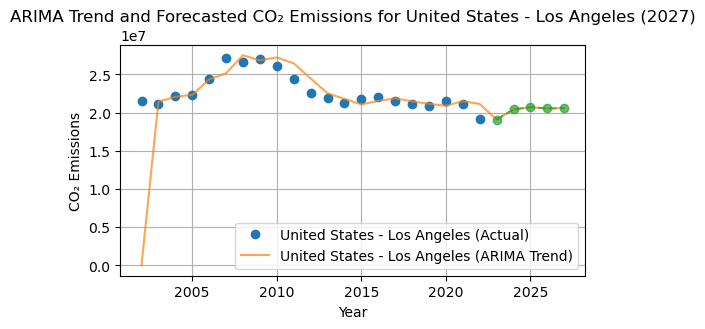

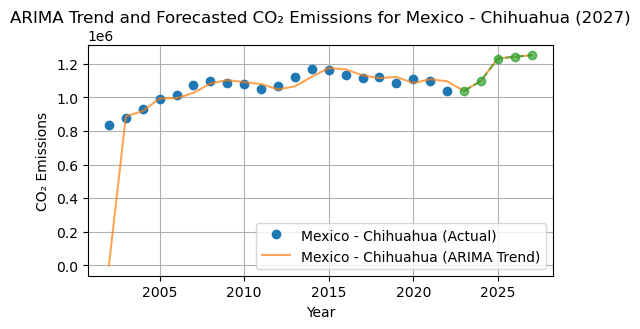

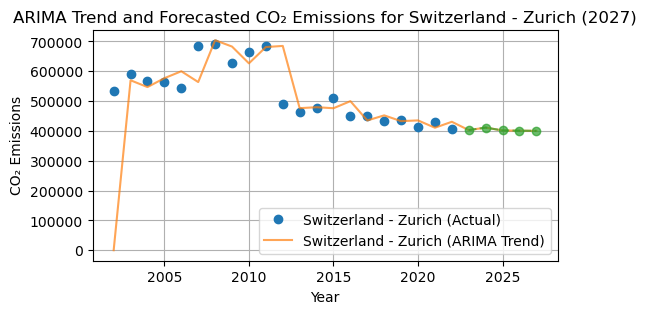

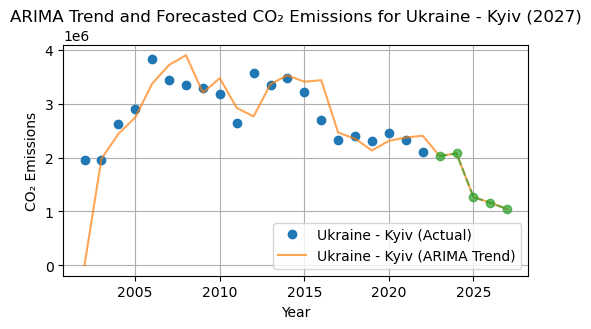

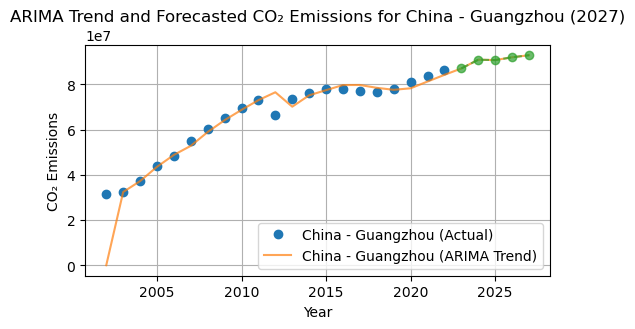

In [ ]:
import matplotlib.pyplot as plt

# sel cities
selected_ids = [14, 111, 2463, 3517, 12080]
selected_cities = co2_yearly[co2_yearly.index.isin(selected_ids)]

#years
all_years = np.arange(2002, 2028)  # Full range 2002-2027
past_years = np.arange(2002, 2023)  # Actual data
future_years = np.arange(2023, 2028)  # Forecasted

plt.figure(figsize=(12, 6))

for _, row in selected_cities.iterrows():
    city_name = f"{row['CTR_MN_NM']} - {row['UC_NM_MN']}"
    
    # Extract actual emissions skip the first two metadata columns
    actual_emissions = row.iloc[2:].dropna().values  # Start from the 3rd column, drop NaNs
    
    # Ensure the emissions are numeric
    actual_emissions = actual_emissions.astype(float)
    
    # fit ARIMA
    try:
        model = ARIMA(actual_emissions, order=(4, 1, 1)) # what model type should I choose ?
        model_fit = model.fit()
        
        # generate predictions
        full_forecast = model_fit.predict(start=0, end=len(all_years)-1)
        
        # Create new plot for each city
        plt.figure(figsize=(6, 3))
        
        # Plot data as dots without connecting lines
        plt.plot(past_years, actual_emissions[:len(past_years)], 'o', label=f"{city_name} (Actual)")
        
        # Plot full ARIMA trend as solid line
        plt.plot(all_years, full_forecast, linestyle='-', alpha=0.7, label=f"{city_name} (ARIMA Trend)")
        
        #dashed forecast after 2022
        plt.plot(future_years, full_forecast[-5:], 'o--', alpha=0.7)
        
        plt.xlabel("Year")
        plt.ylabel("CO₂ Emissions")
        plt.title(f"ARIMA Trend and Forecasted CO₂ Emissions for {city_name} (2027)")
        plt.legend()
        plt.grid(True)
        plt.show()


        """# After fitting the model
        residuals = model_fit.resid

        # Plot residuals to see if there are any patterns
        plt.figure(figsize=(12, 6))
        plt.plot(residuals)
        plt.title(f"Residuals for {city_name}")
        plt.grid(True)
        plt.show()

        # Check for autocorrelation in residuals
        from statsmodels.graphics.tsaplots import plot_acf
        plot_acf(residuals, lags=20)
        plt.show() """
        
    except Exception as e:
        print(f"ARIMA failed for city {city_name}: {e}")



<Figure size 1200x600 with 0 Axes>

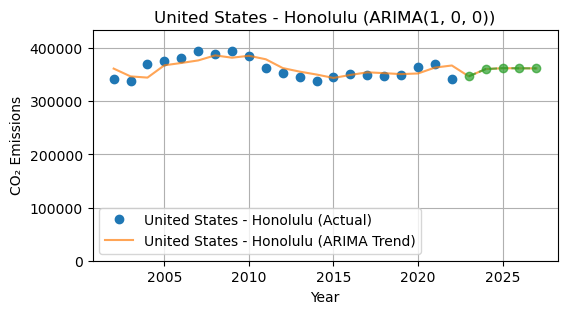

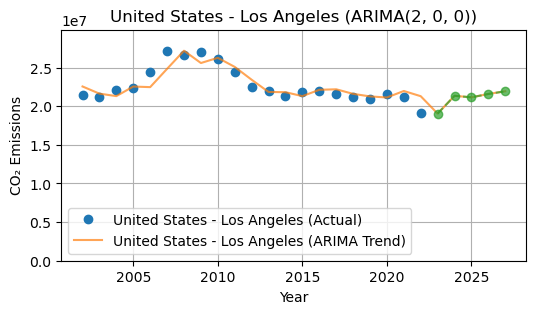

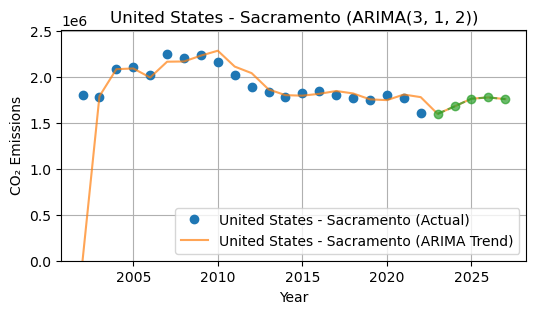

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmo

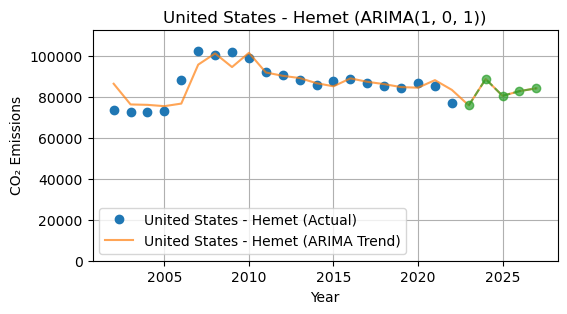

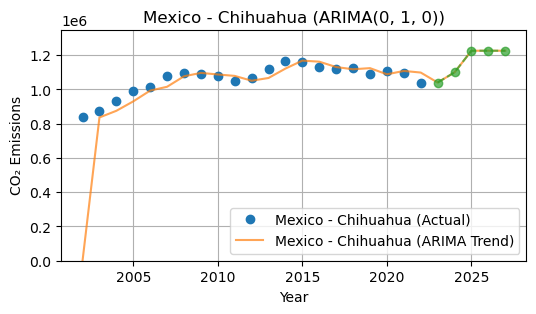

d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


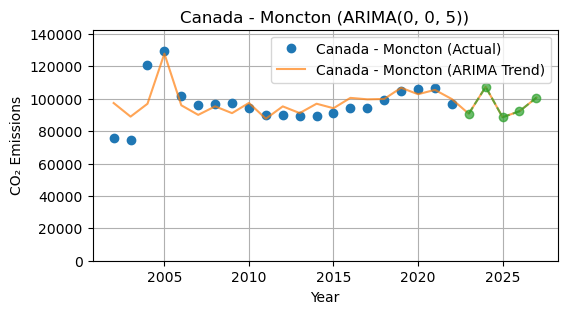

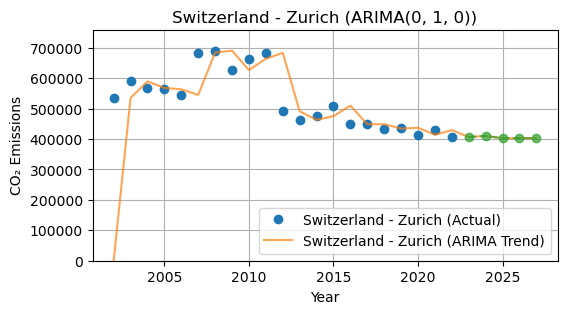

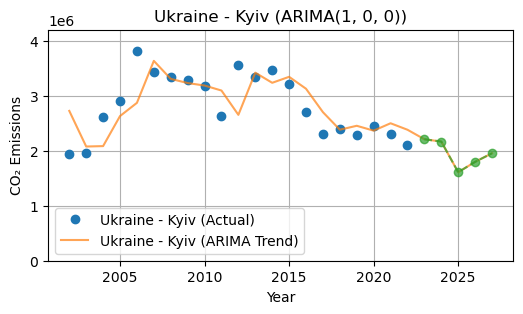

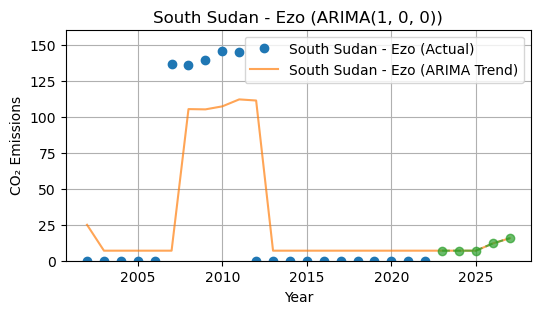

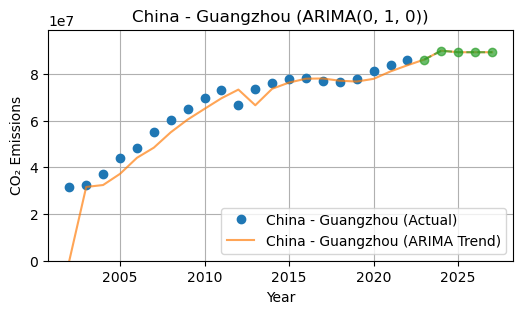

In [ ]:
import matplotlib.pyplot as plt

# Selected cities
selected_ids = [1, 14, 49, 50, 111, 1112, 2463, 3517, 3779, 12080]
selected_cities = co2_yearly[co2_yearly.index.isin(selected_ids)]

# Years
all_years = np.arange(2002, 2028)  # Full range 2002-2027
past_years = np.arange(2002, 2023)  # Actual data
future_years = np.arange(2023, 2028)  # Forecasted

plt.figure(figsize=(12, 6))

for _, row in selected_cities.iterrows():
    city_name = f"{row['CTR_MN_NM']} - {row['UC_NM_MN']}"
    
    # Extract actual emissions (skip the first two metadata columns)
    actual_emissions = row.iloc[2:].dropna().values  # Start from the 3rd column, drop NaNs
    
    # Ensure the emissions are numeric
    actual_emissions = actual_emissions.astype(float)
    
    try:
        # Auto ARIMA to determine best parameters
        model_auto = auto_arima(actual_emissions, seasonal=False, stepwise=True, suppress_warnings=True)
        best_order = model_auto.order  # Extract best (p,d,q)
        
        #ARIMA model with chosen parameters
        model = ARIMA(actual_emissions, order=best_order)
        model_fit = model.fit()
        
        # Generate predictions
        full_forecast = model_fit.predict(start=0, end=len(all_years)-1)
        

        plt.figure(figsize=(6, 3))
        
        # Plot actual data as dots without connecting lines
        plt.plot(past_years, actual_emissions[:len(past_years)], 'o', label=f"{city_name} (Actual)")
        
        # Plot full ARIMA trend as a solid line
        plt.plot(all_years, full_forecast, linestyle='-', alpha=0.7, label=f"{city_name} (ARIMA Trend)")
        
        #dashed forecast after 2022
        plt.plot(future_years, full_forecast[-5:], 'o--', alpha=0.7)
        
        plt.xlabel("Year")
        plt.ylabel("CO₂ Emissions")
        plt.title(f"{city_name} (ARIMA{best_order})")
        
        # Adjust y-limits: always start at 0
        plt.ylim(0, max(actual_emissions.max(), full_forecast.max()) * 1.1)  # Add 10% buffer for visibility
        
        plt.legend()
        plt.grid(True)
        plt.show()
    
    except Exception as e:
        print(f"ARIMA failed for city {city_name}: {e}")


In [16]:
from sklearn.linear_model import LinearRegression

# Copy the dataset
co2_yearly_trends = co2_yearly_arima.copy()

# Extract the forecasted values for 2023-2027
forecast_years = ["Forecast_2023", "Forecast_2024", "Forecast_2025", "Forecast_2026", "Forecast_2027"]

# Ensure these columns exist
if not all(year in co2_yearly_trends.columns for year in forecast_years):
    raise ValueError("Missing forecast columns in co2_yearly_arima")

def compute_trend_metrics(row):
    forecasts = row[["Forecast_2023", "Forecast_2024", "Forecast_2025", "Forecast_2026", "Forecast_2027"]].values

    # Ensure forecasts are numeric
    forecasts = pd.to_numeric(forecasts, errors="coerce")

    if np.isnan(forecasts).any():  # Skip cities with NaN forecasts
        return pd.Series([np.nan, np.nan, np.nan])

    # 1. Compute slope using LinearRegression
    years = np.array([2023, 2024, 2025, 2026, 2027]).reshape(-1, 1)
    model = LinearRegression()
    model.fit(years, forecasts)
    slope = model.coef_[0]

    # 2. Compute mean yearly growth rate
    growth_rates = np.diff(forecasts) / forecasts[:-1] * 100
    mean_growth_rate = np.nanmean(growth_rates)  # Use nanmean to ignore NaNs

    # 3. Compute trend score (relative slope)
    mean_forecast = np.nanmean(forecasts)
    trend_score = slope / mean_forecast if mean_forecast != 0 else np.nan

    return pd.Series([slope, mean_growth_rate, trend_score])

# Apply function to each city
co2_yearly_trends = co2_yearly_arima.copy()
trend_results = co2_yearly_trends.apply(compute_trend_metrics, axis=1)

# Assign column names
trend_results.columns = ["Slope_Trend", "Mean_Growth_Rate", "Trend_Score"]

# Merge results into the dataframe
co2_yearly_trends = pd.concat([co2_yearly_trends, trend_results], axis=1)

# Save to CSV
co2_yearly_trends.to_csv("urban_co2_emissions_trends.csv", index=False)

print("Trend metrics computed successfully!")

# Display first rows
co2_yearly_trends.head()

C:\Users\Bastien Amez-Droz\AppData\Local\Temp\ipykernel_17356\2252598622.py:29: RuntimeWarning: invalid value encountered in divide
  growth_rates = np.diff(forecasts) / forecasts[:-1] * 100
C:\Users\Bastien Amez-Droz\AppData\Local\Temp\ipykernel_17356\2252598622.py:30: RuntimeWarning: Mean of empty slice
  mean_growth_rate = np.nanmean(growth_rates)  # Use nanmean to ignore NaNs
C:\Users\Bastien Amez-Droz\AppData\Local\Temp\ipykernel_17356\2252598622.py:29: RuntimeWarning: invalid value encountered in divide
  growth_rates = np.diff(forecasts) / forecasts[:-1] * 100
C:\Users\Bastien Amez-Droz\AppData\Local\Temp\ipykernel_17356\2252598622.py:30: RuntimeWarning: Mean of empty slice
  mean_growth_rate = np.nanmean(growth_rates)  # Use nanmean to ignore NaNs
C:\Users\Bastien Amez-Droz\AppData\Local\Temp\ipykernel_17356\2252598622.py:29: RuntimeWarning: invalid value encountered in divide
  growth_rates = np.diff(forecasts) / forecasts[:-1] * 100
C:\Users\Bastien Amez-Droz\AppData\Local\Te

Trend metrics computed successfully!


CTR_MN_NM       UC_NM_MN           2000           2001  \
ID_HDC_G0                                                                  
1             United States       Honolulu  341710.853027  338639.188721   
2          French Polynesia        Papeete   28643.142578   30317.875732   
3             United States    Santa Maria   69493.875000   68458.202637   
4             United States       Monterey   50901.322266   50142.733887   
5             United States  Santa Barbara   65813.701172   64832.872070   

                    2002           2003           2004           2005  \
ID_HDC_G0                                                               
1          370032.878906  375895.176270  382408.086182  395227.213379   
2           38358.611816   40959.414795   50793.029297   49476.266602   
3           69224.806641   69959.107422   72140.982422   78801.665039   
4           52888.512207   53449.529785   40798.151855   47164.968262   
5           66933.419922   67643.420410   71000.125488   70483.196289   

                    2006           2007  ...  Forecast_2023  Forecast_2024  \
ID_HDC_G0                                ...                                 
1          389343.081055  394208.305176  ...  361870.252184  361322.409798   
2           51250.163574   50285.929199  ...  117954.787864  121837.902876   
3           77259.279297   78443.057617  ...   55749.008057   55749.008057   
4           46241.807861   46950.331299  ...   36763.688477   36763.688477   
5           69103.631348   70162.445801  ...   59076.197021   59076.197021   

           Forecast_2025  Forecast_2026  Forecast_2027  \
ID_HDC_G0                                                
1          360924.844692  360636.334680  360426.965131   
2          125721.017889  129604.132901  133487.247914   
3           55749.008057   55749.008057   55749.008057   
4           36763.688477   36763.688477   36763.688477   
5           59076.197021   59076.197021   59076.197021   

           Relative_Decrease_2022_2027  First_AR_Param   Slope_Trend  \
ID_HDC_G0                                                              
1                            -0.606194        0.725692 -3.572649e+02   
2                            17.020505             NaN  3.883115e+03   
3                             0.000000             NaN -1.989067e-28   
4                             0.000000             NaN  0.000000e+00   
5                             0.000000             NaN  0.000000e+00   

           Mean_Growth_Rate   Trend_Score  
ID_HDC_G0                                  
1                 -0.099854 -9.895544e-04  
2                  3.140991  3.088676e-02  
3                  0.000000 -3.567896e-33  
4                  0.000000  0.000000e+00  
5                  0.000000  0.000000e+00  

[5 rows x 35 columns]


Forecast for United States - Santa Maria: 2023: 51515.74, 2024: 55107.94, 2025: 55749.01, 2026: 55749.01, 2027: 55749.01
Slope Trend: 910.7602, Mean Growth Rate: 2.03%, Trend Score: 0.0166


<Figure size 1200x600 with 0 Axes>

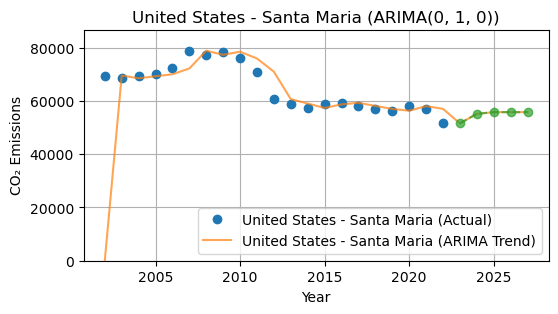


Forecast for United States - Monterey: 2023: 33972.06, 2024: 36340.94, 2025: 36763.69, 2026: 36763.69, 2027: 36763.69
Slope Trend: 600.6011, Mean Growth Rate: 2.03%, Trend Score: 0.0166


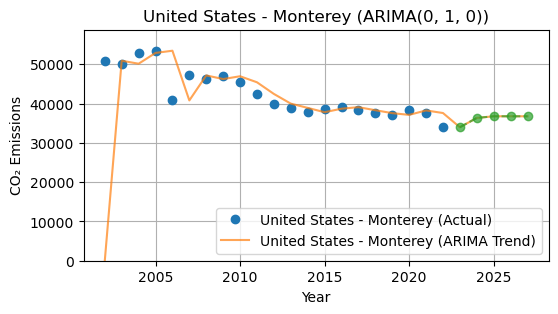


Forecast for Netherlands - Hilversum: 2023: 37413.24, 2024: 37538.88, 2025: 37797.50, 2026: 38924.88, 2027: 40262.84
Slope Trend: 708.5198, Mean Growth Rate: 1.86%, Trend Score: 0.0185


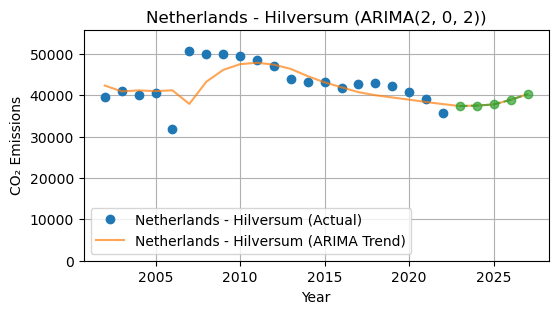


Forecast for Bangladesh - Masundia: 2023: 164.73, 2024: 170.90, 2025: 176.54, 2026: 176.54, 2027: 176.54
Slope Trend: 2.9261, Mean Growth Rate: 1.76%, Trend Score: 0.0169


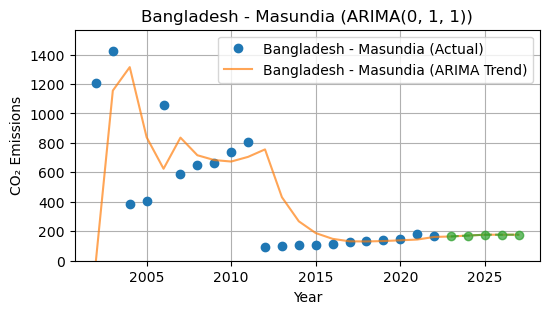

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Selected cities
selected_ids = [3, 4, 2188, 9838]
selected_cities = co2_yearly[co2_yearly.index.isin(selected_ids)]

# Years
all_years = np.arange(2002, 2028)  # Full range 2002-2027
past_years = np.arange(2002, 2023)  # Actual data
future_years = np.arange(2023, 2028)  # Forecasted

plt.figure(figsize=(12, 6))

for _, row in selected_cities.iterrows():
    city_name = f"{row['CTR_MN_NM']} - {row['UC_NM_MN']}"
    
    # Extract actual emissions (skip the first two metadata columns)
    actual_emissions = row.iloc[2:].dropna().values  # Start from the 3rd column, drop NaNs
    
    # Ensure the emissions are numeric
    actual_emissions = actual_emissions.astype(float)
    
    try:
        # Fit Auto ARIMA to determine best parameters
        model_auto = auto_arima(actual_emissions, seasonal=False, stepwise=True, suppress_warnings=True)
        best_order = model_auto.order  # Extract best (p,d,q)
        
        # Fit ARIMA model with chosen parameters
        model = ARIMA(actual_emissions, order=best_order)
        model_fit = model.fit()
        
        # Generate predictions for the full range
        full_forecast = model_fit.predict(start=0, end=len(all_years)-1)
        forecasted_values = full_forecast[-5:]  # Extract 2023-2027 values
        
        # Compute the three trend metrics
        x = future_years.reshape(-1, 1)
        y = forecasted_values.reshape(-1, 1)

        # 1. Slope Trend
        lin_reg = LinearRegression().fit(x, y)
        slope = lin_reg.coef_[0][0]

        # 2. Mean Growth Rate
        growth_rates = np.diff(forecasted_values) / forecasted_values[:-1]
        mean_growth_rate = np.mean(growth_rates) * 100  # Convert to %

        # 3. Trend Score (slope normalized by mean emissions)
        mean_forecast = np.mean(forecasted_values)
        trend_score = slope / mean_forecast if mean_forecast != 0 else np.nan
        
        # Print forecasted values and trend metrics
        forecast_str = ", ".join(f"{year}: {value:.2f}" for year, value in zip(future_years, forecasted_values))
        print(f"\nForecast for {city_name}: {forecast_str}")
        print(f"Slope Trend: {slope:.4f}, Mean Growth Rate: {mean_growth_rate:.2f}%, Trend Score: {trend_score:.4f}")

        # Create a new plot for each city
        plt.figure(figsize=(6, 3))
        
        # Plot actual data as dots without connecting lines
        plt.plot(past_years, actual_emissions[:len(past_years)], 'o', label=f"{city_name} (Actual)")
        
        # Plot full ARIMA trend as a solid line
        plt.plot(all_years, full_forecast, linestyle='-', alpha=0.7, label=f"{city_name} (ARIMA Trend)")
        
        # Dashed forecast after 2022
        plt.plot(future_years, forecasted_values, 'o--', alpha=0.7)
        
        # Labels and title
        plt.xlabel("Year")
        plt.ylabel("CO₂ Emissions")
        plt.title(f"{city_name} (ARIMA{best_order})")
        
        # Adjust y-limits to always start at 0 and end at the city's max value
        plt.ylim(0, max(actual_emissions.max(), full_forecast.max()) * 1.1)  # Add 10% buffer for visibility
        
        plt.legend()
        plt.grid(True)
        plt.show()
    
    except Exception as e:
        print(f"ARIMA failed for city {city_name}: {e}")


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


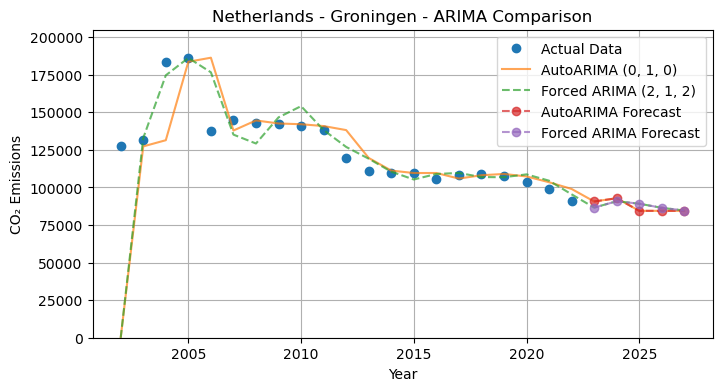

📊 **Netherlands - Groningen - Forecasted CO₂ Emissions (2023-2027)**
Year  AutoARIMA   Forced ARIMA
2023  90678.97    86594.40    
2024  92843.11    90834.15    
2025  84444.30    89194.73    
2026  84444.30    86461.11    
2027  84444.30    84653.26    

📈 **Trend Metrics**
Metric              AutoARIMA   Forced ARIMA
Slope               -2086.8136  -825.5306   
Mean Growth Rate (%)-1.6649     -0.5161     
Trend Score         3474.3563   426.0687    


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

# Function to analyze and compare AutoARIMA vs. Forced ARIMA
def analyze_city_with_forced_arima(city_id, forced_order=(1, 0, 0)):
    # Extract city data
    row = co2_yearly.loc[city_id]
    city_name = f"{row['CTR_MN_NM']} - {row['UC_NM_MN']}"
    
    # Extract actual emissions (skipping metadata columns)
    actual_emissions = row.iloc[2:].dropna().values.astype(float)  # Ensure numeric
    past_years = np.arange(2002, 2023)
    future_years = np.arange(2023, 2028)
    all_years = np.arange(2002, 2028)  # Full range 2002-2027
    
    try:
        # AutoARIMA Model
        model_auto = auto_arima(actual_emissions, seasonal=False, stepwise=True, suppress_warnings=True)
        best_order = model_auto.order  # Best (p,d,q)
        model_auto_fit = ARIMA(actual_emissions, order=best_order).fit()
        auto_forecast = model_auto_fit.predict(start=0, end=len(all_years)-1)

        # Forced ARIMA Model
        model_forced_fit = ARIMA(actual_emissions, order=forced_order).fit()
        forced_forecast = model_forced_fit.predict(start=0, end=len(all_years)-1)

        # Compute trend metrics
        def compute_trend_metrics(forecasts):
            x = future_years.reshape(-1, 1)
            y = forecasts[-5:].reshape(-1, 1)  # Last 5 years (2023-2027)
            model = LinearRegression().fit(x, y)
            slope = model.coef_[0][0]
            mean_growth_rate = np.mean(np.diff(y.flatten()) / y.flatten()[:-1]) * 100
            trend_score = slope * mean_growth_rate
            return slope, mean_growth_rate, trend_score
        
        auto_slope, auto_mg, auto_ts = compute_trend_metrics(auto_forecast)
        forced_slope, forced_mg, forced_ts = compute_trend_metrics(forced_forecast)

        # Plot results
        plt.figure(figsize=(8, 4))
        plt.plot(past_years, actual_emissions[:len(past_years)], 'o', label="Actual Data")
        plt.plot(all_years, auto_forecast, linestyle='-', alpha=0.7, label=f"AutoARIMA {best_order}")
        plt.plot(all_years, forced_forecast, linestyle='--', alpha=0.7, label=f"Forced ARIMA {forced_order}")
        plt.plot(future_years, auto_forecast[-5:], 'o--', label="AutoARIMA Forecast", alpha=0.7)
        plt.plot(future_years, forced_forecast[-5:], 'o--', label="Forced ARIMA Forecast", alpha=0.7)
        plt.xlabel("Year")
        plt.ylabel("CO₂ Emissions")
        plt.title(f"{city_name} - ARIMA Comparison")
        plt.ylim(0, max(auto_forecast.max(), forced_forecast.max()) * 1.1)
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print forecasted values
        print(f"📊 **{city_name} - Forecasted CO₂ Emissions (2023-2027)**")
        print(f"{'Year':<6}{'AutoARIMA':<12}{'Forced ARIMA':<12}")
        for i, year in enumerate(future_years):
            print(f"{year:<6}{auto_forecast[-5:][i]:<12.2f}{forced_forecast[-5:][i]:<12.2f}")
        
        # Print trend metrics
        print("\n📈 **Trend Metrics**")
        print(f"{'Metric':<20}{'AutoARIMA':<12}{'Forced ARIMA':<12}")
        print(f"{'Slope':<20}{auto_slope:<12.4f}{forced_slope:<12.4f}")
        print(f"{'Mean Growth Rate (%)':<20}{auto_mg:<12.4f}{forced_mg:<12.4f}")
        print(f"{'Trend Score':<20}{auto_ts:<12.4f}{forced_ts:<12.4f}")

    except Exception as e:
        print(f"⚠️ ARIMA failed for {city_name}: {e}")

# Example usage
analyze_city_with_forced_arima(city_id=2269, forced_order=(2, 1, 2))


d:\python\miniconda3\envs\co2-stats\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


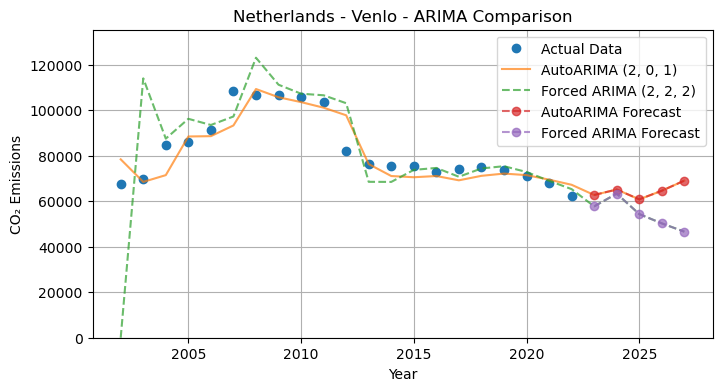

📊 **Netherlands - Venlo - Forecasted CO₂ Emissions (2023-2027)**
Year  AutoARIMA   Forced ARIMA
2023  62705.42    57711.12    
2024  65111.38    63305.50    
2025  60793.91    54318.73    
2026  64574.95    50241.47    
2027  69020.87    46587.65    

📈 **Trend Metrics**
Metric              AutoARIMA   Forced ARIMA
Slope               1209.4478   -3531.0976  
Mean Growth Rate (%)2.5776      -4.8202     
Trend Score         3117.4625   17020.6052  


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

# Function to analyze and compare AutoARIMA vs. Forced ARIMA
def analyze_city_with_forced_arima(city_id, forced_order=(1, 0, 0)):
    # Extract city data
    row = co2_yearly.loc[city_id]
    city_name = f"{row['CTR_MN_NM']} - {row['UC_NM_MN']}"
    
    # Extract actual emissions (skipping metadata columns)
    actual_emissions = row.iloc[2:].dropna().values.astype(float)  # Ensure numeric
    past_years = np.arange(2002, 2023)
    future_years = np.arange(2023, 2028)
    all_years = np.arange(2002, 2028)  # Full range 2002-2027
    
    try:
        # AutoARIMA Model
        model_auto = auto_arima(actual_emissions, seasonal=False, stepwise=True, suppress_warnings=True)
        best_order = model_auto.order  # Best (p,d,q)
        model_auto_fit = ARIMA(actual_emissions, order=best_order).fit()
        auto_forecast = model_auto_fit.predict(start=0, end=len(all_years)-1)

        # Forced ARIMA Model
        model_forced_fit = ARIMA(actual_emissions, order=forced_order).fit()
        forced_forecast = model_forced_fit.predict(start=0, end=len(all_years)-1)

        # Compute trend metrics
        def compute_trend_metrics(forecasts):
            x = future_years.reshape(-1, 1)
            y = forecasts[-5:].reshape(-1, 1)  # Last 5 years (2023-2027)
            model = LinearRegression().fit(x, y)
            slope = model.coef_[0][0]
            mean_growth_rate = np.mean(np.diff(y.flatten()) / y.flatten()[:-1]) * 100
            trend_score = slope * mean_growth_rate
            return slope, mean_growth_rate, trend_score
        
        auto_slope, auto_mg, auto_ts = compute_trend_metrics(auto_forecast)
        forced_slope, forced_mg, forced_ts = compute_trend_metrics(forced_forecast)

        # Plot results
        plt.figure(figsize=(8, 4))
        plt.plot(past_years, actual_emissions[:len(past_years)], 'o', label="Actual Data")
        plt.plot(all_years, auto_forecast, linestyle='-', alpha=0.7, label=f"AutoARIMA {best_order}")
        plt.plot(all_years, forced_forecast, linestyle='--', alpha=0.7, label=f"Forced ARIMA {forced_order}")
        plt.plot(future_years, auto_forecast[-5:], 'o--', label="AutoARIMA Forecast", alpha=0.7)
        plt.plot(future_years, forced_forecast[-5:], 'o--', label="Forced ARIMA Forecast", alpha=0.7)
        plt.xlabel("Year")
        plt.ylabel("CO₂ Emissions")
        plt.title(f"{city_name} - ARIMA Comparison")
        plt.ylim(0, max(auto_forecast.max(), forced_forecast.max()) * 1.1)
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print forecasted values
        print(f"📊 **{city_name} - Forecasted CO₂ Emissions (2023-2027)**")
        print(f"{'Year':<6}{'AutoARIMA':<12}{'Forced ARIMA':<12}")
        for i, year in enumerate(future_years):
            print(f"{year:<6}{auto_forecast[-5:][i]:<12.2f}{forced_forecast[-5:][i]:<12.2f}")
        
        # Print trend metrics
        print("\n📈 **Trend Metrics**")
        print(f"{'Metric':<20}{'AutoARIMA':<12}{'Forced ARIMA':<12}")
        print(f"{'Slope':<20}{auto_slope:<12.4f}{forced_slope:<12.4f}")
        print(f"{'Mean Growth Rate (%)':<20}{auto_mg:<12.4f}{forced_mg:<12.4f}")
        print(f"{'Trend Score':<20}{auto_ts:<12.4f}{forced_ts:<12.4f}")

    except Exception as e:
        print(f"⚠️ ARIMA failed for {city_name}: {e}")

# Example usage
analyze_city_with_forced_arima(city_id=2247, forced_order=(2, 2, 2))


In [41]:
target_years = [2018, 2019, 2020, 2021, 2022]  # Keep them as integers

def compute_mean_growth_rate(row):
    if not set(target_years).issubset(row.index):
        return np.nan  # Skip if years are missing

    emissions = row[target_years].astype(float).values  # Extract values
    if np.any(emissions <= 0) or np.isnan(emissions).any():
        return np.nan  # Avoid errors with 0 or NaN

    growth_rates = np.diff(emissions) / emissions[:-1] * 100  # % change
    return np.mean(growth_rates)

co2_yearly_trends["Mean_Growth_2018_2022"] = co2_yearly_trends.apply(compute_mean_growth_rate, axis=1)

# Save the updated dataframe
co2_yearly_trends.to_csv("co2_yearly_trends_updated.csv", index=True)

print("✅ Done! Mean growth rate added.")


✅ Done! Mean growth rate added.


In [42]:
co2_yearly_trends.head()

CTR_MN_NM       UC_NM_MN           2000           2001  \
ID_HDC_G0                                                                  
1             United States       Honolulu  341710.853027  338639.188721   
2          French Polynesia        Papeete   28643.142578   30317.875732   
3             United States    Santa Maria   69493.875000   68458.202637   
4             United States       Monterey   50901.322266   50142.733887   
5             United States  Santa Barbara   65813.701172   64832.872070   

                    2002           2003           2004           2005  \
ID_HDC_G0                                                               
1          370032.878906  375895.176270  382408.086182  395227.213379   
2           38358.611816   40959.414795   50793.029297   49476.266602   
3           69224.806641   69959.107422   72140.982422   78801.665039   
4           52888.512207   53449.529785   40798.151855   47164.968262   
5           66933.419922   67643.420410   71000.125488   70483.196289   

                    2006           2007  ...  Forecast_2024  Forecast_2025  \
ID_HDC_G0                                ...                                 
1          389343.081055  394208.305176  ...  361322.409798  360924.844692   
2           51250.163574   50285.929199  ...  121837.902876  125721.017889   
3           77259.279297   78443.057617  ...   55749.008057   55749.008057   
4           46241.807861   46950.331299  ...   36763.688477   36763.688477   
5           69103.631348   70162.445801  ...   59076.197021   59076.197021   

           Forecast_2026  Forecast_2027  Relative_Decrease_2022_2027  \
ID_HDC_G0                                                              
1          360636.334680  360426.965131                    -0.606194   
2          129604.132901  133487.247914                    17.020505   
3           55749.008057   55749.008057                     0.000000   
4           36763.688477   36763.688477                     0.000000   
5           59076.197021   59076.197021                     0.000000   

           First_AR_Param   Slope_Trend  Mean_Growth_Rate   Trend_Score  \
ID_HDC_G0                                                                 
1                0.725692 -3.572649e+02         -0.099854 -9.895544e-04   
2                     NaN  3.883115e+03          3.140991  3.088676e-02   
3                     NaN -1.989067e-28          0.000000 -3.567896e-33   
4                     NaN  0.000000e+00          0.000000  0.000000e+00   
5                     NaN  0.000000e+00          0.000000  0.000000e+00   

           Mean_Growth_2018_2022  
ID_HDC_G0                         
1                       0.005348  
2                       4.746273  
3                      -0.806547  
4                      -0.806546  
5                      -0.806547  

[5 rows x 36 columns]

In [40]:
print(co2_yearly_trends.columns.tolist())  # Are years integers or strings?


['CTR_MN_NM', 'UC_NM_MN', 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 'Forecast_2023', 'Forecast_2024', 'Forecast_2025', 'Forecast_2026', 'Forecast_2027', 'Relative_Decrease_2022_2027', 'First_AR_Param', 'Slope_Trend', 'Mean_Growth_Rate', 'Trend_Score']
